# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')


/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet

/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [113]:
# response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
# z = zipfile.ZipFile(io.BytesIO(response.content))
# z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

In [50]:
# with open('data/master_2017.json') as f:
#     jsondata = json.load(f)

with open('data/trumptwitterarchive-20180814.json') as f:
    jsondata = json.load(f)

    analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
#     del(row['entities'])
    try: 
        text = row['text']
    except KeyError: 
        text = row['full_text']
    vs = analyzer.polarity_scores(text)
    row['sentiment'] = vs

with open('data/processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [83]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to year
def convertUTCtoYear(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to year-month
def convertUTCtoYearMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# convert to year + week of year
def convertUTCtoYearWeekNumber(date):
    utc = arrow.get(date)
    year = utc.to('US/Eastern').format('YYYY')
    weekno = int(date.strftime('%U'))
    return str(year) + '-' + str(weekno).zfill(2)

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [84]:
# with open('data/master_2017_processed.json') as f:
#     jsondata = json.load(f)
# normalized_json = pd.io.json.json_normalize(jsondata)
# tweets = pd.DataFrame(normalized_json)
# tweets['created_date'] = pd.to_datetime(tweets['created_at'])
# tweets.text.fillna(tweets.full_text, inplace=True)
# tweets.text.fillna(tweets.text, inplace=True)

with open('data/processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])
tweets['id'] = tweets['id_str']
tweets.text.fillna(tweets.text, inplace=True)

Add many time grouping columns.

NOTE: These don't yet differentiate between 2017 and 2018. So, say, tweets Aug 2017 and Aug 2018 might be aggregated together later. (8/14/2018)

In [85]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['year'] = tweets['created_date'].apply(convertUTCtoYear)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['year_month'] = tweets['created_date'].apply(convertUTCtoYearMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber) 
tweets['year_week'] = tweets['created_date'].apply(convertUTCtoYearWeekNumber)
tweets['text encoded'] = tweets['text'].apply(encodeText)
tweets.set_index('created_date', inplace=True)

tweets.head()

,created_at,favorite_count,id_str,is_retweet,retweet_count,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,source,...,month/day,year,month,year_month,day,day of week,hour,week,year_week,text encoded
created_date,,,,,,,,,,,,,,,,,,,,,
2018-08-14 13:15:58,Tue Aug 14 13:15:58 +0000 2018,35311,1029355952414371841,False,9609,-0.3256,0.161,0.723,0.116,Twitter for iPhone,...,2018-08-14,2018,08,2018-08,14,2,9,32,2018-32,b'Lou Dobbs: This cannot go forward...this Spe...
2018-08-14 13:10:30,Tue Aug 14 13:10:30 +0000 2018,36961,1029354577559281665,False,9876,-0.9054,0.358,0.642,0.000,Twitter for iPhone,...,2018-08-14,2018,08,2018-08,14,2,9,32,2018-32,b'Strzok started the illegal Rigged Witch Hunt...
2018-08-14 13:01:50,Tue Aug 14 13:01:50 +0000 2018,41181,1029352395464224769,False,11089,-0.9080,0.241,0.759,0.000,Twitter for iPhone,...,2018-08-14,2018,08,2018-08,14,2,9,32,2018-32,"b'Fired FBI Agent Peter Strzok is a fraud, as ..."
2018-08-14 12:06:55,Tue Aug 14 12:06:55 +0000 2018,37104,1029338578239795200,False,10530,-0.5672,0.134,0.811,0.055,Twitter for iPhone,...,2018-08-14,2018,08,2018-08,14,2,8,32,2018-32,"b'They were all in on it, clear Hillary Clinto..."
2018-08-14 11:55:01,Tue Aug 14 11:55:01 +0000 2018,36035,1029335579845115904,False,9839,-0.8176,0.214,0.741,0.044,Twitter for iPhone,...,2018-08-14,2018,08,2018-08,14,2,7,32,2018-32,b'Bruce Ohr of the Justice Department (can you...



# Sources

In [12]:
# tweets['source_clean'] = tweets['source'].apply(stripHTML)
# tweets['source_clean'].unique()

tweets['source'].unique()

array(['Twitter for iPhone', 'Twitter for iPad', 'Media Studio',
       'Twitter Web Client', 'Twitter Ads', 'Twitter for Android'], dtype=object)

# Frequencies

## Total Tweets

In [13]:
len(tweets.index)

4348

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

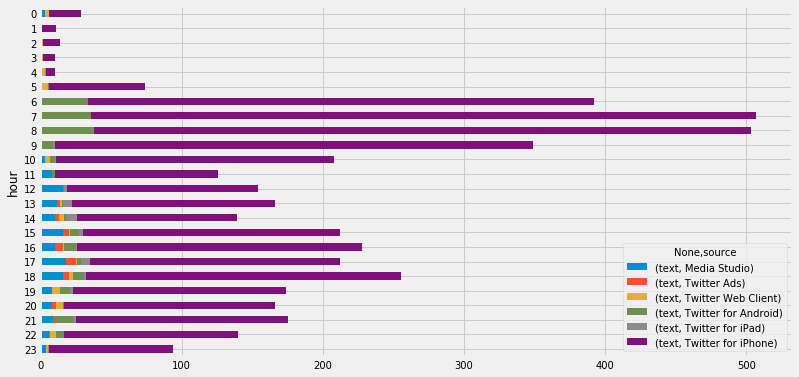

In [14]:
# tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
#     index='hour', columns=['source_clean'], aggfunc='count')

tweetsPerHour = tweets[['source', 'hour', 'text']].pivot_table(
    index='hour', columns=['source'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

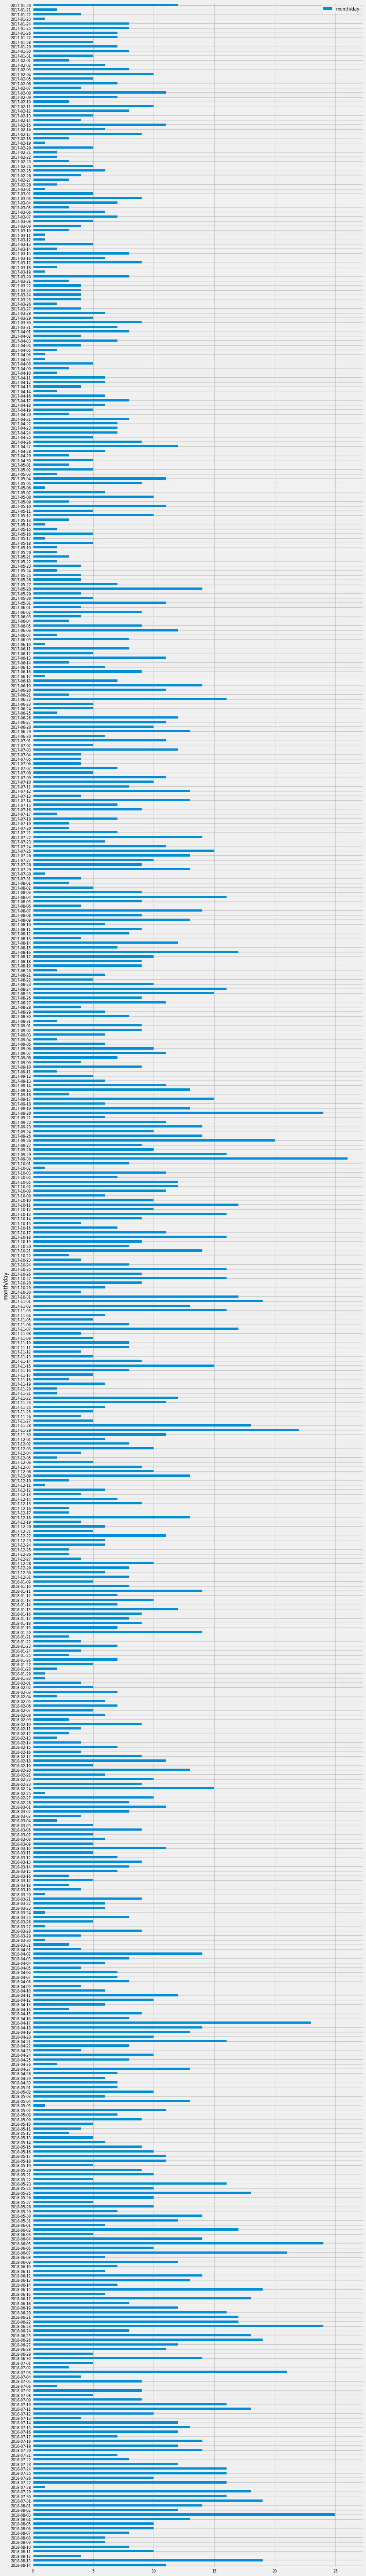

In [15]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,100), fontsize=8)

In [16]:
tweetsPerDay.describe()

,month/day
count,558.000000
mean,7.792115
std,4.681582
min,1.000000
25%,4.000000
50%,7.000000
75%,10.000000
max,26.000000


## Tweets per day of week

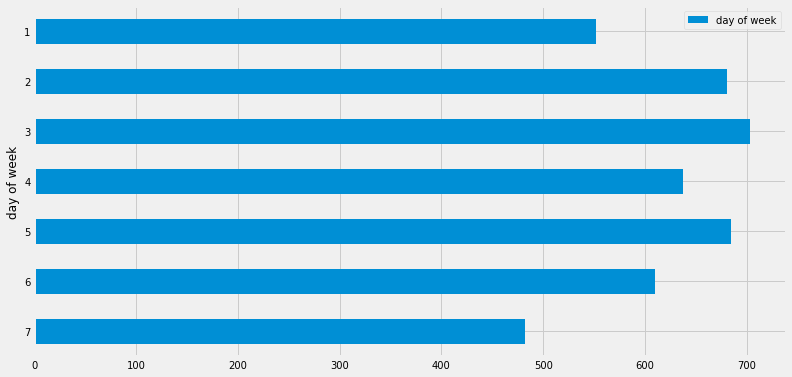

In [17]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')

## Tweets per month

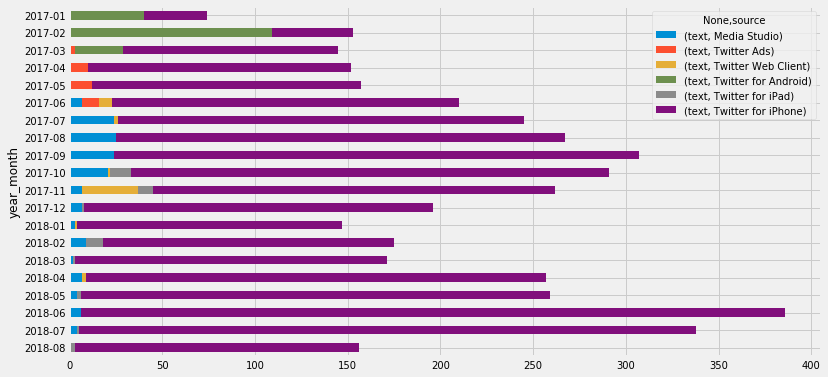

In [86]:
tweetsPerMonth = tweets[['source', 'year_month', 'text']].pivot_table(index='year_month', columns=['source'], aggfunc='count')
tweetsPerMonth.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per week

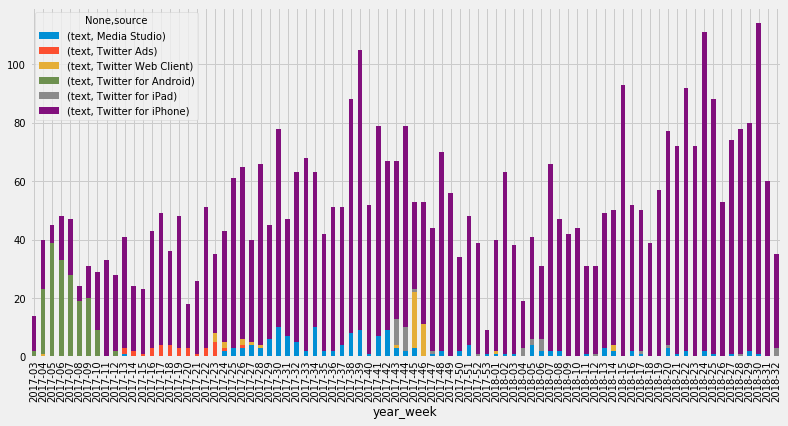

In [81]:
# tweetsPerWeek = tweets[['source', 'week', 'text']].pivot_table(index='week', columns=['source'], aggfunc='count')
tweetsPerWeek = tweets[['source', 'year_week', 'text']].pivot_table(index='year_week', columns=['source'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [20]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [21]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [22]:
pd.set_option('display.width', 1000)
tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2018-04-13 19:36:27,-0.9749,DOJ just issued the McCabe report - which is a...
2018-04-13 12:01:47,-0.9742,James Comey is a proven LEAKER &amp; LIAR. Vir...
2017-12-30 22:36:41,-0.9736,"I use Social Media not because I like to, but ..."
2017-04-18 10:38:59,-0.9735,Democrat Jon Ossoff would be a disaster in Con...
2018-07-29 19:35:14,-0.9722,There is No Collusion! The Robert Mueller Rigg...


In [23]:
tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2018-04-09 00:43:27,0.9899,Congratulations to Patrick Reed on his great a...
2018-06-16 13:12:14,0.9834,"My supporters are the smartest, strongest, mos..."
2018-07-10 10:59:30,0.9826,"Thank you to all of my great supporters, reall..."
2018-07-03 23:19:35,0.9816,"Thank you, @WVGovernor Jim Justice, for that w..."
2018-06-15 11:06:28,0.9813,Thank you for all of the compliments on gettin...


In [24]:
tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

,week,sentiment.compound,text
created_date,,,
2017-12-31 23:43:04,53,0.8968,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...
2017-12-31 22:18:20,53,0.8915,As our Country rapidly grows stronger and smar...
2017-12-31 13:36:32,53,0.8903,Why would smart voters want to put Democrats i...
2017-12-31 19:06:52,53,0.8862,"What a year it’s been, and we're just getting ..."
2017-12-31 13:26:29,53,0.7959,"If the Dems (Crooked Hillary) got elected, you..."
2017-12-31 18:36:28,53,0.6114,My deepest condolences to the victims of the t...
2017-12-31 04:46:21,53,0.0000,“Trump Rally: Stocks put 2017 in the record bo...
2017-12-31 13:03:29,53,-0.6800,Big protests in Iran. The people are finally g...
2017-12-31 22:00:21,53,-0.6927,"Iran, the Number One State of Sponsored Terror..."


## By month

### Average

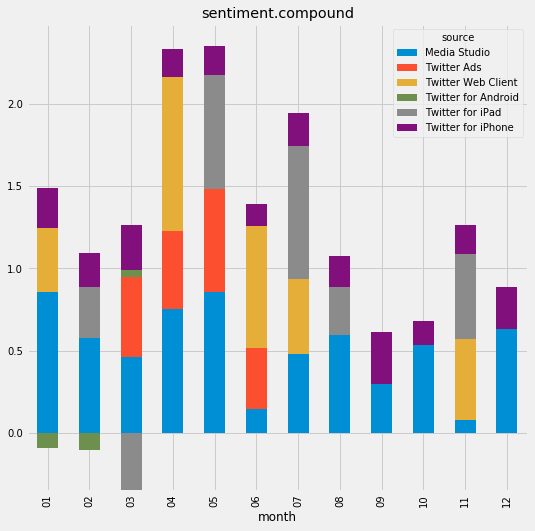

In [25]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'month', field]].pivot_table(index='month', columns='source', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

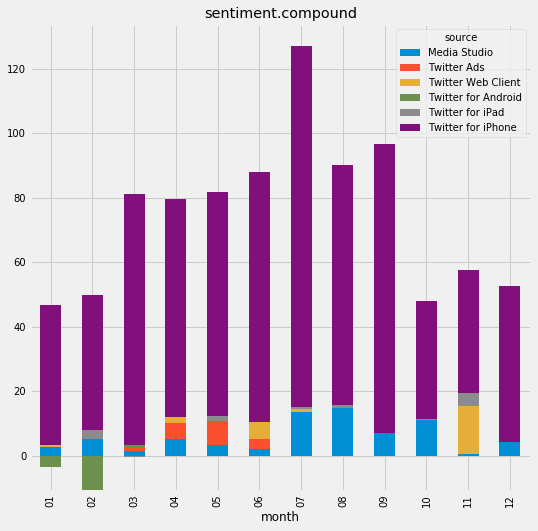

In [26]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'month', field]].pivot_table(index='month', columns='source', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

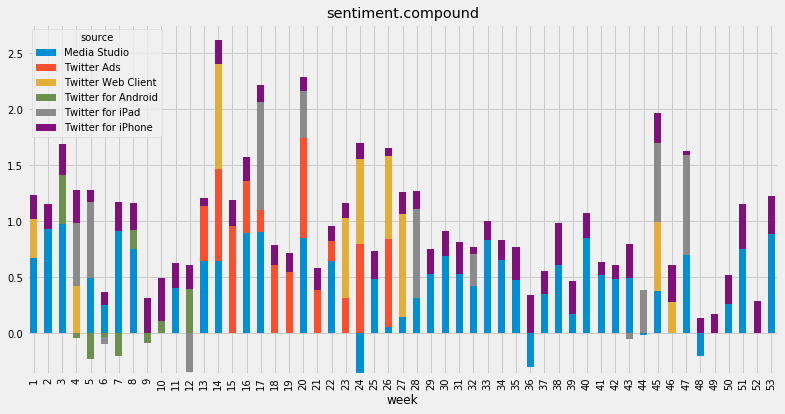

In [27]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'week', field]].pivot_table(index='week', columns='source', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

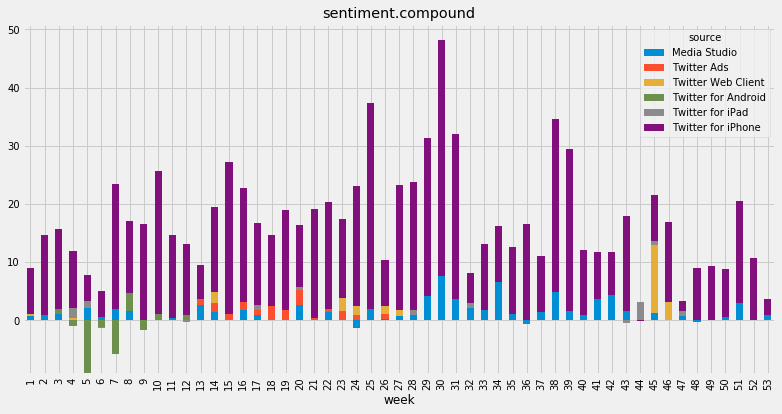

In [28]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'week', field]].pivot_table(index='week', columns='source', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

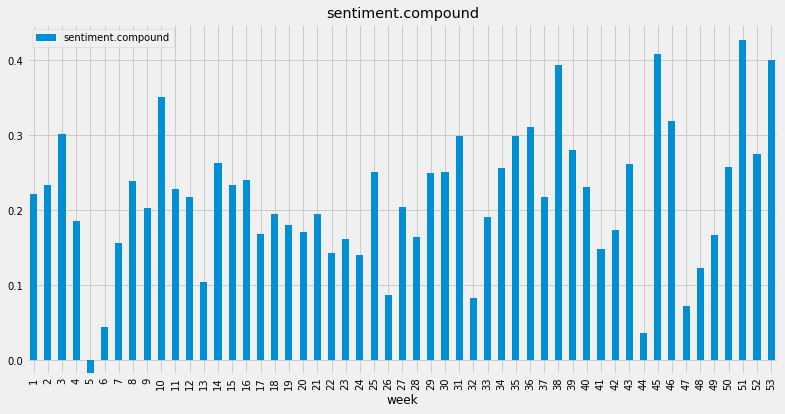

In [29]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['week', field]].groupby('week').mean()
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

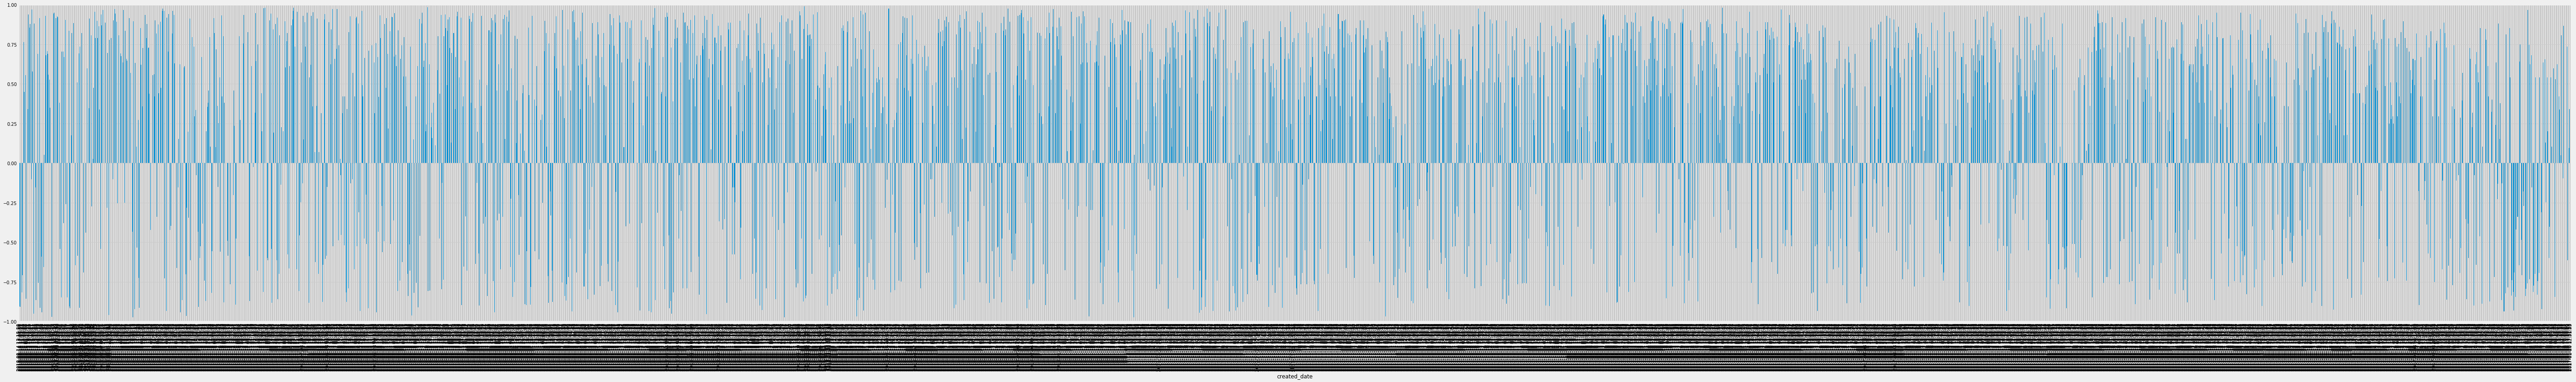

In [30]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

NOTE: Doesn't work with updated dataset (8/14/2018)

In [31]:
# tweets['user.followers_count'].plot()

In [32]:
# tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [33]:
sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
# sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
sortedSentimentPerTweet

,week,sentiment.compound,text,id
created_date,,,,
2017-12-31 23:43:04,53,0.8968,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,947614110082043904
2017-12-31 22:18:20,53,0.8915,As our Country rapidly grows stronger and smar...,947592785519173637
2017-12-31 13:36:32,53,0.8903,Why would smart voters want to put Democrats i...,947461470924820480
2017-12-31 19:06:52,53,0.8862,"What a year it’s been, and we're just getting ...",947544600918372353
2017-12-31 13:26:29,53,0.7959,"If the Dems (Crooked Hillary) got elected, you...",947458942719979520
2017-12-31 18:36:28,53,0.6114,My deepest condolences to the victims of the t...,947536951464333318
2017-12-31 04:46:21,53,0.0000,“Trump Rally: Stocks put 2017 in the record bo...,947328044821336070
2017-12-31 13:03:29,53,-0.6800,Big protests in Iran. The people are finally g...,947453152806297600
2017-12-31 22:00:21,53,-0.6927,"Iran, the Number One State of Sponsored Terror...",947588263103139841


In [34]:
df_sortedSentimentPerTweet = sortedSentimentPerTweet.reset_index()
df_sortedSentimentPerTweet['text-encoded'] = df_sortedSentimentPerTweet['text'].apply(encodeText)
df_sortedSentimentPerTweet = df_sortedSentimentPerTweet.drop('text', axis=1)
df_sortedSentimentPerTweet.to_csv('output/df_sortedSentimentPerTweet.csv')

# Text analysis

Common words.

In [35]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/AHurt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,great,908,b'great'
1,&amp;,704,b'&amp;'
2,’,431,b''
3,!,411,b'!'
4,-,393,b'-'
5,",",363,"b','"
6,.,346,b'.'
7,people,333,b'people'
8,big,293,b'big'
9,fake,292,b'fake'


# Specific text searches

In [41]:
from IPython.display import display, Markdown

tweetsEnc = tweets.reset_index()

def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweetsEnc[tweetsEnc['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweetsEnc) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    analyzedByWeek = filtered[['source', 'week', 'text']].pivot_table(index='week', columns='source', aggfunc='count')
    analyzedByWeek = analyzedByWeek.reindex(range(tweetsEnc['week'].min(), tweetsEnc['week'].max())).fillna(0)
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()
    analyzedByHour = filtered[['source', 'hour', 'text']].pivot_table(index='hour', columns='source', aggfunc='count')
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)
    analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))
    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()
    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

In [42]:
tweetsEnc

,created_date,created_at,favorite_count,id_str,is_retweet,retweet_count,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,...,text,id,human_date,month/day,month,day,day of week,hour,week,text encoded
0,2018-08-14 13:15:58,Tue Aug 14 13:15:58 +0000 2018,35311,1029355952414371841,False,9609,-0.3256,0.161,0.723,0.116,...,Lou Dobbs: “This cannot go forward...this Spec...,1029355952414371841,"Tuesday, Aug 14, 2018 9:15 AM",2018-08-14,08,14,2,9,32,b'Lou Dobbs: This cannot go forward...this Spe...
1,2018-08-14 13:10:30,Tue Aug 14 13:10:30 +0000 2018,36961,1029354577559281665,False,9876,-0.9054,0.358,0.642,0.000,...,Strzok started the illegal Rigged Witch Hunt -...,1029354577559281665,"Tuesday, Aug 14, 2018 9:10 AM",2018-08-14,08,14,2,9,32,b'Strzok started the illegal Rigged Witch Hunt...
2,2018-08-14 13:01:50,Tue Aug 14 13:01:50 +0000 2018,41181,1029352395464224769,False,11089,-0.9080,0.241,0.759,0.000,...,"Fired FBI Agent Peter Strzok is a fraud, as is...",1029352395464224769,"Tuesday, Aug 14, 2018 9:01 AM",2018-08-14,08,14,2,9,32,"b'Fired FBI Agent Peter Strzok is a fraud, as ..."
3,2018-08-14 12:06:55,Tue Aug 14 12:06:55 +0000 2018,37104,1029338578239795200,False,10530,-0.5672,0.134,0.811,0.055,...,"“They were all in on it, clear Hillary Clinton...",1029338578239795200,"Tuesday, Aug 14, 2018 8:06 AM",2018-08-14,08,14,2,8,32,"b'They were all in on it, clear Hillary Clinto..."
4,2018-08-14 11:55:01,Tue Aug 14 11:55:01 +0000 2018,36035,1029335579845115904,False,9839,-0.8176,0.214,0.741,0.044,...,Bruce Ohr of the “Justice” Department (can you...,1029335579845115904,"Tuesday, Aug 14, 2018 7:55 AM",2018-08-14,08,14,2,7,32,b'Bruce Ohr of the Justice Department (can you...
5,2018-08-14 11:42:11,Tue Aug 14 11:42:11 +0000 2018,60582,1029332350969237504,False,15782,-0.8172,0.435,0.446,0.119,...,Another terrorist attack in London...These ani...,1029332350969237504,"Tuesday, Aug 14, 2018 7:42 AM",2018-08-14,08,14,2,7,32,b'Another terrorist attack in London...These a...
6,2018-08-14 11:31:11,Tue Aug 14 11:31:11 +0000 2018,50372,1029329583672307712,False,12442,-0.7088,0.253,0.672,0.075,...,"When you give a crazed, crying lowlife a break...",1029329583672307712,"Tuesday, Aug 14, 2018 7:31 AM",2018-08-14,08,14,2,7,32,"b'When you give a crazed, crying lowlife a bre..."
7,2018-08-14 11:21:48,Tue Aug 14 11:21:48 +0000 2018,25430,1029327223269060609,False,6681,-0.3256,0.161,0.723,0.116,...,Lou Dobbs: “This cannot go forward...this Spec...,1029327223269060609,"Tuesday, Aug 14, 2018 7:21 AM",2018-08-14,08,14,2,7,32,b'Lou Dobbs: This cannot go forward...this Spe...
8,2018-08-14 11:13:26,Tue Aug 14 11:13:26 +0000 2018,40829,1029325115547369472,False,10091,0.7644,0.052,0.754,0.194,...,....should be shut down. The Strzok firing sho...,1029325115547369472,"Tuesday, Aug 14, 2018 7:13 AM",2018-08-14,08,14,2,7,32,b'....should be shut down. The Strzok firing s...
9,2018-08-14 11:07:00,Tue Aug 14 11:07:00 +0000 2018,34936,1029323499226243072,False,8980,0.4504,0.000,0.910,0.090,...,....guy was corrupt and had anti-Trump animus....,1029323499226243072,"Tuesday, Aug 14, 2018 7:07 AM",2018-08-14,08,14,2,7,32,b'....guy was corrupt and had anti-Trump animu...


## Search: _great_

Number of Tweets: 941

Percent of all Tweets: 21.64%

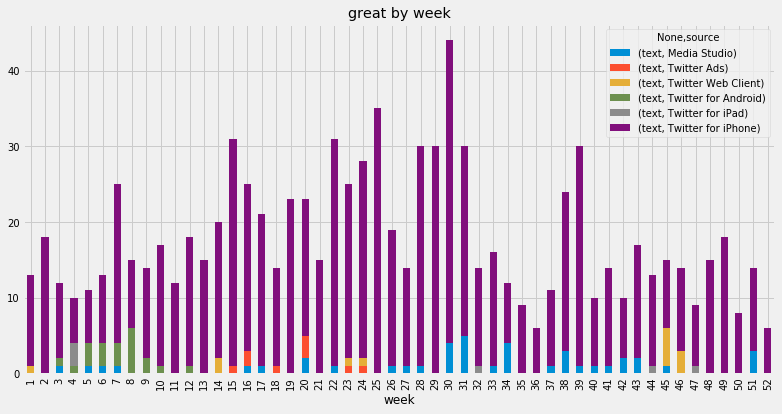

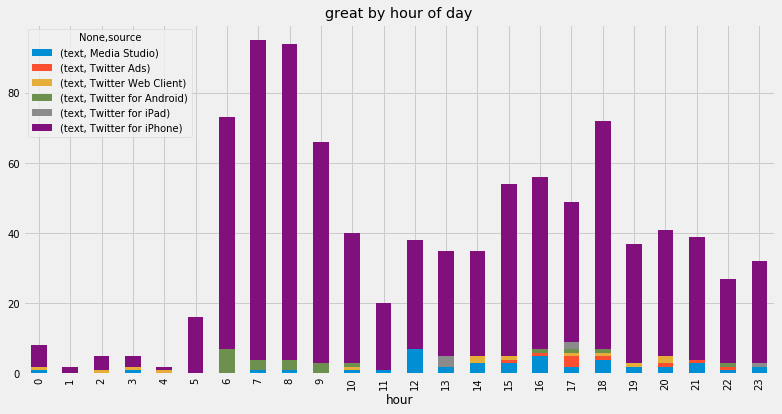

### The Tweets

[Monday, Aug 13, 2018 9:37 PM](https://twitter.com/realDonaldTrump/status/1029180132630687745): Scott Walker of Wisconsin is a tremendous Governor who has done incredible things for that Great State. He has my complete &amp; total Endorsement! He brought the amazing Foxconn to Wisconsin with its 15,000 Jobs-and so much more. Vote for Scott on Tuesday in the Republican Primary!

[Monday, Aug 13, 2018 6:36 PM](https://twitter.com/realDonaldTrump/status/1029134567356149762): It was my great honor to sign our new Defense Bill into law and to pay tribute to the greatest soldiers in the history of the world: THE U.S. ARMY. The National Defense Authorization Act is the most significant investment in our Military and our warfighters in modern history! https://t.co/M6VI1c0Sgx

[Monday, Aug 13, 2018 4:42 PM](https://twitter.com/realDonaldTrump/status/1029105967068323840): Pete Stauber is running for Congress in Minnesota. He will make for a great Congressman. Pete is strong on crime and borders, loves our Military, Vets and Second Amendment. Vote for Pete tomorrow. He has my full and total Endorsement!

[Monday, Aug 13, 2018 3:37 PM](https://twitter.com/realDonaldTrump/status/1029089559710236672): Great to be in Fort Drum, New York with our HEROES! https://t.co/Ke54QGZbU7

[Monday, Aug 13, 2018 2:19 PM](https://twitter.com/realDonaldTrump/status/1029069948214288384): Just landed at Fort Drum, New York. Looking forward to making a speech about our GREAT HEROES!

[Monday, Aug 13, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/1029052803380076544): Brooks Koepka just won his third Golf Major, and he did it not only with his powerful game, but with his powerful mind. He has been a man of steel on the Tour and will have many Victories, including Majors, ahead of him. Congrats to Brooks and his great team on a job well done!

[Monday, Aug 13, 2018 11:12 AM](https://twitter.com/realDonaldTrump/status/1029022897787084800): The very unpopular Governor of Ohio (and failed presidential candidate) @JohnKasich hurt Troy Balderson’s recent win by tamping down enthusiasm for an otherwise great candidate. Even Kasich’s Lt. Governor lost Gov. race because of his unpopularity. Credit to Troy on the BIG WIN!

[Monday, Aug 13, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/1029002242932834310): ...really bad things. Nasty to people &amp; would constantly miss meetings &amp; work. When Gen. Kelly came on board he told me she was a loser &amp; nothing but problems. I told him to try working it out, if possible, because she only said GREAT things about me - until she got fired!

[Sunday, Aug 12, 2018 8:57 AM](https://twitter.com/realDonaldTrump/status/1028626569475051522): Many @harleydavidson owners plan to boycott the company if manufacturing moves overseas. Great! Most other companies are coming in our direction, including Harley competitors. A really bad move! U.S. will soon have a level playing field, or better.

[Saturday, Aug 11, 2018 2:59 PM](https://twitter.com/realDonaldTrump/status/1028355187939987465): Hundreds of Bikers for Trump just joined me at Bedminster. Quite a scene - great people who truly love our Country!

[Saturday, Aug 11, 2018 9:18 AM](https://twitter.com/realDonaldTrump/status/1028269328246947840): .....Will the FBI ever recover it’s once stellar reputation, so badly damaged by Comey, McCabe, Peter S and his lover, the lovely Lisa Page, and other top officials now dismissed or fired? So many of the great men and women of the FBI have been hurt by these clowns and losers!

[Saturday, Aug 11, 2018 8:49 AM](https://twitter.com/realDonaldTrump/status/1028262012332240901): .....Will the FBI ever recover it’s once stellar reputation, so badly damaged by Comey, McCabe, Peter S and his lover, the lovely Lisa Page, and other top officials now dismissed or fired? So many of the great men and women of the FBI have been hurt by these clowns and losers!

[Friday, Aug 10, 2018 6:58 PM](https://twitter.com/realDonaldTrump/status/1028052897563590657): Thank you to Kanye West and the fact that he is willing to tell the TRUTH. One new and great FACT - African American unemployment is the lowest ever recorded in the history of our Country. So honored by this. Thank you Kanye for your support. It is making a big difference!

[Wednesday, Aug 8, 2018 2:07 PM](https://twitter.com/realDonaldTrump/status/1027255049670549504): Congratulations to @LenaEpstein of Michigan on a job well done. Also, thanks for your great support!

[Tuesday, Aug 7, 2018 11:52 PM](https://twitter.com/realDonaldTrump/status/1027039880105414656): Congratulations to Bill Schuette. You will have a Big win in November and be a tremendous Governor for the Great State of Michigan. Lots of car and other companies moving back!

[Tuesday, Aug 7, 2018 11:23 PM](https://twitter.com/realDonaldTrump/status/1027032629063892993): Congratulations to a future STAR of the Republican Party, future Senator John James. A big and bold victory tonight in the Great State of Michigan - the first of many. November can’t come fast enough!

[Tuesday, Aug 7, 2018 11:18 PM](https://twitter.com/realDonaldTrump/status/1027031293220061184): .....Congratulations to Troy Balderson on a great win in Ohio. A very special and important race!

[Tuesday, Aug 7, 2018 10:59 PM](https://twitter.com/realDonaldTrump/status/1027026526871740417): When I decided to go to Ohio for Troy Balderson, he was down in early voting 64 to 36. That was not good. After my speech on Saturday night, there was a big turn for the better. Now Troy wins a great victory during a very tough time of the year for voting. He will win BIG in Nov.

[Tuesday, Aug 7, 2018 6:46 AM](https://twitter.com/realDonaldTrump/status/1026781688167366656): Ohio, vote today for Troy Balderson for Congress. His opponent, controlled by Nancy Pelosi, is weak on Crime, the Border, Military, Vets, your 2nd Amendment - and will end your Tax Cuts. Troy will be a great Congressman. #MAGA

[Monday, Aug 6, 2018 3:13 PM](https://twitter.com/realDonaldTrump/status/1026546879289425920): John James is a potential Republican Star who has a Senate primary election tomorrow in Michigan. If he becomes the Republican candidate, he will beat the Open Borders, weak on Crime, Democrat, Debbie Stabenow. Vote for John James and Make America Great Again!

[Monday, Aug 6, 2018 11:48 AM](https://twitter.com/realDonaldTrump/status/1026495277824401408): Kris Kobach, a strong and early supporter of mine, is running for Governor of the Great State of Kansas.  He is a fantastic guy who loves his State and our Country - he will be a GREAT Governor and has my full &amp; total Endorsement! Strong on Crime, Border &amp; Military. VOTE TUESDAY!

[Monday, Aug 6, 2018 10:52 AM](https://twitter.com/realDonaldTrump/status/1026481210405605376): Great financial numbers being announced on an almost daily basis. Economy has never been better, jobs at best point in history. Fixing our terrible Trade Deals is a priority-and going very well. Immigration on Merit Based System to take care of the companies coming back to U.S.A.

[Sunday, Aug 5, 2018 5:52 PM](https://twitter.com/realDonaldTrump/status/1026224564420968450): RT @realDonaldTrump: A great night in Ohio’s 12th Congressional District with Troy Balderson! Troy loves Ohio, and he loves the people of O…

[Sunday, Aug 5, 2018 7:59 AM](https://twitter.com/realDonaldTrump/status/1026075214227165185): Tariffs are working big time. Every country on earth wants to take wealth out of the U.S., always to our detriment. I say, as they come,Tax them. If they don’t want to be taxed, let them make or build the product in the U.S. In either event, it means jobs and great wealth.....

[Sunday, Aug 5, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1026069857589227520): The Fake News hates me saying that they are the Enemy of the People only because they know it’s TRUE. I am providing a great service by explaining this to the American People. They purposely cause great division &amp; distrust. They can also cause War! They are very dangerous &amp; sick!

[Saturday, Aug 4, 2018 9:43 PM](https://twitter.com/realDonaldTrump/status/1025920073159110657): A great night in Ohio’s 12th Congressional District with Troy Balderson! Troy loves Ohio, and he loves the people of Ohio. He will be fighting for you all the way...

[Friday, Aug 3, 2018 11:01 PM](https://twitter.com/realDonaldTrump/status/1025577505615503360): Congratulations to Gregg Jarrett on his book, “THE RUSSIA HOAX, THE ILLICIT SCHEME TO CLEAR HILLARY CLINTON AND FRAME DONALD TRUMP,” going to #1 on @nytimes and Amazon. It is indeed a HOAX and WITCH HUNT, illegally started by people who have already been disgraced. Great book!

[Friday, Aug 3, 2018 9:06 PM](https://twitter.com/realDonaldTrump/status/1025548488178843648): Great photo from Ocean City, Maryland. Thank you. MAKE AMERICA GREAT AGAIN! https://t.co/kILZz31yDJ

[Friday, Aug 3, 2018 6:43 PM](https://twitter.com/realDonaldTrump/status/1025512396654346251): NASA, which is making a BIG comeback under the Trump Administration, has just named 9 astronauts for Boeing and Spacex space flights. We have the greatest facilities in the world and we are now letting the private sector pay to use them. Exciting things happening. Space Force!

[Friday, Aug 3, 2018 6:00 PM](https://twitter.com/realDonaldTrump/status/1025501727989145601): Marsha Blackburn had a BIG win last night in the Tennessee primary for U.S. Senate. She is an outstanding person &amp; great supporter of mine. Congratulations Marsha, we need you very badly in the Senate to vote for our agenda. Your next opponent will vote against all we are doing!

[Friday, Aug 3, 2018 10:21 AM](https://twitter.com/realDonaldTrump/status/1025386253892694016): Congratulations to Bill Lee of Tennessee on his big primary win for Governor last night.  He ran a great campaign and now will finish off the job in November. Bill has my total and enthusiastic Endorsement!

[Thursday, Aug 2, 2018 3:08 PM](https://twitter.com/realDonaldTrump/status/1025096045498454018): Looking forward to being in the Great State of Ohio on Saturday night where I will be campaigning hard for a truly talented future Congressman, @Troy_Balderson. See you all then! Tickets: https://t.co/8UOykaI8uf https://t.co/jHdtAy5fgj

[Thursday, Aug 2, 2018 2:53 PM](https://twitter.com/realDonaldTrump/status/1025092358126362630): Looking forward to being in the Great State of Pennsylvania where we had a tremendous victory in the Election. Will be campaigning hard for an original supporter, Lou Barletta, to replace a weak an ineffective Senator, Bob Casey. Lou is tough and smart, loves PA and our Country!

[Thursday, Aug 2, 2018 2:45 PM](https://twitter.com/realDonaldTrump/status/1025090307187257344): Congressman Steve Stivers of Ohio has done a fantastic job as Chairman of the @NRCC. He is a great Congressman who is tough on crime &amp; borders &amp; an inspiration to our Military &amp; Vets. Big on 2nd Amendment. Get out and vote for Steve on Aug 7th. He has my full &amp; total endorsement!

[Thursday, Aug 2, 2018 12:47 AM](https://twitter.com/realDonaldTrump/status/1024879317577285633): Thank you to Chairman Kim Jong Un for keeping your word &amp; starting the process of sending home the remains of our great and beloved missing fallen! I am not at all surprised that you took this kind action. Also, thank you for your nice letter - l look forward to seeing you soon!

[Wednesday, Aug 1, 2018 11:32 PM](https://twitter.com/realDonaldTrump/status/1024860399458508800): Incredibly beautiful ceremony as U.S. Korean War remains are returned to American soil. Thank you to Honolulu and all of our great Military participants on a job well done. A special thanks to Vice President Mike Pence on delivering a truly magnificent tribute!

[Wednesday, Aug 1, 2018 5:04 PM](https://twitter.com/realDonaldTrump/status/1024762772733796353): Join me tomorrow night at 7pmE in Wilkes-Barre Township, Pennsylvania for a MAKE AMERICA GREAT AGAIN RALLY! Tickets: https://t.co/dR6EzS3Q8L https://t.co/c52kIxvdF7

[Wednesday, Aug 1, 2018 2:55 PM](https://twitter.com/realDonaldTrump/status/1024730466530865152): It was my great honor to be joined by leading pastors and faith leaders from across our Nation today at the @WhiteHouse! https://t.co/6sS1zGA1p7

[Tuesday, Jul 31, 2018 1:13 PM](https://twitter.com/realDonaldTrump/status/1024342307624103937): .@SenJohnBarrasso has a Primary on August 21st. He doesn’t need any help because he is absolutely outstanding in every way, but I hope the great people of Wyoming will go out and show their support anyway. John is absolutely top of the line &amp; has my Complete &amp; Total Endorsement!

[Tuesday, Jul 31, 2018 1:09 PM](https://twitter.com/realDonaldTrump/status/1024341376509599745): Congressman David Kustoff has been a champion for the Trump Agenda - I greatly appreciate his support. David is strong on crime and borders, loves our Military, Vets and Second Amendment. Get out and vote for David on Thursday, August 2nd. He has my Full and Total Endorsement!

[Tuesday, Jul 31, 2018 8:21 AM](https://twitter.com/realDonaldTrump/status/1024268892942856192): Will be in Tampa tonight. A big year for @RepDeSantis, who will be a great governor for Florida. Strong on Crime, Borders and our 2nd Amendment. Big help on Tax &amp; Regulation Cuts. Loves our Military &amp; our Vets. Has my Full &amp; Total Endorsement!

[Tuesday, Jul 31, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/1024248479386923009): One of the reasons we need Great Border Security is that Mexico’s murder rate in 2017 increased by 27% to 31,174 people killed, a record! The Democrats want Open Borders. I want Maximum Border Security and respect for ICE and our great Law Enforcement Professionals! @FoxNews

[Tuesday, Jul 31, 2018 6:50 AM](https://twitter.com/realDonaldTrump/status/1024245909239021568): Rush Limbaugh is a great guy who truly gets it!

[Tuesday, Jul 31, 2018 6:23 AM](https://twitter.com/realDonaldTrump/status/1024239166429769729): ....them richer. Their network is highly overrated, I have beaten them at every turn. They want to protect their companies outside the U.S. from being taxed, I’m for America First &amp; the American Worker - a puppet for no one. Two nice guys with bad ideas. Make America Great Again!

[Monday, Jul 30, 2018 10:01 PM](https://twitter.com/realDonaldTrump/status/1024112670427889664): MAKING AMERICA GREAT AGAIN! https://t.co/OnMGXvldVT

[Monday, Jul 30, 2018 8:56 PM](https://twitter.com/realDonaldTrump/status/1024096373917016064): A highly respected Federal judge today stated that the “Trump Administration gets great credit” for reuniting illegal families. Thank you, and please look at the previous administrations record - not good!

[Monday, Jul 30, 2018 6:36 PM](https://twitter.com/realDonaldTrump/status/1024061082640502785): Thank you to @RandPaul for your YES on a future great Justice of the Supreme Court, Brett Kavanaugh. Your vote means a lot to me, and to everyone who loves our Country!

[Monday, Jul 30, 2018 6:29 PM](https://twitter.com/realDonaldTrump/status/1024059330159681536): RT @realDonaldTrump: .@JohnJamesMI, who is running in the Republican Primary in the great state of Michigan, is SPECTACULAR! Vote on August…

[Monday, Jul 30, 2018 1:22 PM](https://twitter.com/realDonaldTrump/status/1023982166781448193): It is my great honor to welcome Prime Minister @GiuseppeConteIT of Italy to the @WhiteHouse! Join us at 2:00pmE for our joint press conference: https://t.co/XAchZ3zUSe https://t.co/5t4QVsKKqH

[Sunday, Jul 29, 2018 3:09 PM](https://twitter.com/realDonaldTrump/status/1023646668179296257): ...dying newspaper industry. No matter how much they try to distract and cover it up, our country is making great progress under my leadership and I will never stop fighting for the American people! As an example, the failing New York Times...

[Sunday, Jul 29, 2018 3:09 PM](https://twitter.com/realDonaldTrump/status/1023646665851449345): ...accurately. 90% of media coverage of my Administration is negative, despite the tremendously positive results we are achieving, it’s no surprise that confidence in the media is at an all time low! I will not allow our great country to be sold out by anti-Trump haters in the...

[Sunday, Jul 29, 2018 9:13 AM](https://twitter.com/realDonaldTrump/status/1023557246628900864): I would be willing to “shut down” government if the Democrats do not give us the votes for Border Security, which includes the Wall! Must get rid of Lottery, Catch &amp; Release etc. and finally go to system of Immigration based on MERIT! We need great people coming into our Country!

[Sunday, Jul 29, 2018 8:00 AM](https://twitter.com/realDonaldTrump/status/1023538682849107968): RT @realDonaldTrump: Congressman David Kustoff has been a champion for the Trump Agenda - I greatly appreciate his support. David is strong…

[Friday, Jul 27, 2018 8:47 PM](https://twitter.com/realDonaldTrump/status/1023007120130760704): The only things the Democrats do well is “Resist,” which is their campaign slogan, and “Obstruct.” Cryin’ Chuck Schumer has almost 400 great American people that are waiting “forever” to serve our Country! A total disgrace. Mitch M should not let them go home until all approved!

[Friday, Jul 27, 2018 4:08 PM](https://twitter.com/realDonaldTrump/status/1022936690267176971): Congressman David Kustoff has been a champion for the Trump Agenda - I greatly appreciate his support. David is strong on crime and borders, loves our Military, Vets and Second Amendment. Get out and vote for David on Thursday, August 2nd. He has my full and total Endorsement!

[Friday, Jul 27, 2018 11:53 AM](https://twitter.com/realDonaldTrump/status/1022872574634729472): .@JohnJamesMI, who is running in the Republican Primary in the great state of Michigan, is SPECTACULAR! Vote on August 7th. Rarely have I seen a candidate with such great potential. West Point graduate, successful businessman and a African American leader...

[Friday, Jul 27, 2018 9:17 AM](https://twitter.com/realDonaldTrump/status/1022833271040815104): GREAT GDP numbers just released. Will be having a news conference soon!

[Thursday, Jul 26, 2018 11:50 PM](https://twitter.com/realDonaldTrump/status/1022690767305928704): The Remains of American Servicemen will soon be leaving North Korea and heading to the United States! After so many years, this will be a great moment for so many families. Thank you to Kim Jong Un.

[Thursday, Jul 26, 2018 6:48 PM](https://twitter.com/realDonaldTrump/status/1022614701665148934): .@AlanDersh, a brilliant lawyer, who although a Liberal Democrat who probably didn’t vote for me, has discussed the Witch Hunt with great clarity and in a very positive way. He has written a new and very important book...

[Thursday, Jul 26, 2018 11:22 AM](https://twitter.com/realDonaldTrump/status/1022502465147682817): The United States will impose large sanctions on Turkey for their long time detainment of Pastor Andrew Brunson, a great Christian, family man and wonderful human being. He is suffering greatly. This innocent man of faith should be released immediately!

[Thursday, Jul 26, 2018 10:52 AM](https://twitter.com/realDonaldTrump/status/1022494827504644096): This is great - on my way, see you soon @IAGovernor Kim Reynolds! https://t.co/SXfkk12Uig

[Thursday, Jul 26, 2018 10:11 AM](https://twitter.com/realDonaldTrump/status/1022484559470977027): Heading to Dubuque, Iowa and then Granite City, Illinois. Looking  forward to being with many great friends!

[Wednesday, Jul 25, 2018 9:07 PM](https://twitter.com/realDonaldTrump/status/1022287249432563712): European Union representatives told me that they would start buying soybeans from our great farmers immediately. Also, they will be buying vast amounts of LNG!

[Wednesday, Jul 25, 2018 9:01 PM](https://twitter.com/realDonaldTrump/status/1022285656637300736): Great to be back on track with the European Union. This was a big day for free and fair trade!

[Wednesday, Jul 25, 2018 8:16 PM](https://twitter.com/realDonaldTrump/status/1022274433979957248): Thank you Georgia! They say that my endorsement last week of Brian Kemp, in the Republican Primary for Governor against a very worthy opponent, lifted him from 5 points down to a 70% to 30% victory! Two very good and talented men in a great race, but congratulations to Brian!

[Wednesday, Jul 25, 2018 7:42 PM](https://twitter.com/realDonaldTrump/status/1022265842644525056): ...along quickly. European Union Nations will be open to the United States and at the same time benefiting by everything we are doing for them. There was great warmth and feeling in the room - a breakthrough has been quickly made that nobody thought possible!

[Wednesday, Jul 25, 2018 7:42 PM](https://twitter.com/realDonaldTrump/status/1022265839104483329): Great meeting on Trade today with @JunckerEU and representatives of the European Union. We have come to a very strong understanding and are all believers in no tariffs, no barriers and no subsidies. Work on documents has already started and the process is moving...

[Wednesday, Jul 25, 2018 6:45 PM](https://twitter.com/realDonaldTrump/status/1022251602449756160): Sergio Marchionne, who passed away today, was one of the most brilliant &amp; successful car executives since the days of the legendary Henry Ford. It was a great honor for me to get to know Sergio as POTUS, he loved the car industry, and fought hard for it. He will be truly missed!

[Wednesday, Jul 25, 2018 6:33 PM](https://twitter.com/realDonaldTrump/status/1022248383531163648): This week, my Administration is hosting the first-ever #IRFMinisterial. The U.S. will continue to promote #ReligiousFreedom around the world. Nations that support religious freedom are far more free, prosperous &amp; peaceful. Great job, @VP, @SecPompeo, @IRF_Ambassador &amp; @StateDept!

[Tuesday, Jul 24, 2018 9:05 PM](https://twitter.com/realDonaldTrump/status/1021924262045802496): “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump” is a Hot Seller, already Number One! More importantly, it is a great book that everyone is talking about. It covers the Rigged Witch Hunt brilliantly. Congratulations to Gregg Jarrett!

[Tuesday, Jul 24, 2018 8:39 PM](https://twitter.com/realDonaldTrump/status/1021917767467982854): So sad and unfair that the FCC wouldn’t approve the Sinclair Broadcast merger with Tribune. This would have been a great and much needed Conservative voice for and of the People. Liberal Fake News NBC and Comcast gets approved, much bigger, but not Sinclair. Disgraceful!

[Tuesday, Jul 24, 2018 6:33 PM](https://twitter.com/realDonaldTrump/status/1021886118315393024): Today, it was my great honor to be in Kansas City, Missouri to pay tribute to the men and women who make FREEDOM possible! Thank you @VFWHQ! #VFWConvention https://t.co/E6TYsNmWO8

[Tuesday, Jul 24, 2018 9:54 AM](https://twitter.com/realDonaldTrump/status/1021755459416543238): MAKE AMERICA GREAT AGAIN!

[Tuesday, Jul 24, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/1021755112128172032): Heading to Missouri to be with many of my great friends. VFW here we come!

[Tuesday, Jul 24, 2018 9:46 AM](https://twitter.com/realDonaldTrump/status/1021753458347716609): Our Country is doing GREAT. Best financial numbers on the Planet. Great to have USA WINNING AGAIN!

[Tuesday, Jul 24, 2018 9:39 AM](https://twitter.com/realDonaldTrump/status/1021751811601059840): Today is the day to vote for Brian Kemp. Will be great for Georgia, full Endorsement! https://t.co/yPND2bJ219

[Tuesday, Jul 24, 2018 7:29 AM](https://twitter.com/realDonaldTrump/status/1021719098265362432): Tariffs are the greatest! Either a country which has treated the United States unfairly on Trade negotiates a fair deal, or it gets hit with Tariffs. It’s as simple as that - and everybody’s talking! Remember, we are the “piggy bank” that’s being robbed. All will be Great!

[Monday, Jul 23, 2018 9:44 PM](https://twitter.com/realDonaldTrump/status/1021571692781625344): Lou Barletta was one of my first supporters. He is tough on Crime and Borders. Will be a great Senator from Pennsylvania. His opponent is WEAK on Crime, ICE and Borders. We need Lou! https://t.co/dcMSi4CPfb

[Monday, Jul 23, 2018 9:35 PM](https://twitter.com/realDonaldTrump/status/1021569559537610752): Robert will do a great job for our Vets. We also recently won Choice! https://t.co/hE0GDuCBET

[Sunday, Jul 22, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1021020863733420032): I had a GREAT meeting with Putin and the Fake News used every bit of their energy to try and disparage it. So bad for our country!

[Saturday, Jul 21, 2018 7:10 PM](https://twitter.com/realDonaldTrump/status/1020808378594054144): Brian Kemp, who is running for Governor of Georgia and has my full endorsement, is campaigning tonight with VP @mike_pence. Brian is very strong on Crime and Borders, LOVES our Military, Vets and the 2nd Amendment. He will be a GREAT Governor!

[Saturday, Jul 21, 2018 7:00 PM](https://twitter.com/realDonaldTrump/status/1020805795880013825): Brian Kemp, who is running for Governor of Georgia and has my full endorsement, is campaigning tonight with @MikePenceVP. Brian is very strong on Crime and Borders, LOVES our Military, Vets and the 2nd Amendment. He will be a GREAT Governor!

[Friday, Jul 20, 2018 10:39 AM](https://twitter.com/realDonaldTrump/status/1020317241005477888): RT @realDonaldTrump: I told you so! The European Union just slapped a Five Billion Dollar fine on one of our great companies, Google. They…

[Friday, Jul 20, 2018 10:39 AM](https://twitter.com/realDonaldTrump/status/1020317159828992000): RT @realDonaldTrump: The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forw…

[Friday, Jul 20, 2018 8:31 AM](https://twitter.com/realDonaldTrump/status/1020285014616002560): My deepest sympathies to the families and friends of those involved in the terrible boat accident which just took place in Missouri. Such a tragedy, such a great loss. May God be with you all!

[Thursday, Jul 19, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1019936133147516929): The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........

[Thursday, Jul 19, 2018 9:11 AM](https://twitter.com/realDonaldTrump/status/1019932691339399168): I told you so! The European Union just slapped a Five Billion Dollar fine on one of our great companies, Google. They truly have taken advantage of the U.S., but not for long!

[Wednesday, Jul 18, 2018 3:25 PM](https://twitter.com/realDonaldTrump/status/1019664477162278918): Brian Kemp is running for Governor of the great state of Georgia. The Primary is on Tuesday. Brian is tough on crime, strong on the border and illegal immigration. He loves our Military and our Vets and protects our Second Amendment. I give him my full and total endorsement.

[Wednesday, Jul 18, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/1019545713435467776): 3.4 million jobs created since our great Election Victory - far greater than ever anticipated, and only getting better as new and greatly improved Trade Deals start coming to fruition!

[Wednesday, Jul 18, 2018 6:44 AM](https://twitter.com/realDonaldTrump/status/1019533312052858880): Congratulations to Martha Roby of The Great State of Alabama on her big GOP Primary win for Congress. My endorsement came appropriately late, but when it came the “flood gates” opened and you had the kind of landslide victory that you deserve. Enjoy!

[Wednesday, Jul 18, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/1019524328927453184): While the NATO meeting in Brussels was an acknowledged triumph, with billions of dollars more being put up by member countries at a faster pace, the meeting with Russia may prove to be, in the long run, an even greater success. Many positive things will come out of that meeting..

[Wednesday, Jul 18, 2018 12:10 AM](https://twitter.com/realDonaldTrump/status/1019434161889796097): “Prosperity is returning. Donald Trump is doing exactly what he said he would do as a candidate, now as the most effective president, the most successful president, in modern American history.” Thank you to the great Lou Dobbs!

[Tuesday, Jul 17, 2018 8:21 PM](https://twitter.com/realDonaldTrump/status/1019376680572456960): The meeting between President Putin and myself was a great success, except in the Fake News Media!

[Tuesday, Jul 17, 2018 10:22 AM](https://twitter.com/realDonaldTrump/status/1019225830298456066): While I had a great meeting with NATO, raising vast amounts of money, I had an even better meeting with Vladimir Putin of Russia. Sadly, it is not being reported that way - the Fake News is going Crazy!

[Tuesday, Jul 17, 2018 9:53 AM](https://twitter.com/realDonaldTrump/status/1019218575691837443): I had a great meeting with NATO. They have paid $33 Billion more and will pay hundreds of Billions of Dollars more in the future, only because of me. NATO was weak, but now it is strong again (bad for Russia). The media only says I was rude to leaders, never mentions the money!

[Monday, Jul 16, 2018 3:40 PM](https://twitter.com/realDonaldTrump/status/1018943446583668736): As I said today and many times before, “I have GREAT confidence in MY intelligence people.” However, I also recognize that in order to build a brighter future, we cannot exclusively focus on the past – as the world’s two largest nuclear powers, we must get along! #HELSINKI2018

[Monday, Jul 16, 2018 1:23 AM](https://twitter.com/realDonaldTrump/status/1018727890345693184): Received many calls from leaders of NATO countries thanking me for helping to bring them together and to get them focused on financial obligations, both present &amp; future. We had a truly great Summit that was inaccurately covered by much of the media. NATO is now strong &amp; rich!

[Sunday, Jul 15, 2018 1:03 PM](https://twitter.com/realDonaldTrump/status/1018541464416997376): Congratulations to France, who played extraordinary soccer, on winning the 2018 World Cup. Additionally, congratulations to President Putin and Russia for putting on a truly great World Cup Tournament -- one of the best ever!

[Sunday, Jul 15, 2018 12:18 PM](https://twitter.com/realDonaldTrump/status/1018530167902228480): Heading to Helsinki, Finland – looking forward to meeting with President Putin tomorrow. Unfortunately, no matter how well I do at the Summit, if I was given the great city of Moscow as retribution for all of the sins and evils committed by Russia...

[Friday, Jul 13, 2018 2:02 AM](https://twitter.com/realDonaldTrump/status/1017650505043140609): Congressman Matt Gaetz of Florida is one of the finest and most talented people in Congress. Strong on Crime, the Border, Illegal Immigration, the 2nd Amendment, our great Military &amp; Vets, Matt worked tirelessly on helping to get our Massive Tax Cuts. He has my Full Endorsement!

[Thursday, Jul 12, 2018 1:52 PM](https://twitter.com/realDonaldTrump/status/1017466758280679425): Great success today at NATO! Billions of additional dollars paid by members since my election. Great spirit!

[Thursday, Jul 12, 2018 12:32 PM](https://twitter.com/realDonaldTrump/status/1017446575474335744): A very nice note from Chairman Kim of North Korea. Great progress being made! https://t.co/6NI6AqL0xt

[Tuesday, Jul 10, 2018 6:37 PM](https://twitter.com/realDonaldTrump/status/1016813686051233800): Just talked with Pfizer CEO and @SecAzar on our drug pricing blueprint. Pfizer is rolling back price hikes, so American patients don’t pay more. We applaud Pfizer for this decision and hope other companies do the same. Great news for the American people!

[Tuesday, Jul 10, 2018 8:39 AM](https://twitter.com/realDonaldTrump/status/1016663151935291393): On behalf of the United States, congratulations to the Thai Navy SEALs and all on the successful rescue of the 12 boys and their coach from the treacherous cave in Thailand. Such a beautiful moment - all freed, great job!

[Tuesday, Jul 10, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1016638035281219584): Thank you to all of my great supporters, really big progress being made. Other countries wanting to fix crazy trade deals. Economy is ROARING. Supreme Court pick getting GREAT REVIEWS. New Poll says Trump, at over 90%, is the most popular Republican in history of the Party. Wow!

[Monday, Jul 9, 2018 6:22 PM](https://twitter.com/realDonaldTrump/status/1016447571563249666): HAPPY 100TH BIRTHDAY to our amazing current and former Army Warrant Officers. Thank you for your century of service, as the indispensable guardians of our great @USArmy’s technology! #CenturyOfService https://t.co/hD42XseaTG

[Thursday, Jul 5, 2018 8:11 PM](https://twitter.com/realDonaldTrump/status/1015025320657743872): It was my great honor to join proud, hardworking American Patriots in Montana tonight. I love you - thank you! #MAGA https://t.co/475ct7hW3D

[Thursday, Jul 5, 2018 3:37 PM](https://twitter.com/realDonaldTrump/status/1014956573095915520): ...on Monday assume duties as the acting Administrator of the EPA. I have no doubt that Andy will continue on with our great and lasting EPA agenda. We have made tremendous progress and the future of the EPA is very bright!

[Thursday, Jul 5, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/1014873774003556354): Congress must pass smart, fast and reasonable Immigration Laws now. Law Enforcement at the Border is doing a great job, but the laws they are forced to work with are insane. When people, with or without children, enter our Country, they must be told to leave without our........

[Wednesday, Jul 4, 2018 10:42 AM](https://twitter.com/realDonaldTrump/status/1014519862482407424): Happy Fourth of July....Our Country is doing GREAT!

[Tuesday, Jul 3, 2018 7:52 PM](https://twitter.com/realDonaldTrump/status/1014295759393644545): ...has endured because of the sweat, blood and sacrifice of the American Armed Forces – the greatest force for peace and justice in the history of the world!

[Tuesday, Jul 3, 2018 7:19 PM](https://twitter.com/realDonaldTrump/status/1014287566386888709): Thank you, @WVGovernor Jim Justice, for that warm introduction. Tonight, it was my great honor to attend the “Greenbrier Classic – Salute to Service Dinner” in West Virginia! God Bless our Veterans. God Bless America - and HAPPY INDEPENDENCE DAY TO ALL! https://t.co/V35qvCN8m6

[Tuesday, Jul 3, 2018 5:26 PM](https://twitter.com/realDonaldTrump/status/1014258987422928896): Heading to West Virginia to be with my friend, @WVGovernor Jim Justice, at his beautiful Greenbrier Resort. He works hard, does a great job, and raises lots of money for charities!

[Tuesday, Jul 3, 2018 6:57 AM](https://twitter.com/realDonaldTrump/status/1014100908127543296): How can the Democrats, who are weak on the Border and weak on Crime, do well in November. The people of our Country want and demand Safety and Security, while the Democrats are more interested in  ripping apart and demeaning (and not properly funding) our great Law Enforcement!

[Tuesday, Jul 3, 2018 6:49 AM](https://twitter.com/realDonaldTrump/status/1014098721460686849): When we have an “infestation” of MS-13 GANGS in certain parts of our country, who do we send to get them out? ICE! They are tougher and smarter than these rough criminal elelments that bad immigration laws allow into our country. Dems do not appreciate the great job they do! Nov.

[Monday, Jul 2, 2018 10:43 PM](https://twitter.com/realDonaldTrump/status/1013976609290964997): Many Democrats are deeply concerned about the fact that their “leadership” wants to denounce and abandon the great men and women of ICE, thereby declaring war on Law &amp; Order. These people will be voting for Republicans in November and, in many cases, joining the Republican Party!

[Monday, Jul 2, 2018 5:48 PM](https://twitter.com/realDonaldTrump/status/1013902140409040897): Today, it was my great honor to welcome Prime Minister Mark Rutte of the Netherlands, to the @WhiteHouse! https://t.co/Zn6ZLM0tzy

[Sunday, Jul 1, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/1013394559429169152): The Liberal Left, also known as the Democrats, want to get rid of ICE, who do a fantastic job, and want Open Borders. Crime would be rampant and uncontrollable! Make America Great Again

[Saturday, Jun 30, 2018 3:26 PM](https://twitter.com/realDonaldTrump/status/1013141673776500736): Either we need to elect more Republicans in November or Republicans must end the ridiculous 60 vote, or Filibuster, rule - or better yet, do both. Cryin’ Chuck would do it on day one, but we’ll never give him the chance. Some great legislation awaits - be smart!

[Saturday, Jun 30, 2018 3:05 PM](https://twitter.com/realDonaldTrump/status/1013136536576188416): A friend of mine and a man who has truly seen politics and life as few others ever will, Sean Spicer, has written a great new book, “The Briefing: Politics, the Press and the President.” It is a story told with both heart and knowledge. Really good, go get it!

[Saturday, Jun 30, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/1013019990340046849): To the great and brave men and women of ICE, do not worry or lose your spirit. You are doing a fantastic job of keeping us safe by eradicating the worst criminal elements. So brave! The radical left Dems want you out. Next it will be all police. Zero chance, It will never happen!

[Saturday, Jun 30, 2018 7:07 AM](https://twitter.com/realDonaldTrump/status/1013016168377081856): The Democrats are making a strong push to abolish ICE, one of the smartest, toughest and most spirited law enforcement groups of men and women that I have ever seen. I have watched ICE liberate towns from the grasp of MS-13 &amp; clean out the toughest of situations. They are great!

[Friday, Jun 29, 2018 7:30 PM](https://twitter.com/realDonaldTrump/status/1012840647743737857): The new plant being built by Foxconn in Wisconsin is incredible. Congratulations to the people of Wisconsin and to Governor Scott Walker @GovWalker and his talented representatives for having pulled it off. Great job!

[Thursday, Jun 28, 2018 9:06 AM](https://twitter.com/realDonaldTrump/status/1012321218056384513): I am in Milwaukee, Wisconsin, for meetings. Soon to leave for a big groundbreaking for Foxconn, which is building a great new electronics plant in Wisconsin. 15,000 Jobs, so great!

[Thursday, Jun 28, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1012299239207198721): Just watched @SharkGregNorman on @foxandfriends. Said “President is doing a great job. All over the world, people want to come back to the U.S.” Thank you Greg, and you’re looking and doing great!

[Thursday, Jun 28, 2018 7:32 AM](https://twitter.com/realDonaldTrump/status/1012297599431401474): Amy Kremer, Women for Trump, was so great on @foxandfriends. Brave and very smart, thank you Amy! @AmyKremer

[Wednesday, Jun 27, 2018 11:03 PM](https://twitter.com/realDonaldTrump/status/1012169482272460800): Thank you North Dakota. Together, we are MAKING AMERICA SAFE AND GREAT AGAIN! #MAGA https://t.co/6Am9n6px8I

[Wednesday, Jun 27, 2018 5:18 PM](https://twitter.com/realDonaldTrump/status/1012082654370336768): Today, it was my great honor to welcome President Marcelo Rebelo de Sousa of Portugal to the @WhiteHouse!🇺🇸🇵🇹 https://t.co/yd37K4Ei8R

[Wednesday, Jun 27, 2018 4:28 PM](https://twitter.com/realDonaldTrump/status/1012070304091435010): Heading to North Dakota to fully stand with and endorse Kevin Cramer for Senate. He is an extraordinary Congressman who will hopefully soon represent this great state as your Senator. He is tough on crime, strong on borders, loves our Military, and our Vets! #NDSen https://t.co/uP95m0sIRP

[Tuesday, Jun 26, 2018 11:52 PM](https://twitter.com/realDonaldTrump/status/1011819474574561283): Big and conclusive win by Mitt Romney. Congratulations! I look forward to working together - there is so much good to do. A great and loving family will be coming to D.C.

[Tuesday, Jun 26, 2018 10:54 PM](https://twitter.com/realDonaldTrump/status/1011805006390071304): A great First Lady! https://t.co/Pt35aluI4C

[Tuesday, Jun 26, 2018 10:05 PM](https://twitter.com/realDonaldTrump/status/1011792563425116161): Tremendous win for Congressman Dan Donovan. You showed great courage in a tough race! New York, and my many friends on Staten Island, have elected someone they have always been very proud of. Congratulations!

[Tuesday, Jun 26, 2018 7:57 AM](https://twitter.com/realDonaldTrump/status/1011579076493144065): It was great being with Governor Henry McMaster last night in South Carolina. Henry is tough on Crime and Borders, loves our Military and our Vets and has created many jobs and a great economy. GO OUT AND VOTE FOR HENRY TODAY, HE WILL NEVER LET YOU DOWN!

[Monday, Jun 25, 2018 7:06 PM](https://twitter.com/realDonaldTrump/status/1011385283562967041): “Director David Lynch: Trump Could Go Down as One of the Greatest Presidents” https://t.co/AcgnIZNh6e

[Monday, Jun 25, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/1011295779422695424): Congresswoman Maxine Waters, an extraordinarily low IQ person, has become, together with Nancy Pelosi, the Face of the Democrat Party. She has just called for harm to supporters, of which there are many, of the Make America Great Again movement. Be careful what you wish for Max!

[Monday, Jun 25, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/1011209592670425088): Former Attorney General Michael Mukasey said that President Trump is probably correct that there was surveillance on Trump Tower. Actually, far greater than would ever have been believed!

[Sunday, Jun 24, 2018 9:08 PM](https://twitter.com/realDonaldTrump/status/1011053439575576576): .@RepClayHiggins has been a great help to me on Cutting Taxes, creating great new healthcare programs at low cost, fighting for Border Security, our Military and are Vets. He is tough on Crime and has my full Endorsement. The Great State of Louisiana, we want Clay!

[Sunday, Jun 24, 2018 8:01 PM](https://twitter.com/realDonaldTrump/status/1011036523964268544): .@ClayHiggins18 has been a great help to me on Cutting Taxes, creating great new healthcare programs at low cost, fighting for Border Security, our Military and are Vets. He is tough on Crime and has my full Endorsement. The Great State of Louisiana, we want Clay!

[Sunday, Jun 24, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1010902506422046721): ....Our Immigration policy, laughed at all over the world, is very unfair to all of those people who have gone through the system legally and are waiting on line for years! Immigration must be based on merit - we need people who will help to Make America Great Again!

[Saturday, Jun 23, 2018 1:12 PM](https://twitter.com/realDonaldTrump/status/1010571197271011328): Happy Birthday to Supreme Court Justice Clarence Thomas, a friend and great man! https://t.co/hlXYYkTjcv

[Saturday, Jun 23, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/1010483203952476163): RT @realDonaldTrump: Congressman Ron DeSantis, a top student at Yale and Harvard Law School, is running for Governor of the Great State of…

[Saturday, Jun 23, 2018 7:15 AM](https://twitter.com/realDonaldTrump/status/1010481479279923201): Steel is coming back fast! U.S. Steel is adding great capacity also. So are others. https://t.co/0Pzwjg3Vxn

[Friday, Jun 22, 2018 8:34 PM](https://twitter.com/realDonaldTrump/status/1010320166486454272): Based on the Tariffs and Trade Barriers long placed on the U.S. &amp; its great companies and workers by the European Union, if these Tariffs and Barriers are not soon broken down and removed, we will be placing a 20% Tariff on all of their cars coming into the U.S. Build them here!

[Friday, Jun 22, 2018 10:25 AM](https://twitter.com/realDonaldTrump/status/1010166772912320513): Based on the Tariffs and Trade Barriers long placed on the U.S. and it great companies and workers by the European Union, if these Tariffs and Barriers are not soon broken down and removed, we will be placing a 20% Tariff on all of their cars coming into the U.S. Build them here!

[Friday, Jun 22, 2018 7:58 AM](https://twitter.com/realDonaldTrump/status/1010129956222001153): Congressman Ron DeSantis, a top student at Yale and Harvard Law School, is running for Governor of the Great State of Florida. Ron is strong on Borders, tough on Crime &amp; big on Cutting Taxes - Loves our Military &amp; our Vets. He will be a Great Governor &amp; has my full Endorsement!

[Friday, Jun 22, 2018 7:46 AM](https://twitter.com/realDonaldTrump/status/1010126805850902528): Congresswoman Martha Roby of Alabama has been a consistent and reliable vote for our Make America Great Again Agenda. She is in a Republican Primary run-off against a recent Nancy Pelosi voting Democrat. I fully endorse Martha for Alabama 2nd Congressional District!

[Friday, Jun 22, 2018 7:06 AM](https://twitter.com/realDonaldTrump/status/1010116816998490113): Republicans should stop wasting their time on Immigration until after we elect more Senators and Congressmen/women in November. Dems are just playing games, have no intention of doing anything to solves this decades old problem. We can pass great legislation after the Red Wave!

[Friday, Jun 22, 2018 6:41 AM](https://twitter.com/realDonaldTrump/status/1010110544605581312): Our great Judge Jeanine Pirro is out with a new book, “Liars, Leakers and Liberals, the Case Against the Anti-Trump Conspiracy,” which is fantastic. Go get it!

[Thursday, Jun 21, 2018 4:46 PM](https://twitter.com/realDonaldTrump/status/1009900449456115719): Big Supreme Court win on internet sales tax - about time! Big victory for fairness and for our country. Great victory for consumers and retailers.

[Thursday, Jun 21, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/1009796154220072960): Henry McMaster has done a great job as Governor of South Carolina. The state is BOOMING, with jobs and new industry setting records. He is tough on Crime and Strong on Borders, Healthcare, the Military and our great Vets. Henry has my full and complete Endrosement! #MAGA

[Thursday, Jun 21, 2018 8:47 AM](https://twitter.com/realDonaldTrump/status/1009779791858413569): Henry McMaster has done a great job as Governor of South Carolina. The State is BOOMING, with jobs and new industry setting records. He is tough on Crime and strong on Borders, Health Care, the Mititary and our great Vets. Henry has my full and complete Endorsement! #MAGA

[Wednesday, Jun 20, 2018 11:24 PM](https://twitter.com/realDonaldTrump/status/1009638183091359744): Just returning from the Great State of Minnesota where we had an incredible rally with 9,000 people, and at least 10,000 who could not get in - I will return! Congratulations to @PeteStauber who is loved and respected in Minnesota!

[Wednesday, Jun 20, 2018 9:01 PM](https://twitter.com/realDonaldTrump/status/1009602111133442048): Thank you Duluth, Minnesota. Together, we are MAKING AMERICA GREAT AGAIN! https://t.co/G0hbbx6xAK

[Wednesday, Jun 20, 2018 4:04 PM](https://twitter.com/realDonaldTrump/status/1009527495043923968): Had a great meeting with the House GOP last night at the Capitol. They applauded and laughed loudly when I mentioned my experience with Mark Sanford. I have never been a fan of his!

[Sunday, Jun 17, 2018 10:37 AM](https://twitter.com/realDonaldTrump/status/1008357861599129600): RT @realDonaldTrump: The IG Report totally destroys James Comey and all of his minions including the great lovers, Peter Strzok and Lisa Pa…

[Sunday, Jun 17, 2018 9:26 AM](https://twitter.com/realDonaldTrump/status/1008340100877570048): Washington Post employees want to go on strike because Bezos isn’t paying them enough. I think a really long strike would be a great idea. Employees would get more money and we would get rid of Fake News for an extended period of time! Is @WaPo a registered lobbyist?

[Saturday, Jun 16, 2018 10:01 AM](https://twitter.com/realDonaldTrump/status/1007986538985197568): The IG Report totally destroys James Comey and all of his minions including the great lovers, Peter Strzok and Lisa Page, who started the disgraceful Witch Hunt against so many innocent people. It will go down as a dark and dangerous period in American History!

[Saturday, Jun 16, 2018 9:56 AM](https://twitter.com/realDonaldTrump/status/1007985231985627143): The IG Report totally distroys James Comey and all of his minions including the great lovers, Peter Strzok and Lisa Page, who started the disgraceful Witch Hunt against so many innocent people. It will go down as a dark and dangerous period in American History!

[Friday, Jun 15, 2018 6:32 PM](https://twitter.com/realDonaldTrump/status/1007752687792910336): Great discussions with European Union Commission President Jean-Claude Juncker and EU Council President Donald Tusk at the #G7Summit in Canada last week. https://t.co/kGxXe50459

[Friday, Jun 15, 2018 6:03 PM](https://twitter.com/realDonaldTrump/status/1007745343306584064): I have a great relationship with Angela Merkel of Germany, but the Fake News Media only shows the bad photos (implying anger) of negotiating an agreement - where I am asking for things that no other American President would ask for! https://t.co/Ib97nN5HZt

[Friday, Jun 15, 2018 7:06 AM](https://twitter.com/realDonaldTrump/status/1007580091692568576): Thank you for all of the compliments on getting the World Cup to come to the U.S.A., Mexico and Canada. I worked hard on this, along with a Great Team of talented people. We never fail, and it will be a great World Cup! A special thanks to Bob Kraft for excellent advice.

[Friday, Jun 15, 2018 6:55 AM](https://twitter.com/realDonaldTrump/status/1007577375905861637): The IG Report is a total disaster for Comey, his minions and sadly, the FBI. Comey will now officially go down as the worst leader, by far, in the history of the FBI. I did a great service to the people in firing him. Good Instincts. Christopher Wray will bring it proudly back!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278671097417729): Now that I am back from Singapore, where we had a great result with respect to North Korea, the thought process must sadly go back to the Witch Hunt, always remembering that there was No Collusion and No Obstruction of the fabricated No Crime.

[Thursday, Jun 14, 2018 8:34 AM](https://twitter.com/realDonaldTrump/status/1007239837529800705): The Republican Party is starting to show very big numbers. People are starting to see what is being done. Results are speaking loudly. North Korea and our greatest ever economy are leading the way!

[Wednesday, Jun 13, 2018 4:17 PM](https://twitter.com/realDonaldTrump/status/1006993862152392704): Congratulations to Danny Tarkanian on his big GOP primary win in Nevada. Danny worked hard an got a great result. Looking good in November!

[Wednesday, Jun 13, 2018 4:11 PM](https://twitter.com/realDonaldTrump/status/1006992524366503941): Senator Claire McCaskill of the GREAT State of Missouri flew around in a luxurious private jet during her RV tour of the state. RV’s are not for her. People are really upset, so phony! Josh Hawley should win big, and has my full endorsement.

[Wednesday, Jun 13, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/1006866089110892545): The U.S., together with Mexico and Canada, just got the World Cup. Congratulations - a great deal of hard work!

[Wednesday, Jun 13, 2018 5:56 AM](https://twitter.com/realDonaldTrump/status/1006837823469735936): Just landed - a long trip, but everybody can now feel much safer than the day I took office. There is no longer a Nuclear Threat from North Korea. Meeting with Kim Jong Un was an interesting and very positive experience. North Korea has great potential for the future!

[Wednesday, Jun 13, 2018 5:55 AM](https://twitter.com/realDonaldTrump/status/1006837459794251776): Congratulations to Corey Stewart for his great victory for Senator from Virginia. Now he runs against a total stiff, Tim Kaine, who is weak on crime and borders, and wants to raise your taxes through the roof. Don’t underestimate Corey, a major chance of winning!

[Tuesday, Jun 12, 2018 9:14 PM](https://twitter.com/realDonaldTrump/status/1006706273746735105): A year ago the pundits &amp; talking heads, people that couldn’t do the job before, were begging for conciliation and peace - “please meet, don’t go to war.” Now that we meet and have a great relationship with Kim Jong Un, the same haters shout out, “you shouldn’t meet, do not meet!”

[Tuesday, Jun 12, 2018 4:40 PM](https://twitter.com/realDonaldTrump/status/1006637378088284160): ...Got along great with Kim Jong-un who wants to see wonderful things for his country. As I said earlier today: Anyone can make war, but only the most courageous can make peace! #SingaporeSummit

[Tuesday, Jun 12, 2018 4:40 PM](https://twitter.com/realDonaldTrump/status/1006637373629722624): Heading back home from Singapore after a truly amazing visit. Great progress was made on the denuclearization of North Korea. Hostages are back home, will be getting the remains of our great heroes back to their families, no missiles shot, no research happening, sites closing...

[Tuesday, Jun 12, 2018 3:30 PM](https://twitter.com/realDonaldTrump/status/1006619872367804416): I strongly endorse Adam Laxalt for Governor of Nevada. Adam is smart, works hard, and knows how to win. He will be a great Governor. Also, will fight hard to lower your taxes and is tough on crime!

[Monday, Jun 11, 2018 8:35 PM](https://twitter.com/realDonaldTrump/status/1006334219759575040): Our Great Larry Kudlow, who has been working so hard on trade and the economy, has just suffered a heart attack. He is now in Walter Reed Medical Center.

[Monday, Jun 11, 2018 8:03 PM](https://twitter.com/realDonaldTrump/status/1006326057375584261): Just won big Supreme Court decision on Voting! Great News!

[Sunday, Jun 10, 2018 9:45 PM](https://twitter.com/realDonaldTrump/status/1005989290520739845): Great to be in Singapore, excitement in the air!

[Sunday, Jun 10, 2018 9:42 PM](https://twitter.com/realDonaldTrump/status/1005988633747312640): ....Germany pays 1% (slowly) of GDP towards NATO, while we pay 4% of a MUCH larger GDP. Does anybody believe that makes sense? We protect Europe (which is good) at great financial loss, and then get unfairly clobbered on Trade. Change is coming!

[Saturday, Jun 9, 2018 4:58 PM](https://twitter.com/realDonaldTrump/status/1005554692133249026): …Create peace and great prosperity for his land. I look forward to meeting him and have a feeling that this one-time opportunity will not be wasted!

[Saturday, Jun 9, 2018 4:56 PM](https://twitter.com/realDonaldTrump/status/1005554263601250304): Just left the @G7 Summit in beautiful Canada. Great meetings and relationships with the six Country Leaders especially since they know I cannot allow them to apply large Tariffs and strong barriers to...

[Saturday, Jun 9, 2018 4:43 PM](https://twitter.com/realDonaldTrump/status/1005550889422110721): Just met the new Prime Minister of Italy, @GiuseppeConteIT, a really great guy. He will be honored in Washington, at the @WhiteHouse, shortly. He will do a great job - the people of Italy got it right!

[Saturday, Jun 9, 2018 4:33 PM](https://twitter.com/realDonaldTrump/status/1005548570332631040): Henry McMaster loves the people of South Carolina and was with me from the beginning. He is strong on Crime and Borders, great for our Military and our Vets. He is doing a fantastic job as your Governor, and has my full endorsement, a special guy. Vote on Tuesday!

[Friday, Jun 8, 2018 7:12 AM](https://twitter.com/realDonaldTrump/status/1005045008746057728): Congratulations to the Washington Capitals on their GREAT play and winning the Stanley Cup Championship. Alex Ovechkin, the team captain, was spectacular - a true Superstar! D.C. is popping, in many ways. What a time!

[Thursday, Jun 7, 2018 4:02 PM](https://twitter.com/realDonaldTrump/status/1004815794365255680): Great day of meetings with Prime Minister @AbeShinzo of Japan! https://t.co/uKcdA8RxoN

[Thursday, Jun 7, 2018 3:51 PM](https://twitter.com/realDonaldTrump/status/1004813164066766848): Today, I am greatly honored to welcome my good friend, PM Abe of Japan to the @WhiteHouse. Over the past 16 months the Prime Minister and I have worked closely together to address common challenges, of which there are many... https://t.co/sNlmdd6fgm

[Thursday, Jun 7, 2018 1:20 PM](https://twitter.com/realDonaldTrump/status/1004775164834349061): It’s my great honor to welcome Prime Minister @AbeShinzo back to the @WhiteHouse!🇺🇸🇯🇵 https://t.co/6yCxud2jAN

[Thursday, Jun 7, 2018 11:42 AM](https://twitter.com/realDonaldTrump/status/1004750401709715457): MAKING AMERICA GREAT AGAIN! https://t.co/KppRUU5OZ3

[Wednesday, Jun 6, 2018 4:09 PM](https://twitter.com/realDonaldTrump/status/1004455146867306496): We must always protect those who protect us. Today, it was my great honor to sign the #VAMissionAct and to make Veterans Choice the permanent law of the land! https://t.co/VV3GdDISbD https://t.co/4OsUDWIzwo

[Wednesday, Jun 6, 2018 9:48 AM](https://twitter.com/realDonaldTrump/status/1004359335399641089): The Fake News Media has been so unfair, and vicious, to my wife and our great First Lady, Melania. During her recovery from surgery they reported everything from near death, to facelift, to left the W.H. (and me) for N.Y. or Virginia, to abuse. All Fake, she is doing really well!

[Wednesday, Jun 6, 2018 9:37 AM](https://twitter.com/realDonaldTrump/status/1004356576671666179): Gold Star father, Ceejay Metcalf, whose great son Michael was just honored at the White House, was fantastic this morning on @foxandfriends. He is a special man!

[Wednesday, Jun 6, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/1004351340041199616): Great night for Republicans! Congratulations to John Cox on a really big number in California. He can win. Even Fake News CNN said the Trump impact was really big, much bigger than they ever thought possible. So much for the big Blue Wave, it may be a big Red Wave. Working hard!

[Wednesday, Jun 6, 2018 12:02 AM](https://twitter.com/realDonaldTrump/status/1004211778837012481): Mitch McConnell announced he will cancel the Senate’s August Recess. Great, maybe the Democrats will finally get something done other than their acceptance of High Crime and High Taxes. We need Border Security!

[Tuesday, Jun 5, 2018 9:33 PM](https://twitter.com/realDonaldTrump/status/1004174436759691266): ....The greatest Witch Hunt in political history!

[Tuesday, Jun 5, 2018 9:02 PM](https://twitter.com/realDonaldTrump/status/1004166633349361664): Great interview by @LouDobbs with Chris Farrell of Judicial Watch concerning the governments counter-intelligence operation into the Trump Campaign. SPYGATE at the highest level. Who would believe?

[Tuesday, Jun 5, 2018 8:40 PM](https://twitter.com/realDonaldTrump/status/1004161109904035840): RT @EricTrump: #MakeAmericaGreatAgain 🇺🇸🇺🇸🇺🇸 https://t.co/37hQxUvemf

[Tuesday, Jun 5, 2018 9:49 AM](https://twitter.com/realDonaldTrump/status/1003997350791188482): Senator @RogerWicker of Mississippi has done everything necessary to Make America Great Again! Get out and vote for Roger, he has my total support!

[Tuesday, Jun 5, 2018 9:09 AM](https://twitter.com/realDonaldTrump/status/1003987298072002565): Get the vote out in California today for Rep. Kevin McCarthy and all of the great GOP candidates for Congress. Keep our country out of the hands of High Tax, High Crime Nancy Pelosi.

[Tuesday, Jun 5, 2018 7:50 AM](https://twitter.com/realDonaldTrump/status/1003967400130285569): ....@NASCAR and Champion @MartinTruex_Jr were recently at the White House. It was a great day for a great sport!

[Tuesday, Jun 5, 2018 7:21 AM](https://twitter.com/realDonaldTrump/status/1003960114989207552): We have had many Championship teams recently at the White House including the Chicago Cubs, Houston Astros, Pittsburgh Penguins, New England Patriots, Alabama and Clemson National Champions, and many others. National Anthem &amp; more great music today at 3:00 P.M.

[Monday, Jun 4, 2018 4:42 PM](https://twitter.com/realDonaldTrump/status/1003738744061603843): In many ways this is the greatest economy in the HISTORY of America and the best time EVER to look for a job!

[Monday, Jun 4, 2018 3:05 PM](https://twitter.com/realDonaldTrump/status/1003714332973322240): #500Days of American Greatness: https://t.co/qQEEPqmaax https://t.co/1VCeoTk1cI

[Monday, Jun 4, 2018 8:18 AM](https://twitter.com/realDonaldTrump/status/1003611857272360960): ....We had Repeal &amp; Replace done (and the saving to our country of one trillion dollars) except for one person, but it is getting done anyway. Individual Mandate is gone and great, less expensive plans will be announced this month. Drug prices coming down &amp; Right to Try!

[Saturday, Jun 2, 2018 12:46 PM](https://twitter.com/realDonaldTrump/status/1002954515941941249): Real @FoxNews is doing great, Fake News CNN is dead! https://t.co/1p37tPiB3v

[Friday, Jun 1, 2018 5:40 PM](https://twitter.com/realDonaldTrump/status/1002666307043647489): Today, it was my great honor to be with the brave men and women of the United States Coast Guard! https://t.co/RAyPbOGXuZ

[Wednesday, May 30, 2018 7:46 PM](https://twitter.com/realDonaldTrump/status/1001973090107248641): There is no one better to represent the people of N.Y. and Staten Island (a place I know very well) than @RepDanDonovan, who is strong on Borders &amp; Crime, loves our Military &amp; our Vets, voted for Tax Cuts and is helping me to Make America Great Again. Dan has my full endorsement!

[Wednesday, May 30, 2018 6:59 PM](https://twitter.com/realDonaldTrump/status/1001961235838103552): Great meeting with @KimKardashian today, talked about prison reform and sentencing. https://t.co/uOy4UJ41JF

[Wednesday, May 30, 2018 1:19 PM](https://twitter.com/realDonaldTrump/status/1001875884142362625): Moments ago, it was my great honor to sign #RightToTry into law! https://t.co/mtPiHsBc1H https://t.co/hFtpyJlV4h

[Wednesday, May 30, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/1001873868498325504): With the #RightToTry Law I signed today, patients with life threatening illnesses will finally have access to experimental treatments that could improve or even cure their conditions. These are experimental treatments and products that have shown great promise... https://t.co/FIUwhpUpoL

[Tuesday, May 29, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/1001410457092218880): We have put a great team together for our talks with North Korea. Meetings are currently taking place concerning Summit, and more. Kim Young Chol, the Vice Chairman of North Korea, heading now to New York. Solid response to my letter, thank you!

[Monday, May 28, 2018 5:53 PM](https://twitter.com/realDonaldTrump/status/1001220050995511298): California has a rare opportunity to turn things around and solve its high crime, high tax, problems - along with so many others. On June 5th., vote for GOP Gubernatorial Candidate JOHN COX, a really good and highly competent man. He’ll Make California Great Again!

[Monday, May 28, 2018 1:13 PM](https://twitter.com/realDonaldTrump/status/1001149367271686145): Thank you for joining us on this solemn day of remembrance. We are gathered here on the sacred soil of @ArlingtonNatl Cemetery to honor the lives and deeds of America's greatest heroes, the men and women who laid down their lives for our freedom. #MemorialDay https://t.co/YSYAHf7bNu

[Monday, May 28, 2018 8:58 AM](https://twitter.com/realDonaldTrump/status/1001085207825534976): Happy Memorial Day! Those who died for our great country would be very happy and proud at how well our country is doing today. Best economy in decades, lowest unemployment numbers for Blacks and Hispanics EVER (&amp; women in 18years), rebuilding our Military and so much more. Nice!

[Sunday, May 27, 2018 4:09 PM](https://twitter.com/realDonaldTrump/status/1000831304836018176): Our United States team has arrived in North Korea to make arrangements for the Summit between Kim Jong Un and myself. I truly believe North Korea has brilliant potential and will be a great economic and financial Nation one day. Kim Jong Un agrees with me on this. It will happen!

[Sunday, May 27, 2018 9:14 AM](https://twitter.com/realDonaldTrump/status/1000726832843501570): Fantastic to have 400,000 GREAT MEN &amp; WOMEN of Rolling Thunder in D.C. showing their patriotism. They love our Country, they love our Flag, they stand for our National Anthem! Thanks to Executive Director Artie Muller.

[Saturday, May 26, 2018 10:38 AM](https://twitter.com/realDonaldTrump/status/1000385794115325952): Looking forward to seeing Joshua Holt this evening in the White House. The great people of Utah are Celebrating!

[Saturday, May 26, 2018 9:22 AM](https://twitter.com/realDonaldTrump/status/1000366478846300165): Good news about the release of the American hostage from Venezuela. Should be landing in D.C. this evening and be in the White House, with his family, at about 7:00 P.M. The great people of Utah will be very happy!

[Friday, May 25, 2018 1:12 PM](https://twitter.com/realDonaldTrump/status/1000061992042975232): Today, it was my great honor to deliver the 2018 Commencement Address at the United States @NavalAcademy in Annapolis, Maryland. Congratulations!

Good luck. Godspeed. And ANCHORS AWEIGH! https://t.co/aoLBK7y16a

[Friday, May 25, 2018 7:50 AM](https://twitter.com/realDonaldTrump/status/999981056387403778): I will be making the Commencment Address today at the United States Naval Academy in Annapolis, Maryland. Look forward to being with some of the greatest people on earth!

[Friday, May 25, 2018 5:15 AM](https://twitter.com/realDonaldTrump/status/999941948751400972): RT @realDonaldTrump: Not surprisingly, the GREAT Men &amp; Women of the FBI are starting to speak out against Comey, McCabe and all of the poli…

[Thursday, May 24, 2018 5:18 PM](https://twitter.com/realDonaldTrump/status/999761589476655105): Today, it was my great honor to present the #MedalOfHonor to @USNavy (SEAL) Master Chief Special Warfare Operator Britt Slabinski in the East Room of the @WhiteHouse. Full ceremony: https://t.co/2UldFozRh1 https://t.co/R3ACmkWsqJ

[Thursday, May 24, 2018 12:57 PM](https://twitter.com/realDonaldTrump/status/999695988813189120): I have decided to terminate the planned Summit in Singapore on June 12th. While many things can happen and a great opportunity lies ahead potentially, I believe that this is a tremendous setback for North Korea and indeed a setback for the world... https://t.co/jT0GfxT0Lc

[Thursday, May 24, 2018 12:24 PM](https://twitter.com/realDonaldTrump/status/999687630060118016): It was my great honor to host a roundtable re: MS-13 yesterday in Bethpage, New York. Democrats must abandon their resistance to border security so that we can SUPPORT law enforcement and SAVE innocent lives! https://t.co/pxe9Z4efyZ

[Thursday, May 24, 2018 8:34 AM](https://twitter.com/realDonaldTrump/status/999629710370983937): Not surprisingly, the GREAT Men &amp; Women of the FBI are starting to speak out against Comey, McCabe and all of the political corruption and poor leadership found within the top ranks of the FBI. Comey was a terrible and corrupt leader who inflicted great pain on the FBI! #SPYGATE

[Wednesday, May 23, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/999442055670607872): Great to be in New York for the day. Heading back to the @WhiteHouse now, lots of work to be done! https://t.co/w3LUiQ8SWh

[Wednesday, May 23, 2018 7:41 PM](https://twitter.com/realDonaldTrump/status/999435250571726848): Thank you to all of the incredible law enforcement officers and firefighters in Bethpage, New York. Keep up the great work! https://t.co/SMaZ8Hfas4

[Wednesday, May 23, 2018 9:18 AM](https://twitter.com/realDonaldTrump/status/999278498182258688): There will be big news coming soon for our great American Autoworkers. After many decades of losing your jobs to other countries, you have waited long enough!

[Tuesday, May 22, 2018 2:21 PM](https://twitter.com/realDonaldTrump/status/998992271629570048): Today, it was my great honor to welcome President Moon Jae-in of the Republic of Korea to the @WhiteHouse!🇺🇸🇰🇷 https://t.co/yvOxNiA1DM

[Monday, May 21, 2018 7:18 PM](https://twitter.com/realDonaldTrump/status/998704493335334912): .@AsaHutchinson, the great Governor of Arkansas, is in a primary tomorrow. He has done an incredible job with a focus on lower taxes, border security, and crime prevention. Asa loves our military and our veterans. I fully endorse Asa for Governor!

[Monday, May 21, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/998553122179084290): Under our potential deal with China, they will purchase from our Great American Farmers practically as much as our Farmers can produce.

[Sunday, May 20, 2018 1:13 PM](https://twitter.com/realDonaldTrump/status/998250447394820096): The Witch Hunt finds no Collusion with Russia - so now they’re looking at the rest of the World. Oh’ great!

[Saturday, May 19, 2018 2:37 PM](https://twitter.com/realDonaldTrump/status/997909163379449857): Great to have our incredible First Lady back home in the White House. Melania is feeling and doing really well. Thank you for all of your prayers and best wishes!

[Saturday, May 19, 2018 2:33 PM](https://twitter.com/realDonaldTrump/status/997908016065368066): Great to have our incredible First Lady back home in the White House. Melanie is feeling and doing really well. Thank you for all of your prayers and best wishes!

[Saturday, May 19, 2018 2:00 PM](https://twitter.com/realDonaldTrump/status/997899870903169024): Happy #ArmedForcesDay to our GREAT military men and women for their selfless service to our Nation! https://t.co/jbJvrkV1hH

[Friday, May 18, 2018 6:00 PM](https://twitter.com/realDonaldTrump/status/997597940444221440): California finally deserves a great Governor, one who understands borders, crime and lowering taxes. John Cox is the man - he’ll be the best Governor you’ve ever had. I fully endorse John Cox for Governor and look forward to working with him to Make California Great Again!

[Friday, May 18, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/997577906007298048): Just met with UN Secretary-General António Guterres who is working hard to “Make the United Nations Great Again.” When the UN does more to solve conflicts around the world, it means the U.S. has less to do and we save money. @NikkiHaley is doing a fantastic job! https://t.co/pqUv6cyH2z

[Thursday, May 17, 2018 6:17 PM](https://twitter.com/realDonaldTrump/status/997239623268085761): It was my great honor to visit with our HEROES last night at Walter Reed Medical Center. There is nobody like them! https://t.co/fG5W1SwIHK

[Thursday, May 17, 2018 6:14 PM](https://twitter.com/realDonaldTrump/status/997238932311068674): Tomorrow, the House will vote on a strong Farm Bill, which includes work requirements. We must support our Nation’s great farmers!

[Thursday, May 17, 2018 5:53 PM](https://twitter.com/realDonaldTrump/status/997233764689498112): Great talk with my friend President Mauricio Macri of Argentina this week. He is doing such a good job for Argentina. I support his vision for transforming his country’s economy and unleashing its potential!

[Thursday, May 17, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/997076300476055552): Congratulations America, we are now into the second year of the greatest Witch Hunt in American History...and there is still No Collusion and No Obstruction. The only Collusion was that done by Democrats who were unable to win an Election despite the spending of far more money!

[Wednesday, May 16, 2018 6:57 PM](https://twitter.com/realDonaldTrump/status/996887371210788864): Gina Haspel is one step closer to leading our brave men and women at the CIA. She is exceptionally qualified and the Senate should confirm her immediately. We need her to keep our great country safe! #ConfirmGina

[Wednesday, May 16, 2018 2:40 PM](https://twitter.com/realDonaldTrump/status/996822740320575488): ...and voted against the massive Tax Cut Bill. He’s also weak on borders and crime. Sadly, our great Military and Vets mean nothing to Bobby Jr. Lou Barletta will win! #MAGA

[Wednesday, May 16, 2018 2:40 PM](https://twitter.com/realDonaldTrump/status/996822738101825538): Lou Barletta will be a great Senator for Pennsylvania but his opponent, Bob Casey, has been a do-nothing Senator who only shows up at election time. He votes along the Nancy Pelosi, Elizabeth Warren lines, loves sanctuary cities, bad and expensive healthcare...

[Wednesday, May 16, 2018 1:50 PM](https://twitter.com/realDonaldTrump/status/996810253126787073): Today, it was my great honor to welcome President Mirziyoyev of Uzbekistan to the @WhiteHouse! https://t.co/3EkHChjnYA

[Wednesday, May 16, 2018 1:21 PM](https://twitter.com/realDonaldTrump/status/996802784090640385): House votes today on Choice/MISSION Act. Who will stand with our Great Vets, caregivers, and Veterans Service Organizations? Must get Choice passed by Memorial Day!

[Wednesday, May 16, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/996728397362540545): Congratulations to Deb Fischer. The people of Nebraska have seen what a great job she is doing - and it showed up at the ballot box! #MAGA

[Wednesday, May 16, 2018 8:07 AM](https://twitter.com/realDonaldTrump/status/996723907867676673): Congratulations to Lou Barletta of Pennsylvania. He will be a great Senator and will represent his people well - like they haven’t been represented in many years. Lou is a friend of mine and a special guy, he will very much help MAKE AMERICA GREAT AGAIN!

[Tuesday, May 15, 2018 4:29 PM](https://twitter.com/realDonaldTrump/status/996487798759854082): Thank you to the Washington Examiner and @CortesSteve on the great article - on WINNING! https://t.co/b5dfUABN5q

[Tuesday, May 15, 2018 8:26 AM](https://twitter.com/realDonaldTrump/status/996366330436648960): Our great First Lady is doing really well. Will be leaving hospital in 2 or 3 days. Thank you for so much love and support!

[Monday, May 14, 2018 5:09 PM](https://twitter.com/realDonaldTrump/status/996135379802755072): Heading over to Walter Reed Medical Center to see our great First Lady, Melania. Successful procedure, she is in good spirits. Thank you to all of the well-wishers!

[Monday, May 14, 2018 6:54 AM](https://twitter.com/realDonaldTrump/status/995980604016611329): U.S. Embassy opening in Jerusalem will be covered live on @FoxNews &amp; @FoxBusiness. Lead up to 9:00 A.M. (eastern) event has already begun. A great day for Israel!

[Wednesday, May 9, 2018 8:00 AM](https://twitter.com/realDonaldTrump/status/994185337504137216): Congratulations to Mike Dewine on his big win in the Great State of Ohio. He will be a great Governor with a heavy focus on HealthCare and Jobs.  His Socialist opponent in November should not do well, a big failure in last job!

[Wednesday, May 9, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/994176238846664706): The Republican Party had a great night. Tremendous voter energy and excitement, and all candidates are those who have a great chance of winning in November. The Economy is sooo strong, and with Nancy Pelosi wanting to end the big Tax Cuts and Raise Taxes, why wouldn’t we win?

[Monday, May 7, 2018 9:05 AM](https://twitter.com/realDonaldTrump/status/993476979893723137): Good luck to Ric Grenell, our new Ambassador to Germany. A great and talented guy, he will represent our Country well!

[Monday, May 7, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/993475610377932801): “The Great Revolt” by Salena Zito and Brad Todd does much to tell the story of our great Election victory. The Forgotten Men &amp; Women are forgotten no longer!

[Monday, May 7, 2018 6:53 AM](https://twitter.com/realDonaldTrump/status/993443781281271808): To the great people of West Virginia we have, together, a really great chance to keep making a big difference. Problem is, Don Blankenship, currently running for Senate, can’t win the General Election in your State...No way! Remember Alabama. Vote Rep. Jenkins or A.G. Morrisey!

[Friday, May 4, 2018 8:17 PM](https://twitter.com/realDonaldTrump/status/992558888212946949): Just returned home to the beautiful White House, from Dallas, where the Arena was packed to the rafters with the great fans and supporters of the @NRA. It was so wonderful to be there!

[Friday, May 4, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/992556495182155776): Great book just out by very successful businessman @AndyPuzder. Always known as somebody who knows how to win, “Capitalist Comeback” will be a big hit!

[Friday, May 4, 2018 6:57 AM](https://twitter.com/realDonaldTrump/status/992357529362583552): Going to Dallas (the GREAT State of Texas) today. Leaving soon!

[Friday, May 4, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/992350362450518016): Because Jobs in the U.S. are doing so well, Americans receiving unemployment aid is the lowest since 1973. Great!

[Thursday, May 3, 2018 12:49 PM](https://twitter.com/realDonaldTrump/status/992083738531192833): This spring marks 4yrs since the Phoenix VA crisis. We won't forget what happened to our GREAT VETS. Choice is vital, but the program needs work &amp; is running out of $. Congress must fix Choice Program by Memorial Day so VETS can get the care they deserve. I will sign immediately!

[Thursday, May 3, 2018 12:27 PM](https://twitter.com/realDonaldTrump/status/992078098974703616): Today, it was my great honor to celebrate the #NationalDayOfPrayer at the @WhiteHouse, in the Rose Garden! Proclamation: https://t.co/4jAxJnBJoq https://t.co/AsWTfpu290

[Wednesday, May 2, 2018 11:45 PM](https://twitter.com/realDonaldTrump/status/991886413686861824): Our great financial team is in China trying to negotiate a level playing field on trade! I look forward to being with President Xi in the not too distant future. We will always have a good (great) relationship!

[Wednesday, May 2, 2018 11:37 PM](https://twitter.com/realDonaldTrump/status/991884309400342529): Ainsley Earnhardt, a truly great person, just wrote a wonderful book, “The Light Within Me,” which is doing really well. She is very special and so is her new book...bring it to number one!

[Wednesday, May 2, 2018 4:27 PM](https://twitter.com/realDonaldTrump/status/991776286489169920): I have been briefed on the U.S. C-130 “Hercules” cargo plane from the Puerto Rico National Guard that crashed near Savannah Hilton Head International Airport. Please join me in thoughts and prayers for the victims, their families and the great men and women of the National Guard.

[Tuesday, May 1, 2018 3:42 PM](https://twitter.com/realDonaldTrump/status/991402619552845825): Today, it was my great honor to thank and welcome heroic crew members and passengers of Southwest Airlines Flight 1380 at the @WhiteHouse! https://t.co/fYYgWToddi

[Tuesday, May 1, 2018 12:57 PM](https://twitter.com/realDonaldTrump/status/991360908868931585): Today I had the great honor of awarding the Commander-in-Chief’s Trophy, for the first time in 21 years, to the @ArmyWP_Football Black Knights at the @WhiteHouse. Congratulations!https://t.co/KRQXR3xEES

[Tuesday, May 1, 2018 11:23 AM](https://twitter.com/realDonaldTrump/status/991337381654654976): Yesterday, it was my great honor to welcome President @MBuhari of the Federal Republic of Nigeria to the @WhiteHouse!🇺🇸🇳🇬 https://t.co/ApOC3CUSjV

[Tuesday, May 1, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/991271009570484224): Delegation heading to China to begin talks on the Massive Trade Deficit that has been created with our Country. Very much like North Korea, this should have been fixed years ago, not now. Same with other countries and NAFTA...but it will all get done. Great Potential for USA!

[Monday, Apr 30, 2018 7:02 PM](https://twitter.com/realDonaldTrump/status/991090373417152515): The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina, both necessary to get things done. We are accomplishing the unthinkable and setting positive records while doing so! Fake News is going “bonkers!”

[Monday, Apr 30, 2018 6:49 PM](https://twitter.com/realDonaldTrump/status/991087278515769345): The Fake News is going crazy making up false stories and using only unnamed sources (who don’t exist). They are totally unhinged, and the great success of this Administration is making them do and say things that even they can’t believe they are saying. Truly bad people!

[Monday, Apr 30, 2018 6:39 PM](https://twitter.com/realDonaldTrump/status/991084673697812481): During Small Business Week, we celebrate the great, hard-working entrepreneurs across our country who have started and operate a small business!

[Monday, Apr 30, 2018 8:10 AM](https://twitter.com/realDonaldTrump/status/990926480329859073): The White House Correspondents’ Dinner is DEAD as we know it. This was a total disaster and an embarrassment to our great Country and all that it stands for. FAKE NEWS is alive and well and beautifully represented on Saturday night!

[Sunday, Apr 29, 2018 7:21 AM](https://twitter.com/realDonaldTrump/status/990551654952067073): Great evening last night in Washington, Michigan. The enthusiasm, knowledge and love in that room was unreal. To the many thousands of people who couldn’t get in, I cherish you....and will be back!

[Saturday, Apr 28, 2018 9:54 AM](https://twitter.com/realDonaldTrump/status/990227703575056384): Look forward to being in the Great State of Michigan tonight. Major business expansion and jobs pouring into your State. Auto companies expanding at record pace. Big crowd tonight, will be live on T.V.

[Saturday, Apr 28, 2018 8:15 AM](https://twitter.com/realDonaldTrump/status/990202926114189312): ....great people of Montana will not stand for this kind of slander when talking of a great human being. Admiral Jackson is the kind of man that those in Montana would most respect and admire, and now, for no reason whatsoever, his reputation has been shattered. Not fair, Tester!

[Friday, Apr 27, 2018 9:28 AM](https://twitter.com/realDonaldTrump/status/989858791687671808): Look forward to meeting with Chancellor Angela Merkel of Germany today. So much to discuss, so little time! It will be good for both of our great countries!

[Friday, Apr 27, 2018 9:11 AM](https://twitter.com/realDonaldTrump/status/989854486310113282): Kanye West has performed a great service to the Black Community - Big things are happening and eyes are being opened for the first time in Decades - Legacy Stuff! Thank you also to Chance and Dr. Darrell Scott, they really get it (lowest Black &amp; Hispanic unemployment in history).

[Friday, Apr 27, 2018 7:50 AM](https://twitter.com/realDonaldTrump/status/989834048796266498): Please do not forget the great help that my good friend, President Xi of China, has given to the United States, particularly at the Border of North Korea. Without him it would have been a much longer, tougher, process!

[Friday, Apr 27, 2018 7:23 AM](https://twitter.com/realDonaldTrump/status/989827358961086465): So great to have Staff Sgt. Dan Nevins and the incredible WOUNDED WARRIORS with me in the White House yesterday. These are truly brave and special people! @foxandfriends

[Friday, Apr 27, 2018 6:55 AM](https://twitter.com/realDonaldTrump/status/989820401596366849): KOREAN WAR TO END! The United States, and all of its GREAT people, should be very proud of what is now taking place in Korea!

[Thursday, Apr 26, 2018 6:17 PM](https://twitter.com/realDonaldTrump/status/989629633376194561): Loved being on @foxandfriends this morning. Great show!

[Wednesday, Apr 25, 2018 3:02 PM](https://twitter.com/realDonaldTrump/status/989218146069504001): RT @realDonaldTrump: Democrats are obstructing good (hopefully great) people wanting to give up a big portion of their life to work for our…

[Wednesday, Apr 25, 2018 9:29 AM](https://twitter.com/realDonaldTrump/status/989134248010502146): Busy day planned.  Looking forward to watching President Macron of France address a Joint Session of Congress today. This is a great honor and seldom allowed to be done...he will be GREAT!

[Wednesday, Apr 25, 2018 7:53 AM](https://twitter.com/realDonaldTrump/status/989110172495810560): Congratulations to Republican Debbie Lesko on her big win in the Special Election for Arizona House seat. Debbie will do a Great Job! Press is so silent.

[Tuesday, Apr 24, 2018 4:19 PM](https://twitter.com/realDonaldTrump/status/988874988169121792): RT @realDonaldTrump: Our two great republics are linked together by the timeless bonds of history, culture, and destiny. We are people who…

[Tuesday, Apr 24, 2018 4:18 PM](https://twitter.com/realDonaldTrump/status/988874883990999040): Our two great republics are linked together by the timeless bonds of history, culture, and destiny. We are people who cherish our values, protect our civilization, and recognize the image of God in every human soul. https://t.co/01c8iSGDB3

[Tuesday, Apr 24, 2018 3:06 PM](https://twitter.com/realDonaldTrump/status/988856839893897222): .@JimRenacci has worked so hard on Tax Reductions, Illegal Immigration, the Border and Crime. I need Jim very badly to help our agenda and to keep MAKING AMERICA GREAT AGAIN! He will be a fantastic Senator for the Great State of Ohio, and has my full endorsement!

[Tuesday, Apr 24, 2018 3:05 PM](https://twitter.com/realDonaldTrump/status/988856517674889222): .@JimRenacci has worked so hard on Tax Reductions, Illegal Immigration, the Border and Crime. I need Jim very badly to help our agenda and to keep MAKING AMERICA GREAT AGAIN! He will be a fantastic  Senator for the Great State of Ohio, and has my full endorsement!

[Tuesday, Apr 24, 2018 2:02 PM](https://twitter.com/realDonaldTrump/status/988840512571441152): Arizona, please get out today and vote @DebbieLesko for Congress in #AZ08. Strong on Border, Immigration and Crime. Great on the Military. Time is ticking down - get out and VOTE today. We need Debbie in Congress!

[Tuesday, Apr 24, 2018 12:43 PM](https://twitter.com/realDonaldTrump/status/988820755164139521): Having great meetings and discussions with my friend, President @EmmanuelMacron of France. We are in the midst of meetings on Iran, Syria and Trade. We will be holding a joint press conference shortly, here at the @WhiteHouse. 🇺🇸🇫🇷 https://t.co/ju1FXhgjaD

[Monday, Apr 23, 2018 4:08 PM](https://twitter.com/realDonaldTrump/status/988509958089166848): Here’s a great stat - since January 2017, the number of people forced to use food stamps is down 1.9 million. The American people are finally back to work!

[Sunday, Apr 22, 2018 10:06 AM](https://twitter.com/realDonaldTrump/status/988056354567917568): “I can die happy now with Trump Job performance,” stated Mary Matalin. “A great overall President, stunning!” Thank you Mary.

[Sunday, Apr 22, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/988037292932653056): Sleepy Eyes Chuck Todd of Fake News NBC just stated that we have given up so much in our negotiations with North Korea, and they have given up nothing. Wow, we haven’t given up anything &amp; they have agreed to denuclearization (so great for World), site closure, &amp; no more testing!

[Saturday, Apr 21, 2018 3:02 PM](https://twitter.com/realDonaldTrump/status/987768453338673152): Sylvester Stallone called me with the story of heavyweight boxing champion Jack Johnson. His trials and tribulations were great, his life complex and controversial. Others have looked at this over the years, most thought it would be done, but yes, I am considering a Full Pardon!

[Saturday, Apr 21, 2018 11:44 AM](https://twitter.com/realDonaldTrump/status/987718832096768001): Fantastic crowd and great people yesterday in Key West, Florida. Thank you! https://t.co/HqOUFgmbQS

[Friday, Apr 20, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/987426984195174405): Can you believe that despite 93% bad stories from the Fake News Media (should be getting good stories), today we had just about our highest Poll Numbers, including those on Election Day? The American public is wise to the phony an dishonest press. Make America Great Again!

[Friday, Apr 20, 2018 6:43 AM](https://twitter.com/realDonaldTrump/status/987280537348866048): So exciting! I have agreed to be the Commencement Speaker at our GREAT Naval Academy on May 25th in Annapolis, Maryland. Looking forward to being there.

[Thursday, Apr 19, 2018 6:30 PM](https://twitter.com/realDonaldTrump/status/987096152892944389): Sanctuary Cities released at least 142 Gang Members across the United States, making it easy for them to commit all forms of violent crimes where none would have existed. We are doing a great job of law enforcement, but things such as this make safety in America difficult!

[Thursday, Apr 19, 2018 4:31 PM](https://twitter.com/realDonaldTrump/status/987066289855303681): Mike Pompeo is outstanding. First in his class at West Point. A top student at Harvard Law School. A success at whatever he has done. We need the Senate to approve Mike ASAP. He will be a great Secretary of State!

[Thursday, Apr 19, 2018 4:21 PM](https://twitter.com/realDonaldTrump/status/987063604691259393): Democrats are obstructing good (hopefully great) people wanting to give up a big portion of their life to work for our Government, hence, the American People. They are “slow walking” all of my nominations - hundreds of people. At this rate it would take 9 years for all approvals!

[Thursday, Apr 19, 2018 2:40 PM](https://twitter.com/realDonaldTrump/status/987038167730552832): .@MarshaBlackburn is a wonderful woman who has always been there when we have needed her. Great on the Military, Border Security and Crime. Loves and works hard for the people of Tennessee. She has my full endorsement and I will be there to campaign with her!

[Thursday, Apr 19, 2018 2:33 PM](https://twitter.com/realDonaldTrump/status/987036458648199168): THANK YOU #JIATFSouth, @Norad_Northcom, @southcomwatch and @DHSgov. Keep up the GREAT work! https://t.co/3v2uG6Jp1T

[Thursday, Apr 19, 2018 10:45 AM](https://twitter.com/realDonaldTrump/status/986979039670931458): Great meeting with Prime Minister Abe of Japan, who has just left Florida. Talked in depth about North Korea, Military and Trade. Good things will happen!

[Wednesday, Apr 18, 2018 10:58 PM](https://twitter.com/realDonaldTrump/status/986801143014621185): It was my great honor to host my friend @JPN_PMO @AbeShinzo and his delegation at Mar-a-Lago for the past two days. Lots accomplished, thank you! #Success🇺🇸🇯🇵 https://t.co/2NnItfwfBl

[Wednesday, Apr 18, 2018 5:32 PM](https://twitter.com/realDonaldTrump/status/986719240240746497): Great working luncheon with U.S. and Japanese Delegations this afternoon! https://t.co/ywU2CEih8b

[Wednesday, Apr 18, 2018 12:30 PM](https://twitter.com/realDonaldTrump/status/986643179452747776): Best wishes to Prime Minister @Netanyahu and all of the people of Israel on the 70th Anniversary of your Great Independence. We have no better friends anywhere. Looking forward to moving our Embassy to Jerusalem next month!

[Wednesday, Apr 18, 2018 6:42 AM](https://twitter.com/realDonaldTrump/status/986555533535731712): Mike Pompeo met with Kim Jong Un in North Korea last week. Meeting went very smoothly and a good relationship was formed. Details of Summit are being worked out now. Denuclearization will be a great thing for World, but also for North Korea!

[Tuesday, Apr 17, 2018 10:26 PM](https://twitter.com/realDonaldTrump/status/986430856750395392): It is my great honor to host @JPN_PMO @AbeShinzo! https://t.co/QxMpCGRycF

[Tuesday, Apr 17, 2018 5:55 PM](https://twitter.com/realDonaldTrump/status/986362521417371648): RT @IvankaTrump: Great to be with Secretary Mnuchin &amp; former Governor Sununu in Derry, NH on #TaxDay to highlight the tremendous benefits o…

[Tuesday, Apr 17, 2018 12:46 PM](https://twitter.com/realDonaldTrump/status/986284798468673536): RT @WhiteHouse: President Trump's tax cuts will generate greater economic opportunities for all. https://t.co/kcTsLNN1Uu

[Sunday, Apr 15, 2018 10:44 AM](https://twitter.com/realDonaldTrump/status/985529299905187840): Just hit 50% in the Rasmussen Poll, much higher than President Obama at same point. With all of the phony stories and Fake News, it’s hard to believe! Thank you America, we are doing Great Things.

[Sunday, Apr 15, 2018 8:19 AM](https://twitter.com/realDonaldTrump/status/985492862958698497): The Syrian raid was so perfectly carried out, with such precision, that the only way the Fake News Media could demean was by my use of the term “Mission Accomplished.” I knew they would seize on this but felt it is such a great Military term, it should be brought back. Use often!

[Sunday, Apr 15, 2018 7:25 AM](https://twitter.com/realDonaldTrump/status/985479145504337920): RT @realDonaldTrump: So proud of our great Military which will soon be, after the spending of billions of fully approved dollars, the fines…

[Saturday, Apr 14, 2018 8:29 AM](https://twitter.com/realDonaldTrump/status/985133017256660995): So proud of our great Military which will soon be, after the spending of billions of fully approved dollars, the finest that our Country has ever had. There won’t be anything, or anyone, even close!

[Friday, Apr 13, 2018 8:17 AM](https://twitter.com/realDonaldTrump/status/984767560494313472): ....untruthful slime ball who was, as time has proven, a terrible Director of the FBI. His handling of the Crooked Hillary Clinton case, and the events surrounding it, will go down as one of the worst “botch jobs” of history. It was my great honor to fire James Comey!

[Thursday, Apr 12, 2018 3:03 PM](https://twitter.com/realDonaldTrump/status/984507430909308929): America’s greatest treasure is our people – and my Administration HEARS YOUR VOICE and HAS YOUR BACK. We are fighting to give every American a future of dignity, purpose and pride. AMERICAN SPIRIT is back! #TaxCuts https://t.co/oSGZe0irBf

[Thursday, Apr 12, 2018 2:32 PM](https://twitter.com/realDonaldTrump/status/984499517805486082): Thank you to all of the American workers who travelled here today! This event is dedicated to YOU: the hardworking Americans who make this nation run. You love your country, you provide for your family, you have PRIDE in your work and you cherish our GREAT AMERICAN FLAG! #TaxCuts https://t.co/RwaLpCRPh5

[Thursday, Apr 12, 2018 6:37 AM](https://twitter.com/realDonaldTrump/status/984379918682394624): Good luck to Mike Pompeo during his Confirmation Hearing today. He will be a great Secretary of State!

[Thursday, Apr 12, 2018 6:15 AM](https://twitter.com/realDonaldTrump/status/984374422587965440): Never said when an attack on Syria would take place. Could be very soon or not so soon at all! In any event, the United States, under my Administration, has done a great job of ridding the region of ISIS. Where is our “Thank you America?”

[Wednesday, Apr 11, 2018 6:59 PM](https://twitter.com/realDonaldTrump/status/984204373105442816): Honored to have Republican Congressional Leadership join me at the @WhiteHouse this evening. Lots to discuss as we continue MAKING AMERICA GREAT AGAIN! https://t.co/b9z5Nfdkcl

[Wednesday, Apr 11, 2018 6:38 AM](https://twitter.com/realDonaldTrump/status/984017894240604161): So much Fake News about what is going on in the White House. Very calm and calculated with a big focus on open and fair trade with China, the coming North Korea meeting and, of course, the vicious gas attack in Syria. Feels great to have Bolton &amp; Larry K on board. I (we) are

[Tuesday, Apr 10, 2018 5:49 PM](https://twitter.com/realDonaldTrump/status/983824424532144128): Today, it was my great honor to welcome the 2017 NCAA Football National Champion, Alabama Crimson Tide - to the White House. Congratulations! #RollTide
https://t.co/hF5EZHlSVS https://t.co/JfGue4IIs1

[Tuesday, Apr 10, 2018 2:30 PM](https://twitter.com/realDonaldTrump/status/983774270886236161): Very thankful for President Xi of China’s kind words on tariffs and automobile barriers...also, his enlightenment on intellectual property and technology transfers. We will make great progress together!

[Tuesday, Apr 10, 2018 1:51 PM](https://twitter.com/realDonaldTrump/status/983764328443797504): Very thankful for President Xi of China’s kind words on tarrifs and automobile barriers...also, his enlightenment on intellectual property and technology transfers. We will make great progress together!

[Tuesday, Apr 10, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/983698762760704000): Last night, it was my great honor to host America’s senior defense and military leaders for dinner at the White House. America’s military is the GREATEST fighting force in the history of the world. They all have my pledge of unwavering commitment to our men and women in uniform! https://t.co/BjWKcMX0iL

[Monday, Apr 9, 2018 3:32 PM](https://twitter.com/realDonaldTrump/status/983427438691708929): Great @Cabinet meeting at the @WhiteHouse this morning! https://t.co/kzmfovwUeb https://t.co/7AgbwbFNuw

[Sunday, Apr 8, 2018 8:43 PM](https://twitter.com/realDonaldTrump/status/983143317889323008): Congratulations to Patrick Reed on his great and courageous MASTERS win! When Patrick had his amazing win at Doral 5 years ago, people saw his great talent, and a bright future ahead. Now he is the Masters Champion!

[Sunday, Apr 8, 2018 8:12 AM](https://twitter.com/realDonaldTrump/status/982954355509907457): President Xi and I will always be friends, no matter what happens with our dispute on trade. China will take down its Trade Barriers because it is the right thing to do. Taxes will become Reciprocal &amp; a deal will be made on Intellectual Property. Great future for both countries!

[Saturday, Apr 7, 2018 8:03 PM](https://twitter.com/realDonaldTrump/status/982770847046922240): While Security spending was somewhat more than his predecessor, Scott Pruitt has received death threats because of his bold actions at EPA. Record clean Air &amp; Water while saving USA Billions of Dollars. Rent was about market rate, travel expenses OK. Scott is doing a great job!

[Saturday, Apr 7, 2018 6:42 PM](https://twitter.com/realDonaldTrump/status/982750459877380096): Fire at Trump Tower is out. Very confined (well built building). Firemen (and women) did a great job. THANK YOU!

[Saturday, Apr 7, 2018 2:11 PM](https://twitter.com/realDonaldTrump/status/982682227581636608): We are sealing up our Southern Border. The people of our great country want Safety and Security. The Dems have been a disaster on this very important issue!

[Friday, Apr 6, 2018 10:46 AM](https://twitter.com/realDonaldTrump/status/982268230306709509): Do you believe that the Fake News Media is pushing hard on a story that I am going to replace A.G. Jeff Sessions with EPA Chief Scott Pruitt, who is doing a great job but is TOTALLY under siege? Do people really believe this stuff? So much of the media is dishonest and corrupt!

[Friday, Apr 6, 2018 10:32 AM](https://twitter.com/realDonaldTrump/status/982264844136017921): China, which is a great economic power, is considered a Developing Nation within the World Trade Organization. They therefore get tremendous perks and advantages, especially over the U.S. Does anybody think this is fair. We were badly represented. The WTO is unfair to U.S.

[Thursday, Apr 5, 2018 4:28 PM](https://twitter.com/realDonaldTrump/status/981992052786425856): Thank you @WVGovernor Jim Justice. It was my great honor to be with the amazing people of West Virginia today! #MAGA https://t.co/IwPuQNadMM

[Wednesday, Apr 4, 2018 10:50 AM](https://twitter.com/realDonaldTrump/status/981544432762802176): Our thoughts and prayers are with the four U.S. Marines from the 3rd Marine Aircraft Wing who lost their lives in yesterday’s Southern California helicopter crash. We pray for their families, and our great @USMC.

[Monday, Apr 2, 2018 8:24 PM](https://twitter.com/realDonaldTrump/status/980964100502118400): 39% of my nominations, including Diplomats to foreign lands, have not been confirmed due to Democrat obstruction and delay. At this rate, it would take more than 7 years before I am allowed to have these great people start working. Never happened before. Disgraceful!

[Monday, Apr 2, 2018 7:10 AM](https://twitter.com/realDonaldTrump/status/980764358530789380): ...Congress must immediately pass Border Legislation, use Nuclear Option if necessary, to stop the massive inflow of Drugs and People. Border Patrol Agents (and ICE) are GREAT, but the weak Dem laws don’t allow them to do their job. Act now Congress, our country is being stolen!

[Saturday, Mar 31, 2018 8:53 AM](https://twitter.com/realDonaldTrump/status/980065427375128576): Governor Jerry “Moonbeam” Brown pardoned 5 criminal illegal aliens whose crimes include (1) Kidnapping and Robbery (2) Badly beating wife and threatening a crime with intent to terrorize (3) Dealing drugs. Is this really what the great people of California want? @FoxNews

[Thursday, Mar 29, 2018 3:58 PM](https://twitter.com/realDonaldTrump/status/979447750529110017): JOBS, JOBS, JOBS! Unemployment claims have fallen to a 45-year low. Together, we are making the economy great again! https://t.co/pN2TE5HDQm

[Thursday, Mar 29, 2018 3:44 PM](https://twitter.com/realDonaldTrump/status/979444104923840513): We are going to REBUILD our crumbling infrastructure, and there is no better place to begin this campaign than in the Great State of Ohio. A tremendous honor to be here today at a state-of-the-art training site, where the skills of the American Worker are forged and refined! https://t.co/bU3KS62c0x

[Wednesday, Mar 28, 2018 5:31 PM](https://twitter.com/realDonaldTrump/status/979108846408003584): ....In the interim, Hon. Robert Wilkie of DOD will serve as Acting Secretary. I am thankful for Dr. David Shulkin’s service to our country and to our GREAT VETERANS!

[Wednesday, Mar 28, 2018 3:47 PM](https://twitter.com/realDonaldTrump/status/979082457340407808): Great briefing this afternoon on the start of our Southern Border WALL! https://t.co/pmCNoxxlkH

[Wednesday, Mar 28, 2018 12:14 PM](https://twitter.com/realDonaldTrump/status/979028987858112512): .@USTradeRep just announced an agreement in principle with South Korea on KORUS! A great deal for American and Korean workers. Let’s now focus on our important security relationship.

[Monday, Mar 26, 2018 4:29 PM](https://twitter.com/realDonaldTrump/status/978368319542702080): Great news! #MAGA https://t.co/mRQGRJkozC

[Monday, Mar 26, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/978249938743234560): So much Fake News. Never been more voluminous or more inaccurate. But through it all, our country is doing great!

[Sunday, Mar 25, 2018 11:26 PM](https://twitter.com/realDonaldTrump/status/978110975428657153): .@HowieCarrShow just wrote a book which everyone is talking about. He was a great help. He is a veteran journalist who had a great influence in NH and beyond. He calls it the most amazing political campaign of modern times. The book is called, “What Really Happened.” Enjoy! #MAGA https://t.co/jYhjpoJKHe

[Sunday, Mar 25, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/977875057572745216): ....lawyer or law firm will take months to get up to speed (if for no other reason than they can bill more), which is unfair to our great country - and I am very happy with my existing team. Besides, there was NO COLLUSION with Russia, except by Crooked Hillary and the Dems!

[Sunday, Mar 25, 2018 6:33 AM](https://twitter.com/realDonaldTrump/status/977855968364171264): Because of the $700 &amp; $716 Billion Dollars gotten to rebuild our Military, many jobs are created and our Military is again rich. Building a great Border Wall, with drugs (poison) and enemy combatants pouring into our Country, is all about National Defense. Build WALL through M!

[Sunday, Mar 25, 2018 6:10 AM](https://twitter.com/realDonaldTrump/status/977850135697911808): France honors a great hero. Officer died after bravely swapping places with hostage in ISIS related terror attack. So much bravery around the world constantly fighting radical Islamic terrorism. Even stronger measures needed, especially at borders!

[Thursday, Mar 22, 2018 6:40 AM](https://twitter.com/realDonaldTrump/status/976770619424563200): Remember when they were saying, during the campaign, that Donald Trump is giving great speeches and drawing big crowds, but he is spending much less money and not using social media as well as Crooked Hillary’s large and highly sophisticated staff. Well, not saying that anymore!

[Wednesday, Mar 21, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/976405122757558272): AUSTIN BOMBING SUSPECT IS DEAD. Great job by law enforcement and all concerned!

[Monday, Mar 19, 2018 8:16 AM](https://twitter.com/realDonaldTrump/status/975707627182219266): .@seanhannity on @foxandfriends now! Great! 8:18 A.M.

[Saturday, Mar 17, 2018 12:08 AM](https://twitter.com/realDonaldTrump/status/974859881827258369): Andrew McCabe FIRED, a great day for the hard working men and women of the FBI - A great day for Democracy. Sanctimonious James Comey was his boss and made McCabe look like a choirboy. He knew all about the lies and corruption going on at the highest levels of the FBI!

[Friday, Mar 16, 2018 12:27 PM](https://twitter.com/realDonaldTrump/status/974683485322596352): It would be great for the Republican Party of Nevada, and it’s unity if good guy Danny Tarkanian would run for Congress and Dean Heller, who is doing a really good job, could run for Senate unopposed!

[Thursday, Mar 15, 2018 7:11 AM](https://twitter.com/realDonaldTrump/status/974241711315709954): Larry Kudlow will be my Chief Economic Advisor as Director of the National Economic Council. Our Country will have many years of Great Economic &amp; Financial Success, with low taxes, unparalleled innovation, fair trade and an ever expanding labor force leading the way! #MAGA

[Wednesday, Mar 14, 2018 6:36 PM](https://twitter.com/realDonaldTrump/status/974051595834003457): Together, we are MAKING AMERICA GREAT AGAIN! https://t.co/CUutL5SZxQ

[Tuesday, Mar 13, 2018 8:25 PM](https://twitter.com/realDonaldTrump/status/973716838889660416): It was my great honor to deliver a message at the Marine Corps Air Station Miramar to our GREAT U.S. Military, straight from the heart of the American People: We support you, we thank you, we love you - and we will always have your back! https://t.co/oCt1nH3DON

[Tuesday, Mar 13, 2018 7:55 PM](https://twitter.com/realDonaldTrump/status/973709151510528000): It was my great honor to deliver a message at the Marine Core Air Station Miramar to our GREAT U.S. Military, straight from the heart of the American People: We support you, we thank you, we love you - and we will always have your back! https://t.co/NEGCR6rM7Y

[Monday, Mar 12, 2018 5:13 PM](https://twitter.com/realDonaldTrump/status/973305935685963776): It was my great honor to welcome the 2017 World Series Champion Houston @Astros to the @WhiteHouse! #HoustonStrong https://t.co/IO6B42jixA

[Sunday, Mar 11, 2018 9:41 AM](https://twitter.com/realDonaldTrump/status/972829763067883523): The Failing New York Times purposely wrote a false story stating that I am unhappy with my legal team on the Russia case and am going to add another lawyer to help out. Wrong. I am VERY happy with my lawyers, John Dowd, Ty Cobb and Jay Sekulow. They are doing a great job and.....

[Saturday, Mar 10, 2018 8:37 PM](https://twitter.com/realDonaldTrump/status/972647673944780802): Epic crowd in Moon Township, Pennsylvania tonight. Thank you! Get out on Tuesday and VOTE for Rick @Saccone4PA18. Together, we are MAKING AMERICA GREAT AGAIN! https://t.co/ckbCOsDQ2l

[Saturday, Mar 10, 2018 6:56 PM](https://twitter.com/realDonaldTrump/status/972622325454659585): Join me LIVE in Moon Township, Pennsylvania at 7:00pmE. Great crowd for a #MAGA rally!
https://t.co/PYJNg0WGDL

[Friday, Mar 9, 2018 5:48 PM](https://twitter.com/realDonaldTrump/status/972242845636669440): Spoke to PM @TurnbullMalcolm of Australia. He is committed to having a very fair and reciprocal military and trade relationship. Working very quickly on a security agreement so we don’t have to impose steel or aluminum tariffs on our ally, the great nation of Australia!

[Thursday, Mar 8, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/971915531346436096): Kim Jong Un talked about denuclearization with the South Korean Representatives, not just a freeze. Also, no missile testing by North Korea during this period of time. Great progress being made but sanctions will remain until an agreement is reached. Meeting being planned!

[Thursday, Mar 8, 2018 1:58 PM](https://twitter.com/realDonaldTrump/status/971822550757138433): Great meeting with @Cabinet at the @WhiteHouse today! #MAGA https://t.co/InWj0QTosz

[Thursday, Mar 8, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/971726862526361603): Looking forward to 3:30 P.M. meeting today at the White House. We have to protect &amp; build our Steel and Aluminum Industries while at the same time showing great flexibility and cooperation toward those that are real friends  and treat us fairly on both trade and the military.

[Wednesday, Mar 7, 2018 5:44 AM](https://twitter.com/realDonaldTrump/status/971335759679709185): Great couple, great book! https://t.co/cLDI79rin8

[Tuesday, Mar 6, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/971006379375972354): The new Fake News narrative is that there is CHAOS in the White House. Wrong! People will always come &amp; go, and I want strong dialogue before making a final decision. I still have some people that I want to change (always seeking perfection). There is no Chaos, only great Energy!

[Sunday, Mar 4, 2018 7:10 PM](https://twitter.com/realDonaldTrump/status/970451373681790978): We are on the losing side of almost all trade deals. Our friends and enemies have taken advantage of the U.S. for many years. Our Steel and Aluminum industries are dead. Sorry, it’s time for a change! MAKE AMERICA GREAT AGAIN!

[Sunday, Mar 4, 2018 12:42 PM](https://twitter.com/realDonaldTrump/status/970353692938469377): The Gridiron Dinner last night was great fun. I am accomplishing a lot in Washington and have never had a better time doing something, and especially since this is for the American People!

[Friday, Mar 2, 2018 6:07 AM](https://twitter.com/realDonaldTrump/status/969529668234829825): Alec Baldwin, whose dying mediocre career was saved by his terrible impersonation of me on SNL, now says playing me was agony. Alec, it was agony for those who were forced to watch. Bring back Darrell Hammond, funnier and a far greater talent!

[Friday, Mar 2, 2018 5:42 AM](https://twitter.com/realDonaldTrump/status/969523385016471552): Alex Baldwin, whose dieing mediocre career was saved by his impersonation of me on SNL, now says playing DJT was agony for him. Alex, it was also agony for those who were forced to watch. You were terrible. Bring back Darrell Hammond, much funnier and a far greater talent!

[Thursday, Mar 1, 2018 10:04 PM](https://twitter.com/realDonaldTrump/status/969408165308747777): Good (Great) meeting in the Oval Office tonight with the NRA!

[Thursday, Mar 1, 2018 1:06 PM](https://twitter.com/realDonaldTrump/status/969272683061022721): Unemployment filings are at their lowest level in over 48 years. Great news for workers and JOBS, JOBS, JOBS! #MAGA https://t.co/SzHTarzfrW

[Wednesday, Feb 28, 2018 12:10 PM](https://twitter.com/realDonaldTrump/status/968896168230051850): Today, in the center of this great Chamber lies Billy Graham – an Ambassador for Christ who reminded the world of the power of prayer and the gift of God’s grace. https://t.co/5aMh8nFPJW

[Wednesday, Feb 28, 2018 9:08 AM](https://twitter.com/realDonaldTrump/status/968850364383596545): 45 year low on illegal border crossings this year. Ice and Border Patrol Agents are doing a great job for our Country. MS-13 thugs being hit hard.

[Tuesday, Feb 27, 2018 11:28 PM](https://twitter.com/realDonaldTrump/status/968704442110545923): Big legal win today. U.S. judge sided with the Trump Administration and rejected the attempt to stop the government from building a great Border Wall on the Southern Border. Now this important project can go forward!

[Tuesday, Feb 27, 2018 5:58 PM](https://twitter.com/realDonaldTrump/status/968621347294318592): .@SenatorWicker of Mississippi has been a great supporter and incredible help in getting our massive Tax Cut Bill done and approved. Also big help on cutting regs. I am with him in his re-election all the way!

[Tuesday, Feb 27, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/968549117625602054): I want to encourage all of my many Texas friends to vote in the primary for Governor Greg Abbott, Senator Ted Cruz, Lt. Gov. Dan Patrick, and Attorney General Ken Paxton. They are helping me to Make America Great Again! Vote early or on March 6th.

[Saturday, Feb 24, 2018 3:16 PM](https://twitter.com/realDonaldTrump/status/967493467046899712): Democrat judges have totally redrawn election lines in the great State of Pennsylvania. @FoxNews. This is very unfair to Republicans and to our country as a whole. Must be appealed to the United States Supreme Court ASAP!

[Friday, Feb 23, 2018 5:46 PM](https://twitter.com/realDonaldTrump/status/967168890232082433): Thank you to the great men and women of the United States @SecretService for a job well done!

[Friday, Feb 23, 2018 12:08 PM](https://twitter.com/realDonaldTrump/status/967083810981597185): We salute our great American flag, we put our hands on our hearts for the pledge of Allegiance, and we all PROUDLY STAND for the National Anthem. #CPAC2018 https://t.co/qGKW2xGjP0

[Friday, Feb 23, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/966998215592677376): MS-13 gang members are being removed by our Great ICE and Border Patrol Agents by the thousands, but these killers come back in from El Salvador, and through Mexico, like water. El Salvador just takes our money, and Mexico must help MORE with this problem. We need The Wall!

[Thursday, Feb 22, 2018 3:07 PM](https://twitter.com/realDonaldTrump/status/966766375292358659): Today, it was my great honor to host a School Safety Roundtable at the @WhiteHouse with State and local leaders, law enforcement officers, and education officials.

There is nothing more important than protecting our children. They deserve to be safe, and we will deliver! https://t.co/WhC2AxgWXO

[Thursday, Feb 22, 2018 9:31 AM](https://twitter.com/realDonaldTrump/status/966681883206668289): What many people don’t understand, or don’t want to understand, is that Wayne, Chris and the folks who work so hard at the @NRA are Great People and Great American Patriots. They love our Country and will do the right thing.                  MAKE AMERICA GREAT AGAIN!

[Thursday, Feb 22, 2018 7:54 AM](https://twitter.com/realDonaldTrump/status/966657362789568512): ....History shows that a school shooting lasts, on average, 3 minutes. It takes police &amp; first responders approximately 5 to 8 minutes to get to site of crime. Highly trained, gun adept, teachers/coaches would solve the problem instantly, before police arrive. GREAT DETERRENT!

[Wednesday, Feb 21, 2018 4:12 PM](https://twitter.com/realDonaldTrump/status/966420452070559749): .@FLOTUS Melania and I join millions of people around the world in mourning the passing of Billy Graham. Our prayers are with his children, grandchildren, great-grandchildren and all who worked closely with Reverend Graham in his lifelong ministry. https://t.co/e1697tcyaI

[Wednesday, Feb 21, 2018 1:20 PM](https://twitter.com/realDonaldTrump/status/966377081469882368): Yesterday, it was my great honor to recognize extraordinary Law Enforcement Officers and First Responders, and to award them the the highest possible decoration for bravery by public safety officers, the Medal of Valor. #AmericanHeroes https://t.co/em0wBbvy5P

[Wednesday, Feb 21, 2018 9:22 AM](https://twitter.com/realDonaldTrump/status/966317112565420033): The GREAT Billy Graham is dead. There was nobody like him! He will be missed by Christians and all religions. A very special man.

[Tuesday, Feb 20, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/965937068907073536): Hope Republicans in the Great State of Pennsylvania challenge the new “pushed” Congressional Map, all the way to the Supreme Court, if necessary. Your Original was correct! Don’t let the Dems take elections away from you so that they can raise taxes &amp; waste money!

[Tuesday, Feb 20, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/965925223949357056): Thank you to @foxandfriends for the great timeline on all of the failures the Obama Administration had against Russia, including Crimea, Syria and so much more. We are now starting to win again!

[Monday, Feb 19, 2018 9:29 PM](https://twitter.com/realDonaldTrump/status/965775382598311937): The U.S. economy is looking very good, in my opinion, even better than anticipated. Companies are pouring back into our country, reversing the long term trend of leaving. The unemployment numbers are looking great, and Regulations &amp; Taxes have been massively Cut! JOBS, JOBS, JOBS

[Monday, Feb 19, 2018 9:21 PM](https://twitter.com/realDonaldTrump/status/965773283554668544): .@MittRomney has announced he is running for the Senate from the wonderful State of Utah. He will make a great Senator and worthy successor to @OrrinHatch, and has my full support and endorsement!

[Monday, Feb 19, 2018 8:42 AM](https://twitter.com/realDonaldTrump/status/965582280772276224): Have a great, but very reflective, President’s Day!

[Sunday, Feb 18, 2018 2:13 PM](https://twitter.com/realDonaldTrump/status/965303158229622785): My great friends from NASCAR are having their big race today, The Daytona 500. Brian France and the France family are special people. Enjoy the race!

[Sunday, Feb 18, 2018 12:10 PM](https://twitter.com/realDonaldTrump/status/965272331978407937): Thank you to KenStarr, former Independent Counsel, Whitewater, for your insight and powerful words on FISA abuse, Russian meddling etc. Really great interview with @MariaBartiromo

[Sunday, Feb 18, 2018 8:55 AM](https://twitter.com/realDonaldTrump/status/965223354633457665): Great Pollster John McLaughlin now has the GOP up in the Generic Congressional Ballot. Big gain over last 4 weeks. I guess people are loving the big Tax Cuts given them by the Republicans, the Cuts the Dems want to take away. We need more Republicans!

[Sunday, Feb 18, 2018 7:43 AM](https://twitter.com/realDonaldTrump/status/965205208191168512): Now that Adam Schiff is starting to blame President Obama for Russian meddling in the election, he is probably doing so as yet another excuse that the Democrats, lead by their fearless leader, Crooked Hillary Clinton, lost the 2016 election. But wasn’t I a great candidate?

[Thursday, Feb 15, 2018 12:33 PM](https://twitter.com/realDonaldTrump/status/964190995687591936): In times of tragedy, the bonds that sustain us are those of family, faith, community, and country. These bonds are stronger than the forces of hatred and evil - and these bonds grow even stronger in the hours of our greatest need. https://t.co/bu140nscez https://t.co/OoTXMCSexB

[Tuesday, Feb 13, 2018 5:52 AM](https://twitter.com/realDonaldTrump/status/963365328716812288): Negotiations on DACA have begun. Republicans want to make a deal and Democrats say they want to make a deal. Wouldn’t it be great if we could finally, after so many years, solve the DACA puzzle. This will be our last chance, there will never be another opportunity! March 5th.

[Tuesday, Feb 13, 2018 5:43 AM](https://twitter.com/realDonaldTrump/status/963362959463469058): Our infrastructure plan has been put forward and has received great reviews by everyone except, of course, the Democrats. After many years we have taken care of our Military, now we have to fix our roads, bridges, tunnels, airports and more. Bipartisan, make deal Dems?

[Sunday, Feb 11, 2018 3:36 PM](https://twitter.com/realDonaldTrump/status/962787355932360706): Just spoke to @JohnKasich to express condolences and prayers to all for the horrible shooting of two great police officers from @WestervillePD. This is a true tragedy!

[Sunday, Feb 11, 2018 3:26 PM](https://twitter.com/realDonaldTrump/status/962784821389996033): Rep. Lou Barletta, a Great Republican from Pennsylvania who was one of my very earliest supporters, will make a FANTASTIC Senator. He is strong &amp; smart, loves Pennsylvania &amp; loves our Country! Voted for Tax Cuts, unlike Bob Casey, who listened to Tax Hikers Pelosi and Schumer!

[Thursday, Feb 8, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/961557382387167238): Will be heading over shortly to make remarks at The National Prayer Breakfast in Washington. Great religious and political leaders, and many friends, including T.V. producer Mark Burnett of our wonderful 14 season Apprentice triumph, will be there. Looking forward to seeing all!

[Wednesday, Feb 7, 2018 5:36 PM](https://twitter.com/realDonaldTrump/status/961368036782628864): The Budget Agreement today is so important for our great Military. It ends the dangerous sequester and gives Secretary Mattis what he needs to keep America Great. Republicans and Democrats must support our troops and support this Bill!

[Wednesday, Feb 7, 2018 1:01 PM](https://twitter.com/realDonaldTrump/status/961298788219420672): Best wishes to the Republic of Korea on hosting the @Olympics! What a wonderful opportunity to show everyone that you are a truly GREAT NATION! https://t.co/aboM2Up48y

[Wednesday, Feb 7, 2018 9:59 AM](https://twitter.com/realDonaldTrump/status/961253168968622086): In the “old days,” when good news was reported, the Stock Market would go up. Today, when good news is reported, the Stock Market goes down. Big mistake, and we have so much good (great) news about the economy!

[Monday, Feb 5, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/960530665702912000): Representative Devin Nunes, a man of tremendous courage and grit, may someday be recognized as a Great American Hero for what he has exposed and what he has had to endure!

[Monday, Feb 5, 2018 7:11 AM](https://twitter.com/realDonaldTrump/status/960486144818450432): The Democrats are pushing for Universal HealthCare while thousands of people are marching in the UK because their U system is going broke and not working. Dems want to greatly raise taxes for really bad and non-personal medical care. No thanks!

[Sunday, Feb 4, 2018 10:54 PM](https://twitter.com/realDonaldTrump/status/960361010904338432): Congratulations to the Philadelphia Eagles on a great Super Bowl victory!

[Saturday, Feb 3, 2018 7:26 PM](https://twitter.com/realDonaldTrump/status/959946200488271872): Great jobs numbers and finally, after many years, rising wages- and nobody even talks about them. Only Russia, Russia, Russia, despite the fact that, after a year of looking, there is No Collusion!

[Saturday, Feb 3, 2018 8:44 AM](https://twitter.com/realDonaldTrump/status/959784619712401410): RT @EricTrump: #MakeAmericaGreatAgain 🇺🇸🇺🇸🇺🇸 https://t.co/CJts3udtNO

[Friday, Feb 2, 2018 5:26 PM](https://twitter.com/realDonaldTrump/status/959553606134345728): Today, it was my honor to join the great men and women of @DHSgov, @CustomsBorder, @ICEgov and @USCIS at the U.S. Customs and Border Protection National Targeting Center in Sterling, Virginia. Fact sheet: https://t.co/Q027Wgdzdo https://t.co/NecuA0y1Sk

[Friday, Feb 2, 2018 1:07 PM](https://twitter.com/realDonaldTrump/status/959488369293254658): “Trump the orator outlines the greatness of America to Democrats’ disgust” https://t.co/XpirrtTY6V

[Friday, Feb 2, 2018 1:05 PM](https://twitter.com/realDonaldTrump/status/959488037766955009): With 3.5 million Americans receiving bonuses or other benefits from their employers as a result of TAX CUTS, 2018 is off to great start!
✅Unemployment rate at 4.1%.
✅Average earnings up 2.9% in the last year.
✅200,000 new American jobs.
✅#MAGA🇺🇸 https://t.co/upqSvBhRqJ

[Friday, Feb 2, 2018 6:33 AM](https://twitter.com/realDonaldTrump/status/959389424806191104): The top Leadership and Investigators of the FBI and the Justice Department have politicized the sacred investigative process in favor of Democrats and against Republicans - something which would have been unthinkable just a short time ago. Rank &amp; File are great people!

[Thursday, Feb 1, 2018 10:32 PM](https://twitter.com/realDonaldTrump/status/959268334935203840): The Democrats just aren’t calling about DACA. Nancy Pelosi and Chuck Schumer have to get moving fast, or they’ll disappoint you again. We have a great chance to make a deal or, blame the Dems! March 5th is coming up fast.

[Thursday, Feb 1, 2018 6:43 AM](https://twitter.com/realDonaldTrump/status/959029384052166657): Heading to beautiful West Virginia to be with great members of the Republican Party. Will be planning Infrastructure and discussing Immigration and DACA, not easy when we have no support from the Democrats. NOT ONE DEM VOTED FOR OUR TAX CUT BILL! Need more Republicans in ‘18.

[Friday, Jan 26, 2018 6:23 AM](https://twitter.com/realDonaldTrump/status/956849981528379392): Great bilateral meeting with President @Alain_Berset of the Swiss Confederation - as we continue to strengthen our great friendship. Such an honor to be in Switzerland! #WEF18 https://t.co/87pLrCpQkZ

[Friday, Jan 26, 2018 5:46 AM](https://twitter.com/realDonaldTrump/status/956840839627595776): It was an honor to meet with Republic of Rwanda President Paul Kagame this morning in Davos, Switzerland. Many great discussions! #WEF18 https://t.co/SaPzwVhDiB

[Thursday, Jan 25, 2018 12:25 PM](https://twitter.com/realDonaldTrump/status/956578887160532992): Great bilateral meeting with Prime Minister Theresa May of the United Kingdom, affirming the special relationship and our commitment to work together on key national security challenges and economic opportunities. #WEF18 https://t.co/FPP8aRDAyt

[Wednesday, Jan 24, 2018 7:27 PM](https://twitter.com/realDonaldTrump/status/956322473955545089): Will soon be heading to Davos, Switzerland, to tell the world how great America is and is doing. Our economy is now booming and with all I am doing, will only get better...Our country is finally WINNING again!

[Wednesday, Jan 24, 2018 5:51 PM](https://twitter.com/realDonaldTrump/status/956298399946563585): It was my great honor to welcome Mayor’s from across America to the WH. My Administration will always support local government - and listen to the leaders who know their communities best. Together, we will usher in a bold new era of Peace and Prosperity! https://t.co/dmYECTnk0a https://t.co/RSv7V7r0DT

[Tuesday, Jan 23, 2018 11:07 PM](https://twitter.com/realDonaldTrump/status/956015565776277510): Cryin’ Chuck Schumer fully understands, especially after his humiliating defeat, that if there is no Wall, there is no DACA. We must have safety and security, together with a strong Military, for our great people!

[Tuesday, Jan 23, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/955806333667807232): Thank you to General John Kelly, who is doing a fantastic job, and all of the Staff and others in the White House, for a job well done. Long hours and Fake reporting makes your job more difficult, but it is always great to WIN, and few have won more than us!

[Monday, Jan 22, 2018 11:30 PM](https://twitter.com/realDonaldTrump/status/955658992793149440): Big win for Republicans as Democrats cave on Shutdown. Now I want a big win for everyone, including Republicans, Democrats and DACA, but especially for our Great Military and Border Security. Should be able to get there. See you at the negotiating table!

[Sunday, Jan 21, 2018 7:35 AM](https://twitter.com/realDonaldTrump/status/955056249925750784): Great to see how hard Republicans are fighting for our Military and Safety at the Border. The Dems just want illegal immigrants to pour into our nation unchecked. If stalemate continues, Republicans should go to 51% (Nuclear Option) and vote on real, long term budget, no C.R.’s!

[Saturday, Jan 20, 2018 7:40 PM](https://twitter.com/realDonaldTrump/status/954876269300248576): RT @realDonaldTrump: Democrats are far more concerned with Illegal Immigrants than they are with our great Military or Safety at our danger…

[Saturday, Jan 20, 2018 1:51 PM](https://twitter.com/realDonaldTrump/status/954788467069870081): Beautiful weather all over our great country, a perfect day for all Women to March. Get out there now to celebrate the historic milestones and unprecedented economic success and wealth creation that has taken place over the last 12 months. Lowest female unemployment in 18 years!

[Saturday, Jan 20, 2018 6:17 AM](https://twitter.com/realDonaldTrump/status/954674157144477696): Democrats are far more concerned with Illegal Immigrants than they are with our great Military or Safety at our dangerous Southern Border. They could have easily made a deal but decided to play Shutdown politics instead. #WeNeedMoreRepublicansIn18 in order to power through mess!

[Friday, Jan 19, 2018 9:28 PM](https://twitter.com/realDonaldTrump/status/954541219970977793): Not looking good for our great Military or Safety &amp; Security on the very dangerous Southern Border. Dems want a Shutdown in order to help diminish the great success of the Tax Cuts, and what they are doing for our booming economy.

[Friday, Jan 19, 2018 5:17 PM](https://twitter.com/realDonaldTrump/status/954478044487520257): Excellent preliminary meeting in Oval with @SenSchumer - working on solutions for Security and our great Military together with @SenateMajLdr McConnell and @SpeakerRyan. Making progress - four week extension would be best!

[Thursday, Jan 18, 2018 4:04 PM](https://twitter.com/realDonaldTrump/status/954097213608570880): AMERICA will once again be a NATION that thinks big, dreams bigger, and always reaches for the stars. YOU are the ones who will shape America’s destiny. YOU are the ones who will restore our prosperity. And YOU are the ones who are MAKING AMERICA GREAT AGAIN! #MAGA https://t.co/f2abNK47II

[Thursday, Jan 18, 2018 3:45 PM](https://twitter.com/realDonaldTrump/status/954092417250222082): Departing Pittsburgh now, where it was my great honor to stand with our incredible workers, and to show the world that AMERICA is back - and we are coming back bigger and better and stronger than ever before! https://t.co/kWPgylqFzj

[Thursday, Jan 18, 2018 7:53 AM](https://twitter.com/realDonaldTrump/status/953973568035086336): Will be going to Pennsylvania today in order to give my total support to RICK SACCONE, running for Congress in a Special Election (March 13). Rick is a great guy. We need more Republicans to continue our already successful agenda!

[Wednesday, Jan 17, 2018 8:11 PM](https://twitter.com/realDonaldTrump/status/953796944564031489): ISIS is in retreat, our economy is booming, investments and jobs are pouring back into the country, and so much more! Together there is nothing we can’t overcome--even a very biased media. We ARE Making America Great Again!

[Wednesday, Jan 17, 2018 8:05 PM](https://twitter.com/realDonaldTrump/status/953795518592843777): Despite some very corrupt and dishonest media coverage, there are many great reporters I respect and lots of GOOD NEWS for the American people to be proud of!

[Wednesday, Jan 17, 2018 6:36 PM](https://twitter.com/realDonaldTrump/status/953773110553186312): Main Street is BACK! Strongest Holiday Sales bump since the Great Recession -- beating forecasts by BILLIONS OF DOLLARS. https://t.co/kDcGbMieSt

[Wednesday, Jan 17, 2018 6:32 PM](https://twitter.com/realDonaldTrump/status/953772162665590787): During the campaign, I promised to MAKE AMERICA GREAT AGAIN by bringing businesses and jobs back to our country. I am very proud to see companies like Chrysler moving operations from Mexico to Michigan where there are so many great American workers! https://t.co/hz2q9UTfnF

[Wednesday, Jan 17, 2018 6:28 PM](https://twitter.com/realDonaldTrump/status/953771038114045954): I promised that my policies would allow companies like Apple to bring massive amounts of money back to the United States. Great to see Apple follow through as a result of TAX CUTS. Huge win for American workers and the USA! https://t.co/OwXVUyLOb1

[Tuesday, Jan 16, 2018 9:19 AM](https://twitter.com/realDonaldTrump/status/953270558573154305): Do you notice the Fake News Mainstream Media never likes covering the great and record setting economic news, but rather talks about anything negative or that can be turned into the negative. The Russian Collusion Hoax is dead, except as it pertains to the Dems. Public gets it!

[Tuesday, Jan 16, 2018 8:54 AM](https://twitter.com/realDonaldTrump/status/953264081871495168): We must have Security at our VERY DANGEROUS SOUTHERN BORDER, and we must have a great WALL to help protect us, and to help stop the massive inflow of drugs pouring into our country!

[Monday, Jan 15, 2018 7:53 PM](https://twitter.com/realDonaldTrump/status/953067606612828161): RT @realDonaldTrump: I, as President, want people coming into our Country who are going to help us become strong and great again, people co…

[Monday, Jan 15, 2018 7:48 PM](https://twitter.com/realDonaldTrump/status/953066286434652165): RT @EricTrump: #MakeAmericaGreatAgain 🇺🇸🇺🇸🇺🇸 https://t.co/b81NtQGhHa

[Monday, Jan 15, 2018 8:02 AM](https://twitter.com/realDonaldTrump/status/952888691944550401): ...to stop drugs, they want to take money away from our military which we cannot do.” My standard is very simple, AMERICA FIRST &amp; MAKE AMERICA GREAT AGAIN!

[Sunday, Jan 14, 2018 8:19 AM](https://twitter.com/realDonaldTrump/status/952530515894169601): I, as President, want people coming into our Country who are going to help us become strong and great again, people coming in through a system based on MERIT. No more Lotteries! #AMERICA FIRST

[Saturday, Jan 13, 2018 9:20 AM](https://twitter.com/realDonaldTrump/status/952183458922672130): I don’t believe the Democrats really want to see a deal on DACA. They are all talk and no action. This is the time but, day by day, they are blowing the one great opportunity they have. Too bad!

[Saturday, Jan 13, 2018 8:14 AM](https://twitter.com/realDonaldTrump/status/952166857670320128): The Democrats are all talk and no action. They are doing nothing to fix DACA. Great opportunity missed. Too bad!

[Friday, Jan 12, 2018 12:56 PM](https://twitter.com/realDonaldTrump/status/951875499537641472): Today, it was my great honor to proclaim January 15, 2018, as Martin Luther King Jr., Federal Holiday. I encourage all Americans to observe this day with appropriate civic, community, and service activities in honor of Dr. King's life and legacy. https://t.co/samlJsz1Nt

[Friday, Jan 12, 2018 7:20 AM](https://twitter.com/realDonaldTrump/status/951790999784783872): ....Because of the Democrats not being interested in life and safety, DACA has now taken a big step backwards. The Dems will threaten “shutdown,” but what they are really doing is shutting down our military, at a time we need it most. Get smart, MAKE AMERICA GREAT AGAIN!

[Thursday, Jan 11, 2018 11:42 PM](https://twitter.com/realDonaldTrump/status/951675713089888256): The Democrats seem intent on having people and drugs pour into our country from the Southern Border, risking thousands of lives in the process. It is my duty to protect the lives and safety of all Americans. We must build a Great Wall, think Merit and end Lottery &amp; Chain. USA!

[Thursday, Jan 11, 2018 9:49 PM](https://twitter.com/realDonaldTrump/status/951647402599026689): More great news as a result of historical Tax Cuts and Reform: Fiat Chrysler announces plan to invest more than $1 BILLION in Michigan plant, relocating their heavy-truck production from Mexico to Michigan, adding 2,500 new jobs and paying $2,000 bonus to U.S. employees! https://t.co/47azKD0l9B

[Thursday, Jan 11, 2018 9:43 PM](https://twitter.com/realDonaldTrump/status/951645893513613312): Thank you Adam Levine, The Federalist, in interview on @foxandfriends  “Donald Trump is the greatest President our Country has ever seen.”

[Thursday, Jan 11, 2018 10:37 AM](https://twitter.com/realDonaldTrump/status/951478281303416832): Great news, as a result of our TAX CUTS &amp; JOBS ACT! https://t.co/SLvhLxP3Jl

[Wednesday, Jan 10, 2018 6:37 PM](https://twitter.com/realDonaldTrump/status/951236634095308800): Cutting taxes and simplifying regulations makes America the place to invest! Great news as Toyota and Mazda announce they are bringing 4,000 JOBS and investing $1.6 BILLION in Alabama, helping to further grow our economy! https://t.co/Kcg8IVH6iA

[Wednesday, Jan 10, 2018 4:31 PM](https://twitter.com/realDonaldTrump/status/951204878562549767): Today, it was my great honor to welcome Prime Minister Erna Solberg of Norway to the @WhiteHouse - a great friend and ally of the United States! Joint press conference: https://t.co/qWR1BhfQZI https://t.co/PJvwznjRCO

[Wednesday, Jan 10, 2018 3:08 PM](https://twitter.com/realDonaldTrump/status/951184020150382592): I want to thank my @Cabinet for working tirelessly on behalf of our country. 2017 was a year of monumental achievement and we look forward to the year ahead. Together, we are delivering results and MAKING AMERICA GREAT AGAIN! https://t.co/ptXa1hAPwW https://t.co/yv6RALkQf3

[Wednesday, Jan 10, 2018 10:14 AM](https://twitter.com/realDonaldTrump/status/951109942685126656): The single greatest Witch Hunt in American history continues. There was no collusion, everybody including the Dems knows there was no collusion, &amp; yet on and on it goes. Russia &amp; the world is laughing at the stupidity they are witnessing. Republicans should finally take control!

[Tuesday, Jan 9, 2018 6:07 PM](https://twitter.com/realDonaldTrump/status/950866561153331202): Today, it was my great honor to sign a new Executive Order to ensure Veterans have the resources they need as they transition back to civilian life. We must ensure that our HEROES are given the care and support they so richly deserve! https://t.co/0MdP9DDIAS https://t.co/LP2a8KCBAp

[Sunday, Dec 31, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/947614110082043904): HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!

[Sunday, Dec 31, 2017 5:18 PM](https://twitter.com/realDonaldTrump/status/947592785519173637): As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!

[Sunday, Dec 31, 2017 2:06 PM](https://twitter.com/realDonaldTrump/status/947544600918372353): What a year it’s been, and we're just getting started. Together, we are MAKING AMERICA GREAT AGAIN! Happy New Year!! https://t.co/qsMNyN1UJG

[Sunday, Dec 31, 2017 8:36 AM](https://twitter.com/realDonaldTrump/status/947461470924820480): Why would smart voters want to put Democrats in Congress in 2018 Election when their policies will totally kill the great wealth created during the months since the Election. People are much better off now not to mention ISIS, VA, Judges, Strong Border, 2nd A, Tax Cuts &amp; more?

[Sunday, Dec 31, 2017 8:26 AM](https://twitter.com/realDonaldTrump/status/947458942719979520): If the Dems (Crooked Hillary) got elected, your stocks would be down 50% from values on Election Day. Now they have a great future - and just beginning! https://t.co/9TzSC8F8vY

[Thursday, Dec 28, 2017 6:14 PM](https://twitter.com/realDonaldTrump/status/946519720450252800): Together, we are MAKING AMERICA GREAT AGAIN! https://t.co/OeyTdFyl1Q https://t.co/wdLQkfdy4m

[Wednesday, Dec 27, 2017 6:11 PM](https://twitter.com/realDonaldTrump/status/946156544927977477): Just left West Palm Beach Fire &amp; Rescue #2. Met with great men and women as representatives of those who do so much for all of us. Firefighters, paramedics, first responders - what amazing people they are!

[Tuesday, Dec 26, 2017 5:17 PM](https://twitter.com/realDonaldTrump/status/945780569388015616): All signs are that business is looking really good for next year, only to be helped further by our Tax Cut Bill. Will be a great year for Companies and JOBS! Stock Market is poised for another year of SUCCESS!

[Tuesday, Dec 26, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/945624910898122752): Based on the fact that the very unfair and unpopular Individual Mandate has been terminated as part of our Tax Cut Bill, which essentially Repeals (over time) ObamaCare, the Democrats &amp; Republicans will eventually come together and develop a great new HealthCare plan!

[Monday, Dec 25, 2017 6:33 PM](https://twitter.com/realDonaldTrump/status/945437479863291904): I hope everyone is having a great Christmas, then tomorrow it’s back to work in order to Make America Great Again (which is happening faster than anyone anticipated)!

[Sunday, Dec 24, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/944927689638662145): The Fake News refuses to talk about how Big and how Strong our BASE is. They show Fake Polls just like they report Fake News. Despite only negative reporting, we are doing well - nobody is going to beat us. MAKE AMERICA GREAT AGAIN!

[Friday, Dec 22, 2017 3:47 PM](https://twitter.com/realDonaldTrump/status/944308491887316992): Today, it was my great honor to sign the largest TAX CUTS and reform in the history of our country. Full remarks: https://t.co/kMxoxEB68G https://t.co/OeAoA0sLfx

[Friday, Dec 22, 2017 1:40 PM](https://twitter.com/realDonaldTrump/status/944276471614509057): Congressman Ron DeSantis is a brilliant young leader, Yale and then Harvard Law, who would make a GREAT Governor of Florida. He loves our Country and is a true FIGHTER!

[Friday, Dec 22, 2017 10:04 AM](https://twitter.com/realDonaldTrump/status/944222157218942978): With all my Administration has done on Legislative Approvals (broke Harry Truman’s Record), Regulation Cutting, Judicial Appointments, Building Military, VA, TAX CUTS &amp; REFORM, Record Economy/Stock Market and so much more, I am sure great credit will be given by mainstream news?

[Thursday, Dec 21, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/943908041803657216): THANK YOU to everyone who joined me at the @WhiteHouse yesterday. Together, we are MAKING AMERICA GREAT AGAIN! https://t.co/9HgcBKDSxo https://t.co/dTMU8OwmWB

[Thursday, Dec 21, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/943842608631238656): Home Sales hit BEST numbers in 10 years! MAKE AMERICA GREAT AGAIN

[Thursday, Dec 21, 2017 7:45 AM](https://twitter.com/realDonaldTrump/status/943824695144697857): Was @foxandfriends just named the most influential show in news? You deserve it - three great people! The many Fake News Hate Shows should study your formula for success!

[Wednesday, Dec 20, 2017 4:44 PM](https://twitter.com/realDonaldTrump/status/943598090069536768): WE ARE MAKING AMERICA GREAT AGAIN! https://t.co/HY353gXV0R

[Wednesday, Dec 20, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/943534069287194626): Together, we are MAKING AMERICA GREAT AGAIN! https://t.co/47k9i4p3J2

[Tuesday, Dec 19, 2017 3:18 PM](https://twitter.com/realDonaldTrump/status/943213901625294849): Congratulations to Paul Ryan, Kevin McCarthy, Kevin Brady, Steve Scalise, Cathy McMorris Rodgers and all great House Republicans who voted in favor of cutting your taxes!

[Tuesday, Dec 19, 2017 6:04 AM](https://twitter.com/realDonaldTrump/status/943074475209355264): DOW RISES 5000 POINTS ON THE YEAR FOR THE FIRST TIME EVER - MAKE AMERICA GREAT AGAIN!

[Monday, Dec 18, 2017 7:54 PM](https://twitter.com/realDonaldTrump/status/942921051721338880): Together, our task is to strengthen our families, to build up our communities, to serve our citizens, and to celebrate AMERICAN GREATNESS as a shining example to the world.... https://t.co/ds6tZlgJpA

[Monday, Dec 18, 2017 3:28 PM](https://twitter.com/realDonaldTrump/status/942854056162332677): When the American People speak, ALL OF US should listen. Just over one year ago, you spoke loud and clear. On November 8, 2016, you voted to MAKE AMERICA GREAT AGAIN! https://t.co/3AOv53S0PU

[Monday, Dec 18, 2017 3:19 PM](https://twitter.com/realDonaldTrump/status/942851788461563906): Over the past 11 months, I have travelled tens of thousands of miles, to visit 13 countries. I have met with more than 100 world leaders and everywhere I traveled, it was my highest privilege and greatest honor to represent the AMERICAN PEOPLE! https://t.co/7SDsEeIhJH

[Sunday, Dec 17, 2017 7:26 PM](https://twitter.com/realDonaldTrump/status/942551516564639744): More than a century after conquering flight, the #WrightBrothers continue to motivate &amp; inspire Americans, who never tire of exploration &amp; innovation. This GREAT AMERICAN SPIRIT can be found in the design of every new supersonic jet and next generation: https://t.co/NeKPMgkdg8 https://t.co/pODjl00lAy

[Saturday, Dec 16, 2017 9:52 AM](https://twitter.com/realDonaldTrump/status/942044657613230080): Congratulations to two great and hardworking guys, Corey Lewandowski and David Bossie, on the success of their just out book, “Let Trump Be Trump.” Finally people with real knowledge are writing about our wonderful and exciting campaign!

[Friday, Dec 15, 2017 10:12 PM](https://twitter.com/realDonaldTrump/status/941868639199916037): Great job Kevin, we are all proud of you! https://t.co/K6hEEaOxKt

[Thursday, Dec 14, 2017 3:35 PM](https://twitter.com/realDonaldTrump/status/941406242785955841): In 1960, there were approximately 20,000 pages in the Code of Federal Regulations. Today there are over 185,000 pages, as seen in the Roosevelt Room.

Today, we CUT THE RED TAPE! It is time to SET FREE OUR DREAMS and MAKE AMERICA GREAT AGAIN! https://t.co/teAVNzjvcx

[Thursday, Dec 14, 2017 3:27 PM](https://twitter.com/realDonaldTrump/status/941404173433794561): When Americans are free to thrive, innovate, &amp; prosper, there is no challenge too great, no task too large, &amp; no goal beyond our reach. 

We are a nation of explorers, pioneers, innovators &amp; inventors. We are nation of people who work hard, dream big, &amp; who never, ever give up... https://t.co/9LVdp6zOgZ

[Thursday, Dec 14, 2017 12:05 PM](https://twitter.com/realDonaldTrump/status/941353395121741825): As a candidate, I promised we would pass a massive tax cut for the everyday, working Americans. If you make your voices heard, this moment will be forever remembered as a great new beginning – the dawn of a brilliant American future shining with PATRIOTISM, PROSPERITY AND PRIDE! https://t.co/exsBzrlCdw

[Wednesday, Dec 13, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/940955920967880704): If last night’s election proved anything, it proved that we need to put up GREAT Republican candidates to increase the razor thin margins in both the House and Senate.

[Tuesday, Dec 12, 2017 11:08 PM](https://twitter.com/realDonaldTrump/status/940795587733151744): Congratulations to Doug Jones on a hard fought victory. The write-in votes played a very big factor, but a win is a win. The people of Alabama are great, and the Republicans will have another shot at this seat in a very short period of time. It never ends!

[Tuesday, Dec 12, 2017 9:23 AM](https://twitter.com/realDonaldTrump/status/940588025964265472): Consumer Confidence is at an All-Time High, along with a Record High Stock Market. Unemployment is at a 17 year low. MAKE AMERICA GREAT AGAIN! Working to pass MASSIVE TAX CUTS (looking good).

[Saturday, Dec 9, 2017 6:47 PM](https://twitter.com/realDonaldTrump/status/939642796289470464): Great Army - Navy Game. Army wins 14 to 13 and brings home the COMMANDER-IN-CHIEF’S TROPHY! Congratulations!

[Saturday, Dec 9, 2017 6:39 PM](https://twitter.com/realDonaldTrump/status/939640619105910784): Great Army - Navy Game. Army wins 14 to 13 and brings home the COMMANDER-IN-CHIEF’S TROPHY (last time was 1996). Wow! Congratulations!

[Saturday, Dec 9, 2017 1:37 PM](https://twitter.com/realDonaldTrump/status/939564681743814661): Have a great game today, @USArmy and @USNavy - I will be watching. 

We love our U.S. Military. On behalf of an entire Nation, THANK YOU for your sacrifice and service! 
#ArmyNavyGame #USA🇺🇸 https://t.co/8m1W9rFwIh

[Saturday, Dec 9, 2017 1:19 PM](https://twitter.com/realDonaldTrump/status/939560154269405184): It was my great honor to celebrate the opening of two extraordinary museums-the Mississippi State History Museum &amp; the Mississippi Civil Rights Museum. We pay solemn tribute to our heroes of the past &amp; dedicate ourselves to building a future of freedom, equality, justice &amp; peace. https://t.co/5AkgVpV8aa

[Saturday, Dec 9, 2017 10:45 AM](https://twitter.com/realDonaldTrump/status/939521466634326016): Heading to the great state of Mississippi at the invitation of their popular and respected Governor, @PhilBryantMS. Look forward to seeing the new Civil Rights Museum!

[Saturday, Dec 9, 2017 7:52 AM](https://twitter.com/realDonaldTrump/status/939477807813595136): A big contingent of very enthusiastic Roy Moore fans at the rally last night. We can’t have a Pelosi/Schumer Liberal Democrat, Jones, in that important Alabama Senate seat. Need your vote to Make America Great Again! Jones will always vote against what we must do for our Country.

[Saturday, Dec 9, 2017 7:41 AM](https://twitter.com/realDonaldTrump/status/939475127552618496): GREAT EVENING last night in Pensacola, Florida. Arena was packed to the rafters, the crowd was loud, loving and really smart. They definitely get what’s going on. Thank you Pensacola!

[Friday, Dec 8, 2017 12:46 PM](https://twitter.com/realDonaldTrump/status/939189419386470401): MAKE AMERICA GREAT AGAIN! https://t.co/64a93S07s7

[Friday, Dec 8, 2017 10:06 AM](https://twitter.com/realDonaldTrump/status/939149296389251072): LAST thing the Make America Great Again Agenda needs is a Liberal Democrat in Senate where we have so little margin for victory already. The Pelosi/Schumer Puppet Jones would vote against us 100% of the time. He’s bad on Crime, Life, Border, Vets, Guns &amp; Military. VOTE ROY MOORE!

[Friday, Dec 8, 2017 8:11 AM](https://twitter.com/realDonaldTrump/status/939120304542101505): Big crowd expected today in Pensacola, Florida, for a Make America Great Again speech. We have done so much in so short a period of time...and yet are planning to do so much more! See you there!

[Thursday, Dec 7, 2017 4:10 PM](https://twitter.com/realDonaldTrump/status/938878398608433152): Across the battlefields, oceans, and harrowing skies of Europe and the Pacific throughout the war, one great battle cry could be heard by America’s friends and foes alike:
“REMEMBER PEARL HARBOR.” https://t.co/dfev02TwIr

[Thursday, Dec 7, 2017 8:03 AM](https://twitter.com/realDonaldTrump/status/938755723902713861): RT @EricTrump: #MakeAmericaGreatAgain https://t.co/YpfVHtq8tE

[Wednesday, Dec 6, 2017 10:00 AM](https://twitter.com/realDonaldTrump/status/938422792080457731): MAKE AMERICA GREAT AGAIN!

[Monday, Dec 4, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/937661677700550656): A must watch: Legal Scholar Alan Dershowitz was just on @foxandfriends talking of what is going on with respect to the greatest Witch Hunt in U.S. political history. Enjoy!

[Monday, Dec 4, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/937653535486959616): With the great vote on Cutting Taxes, this could be a big day for the Stock Market - and YOU!

[Monday, Dec 4, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/937652739001212928): Putting Pelosi/Schumer Liberal Puppet Jones into office in Alabama would hurt our great Republican Agenda of low on taxes, tough on crime, strong on military and borders...&amp; so much more. Look at your 401-k’s since Election. Highest Stock Market EVER! Jobs are roaring back!

[Sunday, Dec 3, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/937305615218696193): After years of Comey, with the phony and dishonest Clinton investigation (and more), running the FBI, its reputation is in Tatters - worst in History! But fear not, we will bring it back to greatness.

[Saturday, Dec 2, 2017 8:50 PM](https://twitter.com/realDonaldTrump/status/937136868608626689): Great job First Lady Melania! https://t.co/TRuvaftPcD

[Saturday, Dec 2, 2017 7:54 AM](https://twitter.com/realDonaldTrump/status/936941673124425728): Biggest Tax Bill and Tax Cuts in history just passed in the Senate. Now these great Republicans will be going for final passage. Thank you to House and Senate Republicans for your hard work and commitment!

[Thursday, Nov 30, 2017 4:00 PM](https://twitter.com/realDonaldTrump/status/936339260218724353): Today, it was my great honor to meet with the Crown Prince of Bahrain at the @WhiteHouse. Bahrain and the United States are important partners.

During the Crown Prince’s visit, he is advancing $9 BILLION in commercial deals, including finalizing the purchase of F-16’s... https://t.co/vYuw7UGYmN

[Thursday, Nov 30, 2017 2:26 PM](https://twitter.com/realDonaldTrump/status/936315571708289026): Thank you @SenOrrinHatch. Let’s continue MAKING AMERICA GREAT AGAIN! https://t.co/PIv9OAVZcf https://t.co/6egRvuwj1l

[Thursday, Nov 30, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/936219599422574592): Stock Market hits new Record High. Confidence and enthusiasm abound. More great numbers coming out!

[Wednesday, Nov 29, 2017 6:29 PM](https://twitter.com/realDonaldTrump/status/936014271858831361): A vote to CUT TAXES is a vote to PUT AMERICA FIRST. It is time to take care of OUR WORKERS, to protect OUR COMMUNITIES, and to REBUILD OUR GREAT COUNTRY! https://t.co/wW3QNxcCHf https://t.co/sRL2yRK6k2

[Wednesday, Nov 29, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/935841679977910272): Looks like another great day for the Stock Market. Consumer Confidence is at Record High. I guess somebody likes me (my policies)!

[Wednesday, Nov 29, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/935838073618870272): Great, and we should boycott Fake News CNN. Dealing with them is a total waste of time! https://t.co/8zJ3j7g5el

[Wednesday, Nov 29, 2017 6:28 AM](https://twitter.com/realDonaldTrump/status/935832847654576128): RT @EricTrump: #MakeAmericaGreatAgain https://t.co/Q7AiR0buM2

[Tuesday, Nov 28, 2017 10:35 PM](https://twitter.com/realDonaldTrump/status/935713791765110785): Great day for Tax Cuts and the Republican Party. But the biggest Winner will be our great Country!

[Tuesday, Nov 28, 2017 10:30 PM](https://twitter.com/realDonaldTrump/status/935712632409030656): Great work Ivanka! https://t.co/AQL4JLvnDh

[Tuesday, Nov 28, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/935493619204620288): Melania, our great and very hard working First Lady, who truly loves what she is doing, always thought that “if you run, you will win.” She would tell everyone that, “no doubt, he will win.” I also felt I would win (or I would not have run) - and Country is doing great!

[Monday, Nov 27, 2017 9:24 AM](https://twitter.com/realDonaldTrump/status/935152378747195392): The Tax Cut Bill is coming along very well, great support. With just a few changes, some mathematical, the middle class and job producers can get even more in actual dollars and savings and the pass through provision becomes simpler and really works well!

[Sunday, Nov 26, 2017 8:47 PM](https://twitter.com/realDonaldTrump/status/934961858380955648): Back in D.C., big week for Tax Cuts and many other things of great importance to our Country.  Senate Republicans will hopefully come through for all of us. The Tax Cut Bill is getting better and better. The end result will be great for ALL!

[Sunday, Nov 26, 2017 4:29 PM](https://twitter.com/realDonaldTrump/status/934896989539586054): Since the first day I took office, all you hear is the phony Democrat excuse for losing the election, Russia, Russia,Russia.  Despite this I have the economy booming and have possibly done more than any 10 month President. MAKE AMERICA GREAT AGAIN!

[Sunday, Nov 26, 2017 8:52 AM](https://twitter.com/realDonaldTrump/status/934781939088629761): The last thing we need in Alabama and the U.S. Senate is a Schumer/Pelosi puppet who is WEAK on Crime, WEAK on the Border, Bad for our Military and our great Vets, Bad for our 2nd Amendment, AND WANTS TO RAISES TAXES TO THE SKY. Jones would be a disaster!

[Saturday, Nov 25, 2017 2:40 PM](https://twitter.com/realDonaldTrump/status/934507210385829888): Happy #SmallBusinessSaturday!

A great day to support your community and America’s JOB creators by shopping locally at a #SmallBiz. #ShopSmall https://t.co/pBQaBHvl7k

[Thursday, Nov 23, 2017 11:54 PM](https://twitter.com/realDonaldTrump/status/933921775984967681): Two great people! https://t.co/5cVnMhnmuH

[Thursday, Nov 23, 2017 11:42 PM](https://twitter.com/realDonaldTrump/status/933918671503753216): A great guy (with great ratings)! https://t.co/S0S6xqrjSC

[Thursday, Nov 23, 2017 5:54 PM](https://twitter.com/realDonaldTrump/status/933831194558582784): My great honor to join our incredible men and women of the @USCG, at the Lake Worth Inlet Station, in Riviera Beach, Florida today!
#HappyThanksgiving https://t.co/C35HR9opbP

[Thursday, Nov 23, 2017 6:44 AM](https://twitter.com/realDonaldTrump/status/933662564587855877): MAKE AMERICA GREAT AGAIN!

[Thursday, Nov 23, 2017 6:31 AM](https://twitter.com/realDonaldTrump/status/933659179348299776): @ThePlumLineGS MAKE AMERICA GREAT AGAIN!

[Thursday, Nov 23, 2017 6:28 AM](https://twitter.com/realDonaldTrump/status/933658521828315136): HAPPY THANKSGIVING, your Country is starting to do really well. Jobs coming back, highest Stock Market EVER, Military getting really strong, we will build the WALL, V.A. taking care of our Vets, great Supreme Court Justice, RECORD CUT IN REGS, lowest unemployment in 17 years....!

[Monday, Nov 20, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/932570628451954688): Marshawn Lynch of the NFL’s Oakland Raiders stands for the Mexican Anthem and sits down to boos for our National Anthem. Great disrespect! Next time NFL should suspend him for remainder of season. Attendance and ratings way down.

[Sunday, Nov 19, 2017 6:22 PM](https://twitter.com/realDonaldTrump/status/932388590344196096): Sen. Jeff Flake(y), who is unelectable in the Great State of Arizona (quit race, anemic polls) was caught (purposely) on “mike” saying bad things about your favorite President. He’ll be a NO on tax cuts because his political career anyway is “toast.”

[Friday, Nov 17, 2017 5:29 AM](https://twitter.com/realDonaldTrump/status/931469365538672640): Great numbers on Stocks and the Economy. If we get Tax Cuts and Reform, we'll really see some great results!

[Thursday, Nov 16, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/931123400810037248): ....your release possible and, HAVE A GREAT LIFE! Be careful, there are many pitfalls on the long and winding road of life!

[Wednesday, Nov 15, 2017 11:35 AM](https://twitter.com/realDonaldTrump/status/930836707095863296): The failing @nytimes hates the fact that I have developed a great relationship with World leaders like Xi Jinping, President of China.....

[Wednesday, Nov 15, 2017 5:30 AM](https://twitter.com/realDonaldTrump/status/930744931609694208): Our great country is respected again in Asia. You will see the fruits of our long but successful trip for many years to come!

[Wednesday, Nov 15, 2017 5:21 AM](https://twitter.com/realDonaldTrump/status/930742569092435968): RT @realDonaldTrump: Thank you to our GREAT Military/Veterans and @PacificCommand.

Remember #PearlHarbor. Remember the @USSArizona!

A day…

[Tuesday, Nov 14, 2017 11:42 PM](https://twitter.com/realDonaldTrump/status/930657178544984066): Just returned from Asia after 12 very successful days. Great to be home!

[Tuesday, Nov 14, 2017 4:11 AM](https://twitter.com/realDonaldTrump/status/930362633852735488): THANK YOU to the amazing staff and their families of the United States Embassy in the Philippines. Keep up the GREAT WORK! https://t.co/3ABVXTsJM0

[Tuesday, Nov 14, 2017 3:07 AM](https://twitter.com/realDonaldTrump/status/930346433177378817): One of the most accurate polls last time around. But #FakeNews likes to say we’re in the 30’s. They are wrong. Some people think numbers could be in the 50's. Together, WE will MAKE AMERICA GREAT AGAIN! https://t.co/YhrwkdObhP

[Tuesday, Nov 14, 2017 12:08 AM](https://twitter.com/realDonaldTrump/status/930301344342265857): Great to see @RandPaul looking well and back on the Senate floor. He will help us with TAX CUTS and REFORM!

[Monday, Nov 13, 2017 9:21 PM](https://twitter.com/realDonaldTrump/status/930259298407419904): Excited to be heading home to see the House pass a GREAT Tax Bill with the middle class getting big TAX CUTS!

#MakeAmericaGreatAgain🇺🇸

[Monday, Nov 13, 2017 7:29 AM](https://twitter.com/realDonaldTrump/status/930049882949345281): Great day of bilateral meetings at #ASEANSummit on trade, which we are turning around to be great deals for our country! https://t.co/2ahAvm4n9s

[Sunday, Nov 12, 2017 5:21 AM](https://twitter.com/realDonaldTrump/status/929655283181391874): Just landed in the Philippines after a great day of meetings and events in Hanoi, Vietnam! https://t.co/YxHRNhhPWo

[Sunday, Nov 12, 2017 5:06 AM](https://twitter.com/realDonaldTrump/status/929651728726798336): Just landed in the Philippines after a great day of meetings and events in Hanoi, Vietnam!

[Saturday, Nov 11, 2017 7:18 PM](https://twitter.com/realDonaldTrump/status/929503641014112256): When will all the haters and fools out there realize that having a good relationship with Russia is a good thing, not a bad thing. There always playing politics - bad for our country. I want to solve North Korea, Syria, Ukraine, terrorism, and Russia can greatly help!

[Saturday, Nov 11, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/929320777668628480): On this wonderful Veterans Day, I want to express the incredible gratitude of the entire American Nation to our GREAT VETERANS. Thank you! https://t.co/GhQbCA7yII

[Friday, Nov 10, 2017 4:50 AM](https://twitter.com/realDonaldTrump/status/928922787938385920): In more and more places throughout this region, citizens of SOVEREIGN and INDEPENDENT nations have taken greater control of their destinies, and unlocked the potential of their people. #APEC2017 https://t.co/a570IIGe0I

[Thursday, Nov 9, 2017 8:17 PM](https://twitter.com/realDonaldTrump/status/928793643367960576): I am leaving China for #APEC2017 in Vietnam. @FLOTUS Melania is staying behind to see the zoo, and of course, the Great WALL of China before going to Alaska to greet our AMAZING troops.

[Thursday, Nov 9, 2017 6:44 PM](https://twitter.com/realDonaldTrump/status/928770248370728960): My meetings with President Xi Jinping were very productive on both trade and the subject of North Korea. He is a highly respected and powerful representative of his people. It was great being with him and Madame Peng Liyuan!

[Tuesday, Nov 7, 2017 8:00 PM](https://twitter.com/realDonaldTrump/status/928064591665467393): Getting ready to make a major speech to the National Assembly here in South Korea, then will be headed to China where I very much look forward to meeting with President Xi who is just off his great political victory.

[Tuesday, Nov 7, 2017 9:30 AM](https://twitter.com/realDonaldTrump/status/927906208203276288): Franklin, such a great photo. 

HAPPY 99th BIRTHDAY to your father, @BillyGraham! https://t.co/l0c7RvvOa1

[Tuesday, Nov 7, 2017 5:53 AM](https://twitter.com/realDonaldTrump/status/927851387857367040): Ralph Northam will allow crime to be rampant in Virginia. He’s weak on crime, weak on our GREAT VETS, Anti-Second Amendment....

[Tuesday, Nov 7, 2017 5:37 AM](https://twitter.com/realDonaldTrump/status/927847349648609280): Stock market hit yet another all-time record high yesterday. There is great confidence in the moves that my Administration....

[Tuesday, Nov 7, 2017 2:39 AM](https://twitter.com/realDonaldTrump/status/927802776737984513): It was my great honor to have lunch with our INCREDIBLE U.S. and ROK troops at Camp Humphreys, in South Korea. 🇺🇸🇰🇷 https://t.co/5NJirz4iNM https://t.co/kNLyONhBCC

[Monday, Nov 6, 2017 6:03 PM](https://twitter.com/realDonaldTrump/status/927672843504177152): I have great confidence in King Salman and the Crown Prince of Saudi Arabia, they know exactly what they are doing....

[Monday, Nov 6, 2017 4:15 PM](https://twitter.com/realDonaldTrump/status/927645648685551616): My visit to Japan and friendship with PM Abe will yield many benefits, for our great Country. Massive military &amp; energy orders happening+++!

[Sunday, Nov 5, 2017 2:37 AM](https://twitter.com/realDonaldTrump/status/927077305876434945): Heading into the 12 days with great negotiating strength because of our tremendous economy. https://t.co/4HnXkR3EhW

[Sunday, Nov 5, 2017 2:28 AM](https://twitter.com/realDonaldTrump/status/927075137131896832): It was a true honor to be at Yokota Air Base with our GREAT @USForcesJapan! https://t.co/KEXnIkkQks

[Saturday, Nov 4, 2017 10:59 PM](https://twitter.com/realDonaldTrump/status/927007332743172098): Just gave a speech to the great men and women at Yokota Air Base in Tokyo, Japan. Leaving to see Prime Minister Abe. https://t.co/6LRAgojvDB

[Saturday, Nov 4, 2017 8:43 PM](https://twitter.com/realDonaldTrump/status/926973117708296192): I am landing shortly. Can’t wait to be with our GREAT MILITARY. See you soon! https://t.co/AVLrrOxmm4

[Saturday, Nov 4, 2017 3:08 AM](https://twitter.com/realDonaldTrump/status/926707692395102219): Thank you to our GREAT Military/Veterans and @PacificCommand.

Remember #PearlHarbor. Remember the @USSArizona!

A day I’ll never forget. https://t.co/CMkB0kTkSc

[Friday, Nov 3, 2017 11:07 PM](https://twitter.com/realDonaldTrump/status/926647019455766528): Thank you for such a beautiful welcome Hawaii. My great honor to visit @PacificCommand upon arrival. Heading to Pearl Harbor w/ @FLOTUS now. https://t.co/6gDME9cmnS

[Friday, Nov 3, 2017 6:44 PM](https://twitter.com/realDonaldTrump/status/926580912036466690): Getting ready to land in Hawaii. Looking so much forward to meeting with our great Military/Veterans at Pearl Harbor!

[Thursday, Nov 2, 2017 9:26 PM](https://twitter.com/realDonaldTrump/status/926259330474704900): The @TuckerCarlson opening statement about our once cherished and great FBI was so sad to watch. James Comey's leadership was a disaster!

[Thursday, Nov 2, 2017 8:05 PM](https://twitter.com/realDonaldTrump/status/926238774773862400): Great Tax Cut rollout today. The lobbyists are storming Capital Hill, but the Republicans will hold strong and do what is right for America!

[Thursday, Nov 2, 2017 6:35 PM](https://twitter.com/realDonaldTrump/status/926216279287042048): Today, it was my pleasure and great honor to announce my nomination of Jerome Powell to be the next Chairman of the @FederalReserve. https://t.co/6aDuRy3zws

[Wednesday, Nov 1, 2017 11:21 PM](https://twitter.com/realDonaldTrump/status/925925920304779264): Great mtg w/ @Cabinet today. Tomorrow, I will be announcing the new head of the Fed. I think you will be extremely impressed by this person! https://t.co/5ASJVLGAiG

[Wednesday, Nov 1, 2017 10:45 PM](https://twitter.com/realDonaldTrump/status/925916863401480192): Happy birthday to @garyplayer, a truly great Champion and Person!

[Wednesday, Nov 1, 2017 10:30 PM](https://twitter.com/realDonaldTrump/status/925913030159937537): It is finally happening for our great clean coal miners! https://t.co/suAnjs6Ccz

[Wednesday, Nov 1, 2017 5:14 PM](https://twitter.com/realDonaldTrump/status/925833462426292226): Thank you to the GREAT NYPD, First Responders and all govt officials for having handled the terrible West Side attack so professionally! https://t.co/imPIdOzjAn

[Wednesday, Nov 1, 2017 10:59 AM](https://twitter.com/realDonaldTrump/status/925739132579729420): Wouldn't it be great to Repeal the very unfair and unpopular Individual Mandate in ObamaCare and use those savings for further Tax Cuts.....

[Monday, Oct 30, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/924966722544848896): Great job by MichaelCaputo on @foxandfriends.

[Sunday, Oct 29, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/924625061100867584): As usual, the ObamaCare premiums will be up (the Dems own it), but we will Repeal &amp; Replace and have great Healthcare soon after Tax Cuts!

[Saturday, Oct 28, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/924249943719727104): Very little reporting about the GREAT GDP numbers announced yesterday (3.0 despite the big hurricane hits). Best consecutive Q's in years!

[Friday, Oct 27, 2017 10:52 AM](https://twitter.com/realDonaldTrump/status/923925428372492288): Diane Black of Tennessee, the highly respected House Budget Committee Chairwoman, did a GREAT job in passing Budget, setting up big Tax Cuts

[Friday, Oct 27, 2017 8:50 AM](https://twitter.com/realDonaldTrump/status/923894747793580033): Happy birthday to the great @TheLeeGreenwood. You and your beautiful song have made such a difference. MAKE AMERICA GREAT AGAIN!

[Friday, Oct 27, 2017 7:38 AM](https://twitter.com/realDonaldTrump/status/923876612013248512): JFK Files are being carefully released. In the end there will be great transparency. It is my hope to get just about everything to public!

[Friday, Oct 27, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/923873579539861506): Happy birthday to the great @leegreenwood83. You and your beautiful song have made such a difference. MAKE AMERICA GREAT AGAIN!

[Friday, Oct 27, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/923866849451888640): Thank you @foxandfriends. Really great job and show!

[Friday, Oct 27, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/923866515358789633): Wacky &amp; totally unhinged Tom Steyer, who has been fighting me and my Make America Great Again agenda from beginning, never wins elections!

[Thursday, Oct 26, 2017 10:11 AM](https://twitter.com/realDonaldTrump/status/923552633633337344): Ed Gillespie will be a great Governor of Virginia. His opponent doesn't even show up to meetings/work, and will be VERY weak on crime!

[Thursday, Oct 26, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/923551572218572802): Ed Gillespie will turn the really bad Virginia economy #'s around, and fast. Strong on crime, he might even save our great statues/heritage!

[Wednesday, Oct 25, 2017 11:33 PM](https://twitter.com/realDonaldTrump/status/923392161634275328): Together, we will Make America Great Again!
#AmericaFirst🇺🇸 https://t.co/ajiC3flNkI

[Wednesday, Oct 25, 2017 6:17 PM](https://twitter.com/realDonaldTrump/status/923312613584289792): Texas @GovAbbott &amp; Lt. Gov. @DanPatrick,

Thank you for todays briefing on hurricane recovery efforts here in TX. Keep up the great work! https://t.co/rBel6IWrJl

[Wednesday, Oct 25, 2017 11:40 AM](https://twitter.com/realDonaldTrump/status/923212567232774145): MAKE AMERICA GREAT AGAIN! https://t.co/CbEwJSQ1A3

[Wednesday, Oct 25, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/923150966551171073): Working hard on the biggest tax cut in U.S. history. Great support from so many sides. Big winners will be the middle class, business &amp; JOBS

[Wednesday, Oct 25, 2017 7:30 AM](https://twitter.com/realDonaldTrump/status/923149793974775810): The meeting with Republican Senators yesterday, outside of Flake and Corker, was a love fest with standing ovations and great ideas for USA!

[Tuesday, Oct 24, 2017 6:20 PM](https://twitter.com/realDonaldTrump/status/922951009277825024): So nice being with Republican Senators today. Multiple standing ovations! Most are great people who want big Tax Cuts and success for U.S.

[Tuesday, Oct 24, 2017 9:30 AM](https://twitter.com/realDonaldTrump/status/922817539251556353): Isn't it sad that lightweight Senator Bob Corker, who couldn't get re-elected in the Great State of Tennessee, will now fight Tax Cuts plus!

[Monday, Oct 23, 2017 7:42 AM](https://twitter.com/realDonaldTrump/status/922428118685581313): There will be NO change to your 401(k). This has always been a great and popular middle class tax break that works, and it stays!

[Friday, Oct 20, 2017 7:52 PM](https://twitter.com/realDonaldTrump/status/921524504836395008): Great book just out, "A Place Called Heaven," by Dr. Robert Jeffress - A wonderful man!

[Friday, Oct 20, 2017 1:12 AM](https://twitter.com/realDonaldTrump/status/921242760685998080): Great news on the 2018 budget @SenateMajLdr McConnell - first step toward delivering MASSIVE tax cuts for the American people! #TaxReform https://t.co/aBzQR7KR0c

[Thursday, Oct 19, 2017 11:00 PM](https://twitter.com/realDonaldTrump/status/921209530628956161): Big ratings getter @seanhannity and Apprentice Champion John Rich are right now going on stage in Las Vegas for #VegasStrong. Great Show!

[Thursday, Oct 19, 2017 9:43 PM](https://twitter.com/realDonaldTrump/status/921189980843663360): Keep up the GREAT work. I am with you 100%!

"ISIS is losing its grip..."
Army Colonel Ryan Dillon
CJTF–OIR
https://t.co/jVGuvv5mzm https://t.co/PSCXg38CtS

[Thursday, Oct 19, 2017 4:40 PM](https://twitter.com/realDonaldTrump/status/921113816053755904): It was great to have Governor @RicardoRossello of #PuertoRico🇵🇷with us at the @WhiteHouse today. We are with you! #PRStrong https://t.co/Op2xDZxvNc

[Wednesday, Oct 18, 2017 7:06 AM](https://twitter.com/realDonaldTrump/status/920606910109356032): The NFL has decided that it will not force players to stand for the playing of our National Anthem. Total disrespect for our great country!

[Tuesday, Oct 17, 2017 2:59 PM](https://twitter.com/realDonaldTrump/status/920363714062274560): It was my great honor to welcome Prime Minister Alexis Tsipras of Greece to the WH today! 🎥https://t.co/Bn1vM6fYW9 📸https://t.co/j0roMFT3YL https://t.co/MPe5HWFcZ1

[Tuesday, Oct 17, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/920268091329859585): Rep.Tom Marino has informed me that he is withdrawing his name from consideration as drug czar. Tom is a fine man and a great Congressman!

[Monday, Oct 16, 2017 7:32 PM](https://twitter.com/realDonaldTrump/status/920069869365878785): Always great to see the wonderful people of South Carolina. Thank you for the beautiful welcome at Greenville-Spartanburg Int'l Airport! https://t.co/maO9Nc0sTe

[Sunday, Oct 15, 2017 9:46 AM](https://twitter.com/realDonaldTrump/status/919560102725738498): ...approvals of The Keystone XL &amp; Dakota Access pipelines. Also, look at the recent EPA cancelations &amp; our great new Supreme Court Justice!

[Saturday, Oct 14, 2017 5:29 PM](https://twitter.com/realDonaldTrump/status/919314277177192448): RT @EricTrump: .@LaraLeaTrump and I look forward to being on @JudgeJeanine tonight at 9pm! @FoxNews #MakeAmericaGreatAgain 🇺🇸🇺🇸🇺🇸 https://t…

[Saturday, Oct 14, 2017 5:28 PM](https://twitter.com/realDonaldTrump/status/919314010587230208): RT @mike_pence: We are heading to Virginia. Looking forward to supporting my friend @EdWGillespie. He will make a great Governor for the Co…

[Saturday, Oct 14, 2017 7:27 AM](https://twitter.com/realDonaldTrump/status/919162619889704961): Very proud of my Executive Order which will allow greatly expanded access and far lower costs for HealthCare. Millions of people benefit!

[Friday, Oct 13, 2017 9:31 PM](https://twitter.com/realDonaldTrump/status/919012714827145216): Such a wonderful statement from the great @LouDobbs. "We take up what may be the most accomplished presidency in modern American history."

[Friday, Oct 13, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/918876603148652544): I have no greater privilege than to serve as your Commander-in-Chief. HAPPY BIRTHDAY to the incredible men and women @USNavy!
#242NavyBday https://t.co/qcdB4U8CqA

[Friday, Oct 13, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/918797009133465600): ObamaCare is a broken mess. Piece by piece we will now begin the process of giving America the great HealthCare it deserves!

[Thursday, Oct 12, 2017 9:18 PM](https://twitter.com/realDonaldTrump/status/918647067224035334): It is time to take care of OUR COUNTRY, to rebuild OUR COMMUNITIES, and to protect our GREAT AMERICAN WORKERS! #TaxReform https://t.co/FEjGjT4xp9

[Thursday, Oct 12, 2017 6:04 AM](https://twitter.com/realDonaldTrump/status/918417002733154305): Clips from tax speech and @seanhannity on @foxandfriends now. Have a great day!

[Wednesday, Oct 11, 2017 6:47 AM](https://twitter.com/realDonaldTrump/status/918065431939829760): It is about time that Roger Goodell of the NFL is finally demanding that all players STAND for our great National Anthem-RESPECT OUR COUNTRY

[Tuesday, Oct 10, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/917894963832246272): My great honor to host the 2017 back-to-back #StanleyCup Champion Pittsburgh Penguins at the WH with @FLOTUS today!
https://t.co/qyT4bcHVuR https://t.co/rBwGmhMnPX

[Tuesday, Oct 10, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/917698839846576130): Since Congress can't get its act together on HealthCare, I will be using the power of the pen to give great HealthCare to many people - FAST

[Monday, Oct 9, 2017 10:31 PM](https://twitter.com/realDonaldTrump/status/917578384800124929): RT @IvankaTrump: .@realDonaldTrump stock market rally is close to becoming the greatest in 85 years https://t.co/5WlZa82Mij

[Monday, Oct 9, 2017 7:05 AM](https://twitter.com/realDonaldTrump/status/917345200414035969): The trip by @VP Pence was long planned. He is receiving great praise for leaving game after the players showed such disrespect for country!

[Sunday, Oct 8, 2017 10:13 AM](https://twitter.com/realDonaldTrump/status/917030148867682304): ...Hence, I would fully expect Corker to be a negative voice and stand in the way of our great agenda. Didn't have the guts to run!

[Saturday, Oct 7, 2017 5:41 PM](https://twitter.com/realDonaldTrump/status/916780428253687808): Leaving the White House for the Great State of North Carolina. Big progress being made on many fronts!

[Saturday, Oct 7, 2017 10:04 AM](https://twitter.com/realDonaldTrump/status/916665576940097536): Our great team at @FEMA is prepared for #HurricaneNate. Everyone in LA, MS, AL, and FL please listen to your local authorities &amp; be safe!

[Saturday, Oct 7, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/916638685914951680): I called Chuck Schumer yesterday to see if the Dems want to do a great HealthCare Bill. ObamaCare is badly broken, big premiums. Who knows!

[Wednesday, Oct 4, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/915523382686478337): A great day in Puerto Rico yesterday. While some of the news coverage is Fake, most showed great warmth and friendship.

[Tuesday, Oct 3, 2017 8:53 PM](https://twitter.com/realDonaldTrump/status/915379231454003200): My Administration will continue to work around the clock with Governor @RicardoRossello &amp; his team. Great progress being made! #PRStrong🇵🇷 https://t.co/1aL9YrwTvC

[Tuesday, Oct 3, 2017 5:59 PM](https://twitter.com/realDonaldTrump/status/915335645719121920): Great meeting with Governor Mapp of the #USVI. He is very thankful for the great job done by @FEMA and First Responders. https://t.co/AtBGEpDF9C

[Tuesday, Oct 3, 2017 7:40 AM](https://twitter.com/realDonaldTrump/status/915179824012042241): I am so proud of our great Country. God bless America!

[Sunday, Oct 1, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/914661855947366406): Congratulations to #TeamUSA🇺🇸🏆on your great @PresidentsCup victory! https://t.co/fZeP1e9mo7

[Sunday, Oct 1, 2017 8:26 AM](https://twitter.com/realDonaldTrump/status/914466534365569025): ...people are now starting to recognize the amazing work that has been done by FEMA and our great Military. All buildings now inspected.....

[Sunday, Oct 1, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/914465475777695744): We have done a great job with the almost impossible situation in Puerto Rico. Outside of the Fake News or politically motivated ingrates,...

[Saturday, Sep 30, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/914260261304860672): Because of #FakeNews my people are not getting the credit they deserve for doing a great job. As seen here, they are ALL doing a GREAT JOB! https://t.co/1ltW2t3rwy

[Saturday, Sep 30, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/914252271982178306): I will be in PR on Tues. to further ensure we continue doing everything possible to assist &amp; support the people in their time of great need.

[Saturday, Sep 30, 2017 4:37 PM](https://twitter.com/realDonaldTrump/status/914227642131509248): Results of recovery efforts will speak much louder than complaints by San Juan Mayor. Doing everything we can to help great people of PR!

[Saturday, Sep 30, 2017 3:56 PM](https://twitter.com/realDonaldTrump/status/914217477495717889): @ricardorossello ......#FakeNews critics are working overtime, but we're getting great marks from the people that truly matter! 
#PRStrong🇵🇷

[Saturday, Sep 30, 2017 3:43 PM](https://twitter.com/realDonaldTrump/status/914214237584674816): Congresswoman Jennifer Gonzalez-Colon of Puerto Rico has been wonderful to deal with and a great representative of the people. Thank you!

[Saturday, Sep 30, 2017 3:30 PM](https://twitter.com/realDonaldTrump/status/914210813237489666): Just spoke to Governor Kenneth Mapp of the U.S. Virgin Islands who stated that #FEMA and Military are doing a GREAT job! Thank you Governor!

[Saturday, Sep 30, 2017 3:19 PM](https://twitter.com/realDonaldTrump/status/914208123564494850): The Governor of Puerto Rico, Ricardo Rossello, is a great guy and leader who is really working hard. Thank you Ricky!

[Saturday, Sep 30, 2017 2:04 PM](https://twitter.com/realDonaldTrump/status/914189344533024768): Despite the Fake News Media in conjunction with the Dems, an amazing job is being done in Puerto Rico. Great people!

[Saturday, Sep 30, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/914094625488502784): Fake News CNN and NBC are going out of their way to disparage our great First Responders as a way to "get Trump." Not fair to FR or effort!

[Friday, Sep 29, 2017 9:32 PM](https://twitter.com/realDonaldTrump/status/913939669800202240): RT @Scavino45: Under POTUS' @realDonaldTrump 
☑️S&amp;P 500 38th📈Record High 
☑️NASDAQ 44th📈Record High
☑️#MakeAmericaGreatAgain🇺🇸 https://t.co…

[Friday, Sep 29, 2017 4:02 PM](https://twitter.com/realDonaldTrump/status/913856413541138432): Thank you @ShopFloorNAM. An honor to be with you today. Great news! Manufacturers report record-high economic optimism in 2017. #TaxReform https://t.co/4sgMWGotOF

[Friday, Sep 29, 2017 9:30 AM](https://twitter.com/realDonaldTrump/status/913757869627133953): Thank you to FEMA, our great Military &amp; all First Responders who are working so hard,against terrible odds,in Puerto Rico. See you Tuesday!

[Thursday, Sep 28, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/913554705816711168): Puerto Rico is devastated. Phone system, electric grid many roads, gone. FEMA and First Responders are amazing. Governor said "great job!"

[Thursday, Sep 28, 2017 7:41 PM](https://twitter.com/realDonaldTrump/status/913549374227181568): FEMA &amp; First Responders are doing a GREAT job in Puerto Rico. Massive food &amp; water delivered. Docks &amp; electric grid dead. Locals trying....

[Thursday, Sep 28, 2017 7:55 AM](https://twitter.com/realDonaldTrump/status/913371663789625344): Democrats don't want massive tax cuts - how does that win elections? Great reviews for Tax Cut and Reform Bill.

[Wednesday, Sep 27, 2017 9:55 PM](https://twitter.com/realDonaldTrump/status/913220484640182272): It is time to take care of OUR people, to rebuild OUR NATION, and to fight for OUR GREAT AMERICAN WORKERS! #TaxReform #USA🇺🇸 https://t.co/LsZvHg3got

[Wednesday, Sep 27, 2017 3:07 PM](https://twitter.com/realDonaldTrump/status/913117797231857664): Just arrived in Indianapolis, Indiana to make an announcement on #TaxReform! Together, we are going to MAKE AMERICA GREAT AGAIN! https://t.co/Dy9UwhkWHL

[Wednesday, Sep 27, 2017 6:56 AM](https://twitter.com/realDonaldTrump/status/912994446219898880): Spoke to Roy Moore of Alabama last night for the first time. Sounds like a really great guy who ran a fantastic race. He will help to #MAGA!

[Tuesday, Sep 26, 2017 9:15 PM](https://twitter.com/realDonaldTrump/status/912848241535971331): Even Usain Bolt from Jamaica, one of the greatest runners and athletes of all time, showed RESPECT for our National Anthem! 🇺🇸🇯🇲 https://t.co/zkenuAP9RS

[Tuesday, Sep 26, 2017 8:30 PM](https://twitter.com/realDonaldTrump/status/912836917296877569): 70 years ago today, the National Security Council met for the first time. Great history of advising Presidents-then &amp; now! Thanks NSC Staff!

[Tuesday, Sep 26, 2017 7:46 PM](https://twitter.com/realDonaldTrump/status/912825663694016522): Thank you to our wonderful team @USUN and their families. Keep up the GREAT work! #USA🇺🇸 https://t.co/s7KhlSMEqY

[Tuesday, Sep 26, 2017 4:43 PM](https://twitter.com/realDonaldTrump/status/912779672257261569): Heading over to the @UN to meet with Ambassador @NikkiHaley and all of her great representatives! #USA🇺🇸

[Tuesday, Sep 26, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/912636538156146688): Great interview on @foxandfriends with the parents of Otto Warmbier: 1994 - 2017. Otto was tortured beyond belief by North Korea.

[Tuesday, Sep 26, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/912626731357540353): The booing at the NFL football game last night, when the entire Dallas team dropped to its knees, was loudest I have ever heard. Great anger

[Monday, Sep 25, 2017 9:50 PM](https://twitter.com/realDonaldTrump/status/912494675206053888): Big election tomorrow in the Great State of Alabama. Vote for Senator Luther Strange, tough on crime &amp; border - will never let you down!

[Monday, Sep 25, 2017 8:45 PM](https://twitter.com/realDonaldTrump/status/912478274508423168): Texas &amp; Florida are doing great but Puerto Rico, which was already suffering from broken infrastructure &amp; massive debt, is in deep trouble..

[Monday, Sep 25, 2017 6:28 PM](https://twitter.com/realDonaldTrump/status/912443607084404736): General John Kelly totally agrees w/ my stance on NFL players and the fact that they should not be disrespecting our FLAG or GREAT COUNTRY!

[Sunday, Sep 24, 2017 3:32 PM](https://twitter.com/realDonaldTrump/status/912037003923005440): Courageous Patriots have fought and died for our great American Flag --- we MUST honor and respect it!  MAKE AMERICA GREAT AGAIN!

[Sunday, Sep 24, 2017 2:24 PM](https://twitter.com/realDonaldTrump/status/912019957243883520): Please to inform that the Champion Pittsburgh Penguins of the NHL will be joining me at the White House for Ceremony. Great team!

[Sunday, Sep 24, 2017 2:20 PM](https://twitter.com/realDonaldTrump/status/912018945158402049): Great solidarity for our National Anthem and for our Country. Standing with locked arms is good, kneeling is not acceptable. Bad ratings!

[Saturday, Sep 23, 2017 5:16 PM](https://twitter.com/realDonaldTrump/status/911700914997792769): Very proud of our incredible First Lady (@FLOTUS.) She is a truly great representative for our country! https://t.co/yFv0WIjgby

[Saturday, Sep 23, 2017 2:18 PM](https://twitter.com/realDonaldTrump/status/911655987857281024): ...our Great American Flag (or Country) and should stand for the National Anthem. If not, YOU'RE FIRED. Find something else to do!

[Saturday, Sep 23, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/911572182060453893): Going to the White House is considered a great honor for a championship team.Stephen Curry is hesitating,therefore invitation is withdrawn!

[Saturday, Sep 23, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/911549980946714624): It was great being with Luther Strange last night in Alabama. What great people, what a crowd! Vote Luther on Tuesday.

[Saturday, Sep 23, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/911545480651378689): Large Block Grants to States is a good thing to do. Better control &amp;  management. Great for Arizona. McCain let his best friend L.G. down!

[Friday, Sep 22, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/911189860769255424): The greatest influence over our election was the Fake News Media "screaming" for Crooked Hillary Clinton. Next, she was a bad candidate!

[Thursday, Sep 21, 2017 6:23 PM](https://twitter.com/realDonaldTrump/status/910992971620864004): Senator Luther Strange has gone up a lot in the polls since I endorsed him a month ago. Now a close runoff. He will be great in D.C.

[Thursday, Sep 21, 2017 12:06 PM](https://twitter.com/realDonaldTrump/status/910898047931912192): It was a great privilege to meet with President Moon of South Korea.
Stay tuned! 🇺🇸🇰🇷#UNGA https://t.co/7xYDO5ddUm

[Wednesday, Sep 20, 2017 7:07 PM](https://twitter.com/realDonaldTrump/status/910641701064204288): I would not sign Graham-Cassidy if it did not include coverage of pre-existing conditions. It does! A great Bill. Repeal &amp; Replace.

[Wednesday, Sep 20, 2017 3:05 PM](https://twitter.com/realDonaldTrump/status/910580644597649409): Honored to host a luncheon for African leaders this afternoon. Great discussions on the challenges &amp; opportunities facing our nations today. https://t.co/AbnBJtKCAI

[Wednesday, Sep 20, 2017 11:23 AM](https://twitter.com/realDonaldTrump/status/910524897515905025): It was a great honor to be with King Abdullah II of Jordan and his delegation this morning. We had a GREAT bilateral meeting!🇺🇸🇯🇴 https://t.co/6tYDHswKa3

[Wednesday, Sep 20, 2017 8:29 AM](https://twitter.com/realDonaldTrump/status/910480918816739328): Looking forward to Friday night in the Great State of Alabama. I am supporting "Big" Luther Strange because he was so loyal &amp; helpful to me!

[Wednesday, Sep 20, 2017 8:09 AM](https://twitter.com/realDonaldTrump/status/910476107287269376): Rand Paul is a friend of mine but he is such a negative force when it comes to fixing healthcare. Graham-Cassidy Bill is GREAT! Ends Ocare!

[Wednesday, Sep 20, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/910458657179086848): Thank you  @foxandfriends - great show!

[Wednesday, Sep 20, 2017 6:14 AM](https://twitter.com/realDonaldTrump/status/910447064944955392): Big meetings today at the United Nations. So many interesting leaders. America First will MAKE AMERICA GREAT AGAIN!

[Tuesday, Sep 19, 2017 10:31 PM](https://twitter.com/realDonaldTrump/status/910330501411590146): A great and important day at the United Nations.Met with leaders of many nations who agree with much (or all) of what I stated in my speech!

[Tuesday, Sep 19, 2017 6:04 PM](https://twitter.com/realDonaldTrump/status/910263274918367236): It was a great honor to have spoken before the countries of the world at the United Nations.
#USAatUNGA🇺🇸#UNGA
https://t.co/1maJwRGa3d https://t.co/6Hu3AeUp58

[Tuesday, Sep 19, 2017 1:22 PM](https://twitter.com/realDonaldTrump/status/910192375267561472): The🇺🇸has great strength &amp; patience, but if it is forced to defend itself or its allies, we will have no choice but to totally destroy #NoKo. https://t.co/P4vAanXvgm

[Tuesday, Sep 19, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/910101538336583680): Big day at the United Nations - many good things, and some tricky ones, happening. We have a great team. Big speech at 10:00 A.M.

[Monday, Sep 18, 2017 11:01 PM](https://twitter.com/realDonaldTrump/status/909975689838731264): It was a great honor to be with President @EmmanuelMacron of France this afternoon with his delegation. Great bilateral meeting! #UNGA https://t.co/HnxDDU5d5F

[Monday, Sep 18, 2017 12:57 PM](https://twitter.com/realDonaldTrump/status/909823695299981313): Looking forward to meeting with Prime Minister @Netanyahu shortly. Peace in the Middle East would be a truly great legacy for ALL people!

[Sunday, Sep 17, 2017 8:28 AM](https://twitter.com/realDonaldTrump/status/909393531143380992): My great honor! https://t.co/x25T9tQAnI

[Sunday, Sep 17, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/909387958368784389): RT @glamourizes: @realDonaldTrump Only true Americans can see that president Trump is making America great. He's the only person who can! H…

[Sunday, Sep 17, 2017 7:40 AM](https://twitter.com/realDonaldTrump/status/909381488445190145): Attorney General Bill Schuette will be a fantastic Governor for the great State of Michigan. I am bringing back your jobs and Bill will help

[Saturday, Sep 16, 2017 7:04 PM](https://twitter.com/realDonaldTrump/status/909191177810915328): I will be in Huntsville, Alabama, on Saturday night to support Luther Strange for Senate. "Big Luther" is a great guy who gets things done!

[Saturday, Sep 16, 2017 6:59 PM](https://twitter.com/realDonaldTrump/status/909189931154771970): Attorney General Bill Shuette will be a fantastic Governor for the great State of Michigan. I am bringing back your jobs and Bill will help!

[Saturday, Sep 16, 2017 6:40 PM](https://twitter.com/realDonaldTrump/status/909185223887347712): A great deal of good things happening for our country. Jobs and Stock Market at all time highs, and I believe will be getting even better!

[Friday, Sep 15, 2017 12:49 PM](https://twitter.com/realDonaldTrump/status/908734537311678464): Frank “FX” Giaccio-
On behalf of @FLOTUS Melania &amp; myself, THANK YOU for doing a GREAT job this morning! @NatlParkService gives you an A+! https://t.co/135DxuapUI

[Thursday, Sep 14, 2017 3:04 PM](https://twitter.com/realDonaldTrump/status/908406085308096512): Just left Florida for D.C. The people and spirit in THAT GREAT STATE is unbelievable. Damage horrific but will be better than ever!

[Thursday, Sep 14, 2017 7:05 AM](https://twitter.com/realDonaldTrump/status/908285679335034880): Am leaving now for Florida to see our GREAT first responders and to thank the U.S. Coast Guard, FEMA etc. A real disaster, much work to do!

[Wednesday, Sep 13, 2017 7:34 AM](https://twitter.com/realDonaldTrump/status/907930425657626624): I will be traveling to Florida tomorrow to meet with our great Coast Guard, FEMA and many of the brave first responders &amp; others.

[Tuesday, Sep 12, 2017 4:12 PM](https://twitter.com/realDonaldTrump/status/907698529606541312): It was a great honor to welcome Prime Minister Najib Abdul Razak of Malaysia and his distinguished delegation to the @WhiteHouse today! https://t.co/3pWrBOh8dG

[Tuesday, Sep 12, 2017 9:11 AM](https://twitter.com/realDonaldTrump/status/907592460070768641): The devastation left by Hurricane Irma was far greater, at least in certain locations,than anyone thought - but amazing people working hard!

[Tuesday, Sep 12, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/907579024960098304): RT @LouDobbs: Making America Great Again- @Kellyannepolls: After #Irma @POTUS is focused on saving lives, not swamp shenanigans. #Dobbs #MA…

[Sunday, Sep 10, 2017 6:28 AM](https://twitter.com/realDonaldTrump/status/906826663484411905): RT @DonaldJTrumpJr: Great pic from a friend on @CBPflorida @CustomsBorder who have been helping with #harvey recovery and now with #irma. T…

[Friday, Sep 8, 2017 8:46 AM](https://twitter.com/realDonaldTrump/status/906136682952568832): ...never allow the Republicans to pass even great legislation. 8 Dems control - will rarely get 60 (vs. 51) votes. It is a Repub Death Wish!

[Thursday, Sep 7, 2017 8:51 AM](https://twitter.com/realDonaldTrump/status/905775458557538304): Thank you, our great honor! https://t.co/StrciEwuWs

[Thursday, Sep 7, 2017 8:33 AM](https://twitter.com/realDonaldTrump/status/905770927526432768): Hurricane Irma is raging but we have great teams of talented and brave people already in place and ready to help. Be careful, be safe! #FEMA

[Sunday, Sep 3, 2017 7:39 AM](https://twitter.com/realDonaldTrump/status/904307898213433344): ..North Korea is a rogue nation which has become a great threat and embarrassment to China, which is trying to help but with little success.

[Saturday, Sep 2, 2017 10:57 PM](https://twitter.com/realDonaldTrump/status/904176553621307396): Just got back to the White House from the Great States of Texas and Louisiana, where things are going well. Such cooperation &amp; coordination!

[Saturday, Sep 2, 2017 9:55 PM](https://twitter.com/realDonaldTrump/status/904160894661296130): Together, we will prevail in the GREAT state of Texas. We love you!

GOD BLESS TEXAS &amp; GOD BLESS THE USA🇺🇸 https://t.co/1rzmEenQIb

[Friday, Sep 1, 2017 8:34 PM](https://twitter.com/realDonaldTrump/status/903778130850131970): On behalf of @FLOTUS Melania &amp; myself, THANK YOU for today's update &amp; GREAT WORK! #SouthernBaptist @SendRelief, @RedCross &amp; @SalvationArmyUS https://t.co/DLgFNiCxN2

[Friday, Sep 1, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/903770196388831233): I will be going to Texas and Louisiana tomorrow with First Lady. Great progress being made! Spending weekend working at White House.

[Friday, Sep 1, 2017 8:58 AM](https://twitter.com/realDonaldTrump/status/903603043714957312): Texas is healing fast thanks to all of the great men &amp; women who have been working so hard. But still so much to do. Will be back tomorrow!

[Friday, Sep 1, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/903597166249246720): General John Kelly is doing a great job as Chief of Staff. I could not be happier or more impressed - and this Administration continues to..

[Friday, Sep 1, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/903585873614303234): Texas is heeling fast thanks to all of the great men &amp; women who have been working so hard. But still, so much to do. Will be back tomorrow!

[Wednesday, Aug 30, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/902881712010653697): After witnessing first hand the horror &amp; devastation caused by Hurricane Harvey,my heart goes out even more so to the great people of Texas!

[Sunday, Aug 27, 2017 8:25 AM](https://twitter.com/realDonaldTrump/status/901782823522185218): Many people are now saying that this is the worst storm/hurricane they have ever seen. Good news is that we have great talent on the ground.

[Sunday, Aug 27, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/901777333513854976): Great coordination between agencies at all levels of government. Continuing rains and flash floods are being dealt with. Thousands rescued.

[Sunday, Aug 27, 2017 7:45 AM](https://twitter.com/realDonaldTrump/status/901772550405070848): A great book by a great guy, highly recommended! https://t.co/3jbDDN8YmJ

[Saturday, Aug 26, 2017 6:57 PM](https://twitter.com/realDonaldTrump/status/901579350662938624): Wonderful coordination between Federal, State and Local Governments in the Great State of Texas - TEAMWORK! Record setting rainfall.

[Saturday, Aug 26, 2017 3:46 PM](https://twitter.com/realDonaldTrump/status/901531320052051971): THANK YOU to all of the great volunteers helping out with #HurricaneHarvey relief in Texas! https://t.co/Ds95oSgo8f

[Saturday, Aug 26, 2017 7:52 AM](https://twitter.com/realDonaldTrump/status/901411986302488576): Closely monitoring #HurricaneHarvey from Camp David. We are leaving nothing to chance. City, State and Federal Govs. working great together!

[Saturday, Aug 26, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/901404330024218624): You are doing a great job - the world is watching! Be safe. https://t.co/PJLdxy3hD9

[Thursday, Aug 24, 2017 8:21 PM](https://twitter.com/realDonaldTrump/status/900875799292776448): A GREAT HONOR to spend time with our BRAVE HEROES at the @USMC Air Station Yuma. THANK YOU for your service to the United States of America! https://t.co/4lJ94nxODu

[Thursday, Aug 24, 2017 6:39 PM](https://twitter.com/realDonaldTrump/status/900850201384157184): A great honor to spend time with our brave HEROES at the @USMC Air Station Yuma. THANK YOU for your service to the United Staes of America! https://t.co/FUtGBoTJLo

[Wednesday, Aug 23, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/900488148194516992): A great honor to sign the Veterans Appeals Improvement &amp; Modernization Act into law w/ @AmericanLegion @SecShulkin.
🎥https://t.co/fr2sf9oRvd https://t.co/bICsRm1tQx

[Wednesday, Aug 23, 2017 3:10 PM](https://twitter.com/realDonaldTrump/status/900435023517499392): As long as we have faith in each other and confidence in our values, then there is no challenge too great for us to conquer! #ALConv2017 https://t.co/tsIAgHbFM7

[Wednesday, Aug 23, 2017 9:20 AM](https://twitter.com/realDonaldTrump/status/900346953120141312): Phoenix crowd last night was amazing - a packed house. I love the Great State of Arizona. Not a fan of Jeff Flake, weak on crime &amp; border!

[Wednesday, Aug 23, 2017 3:01 AM](https://twitter.com/realDonaldTrump/status/900251514324647936): MAKE AMERICA GREAT AGAIN! https://t.co/RzePiucV3h

[Tuesday, Aug 22, 2017 8:20 PM](https://twitter.com/realDonaldTrump/status/900150814081036288): THANK YOU to all of the great men and women at the U.S. Customs and Border Protection facility in Yuma, Arizona &amp; around the United States! https://t.co/tjFx8XjhDz

[Tuesday, Aug 22, 2017 6:46 AM](https://twitter.com/realDonaldTrump/status/899945866991206400): Was with great people last night in Fort Myer, Virginia. The future of our country is strong!

[Saturday, Aug 19, 2017 4:41 PM](https://twitter.com/realDonaldTrump/status/899008381226299392): Our great country has been divided for decades. Sometimes you need protest in order to heal, &amp; we will heal, &amp; be stronger than ever before!

[Saturday, Aug 19, 2017 4:34 PM](https://twitter.com/realDonaldTrump/status/899006740410269696): Our great country has been divided for decades. Sometimes you need protest in order to heel, &amp; we will heel, &amp; be stronger than ever before!

[Saturday, Aug 19, 2017 3:29 PM](https://twitter.com/realDonaldTrump/status/898990321387925504): Great job by all law enforcement officers and Boston Mayor @Marty_Walsh.

[Saturday, Aug 19, 2017 7:33 AM](https://twitter.com/realDonaldTrump/status/898870621584596993): I want to thank Steve Bannon for his service. He came to the campaign during my run against Crooked Hillary Clinton - it was great! Thanks S

[Friday, Aug 18, 2017 7:17 PM](https://twitter.com/realDonaldTrump/status/898685249726578688): Just returned to Bedminster, NJ from Camp David. GREAT meeting on National Security, the Border and the Military! #MAGA🇺🇸 https://t.co/Hjmcnnse9j

[Thursday, Aug 17, 2017 9:21 AM](https://twitter.com/realDonaldTrump/status/898172999945392131): ...the beauty that is being taken out of our cities, towns and parks will be greatly missed and never able to be comparably replaced!

[Thursday, Aug 17, 2017 9:07 AM](https://twitter.com/realDonaldTrump/status/898169407213645824): Sad to see the history and culture of our great country being ripped apart with the removal of our beautiful statues and monuments. You.....

[Thursday, Aug 17, 2017 8:59 AM](https://twitter.com/realDonaldTrump/status/898167282727366656): Many meetings today in Bedminster including with Secretary Linda M and Small Business. Job numbers are looking great!

[Thursday, Aug 17, 2017 6:56 AM](https://twitter.com/realDonaldTrump/status/898136462385979392): Great to see that Dr. Kelli Ward is running against Flake Jeff Flake, who is WEAK on borders, crime and a non-factor in Senate. He's toxic!

[Wednesday, Aug 16, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/897799882802704385): MAKE AMERICA GREAT AGAIN!

[Wednesday, Aug 16, 2017 7:32 AM](https://twitter.com/realDonaldTrump/status/897783159038910466): RT @FoxNews: .@POTUS: "Our infrastructure will again be the best in the world. We used to have the greatest infrastructure anywhere in the…

[Wednesday, Aug 16, 2017 6:12 AM](https://twitter.com/realDonaldTrump/status/897763049226084352): Amazon is doing great damage to tax paying retailers. Towns, cities and states throughout the U.S. are being hurt - many jobs being lost!

[Tuesday, Aug 15, 2017 8:08 AM](https://twitter.com/realDonaldTrump/status/897429670278385664): Big day in Alabama. Vote for Luther Strange, he will be great!

[Tuesday, Aug 15, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/897405235924275200): Senator Luther Strange, who is doing a great job for the people of Alabama, will be on @foxandfriends at 7:15. Tough on crime, borders etc.

[Monday, Aug 14, 2017 6:17 PM](https://twitter.com/realDonaldTrump/status/897220584211439616): Big day in Washington, D.C., even though White House &amp; Oval Office are being renovated. Great trade deals coming for American workers!

[Monday, Aug 14, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/897044700124909569): Luther Strange of the Great State of Alabama has my endorsement. He is strong on Border &amp; Wall, the military, tax cuts &amp; law enforcement.

[Thursday, Aug 10, 2017 12:40 PM](https://twitter.com/realDonaldTrump/status/895686351529672704): Mitch, get back to work and put Repeal &amp; Replace, Tax Reform &amp; Cuts and a great Infrastructure Bill on my desk for signing. You can do it!

[Tuesday, Aug 8, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/895091395379245056): Senator Luther Strange has done a great job representing the people of the Great State of Alabama. He has my complete and total endorsement!

[Monday, Aug 7, 2017 2:18 PM](https://twitter.com/realDonaldTrump/status/894623814079975425): RT @realDonaldTrump: On #PurpleHeartDay💜I thank all the brave men and women who have sacrificed in battle for this GREAT NATION! #USA🇺🇸 htt…

[Monday, Aug 7, 2017 2:03 PM](https://twitter.com/realDonaldTrump/status/894620077634592769): On #PurpleHeartDay💜I thank all the brave men and women who have sacrificed in battle for this GREAT NATION! #USA🇺🇸 https://t.co/QmfdLSLp6p

[Sunday, Aug 6, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/894185208924262401): MAKE AMERICA GREAT AGAIN! https://t.co/g4ELhh9joH

[Saturday, Aug 5, 2017 6:58 PM](https://twitter.com/realDonaldTrump/status/893969438139191296): After many years of LEAKS going on in Washington, it is great to see the A.G. taking action! For National Security, the tougher the better!

[Friday, Aug 4, 2017 5:38 PM](https://twitter.com/realDonaldTrump/status/893587008312016896): Great work being done by @FEMA @DHSgov w/state &amp; local leaders to prepare for hurricane season. Preparedness is an investment in our future! https://t.co/e4rbchY3zM

[Friday, Aug 4, 2017 9:21 AM](https://twitter.com/realDonaldTrump/status/893461771813564416): RT @paultdove: @FoxBusiness Republican Senators who are opposing the President, look at the great economic news: Americans Are Noticing!

[Friday, Aug 4, 2017 6:02 AM](https://twitter.com/realDonaldTrump/status/893411790868160514): Toyota &amp; Mazda to build a new $1.6B plant here in the U.S.A. and create 4K new American jobs. A great investment in American manufacturing!

[Friday, Aug 4, 2017 12:19 AM](https://twitter.com/realDonaldTrump/status/893325503020642305): Thank you West Virginia! All across the country, Americans of every kind are coming together w/one simple goal: to MAKE AMERICA GREAT AGAIN! https://t.co/thRh7htVbH

[Thursday, Aug 3, 2017 6:52 PM](https://twitter.com/realDonaldTrump/status/893243147580473344): Just arrived in West Virginia for a MAKE AMERICA GREAT AGAIN rally in Huntington at 7:00pmE. Massive crowd expected - tune in! #MAGA🇺🇸

[Thursday, Aug 3, 2017 3:07 PM](https://twitter.com/realDonaldTrump/status/893186623193718784): Our GREAT VETERANS can now connect w/ their VA healthcare team from anywhere, using #VAVideoConnect - available at: https://t.co/WFFHLWn8nF. https://t.co/Dmq4htSps9

[Thursday, Aug 3, 2017 2:03 PM](https://twitter.com/realDonaldTrump/status/893170489820151808): Today, I  announced another historic breakthrough for the VA. We are working tirelessly to keep our promises to our GREAT VETERANS! #USA https://t.co/LexSINeM1J

[Thursday, Aug 3, 2017 12:04 PM](https://twitter.com/realDonaldTrump/status/893140445294940160): See you tonight Huntington, West Virginia!
#MakeAmericaGreatAgain🇺🇸
Tickets: https://t.co/ERU0xUWdCr https://t.co/obtDsdV94t

[Thursday, Aug 3, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/893082107081244672): I am continuing to get rid of costly and unnecessary regulations. Much work left to do but effect will be great! Business &amp; jobs will grow.

[Thursday, Aug 3, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/893080287755849729): RT @JacobAWohl: @realDonaldTrump The #MAGA great again movement is WINNING, and the left-wing media can't stand it!

[Wednesday, Aug 2, 2017 10:09 AM](https://twitter.com/realDonaldTrump/status/892749228291874816): It was my great honor to pay tribute to a VET who went above &amp; beyond the call of duty to PROTECT our COMRADES, our COUNTRY, &amp; OUR FREEDOM! https://t.co/YS6y1WR30G

[Monday, Jul 31, 2017 6:19 PM](https://twitter.com/realDonaldTrump/status/892147656319004672): A great day at the White House!

[Saturday, Jul 29, 2017 12:19 PM](https://twitter.com/realDonaldTrump/status/891332290474848257): After seven years of "talking" Repeal &amp; Replace, the people of our great country are still being forced to live with imploding ObamaCare!

[Saturday, Jul 29, 2017 7:39 AM](https://twitter.com/realDonaldTrump/status/891261878005092353): ....8 Dems totally control the U.S. Senate. Many great Republican bills will never pass, like Kate's Law and complete Healthcare. Get smart!

[Friday, Jul 28, 2017 4:54 PM](https://twitter.com/realDonaldTrump/status/891039237319143424): ...and a Great Leader. John has also done a spectacular job at Homeland Security. He has been a true star of my Administration

[Friday, Jul 28, 2017 4:49 PM](https://twitter.com/realDonaldTrump/status/891038014314598400): I am pleased to inform you that I have just named General/Secretary John F Kelly as White House Chief of Staff. He is a Great American....

[Friday, Jul 28, 2017 10:00 AM](https://twitter.com/realDonaldTrump/status/890935044474380288): ...Even though parts of healthcare could pass at 51, some really good things need 60. So many great future bills &amp; budgets need 60 votes....

[Friday, Jul 28, 2017 9:46 AM](https://twitter.com/realDonaldTrump/status/890931465885798400): If Republicans are going to pass great future legislation in the Senate, they must immediately go to a 51 vote majority, not senseless 60...

[Thursday, Jul 27, 2017 10:43 PM](https://twitter.com/realDonaldTrump/status/890764622852173826): Go Republican Senators, Go! Get there after waiting for 7 years. Give America great healthcare!

[Thursday, Jul 27, 2017 6:49 PM](https://twitter.com/realDonaldTrump/status/890705628716466176): It was my great HONOR to present our nation's highest award for a public safety officer - THE MEDAL OF VALOR to FIVE AMERICAN HEROES! https://t.co/j7ceXuBZ3f

[Wednesday, Jul 26, 2017 4:54 PM](https://twitter.com/realDonaldTrump/status/890314337696579584): Congratulations to Boys and Girls Nation. It was my great honor to welcome you to the WH today! Full Remarks: https://t.co/Pb5FTTOyWf https://t.co/U6tfV93dDG

[Wednesday, Jul 26, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/890168183079960576): Senator @lisamurkowski of the Great State of Alaska really let the Republicans, and our country, down yesterday. Too bad!

[Wednesday, Jul 26, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/890162144884514820): The crowd in Ohio was amazing last night - broke all records. We all had a great time in a great State. Will be back soon!

[Wednesday, Jul 26, 2017 12:05 AM](https://twitter.com/realDonaldTrump/status/890060370861334529): It was my great honor to join our wonderful Veterans at AMVETS Post 44 in Youngstown, Ohio this evening. A grateful nation salutes you! https://t.co/RxobYHP1oR

[Tuesday, Jul 25, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/889972487844491265): Just arrived in Youngstown, Ohio with @FLOTUS Melania!
#MakeAmericaGreatAgain🇺🇸
🎥https://t.co/A1mrxSksR3 https://t.co/jWX9yBlX8z

[Tuesday, Jul 25, 2017 8:29 AM](https://twitter.com/realDonaldTrump/status/889824817473605632): Will be traveling to the Great State of Ohio tonight. Big crowd expected. See you there!

[Tuesday, Jul 25, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/889822411356602369): This will be a very interesting day for HealthCare.The Dems are obstructionists but the Republicans can have a great victory for the people!

[Tuesday, Jul 25, 2017 6:44 AM](https://twitter.com/realDonaldTrump/status/889798407228989441): So great that John McCain is coming back to vote. Brave - American hero! Thank you John.

[Sunday, Jul 23, 2017 8:01 PM](https://twitter.com/realDonaldTrump/status/889274373689028609): If Republicans don't Repeal and Replace the disastrous ObamaCare, the repercussions will be far greater than any of them understand!

[Thursday, Jul 20, 2017 1:27 PM](https://twitter.com/realDonaldTrump/status/888088029428150272): Departing The Pentagon after meetings with @VP Pence, Secretary James Mattis, and our great teams. #MAGA🇺🇸 https://t.co/5d1MSzhjQS

[Tuesday, Jul 18, 2017 7:58 AM](https://twitter.com/realDonaldTrump/status/887280380423938048): As I have always said, let ObamaCare fail and then come together and do a great healthcare plan. Stay tuned!

[Saturday, Jul 15, 2017 11:04 PM](https://twitter.com/realDonaldTrump/status/886421324637380609): The women played great today at the @USGA #USWomensOpen🇺🇸 I look forward to being there tomorrow for the final round! https://t.co/2oWyptgfIY

[Saturday, Jul 15, 2017 4:19 PM](https://twitter.com/realDonaldTrump/status/886319322154586112): MAKE AMERICA GREAT AGAIN! https://t.co/3eYF3nir4B

[Saturday, Jul 15, 2017 12:21 PM](https://twitter.com/realDonaldTrump/status/886259363412926464): Stock Market at new all-time high! Working on new trade deals that will be great for U.S. and its workers!

[Friday, Jul 14, 2017 11:02 PM](https://twitter.com/realDonaldTrump/status/886058483392622592): I will be at the @USGA #USWomensOpen in Bedminster, NJ tomorrow. Big crowds expected &amp; the women are playing great-should be very exciting!

[Friday, Jul 14, 2017 9:47 AM](https://twitter.com/realDonaldTrump/status/885858247277727746): Great conversations with President @EmmanuelMacron and his representatives on trade, military and security.

[Friday, Jul 14, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/885817217455140864): It was a great honor to represent the United States at the magnificent #BastilleDay parade. Congratulations President @EmmanuelMacron! https://t.co/1J4vZiy98y

[Friday, Jul 14, 2017 3:56 AM](https://twitter.com/realDonaldTrump/status/885769944482414593): Great evening with President @EmmanuelMacron &amp; Mrs. Macron. Went to Eiffel Tower for dinner. Relationship with France stronger than ever. https://t.co/ib1pdUYoEU

[Thursday, Jul 13, 2017 3:20 PM](https://twitter.com/realDonaldTrump/status/885579818875670528): Great bilateral meetings at Élysée Palace w/ President @EmmanuelMacron. The friendship between our two nations and ourselves is unbreakable. https://t.co/IOSoC0MdPv

[Wednesday, Jul 12, 2017 6:19 AM](https://twitter.com/realDonaldTrump/status/885081181980590084): My son Donald did a good job last night. He was open, transparent and innocent. This is the greatest Witch Hunt in political history. Sad!

[Tuesday, Jul 11, 2017 8:24 PM](https://twitter.com/realDonaldTrump/status/884931352201756672): My son, Donald, will be interviewed by @seanhannity tonight at 10:00 P.M. He is a great person who loves our country!

[Sunday, Jul 9, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/884033889613828096): MAKE AMERICA GREAT AGAIN! https://t.co/NVDVRrWLs4

[Sunday, Jul 9, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/884008221970763776): The G 20 Summit was a great success for the U.S. - Explained that the U.S. must fix the many bad trade deals it has made. Will get done!

[Friday, Jul 7, 2017 7:33 PM](https://twitter.com/realDonaldTrump/status/883469033059864578): Great first day with world leaders at the #G20Summit here in Hamburg, Germany. Looking forward to day two! #USA https://t.co/bLKgZKQemw

[Friday, Jul 7, 2017 3:07 AM](https://twitter.com/realDonaldTrump/status/883220875444715520): After Poland had a great meeting with Chancellor Merkel and then with PM Shinzō Abe of Japan &amp; President Moon of South Korea.

[Friday, Jul 7, 2017 2:59 AM](https://twitter.com/realDonaldTrump/status/883218784663818241): My experience yesterday in Poland was a great one. Thank you to everyone, including the haters, for the great reviews of the speech!

[Monday, Jul 3, 2017 4:54 PM](https://twitter.com/realDonaldTrump/status/881979394373406720): Really great numbers on jobs &amp; the economy! Things are starting to kick in now, and we have just begun! Don't like steel &amp; aluminum dumping!

[Monday, Jul 3, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/881847676232503297): At some point the Fake News will be forced to discuss our great jobs numbers, strong economy, success with ISIS, the border &amp; so much else!

[Sunday, Jul 2, 2017 4:04 PM](https://twitter.com/realDonaldTrump/status/881604490041995271): The dishonest media will NEVER keep us from accomplishing our objectives on behalf of our GREAT AMERICAN PEOPLE!… https://t.co/EwnwCeuGMv

[Sunday, Jul 2, 2017 12:47 AM](https://twitter.com/realDonaldTrump/status/881373634585079808): We will always take care of our GREAT VETERANS. You have shed your blood, poured your love, and bared your soul, in… https://t.co/bTPuerxLOr

[Saturday, Jul 1, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/881281755017355264): My use of social media is not Presidential - it’s MODERN DAY PRESIDENTIAL. Make America Great Again!

[Saturday, Jul 1, 2017 5:38 PM](https://twitter.com/realDonaldTrump/status/881265792700035073): Getting rdy to leave for tonight's Celebrate Freedom Concert honoring our GREAT VETERANS w/ so many of my evangelic… https://t.co/shfTAoMJry

[Saturday, Jul 1, 2017 8:44 AM](https://twitter.com/realDonaldTrump/status/881131368520056832): Happy Canada Day to all of the great people of Canada and to your Prime Minister and my new found friend @JustinTrudeau. #Canada150

[Wednesday, Jun 28, 2017 5:06 PM](https://twitter.com/realDonaldTrump/status/880170602690215936): It was my great honor to welcome the 2016 World Series Champion Chicago @Cubs ⚾️ to the @WhiteHouse this afternoon.… https://t.co/GvPhJ9hZdv

[Wednesday, Jun 28, 2017 4:19 PM](https://twitter.com/realDonaldTrump/status/880158771762286592): #ICYMI- on Monday, I had the great honor of welcoming India's Prime Minister @narendramodi to the WH. Full Remarks:… https://t.co/7IIQEh7xXv

[Tuesday, Jun 27, 2017 6:27 PM](https://twitter.com/realDonaldTrump/status/879828637733793793): I just finished a great meeting with the Republican Senators concerning HealthCare. They really want to get it right, unlike OCare!

[Monday, Jun 26, 2017 10:31 PM](https://twitter.com/realDonaldTrump/status/879527520957325314): Great day for America's future Security and Safety, courtesy of the U.S. Supreme Court. I will keep fighting for the American people, &amp; WIN!

[Saturday, Jun 24, 2017 5:23 PM](https://twitter.com/realDonaldTrump/status/878725385235701761): MAKE AMERICA GREAT AGAIN!

[Thursday, Jun 22, 2017 7:12 PM](https://twitter.com/realDonaldTrump/status/878027873650475008): Together, we are going to MAKE AMERICA GREAT AGAIN!
#AmericaFirst🇺🇸 https://t.co/MVJbs44AtR

[Thursday, Jun 22, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/877846483021602816): Great night in Iowa - special people. Thank you!

[Wednesday, Jun 21, 2017 7:48 PM](https://twitter.com/realDonaldTrump/status/877674738364989440): Thank you Kirkwood Community College. Heading to the U.S. Cellular Center now for an 8pmE MAKE AMERICA GREAT AGAIN… https://t.co/n6LS32a6Zn

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Tuesday, Jun 20, 2017 11:12 PM](https://twitter.com/realDonaldTrump/status/877363446530007040): Ralph Norman ran a fantastic race to win in the Great State of South Carolina's 5th District. We are all honored by your success tonight!

[Tuesday, Jun 20, 2017 10:21 PM](https://twitter.com/realDonaldTrump/status/877350761742688256): Things are looking great for Karen H!

[Tuesday, Jun 20, 2017 9:42 PM](https://twitter.com/realDonaldTrump/status/877341043171241984): It was a great honor to welcome President Petro Poroshenko of Ukraine to the @WhiteHouse today with @VP Pence.
➡️… https://t.co/J1ulOd6pYQ

[Tuesday, Jun 20, 2017 2:38 PM](https://twitter.com/realDonaldTrump/status/877234140483121152): While I greatly appreciate the efforts of President Xi &amp; China to help with North Korea, it has not worked out. At least I know China tried!

[Tuesday, Jun 20, 2017 6:02 AM](https://twitter.com/realDonaldTrump/status/877104262463008771): KAREN HANDEL FOR CONGRESS. She will fight for lower taxes, great healthcare strong security-a hard worker who will never give up! VOTE TODAY

[Monday, Jun 19, 2017 5:53 PM](https://twitter.com/realDonaldTrump/status/876921011668738050): It was my great honor to welcome President @JC_Varela &amp; Mrs. Varela from Panama this afternoon.🇺🇸🇵🇦
➡️… https://t.co/770OJj2uYb

[Monday, Jun 19, 2017 4:27 PM](https://twitter.com/realDonaldTrump/status/876899250071904256): ....getting great border security and healthcare. #VoteRalphNorman tomorrow!

[Sunday, Jun 18, 2017 6:46 AM](https://twitter.com/realDonaldTrump/status/876390681056600066): ...massive regulation cuts, 36 new legislative bills signed, great new S.C.Justice, and Infrastructure, Healthcare and Tax Cuts in works!

[Sunday, Jun 18, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/876388733607694336): The MAKE AMERICA GREAT AGAIN agenda is doing very well despite the distraction of the Witch Hunt. Many new jobs, high business enthusiasm,..

[Friday, Jun 16, 2017 11:12 AM](https://twitter.com/realDonaldTrump/status/875732813278048256): Great news! #MAGA https://t.co/pirHR7lAyT

[Friday, Jun 16, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/875698062030778368): Despite the phony Witch Hunt going on in America, the economic &amp; jobs numbers are great. Regulations way down, jobs and enthusiasm way up!

[Thursday, Jun 15, 2017 5:43 PM](https://twitter.com/realDonaldTrump/status/875468769212149760): Thank you Wisconsin! Tuesday was a great success for #WorkforceWeek at @WCTC w/ @IvankaTrump &amp; @GovWalker. 
Remarks… https://t.co/L8o396yYKX

[Thursday, Jun 15, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/875321478849363968): You are witnessing the single greatest WITCH HUNT in American political history - led by some very bad and conflicted people!  #MAGA

[Wednesday, Jun 14, 2017 9:41 PM](https://twitter.com/realDonaldTrump/status/875166406417010688): Just left hospital. Rep. Steve Scalise, one of the truly great people, is in very tough shape - but he is a real fighter. Pray for Steve!

[Tuesday, Jun 13, 2017 10:53 PM](https://twitter.com/realDonaldTrump/status/874822136782880768): Just got back from Wisconsin. Great day, great people!

[Tuesday, Jun 13, 2017 7:18 PM](https://twitter.com/realDonaldTrump/status/874767922295705600): The passage of the @DeptVetAffairs Accountability and Whistleblower Protection Act is GREAT news for veterans! I lo… https://t.co/k45aci25BT

[Tuesday, Jun 13, 2017 9:29 AM](https://twitter.com/realDonaldTrump/status/874619861019840512): Heading to the Great State of Wisconsin to talk about JOBS, JOBS, JOBS! Big progress being made as the Real News is reporting.

[Monday, Jun 12, 2017 5:10 PM](https://twitter.com/realDonaldTrump/status/874373283919089664): Finally held our first full @Cabinet meeting today. With this great team, we can restore American prosperity and br… https://t.co/b0roksHTFE

[Sunday, Jun 11, 2017 10:14 PM](https://twitter.com/realDonaldTrump/status/874087477807599616): Great numbers on the economy. All of our work, including the passage of many bills &amp; regulation killing Executive Orders, now kicking in!

[Sunday, Jun 11, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/873878061778907137): The #FakeNews MSM doesn't report the great economic news since Election Day. #DOW up 16%. #NASDAQ up 19.5%. Drilling &amp; energy sector...

[Friday, Jun 9, 2017 2:48 PM](https://twitter.com/realDonaldTrump/status/873250570508922880): A great honor to host and welcome leaders from around America to the @WhiteHouse Infrastructure Summit.… https://t.co/5f6cN3HboQ

[Friday, Jun 9, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/873131235614347264): Great reporting by @foxandfriends and so many others. Thank you!

[Wednesday, Jun 7, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/872427222392504320): Getting ready to leave for Cincinnati, in the GREAT STATE of OHIO, to meet with ObamaCare victims and talk Healthcare &amp; also Infrastructure!

[Tuesday, Jun 6, 2017 8:06 PM](https://twitter.com/realDonaldTrump/status/872243414930264065): Great meeting with @HouseGOP and @SenateGOP leaders, including @SpeakerRyan, @SenateMajLdr, @GOPLeader, @JohnCornyn… https://t.co/G03W8CEtCS

[Friday, Jun 2, 2017 2:30 PM](https://twitter.com/realDonaldTrump/status/870709271477932032): #MakeAmericaGreatAgain🇺🇸
https://t.co/eJxeVZ3A1r

[Friday, Jun 2, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/870590911222349824): RT @EricTrump: #MakeAmericaGreatAgain!!! 🇺🇸🇺🇸 https://t.co/MStWl628xe

[Thursday, Jun 1, 2017 9:00 PM](https://twitter.com/realDonaldTrump/status/870445001125355522): MAKE AMERICA GREAT AGAIN!

[Wednesday, May 31, 2017 9:05 PM](https://twitter.com/realDonaldTrump/status/870083798981111808): I will be announcing my decision on Paris Accord, Thursday at 3:00 P.M.  The White House Rose Garden.  MAKE AMERICA GREAT AGAIN!

[Wednesday, May 31, 2017 9:08 AM](https://twitter.com/realDonaldTrump/status/869903459511918592): I will be announcing my decision on the Paris Accord over the next few days. MAKE AMERICA GREAT AGAIN!

[Monday, May 29, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/869166145894535169): North Korea has shown great disrespect for their neighbor, China, by shooting off yet another ballistic missile...but China is trying hard!

[Sunday, May 28, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/868801710038372352): Just returned from Europe. Trip was a great success for America. Hard work but big results!

[Saturday, May 27, 2017 12:16 PM](https://twitter.com/realDonaldTrump/status/868501243823575040): Just left the #G7Summit. Had great meetings on everything, especially on trade where....

[Thursday, May 25, 2017 4:06 PM](https://twitter.com/realDonaldTrump/status/867834190078906370): Thank you for your support. Together, we will MAKE AMERICA SAFE AND GREAT AGAIN!
#POTUSAbroad #USA🇺🇸 https://t.co/42vCwr5GkA

[Tuesday, May 23, 2017 11:47 AM](https://twitter.com/realDonaldTrump/status/867044286352809984): Israel, Saudi Arabia and the Middle East were great. Trying hard for PEACE. Doing well. Heading to Vatican &amp; Pope, then #G7 and #NATO.

[Saturday, May 20, 2017 5:44 AM](https://twitter.com/realDonaldTrump/status/865865814099939328): Great to be in Riyadh, Saudi Arabia. Looking forward to the afternoon and evening ahead. #POTUSAbroad https://t.co/JJOra0KfyR

[Thursday, May 18, 2017 6:45 PM](https://twitter.com/realDonaldTrump/status/865337513245913089): A great honor to welcome President Juan Manuel Santos of Colombia to the White House today!🇺🇸🇨🇴
Joint Press Conf➡️… https://t.co/uWfiQEdsaY

[Thursday, May 18, 2017 7:52 AM](https://twitter.com/realDonaldTrump/status/865173176854204416): This is the single greatest witch hunt of a politician in American history!

[Wednesday, May 17, 2017 4:36 PM](https://twitter.com/realDonaldTrump/status/864942610191978496): It was my great honor to deliver the #CGACommencement17 at the @USCGAcademy. CONGRATULATIONS to the Class of 2017!… https://t.co/ehQanQXiSy

[Tuesday, May 16, 2017 3:38 PM](https://twitter.com/realDonaldTrump/status/864565791076872192): It was a great honor to welcome the President of Turkey, Recep Tayyip Erdoğan, to the @WhiteHouse today! https://t.co/4BWjOCgnNv

[Tuesday, May 16, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/864438529472049152): ...to terrorism and airline flight safety. Humanitarian reasons, plus I want Russia to greatly step up their fight against ISIS &amp; terrorism.

[Sunday, May 14, 2017 11:13 AM](https://twitter.com/realDonaldTrump/status/863774341921742848): Wishing @FLOTUS Melania and all of the great mothers out there a wonderful day ahead with family and friends! 

Happy #MothersDay

[Wednesday, May 10, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/862283792559616000): years, as a pol in Connecticut, Blumenthal would talk of his great bravery and conquests in Vietnam - except he was never there. When....

[Wednesday, May 10, 2017 8:24 AM](https://twitter.com/realDonaldTrump/status/862282202188566529): Watching Senator Richard Blumenthal speak of Comey is a joke. "Richie" devised one of the greatest military frauds in U.S. history. For....

[Monday, May 8, 2017 7:32 AM](https://twitter.com/realDonaldTrump/status/861544307043467264): Congratulations to @PGA_JohnDaly on his big win yesterday. John is a great guy who never gave up - and now a winner again!

[Friday, May 5, 2017 7:34 PM](https://twitter.com/realDonaldTrump/status/860638890570416132): Great jobs report today - It is all beginning to work!

[Friday, May 5, 2017 3:13 PM](https://twitter.com/realDonaldTrump/status/860573284462669824): Of course the Australians have better healthcare than we do --everybody does. ObamaCare is dead! But our healthcare will soon be great.

[Friday, May 5, 2017 8:52 AM](https://twitter.com/realDonaldTrump/status/860477328882905089): Big win in the House - very exciting! But when everything comes together with the inclusion of Phase 2, we will have truly great healthcare!

[Thursday, May 4, 2017 10:55 PM](https://twitter.com/realDonaldTrump/status/860326946147840001): It was a GREAT day for the United States of America! This is a great plan that is a repeal &amp; replace of ObamaCare.… https://t.co/0TnmLn55Lm

[Thursday, May 4, 2017 1:56 PM](https://twitter.com/realDonaldTrump/status/860191508619722752): Insurance companies are fleeing ObamaCare - it is dead. Our healthcare plan will lower premiums &amp; deductibles - and be great healthcare!

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Tuesday, May 2, 2017 5:08 PM](https://twitter.com/realDonaldTrump/status/859514893418082310): Congratulations to the winners of the Commander-in-Chief's Trophy, the great Air Force Falcons! 
Watch:… https://t.co/HyxxFCfaUh

[Sunday, Apr 30, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/858653541094879232): Big excitement last night in the Great State of Pennsylvania! Fantastic crowd and people. MAKE AMERICA GREAT AGAIN!

[Sunday, Apr 30, 2017 7:33 AM](https://twitter.com/realDonaldTrump/status/858645405252374528): I will be interviewed on @FaceTheNation this morning at 10:00 A.M. Have a great day!

[Saturday, Apr 29, 2017 1:39 PM](https://twitter.com/realDonaldTrump/status/858375278686613504): Mainstream (FAKE) media refuses to state our long list of achievements, including 28 legislative signings, strong borders &amp; great optimism!

[Saturday, Apr 29, 2017 11:35 AM](https://twitter.com/realDonaldTrump/status/858343980823703553): Looking forward to RALLY in the Great State of Pennsylvania tonight at 7:30. Big crowd, big energy!

[Wednesday, Apr 26, 2017 6:27 PM](https://twitter.com/realDonaldTrump/status/857360510534209536): A great great honor to welcome &amp; recognize the National Teacher of the Year, as well as the Teacher of the Year fro… https://t.co/pUGl7RDoVX

[Saturday, Apr 22, 2017 12:05 PM](https://twitter.com/realDonaldTrump/status/855814859069558784): Getting ready to visit Walter Reed Medical Center with Melania. Looking forward to seeing our bravest and greatest Americans!

[Thursday, Apr 20, 2017 5:35 PM](https://twitter.com/realDonaldTrump/status/855172998747348998): A great honor to host PM Paolo Gentiloni of Italy at the White House this afternoon! #ICYMI- Joint Press Conference… https://t.co/lJAvEZJV1F

[Wednesday, Apr 19, 2017 9:34 PM](https://twitter.com/realDonaldTrump/status/854870777287634944): A great honor to host the @SuperBowl Champion New England @Patriots at the White House today. Congratulations!… https://t.co/tQ5XEPaIxn

[Wednesday, Apr 19, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/854676780527079425): Dems failed in Kansas and are now failing in Georgia. Great job Karen Handel! It is now Hollywood vs. Georgia on June 20th.

[Monday, Apr 17, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/853944453538750464): A great book for your reading enjoyment: "REASONS TO VOTE FOR DEMOCRATS" by Michael J. Knowles.

[Thursday, Apr 13, 2017 11:18 PM](https://twitter.com/realDonaldTrump/status/852722680851779584): RT @DRUDGE_REPORT: GREAT AGAIN: FEDS ARREST MURDER SUSPECT IN 'FAST AND FURIOUS' SCANDAL... https://t.co/clOLxTE3D4

[Thursday, Apr 13, 2017 3:21 PM](https://twitter.com/realDonaldTrump/status/852602568433950720): It was a great honor to welcome Atlanta's heroic first responders to the White House this afternoon! https://t.co/ZtC14AJ0xs

[Thursday, Apr 13, 2017 9:08 AM](https://twitter.com/realDonaldTrump/status/852508752142114816): I have great confidence that China will properly deal with North Korea. If they are unable to do so, the U.S., with its allies, will! U.S.A.

[Wednesday, Apr 12, 2017 8:32 PM](https://twitter.com/realDonaldTrump/status/852318522139168769): Jobs are returning, illegal immigration is plummeting, law, order and justice are being restored. We are truly making America great again!

[Wednesday, Apr 12, 2017 5:48 PM](https://twitter.com/realDonaldTrump/status/852277347587952640): Great meeting w/ NATO Sec. Gen. We agreed on the importance of getting countries to pay their fair share &amp; focus on… https://t.co/G9TdjWezmH

[Wednesday, Apr 12, 2017 8:37 AM](https://twitter.com/realDonaldTrump/status/852138509355933697): Great win in Kansas last night for Ron Estes, easily winning the Congressional race against the Dems, who spent heavily &amp; predicted victory!

[Tuesday, Apr 11, 2017 4:27 PM](https://twitter.com/realDonaldTrump/status/851894518014238720): Great Strategic &amp; Policy CEO Forum today with my Cabinet Secretaries and top CEO's from around the United States.… https://t.co/pmGIL08OpP

[Tuesday, Apr 11, 2017 8:59 AM](https://twitter.com/realDonaldTrump/status/851781714028494849): Ron Estes is running TODAY for Congress in the Great State of Kansas. A wonderful guy, I need his help on Healthcare &amp; Tax Cuts (Reform).

[Tuesday, Apr 11, 2017 8:03 AM](https://twitter.com/realDonaldTrump/status/851767718248361986): North Korea is looking for trouble. If China decides to help, that would be great. If not, we will solve the problem without them!  U.S.A.

[Monday, Apr 10, 2017 5:59 PM](https://twitter.com/realDonaldTrump/status/851555178910064640): Congratulations to Justice Neil Gorsuch on his elevation to the United States Supreme Court. A great day for Americ… https://t.co/RM9lfTaePS

[Sunday, Apr 9, 2017 11:20 AM](https://twitter.com/realDonaldTrump/status/851092500056072198): So sad to hear of the terrorist attack in Egypt. U.S. strongly condemns. I have great...

[Saturday, Apr 8, 2017 3:58 PM](https://twitter.com/realDonaldTrump/status/850800045012201473): Judge Gorsuch will be sworn in at the Rose Garden of the White House on Monday at 11:00 A.M. He will be a great Justice. Very proud of him!

[Saturday, Apr 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/850723509370327040): Congratulations to our great military men and women for representing the United States, and the world, so well in the Syria attack.

[Saturday, Apr 8, 2017 10:50 AM](https://twitter.com/realDonaldTrump/status/850722648883638272): It was a great honor to have President Xi Jinping and Madame Peng Liyuan of China as our guests in the United States. Tremendous...

[Tuesday, Apr 4, 2017 5:03 PM](https://twitter.com/realDonaldTrump/status/849366930133839872): Great to talk jobs with #NABTU2017. Tremendous spirit &amp; optimism - we will deliver! https://t.co/6lRuQZZHrc

[Friday, Mar 31, 2017 1:28 PM](https://twitter.com/realDonaldTrump/status/847863243200753666): Great meeting with a wonderful woman today, former Secretary of State, Condoleezza Rice! #USA🇺🇸 https://t.co/ZuriIC3YwG

[Thursday, Mar 30, 2017 9:43 PM](https://twitter.com/realDonaldTrump/status/847625389908217856): Only by enlisting the full potential of women in our society will we be truly able to #MakeAmericaGreatAgain🇺🇸… https://t.co/cxhgYaxiek

[Thursday, Mar 30, 2017 5:20 PM](https://twitter.com/realDonaldTrump/status/847559239149158401): If @RepMarkMeadows, @Jim_Jordan and @Raul_Labrador would get on board we would have both great healthcare and massive tax cuts &amp; reform.

[Thursday, Mar 30, 2017 5:18 PM](https://twitter.com/realDonaldTrump/status/847558790358728705): If @RepMarkMeadows, @Jim_Jordan and Raul_Labrador would get on board we would have both great healthcare and massive tax cuts &amp; reform.

[Thursday, Mar 30, 2017 5:17 PM](https://twitter.com/realDonaldTrump/status/847558426557337600): Great op-ed from @RepKenBuck. Looks like some in the Freedom Caucus are helping me end #Obamacare. https://t.co/Y2vTnIBTBZ

[Wednesday, Mar 29, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/847061031293779969): If the people of our great country could only see how viciously and inaccurately my administration is covered by certain media!

[Sunday, Mar 26, 2017 9:04 PM](https://twitter.com/realDonaldTrump/status/846166053663191040): General Kelly is doing a great job at the border. Numbers are way down. Many are not even trying to come in anymore.

[Saturday, Mar 25, 2017 6:37 PM](https://twitter.com/realDonaldTrump/status/845766504608120833): Thanks you for all of the Trump Rallies today. Amazing support. We will all MAKE AMERICA GREAT AGAIN!

[Saturday, Mar 25, 2017 10:37 AM](https://twitter.com/realDonaldTrump/status/845645916732358656): ObamaCare will explode and we will all get together and piece together a great healthcare plan for THE PEOPLE. Do not worry!

[Friday, Mar 24, 2017 8:14 AM](https://twitter.com/realDonaldTrump/status/845247455868391425): After seven horrible years of ObamaCare (skyrocketing premiums &amp; deductibles, bad healthcare), this is finally your chance for a great plan!

[Thursday, Mar 23, 2017 11:16 AM](https://twitter.com/realDonaldTrump/status/844930836663357440): A great American, Kurt Cochran, was killed in the London terror attack. My prayers and condolences are with his family and friends.

[Tuesday, Mar 21, 2017 2:12 PM](https://twitter.com/realDonaldTrump/status/844250273740738562): Today on #NationalAgDay, we honor our great American farmers &amp; ranchers. Their hard work &amp; dedication are ingrained… https://t.co/IpGRhly2zj

[Monday, Mar 20, 2017 10:18 PM](https://twitter.com/realDonaldTrump/status/844010257454153729): Thank you Louisville, Kentucky. Together, we will MAKE AMERICA SAFE AND GREAT AGAIN! https://t.co/qGgWEWUvek

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Friday, Mar 17, 2017 11:39 AM](https://twitter.com/realDonaldTrump/status/842762240184999936): Great meeting with the @RepublicanStudy Committee this morning at the @WhiteHouse! https://t.co/8Y2UoHoYaY

[Friday, Mar 17, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/842710123852320770): Happy Lá Fheile Phadraig to all of my great Irish friends!

[Thursday, Mar 16, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/842506649122279425): My representatives had a great meeting w/ the Hispanic Chamber of Commerce at the WH today. Look forward to tremendous growth &amp; future mtgs!

[Thursday, Mar 16, 2017 5:54 PM](https://twitter.com/realDonaldTrump/status/842494190990901248): Great progress on healthcare. Improvements being made - Republicans coming together!

[Wednesday, Mar 15, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/842164356297175040): In Nashville, Tennessee! Lets MAKE AMERICA GREAT AGAIN! https://t.co/m5UR4vv6UH

[Wednesday, Mar 15, 2017 7:29 AM](https://twitter.com/realDonaldTrump/status/841974528683192320): Looking forward to a big rally in Nashville, Tennessee, tonight. Big crowd of great people expected. Will be fun!

[Tuesday, Mar 14, 2017 12:12 PM](https://twitter.com/realDonaldTrump/status/841683431398469632): Great optimism in America – and the results will be even better! https://t.co/SYBl47CsZn

[Monday, Mar 13, 2017 4:57 PM](https://twitter.com/realDonaldTrump/status/841392683625172992): Proud to welcome our great Cabinet this afternoon for our first meeting. Unfortunately 4 seats were empty because S… https://t.co/bMYph832hF

[Saturday, Mar 11, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/840572799202783233): We are making great progress with healthcare. ObamaCare is imploding and will only get worse. Republicans coming together to get job done!

[Friday, Mar 10, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/840196801009451009): RT @DRUDGE_REPORT: GREAT AGAIN:  +235,000 https://t.co/GkockGNdtC

[Thursday, Mar 9, 2017 12:01 PM](https://twitter.com/realDonaldTrump/status/839883804315684864): Despite what you hear in the press, healthcare is coming along great. We are talking to many groups and it will end in a beautiful picture!

[Wednesday, Mar 8, 2017 6:54 PM](https://twitter.com/realDonaldTrump/status/839625347524096000): Great news. We are only just beginning. Together, we are going to #MAGA! https://t.co/BSp685Q9Qf https://t.co/K7yeBZsf6r

[Wednesday, Mar 8, 2017 6:50 PM](https://twitter.com/realDonaldTrump/status/839624377826230272): Met with @RepCummings today at the @WhiteHouse. Great discussion!

[Tuesday, Mar 7, 2017 7:14 PM](https://twitter.com/realDonaldTrump/status/839268048313929729): I feel sure that my friend @RandPaul will come along with the new and great health care program because he knows Obamacare is a disaster!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Mar 5, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/838441522546769923): Thank you for the great rallies all across the country. Tremendous support. Make America Great Again!

[Saturday, Mar 4, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/838016045222854656): Arnold Schwarzenegger isn't voluntarily leaving the Apprentice, he was fired by his bad (pathetic) ratings, not by me. Sad end to great show

[Saturday, Mar 4, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/837994257566863360): I'd bet a good lawyer could make a great case out of the fact that President Obama was tapping my phones in October, just prior to Election!

[Friday, Mar 3, 2017 5:13 PM](https://twitter.com/realDonaldTrump/status/837787963027144706): MAKE AMERICA GREAT AGAIN! https://t.co/kuQiZDz4rA

[Friday, Mar 3, 2017 3:48 PM](https://twitter.com/realDonaldTrump/status/837766616603586560): We must fix our education system for our kids to Make America Great Again. Wonderful day at Saint Andrew in Orlando. https://t.co/OTJaHcvLzf

[Monday, Feb 27, 2017 12:06 PM](https://twitter.com/realDonaldTrump/status/836261209540288513): Great meeting with CEOs of leading U.S. health insurance companies who provide great healthcare to the American peo… https://t.co/60jigi6ffS

[Saturday, Feb 25, 2017 4:53 PM](https://twitter.com/realDonaldTrump/status/835608648625836032): I will not be attending the White House Correspondents' Association Dinner this year. Please wish everyone well and have a great evening!

[Saturday, Feb 25, 2017 8:27 AM](https://twitter.com/realDonaldTrump/status/835481237879926784): Great optimism for future of U.S. business, AND JOBS, with the DOW having an 11th straight record close. Big tax &amp; regulation cuts coming!

[Saturday, Feb 25, 2017 7:25 AM](https://twitter.com/realDonaldTrump/status/835465719970217984): Maybe the millions of people who voted to MAKE AMERICA GREAT AGAIN should have their own rally. It would be the biggest of them all!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Wednesday, Feb 22, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/834384982495940613): Very much enjoyed my tour of the Smithsonian's National Museum of African American History and Culture...A great job done by amazing people!

[Monday, Feb 20, 2017 9:33 AM](https://twitter.com/realDonaldTrump/status/833686030679207936): HAPPY PRESIDENTS DAY - MAKE AMERICA GREAT AGAIN!

[Friday, Feb 17, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/832555987299082242): Thank you for all of the nice statements on the Press Conference yesterday. Rush Limbaugh said one of greatest ever. Fake media not happy!

[Thursday, Feb 16, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/832191485701451777): Stock market hits new high with longest winning streak in decades. Great level of confidence and optimism - even before tax plan rollout!

[Wednesday, Feb 15, 2017 11:34 AM](https://twitter.com/realDonaldTrump/status/831904516316479489): Great listening session with CEO's of the Retail Industry Leaders Association this morning! https://t.co/sy6xJcWfcF

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Tuesday, Feb 14, 2017 3:21 PM](https://twitter.com/realDonaldTrump/status/831599387906301952): Great parent-teacher listening session this morning with @VP Pence &amp; @usedgov Secretary @BetsyDeVos. Watch:… https://t.co/nuLTs513Ot

[Sunday, Feb 12, 2017 10:41 AM](https://twitter.com/realDonaldTrump/status/830804130692268032): Congratulations Stephen Miller- on representing me this morning on the various Sunday morning shows. Great job!

[Saturday, Feb 11, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/830555911559249926): Played golf today with Prime Minister Abe of Japan and @TheBig_Easy, Ernie Els, and had a great time. Japan is very well represented!

[Saturday, Feb 11, 2017 6:07 PM](https://twitter.com/realDonaldTrump/status/830553970225590277): Playef golf today with Prime Minister Abe of Japan and @TheBig_Easy, Ernie Els, and had a great time. Japan is very well represented!

[Saturday, Feb 11, 2017 1:28 PM](https://twitter.com/realDonaldTrump/status/830483672096768001): Having a great time hosting Prime Minister Shinzo Abe in the United States! 
https://t.co/Fvjsac89qS… https://t.co/hKqbMB2aQ9

[Saturday, Feb 11, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/830405706255912960): I am reading that the great border WALL will cost more than the government originally thought, but I have not gotten involved in the.....

[Wednesday, Feb 8, 2017 2:22 PM](https://twitter.com/realDonaldTrump/status/829410107406614534): Thank you Brian Krzanich, CEO of @Intel. A great investment ($7 BILLION) in American INNOVATION and JOBS!… https://t.co/oicfDsPKHQ

[Wednesday, Feb 8, 2017 10:51 AM](https://twitter.com/realDonaldTrump/status/829356871848951809): My daughter Ivanka has been treated so unfairly by @Nordstrom. She is a great person -- always pushing me to do the right thing! Terrible!

[Wednesday, Feb 8, 2017 10:23 AM](https://twitter.com/realDonaldTrump/status/829349943613734912): Thank you to our great Police Chiefs &amp; Sheriffs for your leadership &amp; service. You have a true friend in the… https://t.co/Lysnv8ZR1h

[Sunday, Feb 5, 2017 5:49 PM](https://twitter.com/realDonaldTrump/status/828375073006444544): Enjoy the #SuperBowl and then we continue: MAKE AMERICA GREAT AGAIN!

[Saturday, Feb 4, 2017 9:26 AM](https://twitter.com/realDonaldTrump/status/827885966509604865): MAKE AMERICA GREAT AGAIN!

[Friday, Feb 3, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/827483841589891073): Professional anarchists, thugs and paid protesters are proving the point of the millions of people who voted to MAKE AMERICA GREAT AGAIN!

[Thursday, Feb 2, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/827115768202534913): Attending Chief Ryan Owens' Dignified Transfer yesterday with my daughter Ivanka was my great honor. To a great and brave man - thank you!

[Tuesday, Jan 24, 2017 7:46 PM](https://twitter.com/realDonaldTrump/status/824055927200423936): Great meeting with Ford CEO Mark Fields and General Motors CEO Mary Barra at the @WhiteHouse today. https://t.co/T0eIgO6LP8

[Tuesday, Jan 24, 2017 12:04 PM](https://twitter.com/realDonaldTrump/status/823939422743830528): Great meeting with automobile industry leaders at the @WhiteHouse this morning. Together, we will #MAGA! https://t.co/OXdiLOkGsZ

[Sunday, Jan 22, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/823146987117772800): Had a great meeting at CIA Headquarters yesterday, packed house, paid great respect to Wall, long standing ovations, amazing people. WIN!

[Saturday, Jan 21, 2017 6:53 AM](https://twitter.com/realDonaldTrump/status/822774162011910144): A fantastic day and evening in Washington D.C.Thank you to @FoxNews and so many other news outlets for the GREAT reviews of the speech!

[Friday, Jan 20, 2017 11:56 PM](https://twitter.com/realDonaldTrump/status/822669114237943808): THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4

---

## Search: _fake_

Number of Tweets: 312

Percent of all Tweets: 7.18%

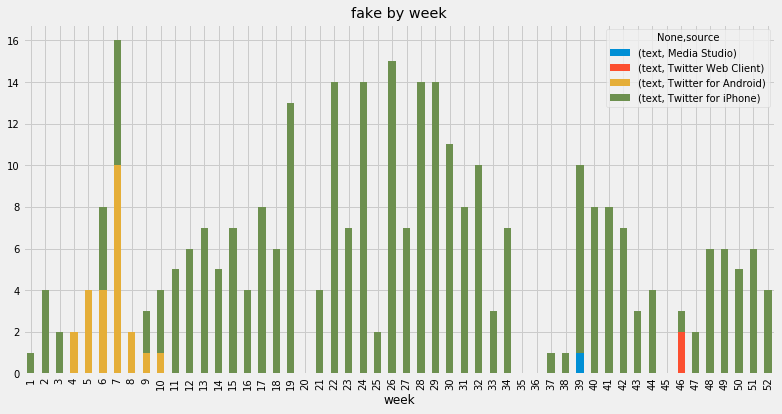

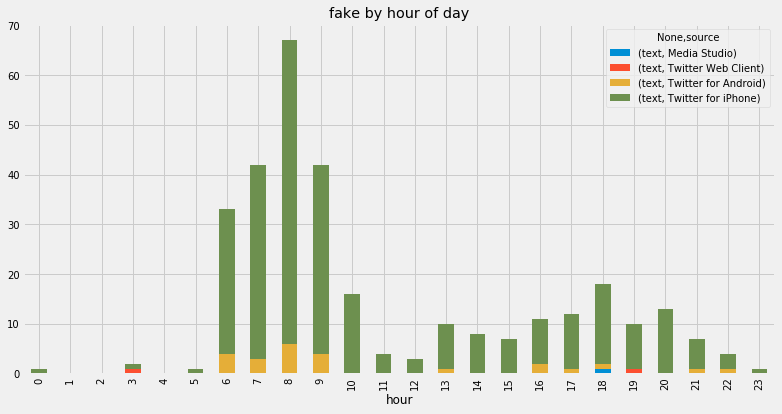

### The Tweets

[Tuesday, Aug 14, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1029335579845115904): Bruce Ohr of the “Justice” Department (can you believe he is still there) is accused of helping disgraced Christopher Steele “find dirt on Trump.” Ohr’s wife, Nelly, was in on the act big time - worked for Fusion GPS on Fake Dossier. @foxandfriends

[Monday, Aug 13, 2018 9:57 PM](https://twitter.com/realDonaldTrump/status/1029185314752000007): ....such wonderful and powerful things about me - a true Champion of Civil Rights - until she got fired. Omarosa had Zero credibility with the Media (they didn’t want interviews) when she worked in the White House. Now that she says bad about me, they will talk to her. Fake News!

[Monday, Aug 13, 2018 10:21 AM](https://twitter.com/realDonaldTrump/status/1029010124881453056): While I know it’s “not presidential” to take on a lowlife like Omarosa, and while I would rather not be doing so, this is a modern day form of communication and I know the Fake News Media will be working overtime to make even Wacky Omarosa look legitimate as possible. Sorry!

[Sunday, Aug 12, 2018 8:24 AM](https://twitter.com/realDonaldTrump/status/1028618150944944129): .@JudgeJeanine  “Bob Mueller, isn’t your whole investigation premised on a Fake Dossier, paid for by Hillary, created by a man who hates Donald Trump, &amp; used to con a FISA Court Judge. Bob, I really think it’s time for you to give up your phony investigation.” No Collusion!

[Saturday, Aug 11, 2018 2:28 PM](https://twitter.com/realDonaldTrump/status/1028347518822825984): The big story that the Fake News Media refuses to report is lowlife Christopher Steele’s many meetings with Deputy A.G. Bruce Ohr and his beautiful wife, Nelly. It was Fusion GPS that hired Steele to write the phony &amp; discredited Dossier, paid for by Crooked Hillary &amp; the DNC....

[Wednesday, Aug 8, 2018 11:14 AM](https://twitter.com/realDonaldTrump/status/1027211440225243137): The Republicans have now won 8 out of 9 House Seats, yet if you listen to the Fake News Media you would think we are being clobbered. Why can’t they play it straight, so unfair to the Republican Party and in particular, your favorite President!

[Sunday, Aug 5, 2018 8:49 AM](https://twitter.com/realDonaldTrump/status/1026087766071947265): Too bad a large portion of the Media refuses to report the lies and corruption having to do with the Rigged Witch Hunt - but that is why we call them FAKE NEWS!

[Sunday, Aug 5, 2018 8:45 AM](https://twitter.com/realDonaldTrump/status/1026086905539174400): ...Why aren’t Mueller and the 17 Angry Democrats looking at the meetings concerning the Fake Dossier and all of the lying that went on in the FBI and DOJ? This is the most one sided Witch Hunt in the history of our country. Fortunately, the facts are all coming out, and fast!

[Sunday, Aug 5, 2018 8:35 AM](https://twitter.com/realDonaldTrump/status/1026084333315153924): Fake News reporting, a complete fabrication, that I am concerned about the meeting my wonderful son, Donald, had in Trump Tower. This was a meeting to get information on an opponent, totally legal and done all the time in politics - and it went nowhere. I did not know about it!

[Sunday, Aug 5, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1026069857589227520): The Fake News hates me saying that they are the Enemy of the People only because they know it’s TRUE. I am providing a great service by explaining this to the American People. They purposely cause great division &amp; distrust. They can also cause War! They are very dangerous &amp; sick!

[Thursday, Aug 2, 2018 4:24 PM](https://twitter.com/realDonaldTrump/status/1025115155632455680): They asked my daughter Ivanka whether or not the media is the enemy of the people. She correctly said no. It is the FAKE NEWS, which is a large percentage of the media, that is the enemy of the people!

[Thursday, Aug 2, 2018 7:04 AM](https://twitter.com/realDonaldTrump/status/1024974107337781248): Wow, @foxandfriends is blowing away the competition in the morning ratings. Morning Joe is a dead show with very few people watching and sadly, Fake News CNN is also doing poorly. Too much hate and inaccurately reported stories - too predictable!

[Tuesday, Jul 31, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/1024287257975566338): The Fake News Media is going CRAZY! They are totally unhinged and in many ways, after witnessing first hand the damage they do to so many innocent and decent people, I enjoy watching. In 7 years, when I am no longer in office, their ratings will dry up and they will be gone!

[Sunday, Jul 29, 2018 8:30 AM](https://twitter.com/realDonaldTrump/status/1023546197129224192): Had a very good and interesting meeting at the White House with A.G. Sulzberger, Publisher of the New York Times. Spent much time talking about the vast amounts of Fake News being put out by the media &amp; how that Fake News has morphed into phrase, “Enemy of the People.” Sad!

[Sunday, Jul 29, 2018 7:59 AM](https://twitter.com/realDonaldTrump/status/1023538486081662976): RT @realDonaldTrump: Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almos…

[Sunday, Jul 29, 2018 7:52 AM](https://twitter.com/realDonaldTrump/status/1023536822901776384): Do you think the Fake News Media will ever report on this tweet from Michael? https://t.co/kXLCKZO5Fr

[Friday, Jul 27, 2018 6:45 PM](https://twitter.com/realDonaldTrump/status/1022976410745495552): Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almost totally on their side!

[Friday, Jul 27, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1022808452677160960): ....,the only Collusion with Russia was with the Democrats, so now they are looking at my Tweets (along with 53 million other people) - the rigged Witch Hunt continues! How stupid and unfair to our Country....And so the Fake News doesn’t waste my time with dumb questions, NO,....

[Tuesday, Jul 24, 2018 8:39 PM](https://twitter.com/realDonaldTrump/status/1021917767467982854): So sad and unfair that the FCC wouldn’t approve the Sinclair Broadcast merger with Tribune. This would have been a great and much needed Conservative voice for and of the People. Liberal Fake News NBC and Comcast gets approved, much bigger, but not Sinclair. Disgraceful!

[Monday, Jul 23, 2018 9:06 AM](https://twitter.com/realDonaldTrump/status/1021380986452545537): A Rocket has not been launched by North Korea in 9 months. Likewise, no Nuclear Tests. Japan is happy, all of Asia is happy. But the Fake News is saying, without ever asking me (always anonymous sources), that I am angry because it is not going fast enough. Wrong, very happy!

[Monday, Jul 23, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/1021370601863294977): When you hear the Fake News talking negatively about my meeting with President Putin, and all that I gave up, remember, I gave up NOTHING, we merely talked about future benefits for both countries. Also, we got along very well, which is a good thing, except for the Corrupt Media!

[Monday, Jul 23, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/1021341698734030848): So we now find out that it was indeed the unverified and Fake Dirty Dossier, that was paid for by Crooked Hillary Clinton and the DNC, that was knowingly &amp; falsely submitted to FISA and which was responsible for starting the totally conflicted and discredited Mueller Witch Hunt!

[Sunday, Jul 22, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1021020863733420032): I had a GREAT meeting with Putin and the Fake News used every bit of their energy to try and disparage it. So bad for our country!

[Sunday, Jul 22, 2018 8:56 AM](https://twitter.com/realDonaldTrump/status/1021016070134648833): .@PeteHegseth on @FoxNews  “Source #1 was the (Fake) Dossier. Yes, the Dirty Dossier, paid for by Democrats as a hit piece against Trump, and looking for information that could discredit Candidate #1 Trump. Carter Page was just the foot to surveil the Trump campaign...” ILLEGAL!

[Friday, Jul 20, 2018 5:50 PM](https://twitter.com/realDonaldTrump/status/1020425741664751616): I got severely criticized by the Fake News Media for being too nice to President Putin. In the Old Days they would call it Diplomacy. If I was loud &amp; vicious, I would have been criticized for being too tough. Remember when they said I was too tough with Chairman Kim? Hypocrites!

[Friday, Jul 20, 2018 10:39 AM](https://twitter.com/realDonaldTrump/status/1020317159828992000): RT @realDonaldTrump: The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forw…

[Friday, Jul 20, 2018 10:35 AM](https://twitter.com/realDonaldTrump/status/1020316392548196354): RT @realDonaldTrump: Will the Dems and Fake News ever learn? This is classic! https://t.co/kSX3ROI4QG

[Thursday, Jul 19, 2018 2:14 PM](https://twitter.com/realDonaldTrump/status/1020008975922810883): Will the Dems and Fake News ever learn? This is classic! https://t.co/kSX3ROI4QG

[Thursday, Jul 19, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1019936133147516929): The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........

[Thursday, Jul 19, 2018 7:13 AM](https://twitter.com/realDonaldTrump/status/1019903123312308224): “Trump recognized Russian Meddling MANY TIMES.” Thank you to @foxandfriends and @FoxNews for actually showing the clips. The Fake News wants no part of that narrative! Too bad they don’t want to focus on all of the ECONOMIC and JOBS records being set.

[Thursday, Jul 19, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1019899507910283264): The Fake News Media wants so badly to see a major confrontation with Russia, even a confrontation that could lead to war. They are pushing so recklessly hard and hate the fact that I’ll probably have a good relationship with Putin. We are doing MUCH better than any other country!

[Thursday, Jul 19, 2018 6:37 AM](https://twitter.com/realDonaldTrump/status/1019894101116948480): The Fake News Media is going Crazy! They make up stories without any backup, sources or proof. Many of the stories written about me, and the good people surrounding me, are total fiction. Problem is, when you complain you just give them more publicity. But I’ll complain anyway!

[Tuesday, Jul 17, 2018 8:21 PM](https://twitter.com/realDonaldTrump/status/1019376680572456960): The meeting between President Putin and myself was a great success, except in the Fake News Media!

[Tuesday, Jul 17, 2018 10:22 AM](https://twitter.com/realDonaldTrump/status/1019225830298456066): While I had a great meeting with NATO, raising vast amounts of money, I had an even better meeting with Vladimir Putin of Russia. Sadly, it is not being reported that way - the Fake News is going Crazy!

[Sunday, Jul 15, 2018 12:11 PM](https://twitter.com/realDonaldTrump/status/1018528420093878272): There hasn’t been a missile or rocket fired in 9 months in North Korea, there have been no nuclear tests and we got back our hostages. Who knows how it will all turn out in the end, but why isn’t the Fake News talking about these wonderful facts? Because it is FAKE NEWS!

[Saturday, Jul 14, 2018 2:17 PM](https://twitter.com/realDonaldTrump/status/1018197842559725569): These Russian individuals did their work during the Obama years. Why didn’t Obama do something about it?  Because he thought Crooked Hillary Clinton would win, that’s why. Had nothing to do with the Trump Administration, but Fake News doesn’t want to report the truth, as usual!

[Saturday, Jul 14, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/1018093807060045824): So funny! I just checked out Fake News CNN, for the first time in a long time (they are dying in the ratings), to see if they covered my takedown yesterday of Jim Acosta (actually a nice guy). They didn’t! But they did say I already lost in my meeting with Putin. Fake News......

[Monday, Jul 9, 2018 1:04 PM](https://twitter.com/realDonaldTrump/status/1016367395294908421): The failing NY Times Fake News story today about breast feeding must be called out. The U.S. strongly supports breast feeding but we don’t believe women should be denied access to formula. Many women need this option because of malnutrition and poverty.

[Saturday, Jul 7, 2018 9:21 AM](https://twitter.com/realDonaldTrump/status/1015586529484443648): Twitter is getting rid of fake accounts at a record pace. Will that include the Failing New York Times and propaganda machine for Amazon, the Washington Post, who constantly quote anonymous sources that, in my opinion, don’t exist - They will both be out of business in 7 years!

[Tuesday, Jul 3, 2018 7:13 PM](https://twitter.com/realDonaldTrump/status/1014286054805987330): After having written many best selling books, and somewhat priding myself on my ability to write, it should be noted that the Fake News constantly likes to pore over my tweets looking for a mistake. I capitalize certain words only for emphasis, not b/c they should be capitalized!

[Tuesday, Jul 3, 2018 5:19 PM](https://twitter.com/realDonaldTrump/status/1014257237945176071): After having written many best selling books, and somewhat priding myself on my ability to write, it should be noted that the Fake News constantly likes to pour over my tweets looking for a mistake. I capitalize certain words only for emphasis, not b/c they should be capitalized!

[Tuesday, Jul 3, 2018 7:16 AM](https://twitter.com/realDonaldTrump/status/1014105549624037377): Many good conversations with North Korea-it is going well! In the meantime, no Rocket Launches or Nuclear Testing in 8 months. All of Asia is thrilled. Only the Opposition Party, which includes the Fake News, is complaining. If not for me, we would now be at War with North Korea!

[Monday, Jun 25, 2018 8:36 AM](https://twitter.com/realDonaldTrump/status/1011226622324887556): Such a difference in the media coverage of the same immigration policies between the Obama Administration and ours. Actually, we have done a far better job in that our facilities are cleaner and better run than were the facilities under Obama. Fake News is working overtime!

[Saturday, Jun 23, 2018 8:52 AM](https://twitter.com/realDonaldTrump/status/1010505990259855361): Drudge Report  “OBAMA KEPT THEM IN CAGES, WRAPPED THEM IN FOIL” We do a much better job while at the same time maintaining a MUCH stronger Border! Mainstream Fake Media hates this story.

[Thursday, Jun 21, 2018 5:51 PM](https://twitter.com/realDonaldTrump/status/1009916650622251009): “I REALLY DON’T CARE, DO U?” written on the back of Melania’s jacket, refers to the Fake News Media. Melania has learned how dishonest they are, and she truly no longer cares!

[Wednesday, Jun 20, 2018 4:34 PM](https://twitter.com/realDonaldTrump/status/1009534957440516096): Look what Fake ABC News put out. I guess they had it prepared from the 13 Angry Democrats leading the Witch Hunt! #StopTheBias https://t.co/c0XOk1btEQ

[Wednesday, Jun 20, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/1009435777992884227): “FBI texts have revealed anti-Trump Bias.” @FoxNews  Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!

[Wednesday, Jun 20, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/1009411866475532288): The Fake News is not mentioning the safety and security of our Country when talking about illegal immigration. Our immigration laws are the weakest and worst anywhere in the world, and the Dems will do anything not to change them &amp; to obstruct-want open borders which means crime!

[Monday, Jun 18, 2018 10:57 AM](https://twitter.com/realDonaldTrump/status/1008725438972211200): If President Obama (who got nowhere with North Korea and would have had to go to war with many millions of people being killed) had gotten along with North Korea and made the initial steps toward a deal that I have, the Fake News would have named him a national hero!

[Sunday, Jun 17, 2018 8:25 PM](https://twitter.com/realDonaldTrump/status/1008506045373845504): Why was the FBI giving so much information to the Fake News Media. They are not supposed to be doing that, and knowing the enemy of the people Fake News, they put their own spin on it - truth doesn’t matter to them!

[Sunday, Jun 17, 2018 9:26 AM](https://twitter.com/realDonaldTrump/status/1008340100877570048): Washington Post employees want to go on strike because Bezos isn’t paying them enough. I think a really long strike would be a great idea. Employees would get more money and we would get rid of Fake News for an extended period of time! Is @WaPo a registered lobbyist?

[Sunday, Jun 17, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1008328413210398720): Funny how the Fake News, in a coordinated effort with each other, likes to say I gave sooo much to North Korea because I “met.” That’s because that’s all they have to disparage! We got so much for peace in the world, &amp; more is being added in finals. Even got our hostages/remains!

[Sunday, Jun 17, 2018 7:58 AM](https://twitter.com/realDonaldTrump/status/1008317842264088576): Please clear up the Fake News! https://t.co/3VbIKbmKwP

[Friday, Jun 15, 2018 6:23 PM](https://twitter.com/realDonaldTrump/status/1007750530976927744): The Fake News Media said that I did not get along with other Leaders at the #G7Summit in Canada. They are once again, WRONG! https://t.co/I6eEKEZV6z

[Friday, Jun 15, 2018 6:03 PM](https://twitter.com/realDonaldTrump/status/1007745343306584064): I have a great relationship with Angela Merkel of Germany, but the Fake News Media only shows the bad photos (implying anger) of negotiating an agreement - where I am asking for things that no other American President would ask for! https://t.co/Ib97nN5HZt

[Friday, Jun 15, 2018 1:49 PM](https://twitter.com/realDonaldTrump/status/1007681553676283904): I’ve had to beat 17 very talented people including the Bush Dynasty, then I had to beat the Clinton Dynasty, and now I have to beat a phony Witch Hunt and all of the dishonest people covered in the IG Report...and never forget the Fake News Media. It never ends!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278701996802048): So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, illegally leak (Comey) classified information so that a Special Councel will be appointed, and then Collude to make this pile of garbage take on life in Fake News!

[Wednesday, Jun 13, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/1006891643985854464): So funny to watch the Fake News, especially NBC and CNN. They are fighting hard to downplay the deal with North Korea. 500 days ago they would have “begged” for this deal-looked like war would break out. Our Country’s biggest enemy is the Fake News so easily promulgated by fools!

[Wednesday, Jun 6, 2018 10:04 AM](https://twitter.com/realDonaldTrump/status/1004363400674234368): Many more Republican voters showed up yesterday than the Fake News thought possible. The political pundits just don’t get what is going on out there - or they do get it but refuse to report the facts! Remember, Dems are High Tax, High Crime, easy to beat!

[Wednesday, Jun 6, 2018 9:54 AM](https://twitter.com/realDonaldTrump/status/1004360833407815680): ...Four reporters spotted Melania in the White House last week walking merrily along to a meeting. They never reported the sighting because it would hurt the sick narrative that she was living in a different part of the world, was really ill, or whatever. Fake News is really bad!

[Wednesday, Jun 6, 2018 9:48 AM](https://twitter.com/realDonaldTrump/status/1004359335399641089): The Fake News Media has been so unfair, and vicious, to my wife and our great First Lady, Melania. During her recovery from surgery they reported everything from near death, to facelift, to left the W.H. (and me) for N.Y. or Virginia, to abuse. All Fake, she is doing really well!

[Wednesday, Jun 6, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/1004351340041199616): Great night for Republicans! Congratulations to John Cox on a really big number in California. He can win. Even Fake News CNN said the Trump impact was really big, much bigger than they ever thought possible. So much for the big Blue Wave, it may be a big Red Wave. Working hard!

[Tuesday, Jun 5, 2018 8:43 PM](https://twitter.com/realDonaldTrump/status/1004161816501673985): RT @parscale: Since the #FakeNews is full of distortions, underreporting, and lies, we launched a platform tonight presenting a comprehensi…

[Monday, Jun 4, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/1003738642903420928): The Fake News Media is desperate to distract from the economy and record setting economic numbers and so they keep talking about the phony Russian Witch Hunt.

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 12:46 PM](https://twitter.com/realDonaldTrump/status/1002954515941941249): Real @FoxNews is doing great, Fake News CNN is dead! https://t.co/1p37tPiB3v

[Tuesday, May 29, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/1001455721588969472): The Fake Mainstream Media has, from the time I announced I was running for President, run the most highly sophisticated &amp; dishonest Disinformation Campaign in the history of politics. No matter how well WE do, they find fault. But the forgotten men &amp; women WON, I’m President!

[Friday, May 18, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/997474432443707393): Reports are there was indeed at least one FBI representative implanted, for political purposes, into my campaign for president. It took place very early on, and long before the phony Russia Hoax became a “hot” Fake News story. If true - all time biggest political scandal!

[Friday, May 18, 2018 6:51 AM](https://twitter.com/realDonaldTrump/status/997429518867591170): Fake News Media had me calling Immigrants, or Illegal Immigrants, “Animals.” Wrong! They were begrudgingly forced to withdraw their stories. I referred to MS 13 Gang Members as “Animals,” a big difference - and so true. Fake News got it purposely wrong, as usual!

[Thursday, May 17, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/997112687799697408): Despite the disgusting, illegal and unwarranted Witch Hunt, we have had the most successful first 17 month Administration in U.S. history - by far! Sorry to the Fake News Media and “Haters,” but that’s the way it is!

[Tuesday, May 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/996391840860471296): Can you believe that with all of the made up, unsourced stories I get from the Fake News Media, together with the  $10,000,000 Russian Witch Hunt (there is no Collusion), I now have my best Poll Numbers in a year. Much of the Media may be corrupt, but the People truly get it!

[Monday, May 14, 2018 4:46 PM](https://twitter.com/realDonaldTrump/status/996129630913482755): The so-called leaks coming out of the White House are a massive over  exaggeration put out by the Fake News Media in order to make us look as bad as possible. With that being said, leakers are traitors and cowards, and we will find out who they are!

[Friday, May 11, 2018 7:49 PM](https://twitter.com/realDonaldTrump/status/995088584221839360): Why doesn’t the Fake News Media state that the Trump Administration’s Anti-Trust Division has been, and is, opposed to the AT&amp;T purchase of Time Warner in a currently ongoing Trial. Such a disgrace in reporting!

[Wednesday, May 9, 2018 6:38 PM](https://twitter.com/realDonaldTrump/status/994345813064192012): The Failing New York Times criticized Secretary of State Pompeo for being AWOL (missing), when in fact he was flying to North Korea. Fake News, so bad!

[Wednesday, May 9, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/994179864436596736): The Fake News is working overtime. Just reported that, despite the tremendous success we are having with the economy &amp; all things else, 91% of the Network News about me is negative (Fake). Why do we work so hard in working with the media when it is corrupt? Take away credentials?

[Friday, May 4, 2018 6:45 AM](https://twitter.com/realDonaldTrump/status/992354530510721025): NBC NEWS is wrong again! They cite “sources” which are constantly wrong. Problem is, like so many others, the sources probably don’t exist, they are fabricated, fiction! NBC, my former home with the Apprentice, is now as bad as Fake News CNN. Sad!

[Monday, Apr 30, 2018 7:02 PM](https://twitter.com/realDonaldTrump/status/991090373417152515): The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina, both necessary to get things done. We are accomplishing the unthinkable and setting positive records while doing so! Fake News is going “bonkers!”

[Monday, Apr 30, 2018 6:49 PM](https://twitter.com/realDonaldTrump/status/991087278515769345): The Fake News is going crazy making up false stories and using only unnamed sources (who don’t exist). They are totally unhinged, and the great success of this Administration is making them do and say things that even they can’t believe they are saying. Truly bad people!

[Monday, Apr 30, 2018 8:10 AM](https://twitter.com/realDonaldTrump/status/990926480329859073): The White House Correspondents’ Dinner is DEAD as we know it. This was a total disaster and an embarrassment to our great Country and all that it stands for. FAKE NEWS is alive and well and beautifully represented on Saturday night!

[Saturday, Apr 28, 2018 8:58 AM](https://twitter.com/realDonaldTrump/status/990213619190202369): “Clapper lied about (fraudulent) Dossier leaks to CNN” @foxandfriends FoxNews  He is a lying machine who now works for Fake News CNN.

[Sunday, Apr 22, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/988037292932653056): Sleepy Eyes Chuck Todd of Fake News NBC just stated that we have given up so much in our negotiations with North Korea, and they have given up nothing. Wow, we haven’t given up anything &amp; they have agreed to denuclearization (so great for World), site closure, &amp; no more testing!

[Saturday, Apr 21, 2018 4:13 PM](https://twitter.com/realDonaldTrump/status/987786331995672576): The Washington Post said I refer to Jeff Sessions as “Mr. Magoo” and Rod Rosenstein as “Mr. Peepers.” This is “according to people with whom the president has spoken.” There are no such people and don’t know these characters...just more Fake &amp; Disgusting News to create ill will!

[Friday, Apr 20, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/987426984195174405): Can you believe that despite 93% bad stories from the Fake News Media (should be getting good stories), today we had just about our highest Poll Numbers, including those on Election Day? The American public is wise to the phony an dishonest press. Make America Great Again!

[Wednesday, Apr 18, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/986547093610299392): A sketch years later about a nonexistent man. A total con job, playing the Fake News Media for Fools (but they know it)! https://t.co/9Is7mHBFda

[Tuesday, Apr 17, 2018 1:59 PM](https://twitter.com/realDonaldTrump/status/986303188587425794): Rasmussen just came out at 51% Approval despite the Fake News Media. They were one of the three most accurate on Election Day. Just about the most inaccurate were CNN and ABC News/Washington Post, and they haven’t changed (get new pollsters). Much of the media is a Scam!

[Sunday, Apr 15, 2018 10:44 AM](https://twitter.com/realDonaldTrump/status/985529299905187840): Just hit 50% in the Rasmussen Poll, much higher than President Obama at same point. With all of the phony stories and Fake News, it’s hard to believe! Thank you America, we are doing Great Things.

[Sunday, Apr 15, 2018 8:32 AM](https://twitter.com/realDonaldTrump/status/985496023555608576): I never asked Comey for Personal Loyalty. I hardly even knew this guy. Just another of his many lies. His “memos” are self serving and FAKE!

[Sunday, Apr 15, 2018 8:19 AM](https://twitter.com/realDonaldTrump/status/985492862958698497): The Syrian raid was so perfectly carried out, with such precision, that the only way the Fake News Media could demean was by my use of the term “Mission Accomplished.” I knew they would seize on this but felt it is such a great Military term, it should be brought back. Use often!

[Thursday, Apr 12, 2018 6:03 AM](https://twitter.com/realDonaldTrump/status/984371491277099010): If I wanted to fire Robert Mueller in December, as reported by the Failing New York Times, I would have fired him. Just more Fake News from a biased newspaper!

[Wednesday, Apr 11, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/984053549742067712): Much of the bad blood with Russia is caused by the Fake &amp; Corrupt Russia Investigation, headed up by the all Democrat loyalists, or people that worked for Obama. Mueller is most conflicted of all (except Rosenstein who signed FISA &amp; Comey letter). No Collusion, so they go crazy!

[Wednesday, Apr 11, 2018 6:38 AM](https://twitter.com/realDonaldTrump/status/984017894240604161): So much Fake News about what is going on in the White House. Very calm and calculated with a big focus on open and fair trade with China, the coming North Korea meeting and, of course, the vicious gas attack in Syria. Feels great to have Bolton &amp; Larry K on board. I (we) are

[Wednesday, Apr 11, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/984015782521835521): The Failing New York Times wrote another phony story. It was political pundit Doug Schoen, not a Ukrainian businessman, who asked me to do a short speech by phone (Skype), hosted by Doug, in Ukraine. I was very positive about Ukraine-another negative to the Fake Russia  C story!

[Friday, Apr 6, 2018 10:46 AM](https://twitter.com/realDonaldTrump/status/982268230306709509): Do you believe that the Fake News Media is pushing hard on a story that I am going to replace A.G. Jeff Sessions with EPA Chief Scott Pruitt, who is doing a great job but is TOTALLY under siege? Do people really believe this stuff? So much of the media is dishonest and corrupt!

[Thursday, Apr 5, 2018 9:10 AM](https://twitter.com/realDonaldTrump/status/981881669593559040): The Fake News Washington Post, Amazon’s “chief lobbyist,” has another (of many) phony headlines, “Trump Defiant As China Adds Trade Penalties.” WRONG! Should read, “Trump Defiant as U.S. Adds Trade Penalties, Will End Barriers And Massive  I.P. Theft.” Typically bad reporting!

[Tuesday, Apr 3, 2018 6:34 AM](https://twitter.com/realDonaldTrump/status/981117684489379840): The Fake News Networks, those that knowingly have a sick and biased AGENDA, are worried about the competition and quality of Sinclair Broadcast. The “Fakers” at CNN, NBC, ABC &amp; CBS have done so much dishonest reporting that they should only be allowed to get awards for fiction!

[Monday, Apr 2, 2018 9:28 AM](https://twitter.com/realDonaldTrump/status/980799183425802240): So funny to watch Fake News Networks, among the most dishonest groups of people I have ever dealt with, criticize Sinclair Broadcasting for being biased. Sinclair is far superior to CNN and even more Fake NBC, which is a total joke.

[Saturday, Mar 31, 2018 8:52 AM](https://twitter.com/realDonaldTrump/status/980065419632566272): ...does not include the Fake Washington Post, which is used as a “lobbyist” and should so  REGISTER. If the P.O. “increased its parcel rates, Amazon’s shipping costs would rise by $2.6 Billion.” This Post Office scam must stop. Amazon must pay real costs (and taxes) now!

[Monday, Mar 26, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/978249938743234560): So much Fake News. Never been more voluminous or more inaccurate. But through it all, our country is doing great!

[Sunday, Mar 25, 2018 7:40 AM](https://twitter.com/realDonaldTrump/status/977872899792089088): Many lawyers and top law firms want to represent me in the Russia case...don’t believe the Fake News narrative that it is hard to find a lawyer who wants to take this on. Fame &amp; fortune will NEVER be turned down by a lawyer, though some are conflicted. Problem is that a new......

[Wednesday, Mar 21, 2018 2:56 PM](https://twitter.com/realDonaldTrump/status/976532956557737984): I called President Putin of Russia to congratulate him on his election victory (in past, Obama called him also). The Fake News Media is crazed because they wanted me to excoriate him. They are wrong! Getting along with Russia (and others) is a good thing, not a bad thing.......

[Sunday, Mar 18, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/975346628113596417): Spent very little time with Andrew McCabe, but he never took notes when he was with me. I don’t believe he made memos except to help his own agenda, probably at a later date. Same with lying James Comey. Can we call them Fake Memos?

[Saturday, Mar 17, 2018 8:12 PM](https://twitter.com/realDonaldTrump/status/975163071361683456): The Mueller probe should never have been started in that there was no collusion and there was no crime. It was based on fraudulent activities and a Fake Dossier paid for by Crooked Hillary and the DNC, and improperly used in FISA COURT for surveillance of my campaign. WITCH HUNT!

[Saturday, Mar 17, 2018 1:34 PM](https://twitter.com/realDonaldTrump/status/975062797162811394): The Fake News is beside themselves that McCabe was caught, called out and fired. How many hundreds of thousands of dollars was given to wife’s campaign by Crooked H friend, Terry M, who was also under investigation? How many lies? How many leaks? Comey knew it all, and much more!

[Sunday, Mar 11, 2018 11:16 AM](https://twitter.com/realDonaldTrump/status/972853747750711296): Rasmussen and others have my approval ratings at around 50%, which is higher than Obama, and yet the political pundits love saying my approval ratings are “somewhat low.” They know they are lying when they say it. Turn off the show - FAKE NEWS!

[Sunday, Mar 11, 2018 10:02 AM](https://twitter.com/realDonaldTrump/status/972835128056664066): The Republicans are 5-0 in recent Congressional races, a point which the Fake News Media continuously fails to mention. I backed and campaigned for all of the winners. They give me credit for one. Hopefully, Rick Saccone will be another big win on Tuesday.

[Saturday, Mar 10, 2018 3:02 PM](https://twitter.com/realDonaldTrump/status/972563247160274947): In the first hours after hearing that North Korea’s leader wanted to meet with me to talk denuclearization and that missile launches will end, the press was startled &amp; amazed.They couldn’t believe it. But by the following morning the news became FAKE.They said so what, who cares!

[Tuesday, Mar 6, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/971006379375972354): The new Fake News narrative is that there is CHAOS in the White House. Wrong! People will always come &amp; go, and I want strong dialogue before making a final decision. I still have some people that I want to change (always seeking perfection). There is no Chaos, only great Energy!

[Thursday, Feb 22, 2018 8:26 PM](https://twitter.com/realDonaldTrump/status/966846679784837120): “School shooting survivor says he quit @CNN Town Hall after refusing scripted question.” @TuckerCarlson. Just like so much of CNN, Fake News. That’s why their ratings are so bad! MSNBC may be worse.

[Thursday, Feb 22, 2018 7:26 AM](https://twitter.com/realDonaldTrump/status/966650397002813440): I never said “give teachers guns” like was stated on Fake News @CNN &amp; @NBC. What I said was to look at the possibility of giving “concealed guns to gun adept teachers with military or special training experience - only the best. 20% of teachers, a lot, would now be able to

[Tuesday, Feb 20, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/966117265426001920): Bad ratings @CNN &amp; @MSNBC got scammed when they covered the anti-Trump Russia rally wall-to-wall. They probably knew it was Fake News but, because it was a rally against me, they pushed it hard anyway. Two really dishonest newscasters, but the public is wise!

[Tuesday, Feb 20, 2018 10:16 AM](https://twitter.com/realDonaldTrump/status/965968309358333952): A woman I don’t know and, to the best of my knowledge, never met, is on the FRONT PAGE of the Fake News Washington Post saying I kissed her (for two minutes yet) in the lobby of Trump Tower 12 years ago. Never happened! Who would do this in a public space with live security......

[Tuesday, Feb 20, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/965943827931549696): I have been much tougher on Russia than Obama, just look at the facts. Total Fake News!

[Sunday, Feb 18, 2018 8:46 AM](https://twitter.com/realDonaldTrump/status/965221024496279552): The Fake News of big ratings loser CNN. https://t.co/rYsv90cnvs

[Saturday, Feb 17, 2018 3:11 PM](https://twitter.com/realDonaldTrump/status/964955496137535488): The Fake News Media never fails. Hard to ignore this fact from the Vice President of Facebook Ads, Rob Goldman! https://t.co/XGC7ynZwYJ

[Saturday, Feb 17, 2018 2:46 PM](https://twitter.com/realDonaldTrump/status/964949269374529538): Funny how the Fake News Media doesn’t want to say that the Russian group was formed in 2014, long before my run for President. Maybe they knew I was going to run even though I didn’t know!

[Sunday, Feb 11, 2018 1:21 PM](https://twitter.com/realDonaldTrump/status/962753552824365056): So many positive things going on for the U.S.A. and the Fake News Media just doesn’t want to go there. Same negative stories over and over again! No wonder the People no longer trust the media, whose approval ratings are correctly at their lowest levels in history!    #MAGA

[Tuesday, Jan 23, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/955806333667807232): Thank you to General John Kelly, who is doing a fantastic job, and all of the Staff and others in the White House, for a job well done. Long hours and Fake reporting makes your job more difficult, but it is always great to WIN, and few have won more than us!

[Tuesday, Jan 23, 2018 6:31 AM](https://twitter.com/realDonaldTrump/status/955764970590961665): Even Crazy Jim Acosta of Fake News CNN agrees: “Trump World and WH sources dancing in end zone: Trump wins again...Schumer and Dems caved...gambled and lost.” Thank you for your honesty Jim!

[Wednesday, Jan 17, 2018 8:00 PM](https://twitter.com/realDonaldTrump/status/953794085751574534): And the FAKE NEWS winners are...
https://t.co/59G6x2f7fD

[Tuesday, Jan 16, 2018 9:19 AM](https://twitter.com/realDonaldTrump/status/953270558573154305): Do you notice the Fake News Mainstream Media never likes covering the great and record setting economic news, but rather talks about anything negative or that can be turned into the negative. The Russian Collusion Hoax is dead, except as it pertains to the Dems. Public gets it!

[Sunday, Jan 14, 2018 8:04 AM](https://twitter.com/realDonaldTrump/status/952526791658360833): RT @realDonaldTrump: So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They prom…

[Sunday, Jan 14, 2018 8:01 AM](https://twitter.com/realDonaldTrump/status/952526145064505345): ...and they knew exactly what I said and meant. They just wanted a story. FAKE NEWS!

[Saturday, Jan 13, 2018 5:08 PM](https://twitter.com/realDonaldTrump/status/952301373479104512): So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They promote the Fake Book of a mentally deranged author, who knowingly writes false information. The Mainstream Media is crazed that WE won the election!

[Sunday, Dec 31, 2017 5:18 PM](https://twitter.com/realDonaldTrump/status/947592785519173637): As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!

[Saturday, Dec 30, 2017 5:36 PM](https://twitter.com/realDonaldTrump/status/947235015343202304): I use Social Media not because I like to, but because it is the only way to fight a VERY dishonest and unfair “press,” now often referred to as Fake News Media. Phony and non-existent “sources” are being used more often than ever. Many stories &amp; reports a pure fiction!

[Friday, Dec 29, 2017 7:46 AM](https://twitter.com/realDonaldTrump/status/946724075157651457): While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage &amp; Russia hoax!

[Sunday, Dec 24, 2017 3:35 PM](https://twitter.com/realDonaldTrump/status/945030174290186241): The Tax Cut/Reform Bill, including Massive Alaska Drilling and the Repeal of the highly unpopular Individual Mandate, brought it all together as to what an incredible year we had. Don’t let the Fake News convince you otherwise...and our insider Polls are strong!

[Sunday, Dec 24, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/944927689638662145): The Fake News refuses to talk about how Big and how Strong our BASE is. They show Fake Polls just like they report Fake News. Despite only negative reporting, we are doing well - nobody is going to beat us. MAKE AMERICA GREAT AGAIN!

[Saturday, Dec 23, 2017 5:44 PM](https://twitter.com/realDonaldTrump/status/944700332881440769): The Stock Market is setting record after record and unemployment is at a 17 year low. So many things accomplished by the Trump Administration, perhaps more than any other President in first year. Sadly, will never be reported correctly by the Fake News Media!

[Friday, Dec 22, 2017 9:17 AM](https://twitter.com/realDonaldTrump/status/944210183089254400): “The President has accomplished some absolutely historic things during this past year.” Thank you Charlie Kirk of Turning Points USA. Sadly, the Fake Mainstream Media will NEVER talk about our accomplishments in their end of year reviews. We are compiling a long &amp; beautiful list.

[Thursday, Dec 21, 2017 7:45 AM](https://twitter.com/realDonaldTrump/status/943824695144697857): Was @foxandfriends just named the most influential show in news? You deserve it - three great people! The many Fake News Hate Shows should study your formula for success!

[Thursday, Dec 21, 2017 7:24 AM](https://twitter.com/realDonaldTrump/status/943819430735372289): The Massive Tax Cuts, which the Fake News Media is desperate to write badly about so as to please their Democrat bosses, will soon be kicking in and will speak for themselves. Companies are already making big payments to workers. Dems want to raise taxes, hate these big Cuts!

[Wednesday, Dec 20, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/943489378462130176): The Tax Cuts are so large and so meaningful, and yet the Fake News is working overtime to follow the lead of their friends, the defeated Dems, and only demean. This is truly a case where the results will speak for themselves, starting very soon. Jobs, Jobs, Jobs!

[Tuesday, Dec 19, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/943135588496093190): A  story in the @washingtonpost that I was close to “rescinding” the nomination of Justice Gorsuch prior to confirmation is FAKE NEWS. I never even wavered and am very proud of him and the job he is doing as a Justice of the U.S. Supreme Court. The unnamed sources don’t exist!

[Wednesday, Dec 13, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/940930017365778432): Wow, more than 90% of Fake News Media coverage of me is negative, with numerous forced retractions of untrue stories. Hence my use of Social Media, the only way to get the truth out. Much of Mainstream Meadia has become a joke! @foxandfriends

[Tuesday, Dec 12, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/940554567414091776): Despite thousands of hours wasted and many millions of dollars spent, the Democrats have been unable to show any collusion with Russia - so now they are moving on to the false accusations and fabricated stories of women who I don’t know and/or have never met. FAKE NEWS!

[Monday, Dec 11, 2017 9:17 AM](https://twitter.com/realDonaldTrump/status/940223974985871360): Another false story, this time in the Failing @nytimes, that I watch 4-8 hours of television a day - Wrong!  Also, I seldom, if ever, watch CNN or MSNBC, both of which I consider Fake News. I never watch Don Lemon, who I once called the “dumbest man on television!” Bad Reporting.

[Sunday, Dec 10, 2017 4:18 PM](https://twitter.com/realDonaldTrump/status/939967625362276354): Very little discussion of all the purposely false and defamatory stories put out this week by the Fake News Media. They are out of control - correct reporting means nothing to them. Major lies written, then forced to be withdrawn after they are exposed...a stain on America!

[Sunday, Dec 10, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/939849867438034944): Things are going really well for our economy, a subject the Fake News spends as little time as possible discussing! Stock Market hit another RECORD HIGH, unemployment is now at a 17 year low and companies are coming back into the USA. Really good news, and much more to come!

[Saturday, Dec 9, 2017 6:14 PM](https://twitter.com/realDonaldTrump/status/939634404267380736): .@daveweigel of the Washington Post just admitted that his picture was a FAKE (fraud?) showing an almost empty arena last night for my speech in Pensacola when, in fact, he knew the arena was packed (as shown also on T.V.). FAKE NEWS, he should be fired.

[Saturday, Dec 9, 2017 5:01 PM](https://twitter.com/realDonaldTrump/status/939616077356642304): .@DaveWeigel @WashingtonPost put out a phony photo of an empty arena hours before I arrived @ the venue, w/ thousands of people outside, on their way in. Real photos now shown as I spoke. Packed house, many people unable to get in. Demand apology &amp; retraction from FAKE NEWS WaPo! https://t.co/XAblFGh1ob

[Saturday, Dec 9, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/939485131693322240): CNN’S slogan is CNN, THE MOST TRUSTED NAME IN NEWS. Everyone knows this is not true, that this could, in fact, be a fraud on the American Public. There are many outlets that are far more trusted than Fake News CNN. Their slogan should be CNN, THE LEAST TRUSTED NAME IN NEWS!

[Saturday, Dec 9, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/939480342779580416): Fake News CNN made a vicious and purposeful mistake yesterday. They were caught red handed, just like lonely Brian Ross at ABC News (who should be immediately fired for his “mistake”). Watch to see if @CNN fires those responsible, or was it just gross incompetence?

[Sunday, Dec 3, 2017 6:15 AM](https://twitter.com/realDonaldTrump/status/937279001684598784): I never asked Comey to stop investigating Flynn. Just more Fake News covering another Comey lie!

[Saturday, Dec 2, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/937145025359761408): Congratulations to @ABC News for suspending Brian Ross for his horrendously inaccurate and dishonest report on the Russia, Russia, Russia Witch Hunt. More Networks and “papers” should do the same with their Fake News!

[Friday, Dec 1, 2017 3:08 PM](https://twitter.com/realDonaldTrump/status/936688444046266368): The media has been speculating that I fired Rex Tillerson or that he would be leaving soon - FAKE NEWS! He’s not leaving and while we disagree on certain subjects, (I call the final shots) we work well together and America is highly respected again!
https://t.co/FrqiPLFJ1E

[Wednesday, Nov 29, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/935874566701842434): So now that Matt Lauer is gone when will the Fake News practitioners at NBC be terminating the contract of Phil Griffin? And will they terminate low ratings Joe Scarborough based on the “unsolved mystery” that took place in Florida years ago? Investigate!

[Wednesday, Nov 29, 2017 8:58 AM](https://twitter.com/realDonaldTrump/status/935870484146683904): So now tha Matt Lauer is gone when will the Fake News practitioners at NBC be terminating the contract of Phil Griffin? And will they terminate low ratings Joe Scarborough based on the “unsolved mystery” that took place in Florida years ago? Investigate!

[Wednesday, Nov 29, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/935844881825763328): Wow, Matt Lauer was just fired from NBC for “inappropriate sexual behavior in the workplace.” But when will the top executives at NBC &amp; Comcast be fired for putting out so much Fake News. Check out Andy Lack’s past!

[Wednesday, Nov 29, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/935838073618870272): Great, and we should boycott Fake News CNN. Dealing with them is a total waste of time! https://t.co/8zJ3j7g5el

[Monday, Nov 27, 2017 9:04 AM](https://twitter.com/realDonaldTrump/status/935147410472480769): We should have a contest as to which of the Networks, plus CNN and not including Fox, is the most dishonest, corrupt and/or distorted in its political coverage of your favorite President (me). They are all bad. Winner to receive the FAKE NEWS TROPHY!

[Saturday, Nov 25, 2017 6:25 PM](https://twitter.com/realDonaldTrump/status/934563828834164739): Wow, even I didn’t realize we did so much. Wish the Fake News would report! Thank you. https://t.co/ApVbu2b0Jd

[Saturday, Nov 25, 2017 5:37 PM](https://twitter.com/realDonaldTrump/status/934551607596986368): .@FoxNews is MUCH more important in the United States than CNN, but outside of the U.S., CNN International is still a major source of (Fake) news, and they represent our Nation to the WORLD very poorly. The outside world does not see the truth from them!

[Wednesday, Nov 15, 2017 5:45 AM](https://twitter.com/realDonaldTrump/status/930748627642998784): While in the Philippines I was forced to watch @CNN, which I have not done in months, and again realized how bad, and FAKE, it is. Loser!

[Tuesday, Nov 14, 2017 3:07 AM](https://twitter.com/realDonaldTrump/status/930346433177378817): One of the most accurate polls last time around. But #FakeNews likes to say we’re in the 30’s. They are wrong. Some people think numbers could be in the 50's. Together, WE will MAKE AMERICA GREAT AGAIN! https://t.co/YhrwkdObhP

[Saturday, Nov 11, 2017 7:43 PM](https://twitter.com/realDonaldTrump/status/929509950811881472): Does the Fake News Media remember when Crooked Hillary Clinton, as Secretary of State, was begging Russia to be our friend with the misspelled reset button? Obama tried also, but he had zero chemistry with Putin.

[Friday, Nov 3, 2017 12:09 PM](https://twitter.com/realDonaldTrump/status/926481563214376961): The rigged Dem Primary, one of the biggest political stories in years, got ZERO coverage on Fake News Network TV last night. Disgraceful!

[Tuesday, Oct 31, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/925364408364171265): ....earth shattering. He and his brother could Drain The Swamp, which would be yet another campaign promise fulfilled. Fake News weak!

[Tuesday, Oct 31, 2017 8:09 AM](https://twitter.com/realDonaldTrump/status/925333956110757888): The Fake News is working overtime. As Paul Manaforts lawyer said, there was "no collusion" and events mentioned took place long before he...

[Sunday, Oct 29, 2017 9:53 AM](https://twitter.com/realDonaldTrump/status/924635359480303616): Never seen such Republican ANGER &amp; UNITY as I have concerning the lack of investigation on Clinton made Fake Dossier (now $12,000,000?),....

[Saturday, Oct 28, 2017 8:28 AM](https://twitter.com/realDonaldTrump/status/924251519121346560): Just read the nice remarks by President Jimmy Carter about me and how badly I am treated by the press (Fake News). Thank you Mr. President!

[Wednesday, Oct 25, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/923147501418446849): "Clinton campaign &amp; DNC paid for research that led to the anti-Trump Fake News Dossier. The victim here is the President." @FoxNews

[Sunday, Oct 22, 2017 8:08 AM](https://twitter.com/realDonaldTrump/status/922072236592435200): It is finally sinking through. 46% OF PEOPLE BELIEVE MAJOR NATIONAL NEWS ORGS FABRICATE STORIES ABOUT ME. FAKE NEWS, even worse! Lost cred.

[Saturday, Oct 21, 2017 4:06 PM](https://twitter.com/realDonaldTrump/status/921829947093733376): Keep hearing about "tiny" amount of money spent on Facebook ads. What about the billions of dollars of Fake News on CNN, ABC, NBC &amp; CBS?

[Saturday, Oct 21, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/921726400922619904): Stock Market hits another all time high on Friday. 5.3 trillion dollars up since Election. Fake News doesn't spent much time on this!

[Saturday, Oct 21, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/921709468055896064): I hope the Fake News Media keeps talking about Wacky Congresswoman Wilson in that she, as a representative, is killing the Democrat Party!

[Thursday, Oct 19, 2017 10:53 PM](https://twitter.com/realDonaldTrump/status/921207772233990144): The Fake News is going crazy with wacky Congresswoman Wilson(D), who was SECRETLY on a very personal call, and gave a total lie on content!

[Thursday, Oct 19, 2017 7:56 AM](https://twitter.com/realDonaldTrump/status/920981920787386368): Workers of firm involved with the discredited and Fake Dossier take the 5th. Who paid for it, Russia, the FBI or the Dems (or all)?

[Thursday, Oct 19, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/920972261032648705): Uranium deal to Russia, with Clinton help and Obama Administration knowledge, is the biggest story that Fake Media doesn't want to follow!

[Tuesday, Oct 17, 2017 5:51 PM](https://twitter.com/realDonaldTrump/status/920406959320371200): So much Fake News being put in dying magazines and newspapers. Only place worse may be @NBCNews, @CBSNews, @ABC and @CNN. Fiction writers!

[Friday, Oct 13, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/918796079243677696): Sadly, they and others are Fake News, and the public is just beginning to figure it out! https://t.co/8B8AyA7V1s

[Thursday, Oct 12, 2017 8:12 PM](https://twitter.com/realDonaldTrump/status/918630610167529472): People are just now starting to find out how dishonest and disgusting (FakeNews) @NBCNews is. Viewers beware. May be worse than even @CNN!

[Thursday, Oct 12, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/918457595618365441): The Fake News Is going all out in order to demean and denigrate! Such hatred!

[Wednesday, Oct 11, 2017 8:09 PM](https://twitter.com/realDonaldTrump/status/918267396493922304): Network news has become so partisan, distorted and fake that licenses must be challenged and, if appropriate, revoked. Not fair to public!

[Wednesday, Oct 11, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/918112884630093825): With all of the Fake News coming out of NBC and the Networks, at what point is it appropriate to challenge their License? Bad for country!

[Wednesday, Oct 11, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/918110279367643137): Fake @NBCNews made up a story that I wanted a "tenfold" increase in our U.S. nuclear arsenal. Pure fiction, made up to demean. NBC = CNN!

[Wednesday, Oct 11, 2017 6:31 AM](https://twitter.com/realDonaldTrump/status/918061437750267904): It would be really nice if the Fake News Media would report the virtually unprecedented Stock Market growth since the election.Need tax cuts

[Tuesday, Oct 10, 2017 9:15 PM](https://twitter.com/realDonaldTrump/status/917921548677328896): The Fake News is at it again, this time trying to hurt one of the finest people I know, General John Kelly, by saying he will soon be.....

[Thursday, Oct 5, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/915907150333009920): Rex Tillerson never threatened to resign. This is Fake News put out by @NBCNews. Low news and reporting standards. No verification from me.

[Thursday, Oct 5, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/915894251967385600): Why Isn't the Senate Intel Committee looking into the Fake News Networks in OUR country to see why so much of our news is just made up-FAKE!

[Thursday, Oct 5, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/915886953194770433): RT @FoxNews: Geraldo Blasts 'Fake News' Reports About Trump's Visit to Puerto Rico https://t.co/9jO0D3BMvE

[Wednesday, Oct 4, 2017 11:18 AM](https://twitter.com/realDonaldTrump/status/915596990674849792): The @NBCNews story has just been totally refuted by Sec. Tillerson and @VP Pence. It is #FakeNews. They should issue an apology to AMERICA!

[Wednesday, Oct 4, 2017 10:47 AM](https://twitter.com/realDonaldTrump/status/915589297096536065): NBC news is #FakeNews and more dishonest than even CNN. They are a disgrace to good reporting. No wonder their news ratings are way down!

[Wednesday, Oct 4, 2017 7:29 AM](https://twitter.com/realDonaldTrump/status/915539424406114304): Wow, so many Fake News stories today. No matter what I do or say, they will not write or speak truth. The Fake News Media is out of control!

[Wednesday, Oct 4, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/915523382686478337): A great day in Puerto Rico yesterday. While some of the news coverage is Fake, most showed great warmth and friendship.

[Sunday, Oct 1, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/914465475777695744): We have done a great job with the almost impossible situation in Puerto Rico. Outside of the Fake News or politically motivated ingrates,...

[Saturday, Sep 30, 2017 7:24 PM](https://twitter.com/realDonaldTrump/status/914269704440737792): In analyzing the Alabama Primary race,FAKE NEWS always fails to mention that the candidate I endorsed went up MANY points after endorsement!

[Saturday, Sep 30, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/914267744345972737): In analyzing the Alabama Primary race, Fake News always fails to mention that the candidate I endorsed went up MANY points after Election!

[Saturday, Sep 30, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/914260261304860672): Because of #FakeNews my people are not getting the credit they deserve for doing a great job. As seen here, they are ALL doing a GREAT JOB! https://t.co/1ltW2t3rwy

[Saturday, Sep 30, 2017 3:56 PM](https://twitter.com/realDonaldTrump/status/914217477495717889): @ricardorossello ......#FakeNews critics are working overtime, but we're getting great marks from the people that truly matter! 
#PRStrong🇵🇷

[Saturday, Sep 30, 2017 3:53 PM](https://twitter.com/realDonaldTrump/status/914216744385904640): To the people of Puerto Rico:
Do not believe the #FakeNews!
#PRStrong🇵🇷

[Saturday, Sep 30, 2017 2:04 PM](https://twitter.com/realDonaldTrump/status/914189344533024768): Despite the Fake News Media in conjunction with the Dems, an amazing job is being done in Puerto Rico. Great people!

[Saturday, Sep 30, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/914099295963553792): The Fake News Networks are working overtime in Puerto Rico doing their best to take the spirit away from our soldiers and first R's. Shame!

[Saturday, Sep 30, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/914094625488502784): Fake News CNN and NBC are going out of their way to disparage our great First Responders as a way to "get Trump." Not fair to FR or effort!

[Wednesday, Sep 27, 2017 9:36 AM](https://twitter.com/realDonaldTrump/status/913034591879024640): Facebook was always anti-Trump.The Networks were always anti-Trump hence,Fake News, @nytimes(apologized) &amp; @WaPo were anti-Trump. Collusion?

[Monday, Sep 25, 2017 6:26 PM](https://twitter.com/realDonaldTrump/status/912443217227976704): .@CNN is #FakeNews. Just reported COS (John Kelly) was opposed to my stance on NFL players disrespecting FLAG, ANTHEM, COUNTRY. Total lie!

[Friday, Sep 22, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/911189860769255424): The greatest influence over our election was the Fake News Media "screaming" for Crooked Hillary Clinton. Next, she was a bad candidate!

[Tuesday, Sep 12, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/907588803161939968): Fascinating to watch people writing books and major articles about me and yet they know nothing about me &amp; have zero access. #FAKE NEWS!

[Friday, Aug 25, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/901031532164468736): General John Kelly is doing a fantastic job as Chief of Staff. There is tremendous spirit and talent in the W.H. Don't believe the Fake News

[Thursday, Aug 24, 2017 9:07 AM](https://twitter.com/realDonaldTrump/status/900706146943717377): The Fake News is now complaining about my different types of back to back speeches. Well, there was Afghanistan (somber), the big Rally.....

[Thursday, Aug 24, 2017 8:41 AM](https://twitter.com/realDonaldTrump/status/900699520304066561): The Fake News is now complaining about my different types of back to back speeches. Well, their was Afghanistan (somber), the big Rally.....

[Wednesday, Aug 23, 2017 9:40 AM](https://twitter.com/realDonaldTrump/status/900352052068401154): Last night in Phoenix I read the things from my statements on Charlottesville that the Fake News Media didn't cover fairly. People got it!

[Monday, Aug 21, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/899625157421039616): Thank you, the very dishonest Fake News Media is out of control! https://t.co/8J7y900VGK

[Monday, Aug 21, 2017 9:27 AM](https://twitter.com/realDonaldTrump/status/899623926082535425): Jerry Falwell of Liberty University was fantastic on @foxandfriends. The Fake News should listen to what he had to say. Thanks Jerry!

[Sunday, Aug 20, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/899411254061694979): Heading back to Washington after working hard and watching some of the worst and most dishonest Fake News reporting I have ever seen!

[Saturday, Aug 19, 2017 1:47 PM](https://twitter.com/realDonaldTrump/status/898964640817983488): Steve Bannon will be a tough and smart new voice at @BreitbartNews...maybe even better than ever before. Fake News needs the competition!

[Thursday, Aug 17, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/898130328916824064): The public is learning (even more so) how dishonest the Fake News is. They totally misrepresent what I say about hate, bigotry etc. Shame!

[Monday, Aug 14, 2017 6:29 PM](https://twitter.com/realDonaldTrump/status/897223558073602049): Made additional remarks on Charlottesville and realize once again that the #Fake News Media will never be satisfied...truly bad people!

[Tuesday, Aug 8, 2017 2:10 PM](https://twitter.com/realDonaldTrump/status/894984126582972416): After 200 days, rarely has any Administration achieved what we have achieved..not even close! Don't believe the Fake News Suppression Polls!

[Monday, Aug 7, 2017 4:15 PM](https://twitter.com/realDonaldTrump/status/894653195112378368): The Fake News Media will not talk about the importance of the United Nations Security Council's 15-0 vote in favor of sanctions on N. Korea!

[Monday, Aug 7, 2017 7:18 AM](https://twitter.com/realDonaldTrump/status/894518002795900928): Hard to believe that with 24/7 #Fake News on CNN, ABC, NBC, CBS, NYTIMES &amp; WAPO, the Trump base is getting stronger!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Monday, Aug 7, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/894512983384129536): The Trump base is far bigger &amp;  stronger than ever before (despite some phony Fake News polling). Look at rallies in Penn, Iowa, Ohio.......

[Sunday, Aug 6, 2017 9:18 PM](https://twitter.com/realDonaldTrump/status/894367017054208001): The Fake News refuses to report the success of the first 6 months: S.C., surging economy &amp; jobs,border &amp; military security,ISIS &amp; MS-13 etc.

[Wednesday, Aug 2, 2017 9:29 PM](https://twitter.com/realDonaldTrump/status/892920397162848257): I love the White House, one of the most beautiful buildings (homes) I have ever seen. But Fake News said I called it a dump - TOTALLY UNTRUE

[Tuesday, Aug 1, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/892383242535481344): Only the Fake News Media and Trump enemies want me to stop using Social Media (110 million people). Only way for me to get the truth out!

[Saturday, Jul 29, 2017 7:15 PM](https://twitter.com/realDonaldTrump/status/891437168798965761): I love reading about all of the "geniuses" who were so instrumental in my election success. Problem is, most don't exist. #Fake News! MAGA

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Monday, Jul 24, 2017 10:36 PM](https://twitter.com/realDonaldTrump/status/889675644396867584): Is Fake News Washington Post being used as a lobbyist weapon against Congress to keep Politicians from looking into Amazon no-tax monopoly?

[Monday, Jul 24, 2017 10:28 PM](https://twitter.com/realDonaldTrump/status/889673743873843200): So many stories about me in the @washingtonpost are Fake News. They are as bad as ratings challenged @CNN. Lobbyist for Amazon and taxes?

[Monday, Jul 24, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/889435104841523201): Drain the Swamp should be changed to Drain the Sewer - it's actually much worse than anyone ever thought, and it begins with the Fake News!

[Saturday, Jul 22, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/888724194820857857): While all agree the U. S. President has the complete power to pardon, why think of that when only crime so far is LEAKS against us.FAKE NEWS

[Friday, Jul 21, 2017 9:46 PM](https://twitter.com/realDonaldTrump/status/888575966259314691): Sean Spicer is a wonderful person who took tremendous abuse from the Fake News Media - but his future is bright!

[Tuesday, Jul 18, 2017 8:59 PM](https://twitter.com/realDonaldTrump/status/887477071160762369): The Fake News is becoming more and more dishonest! Even a dinner arranged for top 20 leaders in Germany is made to look sinister!

[Tuesday, Jul 18, 2017 8:53 PM](https://twitter.com/realDonaldTrump/status/887475373981696000): Fake News story of secret dinner with Putin is "sick." All G 20 leaders, and spouses, were invited by the Chancellor of Germany. Press knew!

[Sunday, Jul 16, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/886544734788997125): With all of its phony unnamed sources &amp; highly slanted &amp; even fraudulent reporting, #Fake News is DISTORTING DEMOCRACY in our country!

[Sunday, Jul 16, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/886534810575020032): HillaryClinton can illegally get the questions to the Debate &amp; delete 33,000 emails but my son Don is being scorned by the Fake News Media?

[Wednesday, Jul 12, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/885084555421634561): Remember, when you hear the words "sources say" from the Fake Media, often times those sources are made up and do not exist.

[Monday, Jul 10, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/884378624660582405): If Chelsea Clinton were asked to hold the seat for her mother,as her mother gave our country away, the Fake News would say CHELSEA FOR PRES!

[Sunday, Jul 9, 2017 8:06 AM](https://twitter.com/realDonaldTrump/status/884020939264073728): ...have it. Fake News said 17 intel agencies when actually 4 (had to apologize). Why did Obama do NOTHING when he had info before election?

[Saturday, Jul 8, 2017 2:17 PM](https://twitter.com/realDonaldTrump/status/883751888491098112): We will fight the #FakeNews with you! https://t.co/zOMiXTeLJq

[Friday, Jul 7, 2017 3:44 AM](https://twitter.com/realDonaldTrump/status/883230130885324802): I will represent our country well and fight for its interests! Fake News Media will never cover me accurately but who cares! We will #MAGA!

[Monday, Jul 3, 2017 5:10 PM](https://twitter.com/realDonaldTrump/status/881983493533822976): Dow hit a new intraday all-time high! I wonder whether or not the Fake News Media will so report?

[Monday, Jul 3, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/881847676232503297): At some point the Fake News will be forced to discuss our great jobs numbers, strong economy, success with ISIS, the border &amp; so much else!

[Saturday, Jul 1, 2017 6:08 PM](https://twitter.com/realDonaldTrump/status/881273362454118400): I am thinking about changing the name #FakeNews CNN to #FraudNewsCNN!

[Saturday, Jul 1, 2017 6:02 PM](https://twitter.com/realDonaldTrump/status/881271809433374721): ....the 2016 election with interviews, speeches and social media. I had to beat #FakeNews, and did. We will continue to WIN!

[Saturday, Jul 1, 2017 6:02 PM](https://twitter.com/realDonaldTrump/status/881271748280365056): The FAKE &amp; FRAUDULENT NEWS MEDIA is working hard to convince Republicans and others I should not use social media - but remember, I won....

[Saturday, Jul 1, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/881138485905772549): I am extremely pleased to see that @CNN has finally been exposed as #FakeNews and garbage journalism. It's about time!

[Friday, Jun 30, 2017 8:55 AM](https://twitter.com/realDonaldTrump/status/880771685460344832): Watched low rated @Morning_Joe for first time in long time. FAKE NEWS. He called me to stop a National Enquirer article. I said no! Bad show

[Wednesday, Jun 28, 2017 9:06 AM](https://twitter.com/realDonaldTrump/status/880049704620494848): The #AmazonWashingtonPost, sometimes referred to as the guardian of Amazon not paying internet taxes (which they should) is FAKE NEWS!

[Wednesday, Jun 28, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/880017678978736129): Some of the Fake News Media likes to say that I am not totally engaged in healthcare. Wrong, I know the subject well &amp; want victory for U.S.

[Wednesday, Jun 28, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/880015261004435456): The failing @nytimes writes false story after false story about me. They don't even call to verify the facts of a story. A Fake News Joke!

[Tuesday, Jun 27, 2017 8:47 AM](https://twitter.com/realDonaldTrump/status/879682547235651584): So they caught Fake News CNN cold, but what about NBC, CBS &amp; ABC? What about the failing @nytimes &amp; @washingtonpost? They are all Fake News!

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Friday, Jun 16, 2017 8:23 AM](https://twitter.com/realDonaldTrump/status/875690204564258816): The Fake News Media hates when I use what has turned out to be my very powerful Social Media - over 100 million people! I can go around them

[Tuesday, Jun 13, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/874609480301936640): Fake News is at an all time high. Where is their apology to me for all of the incorrect stories???

[Tuesday, Jun 13, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/874576057579565056): The Fake News Media has never been so wrong or so dirty. Purposely incorrect stories and phony sources to meet their agenda of hate. Sad!

[Sunday, Jun 11, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/873878061778907137): The #FakeNews MSM doesn't report the great economic news since Election Day. #DOW up 16%. #NASDAQ up 19.5%. Drilling &amp; energy sector...

[Tuesday, Jun 6, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/872064426568036353): Sorry folks, but if I would have relied on the Fake News of CNN, NBC, ABC, CBS, washpost or nytimes, I would have had ZERO chance winning WH

[Tuesday, Jun 6, 2017 7:58 AM](https://twitter.com/realDonaldTrump/status/872059997429022722): The FAKE MSM is working so hard trying to get me not to use Social Media. They hate that I can get the honest and unfiltered message out.

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Sunday, May 28, 2017 8:20 PM](https://twitter.com/realDonaldTrump/status/868985285207629825): The Fake News Media works hard at disparaging &amp; demeaning my use of social media because they don't want America to hear the real story!

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810522942164993): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810404335673344): ....it is very possible that those sources don't exist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:40 AM](https://twitter.com/realDonaldTrump/status/868809214365487104): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/868807940744126464): ....it is very possible that those sources don't exsist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:34 AM](https://twitter.com/realDonaldTrump/status/868807754231820291): Whenever you see the words 'sources say' in the fake news media, and they don't mention names....

[Sunday, May 28, 2017 8:33 AM](https://twitter.com/realDonaldTrump/status/868807327130025984): It is my opinion that many of the leaks coming out of the White House are fabricated lies made up by the #FakeNews media.

[Friday, May 12, 2017 7:53 AM](https://twitter.com/realDonaldTrump/status/862999243560288256): The Fake Media is working overtime today!

[Wednesday, May 10, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/862290442129461249): The Roger Stone report on @CNN is false - Fake News. Have not spoken to Roger in a long time - had nothing to do with my decision.

[Monday, May 8, 2017 6:50 PM](https://twitter.com/realDonaldTrump/status/861715019674910721): Biggest story today between Clapper &amp; Yates is on surveillance. Why doesn't the media report on this? #FakeNews!

[Monday, May 8, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/861713233786404864): Sally Yates made the fake media extremely unhappy today --- she said nothing but old news!

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

[Monday, May 8, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/861550676505219073): General Flynn was given the highest security clearance by the Obama Administration - but the Fake News seldom likes talking about that.

[Sunday, May 7, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/861178291671244800): RT @FoxNews: .@POTUS: "I'm not against the media. I'm against the FAKE media." #CashinIn https://t.co/F7mBIj7iVL

[Sunday, May 7, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/861177649179373569): When will the Fake Media ask about the Dems dealings with Russia &amp; why the DNC wouldn't allow the FBI to check their server or investigate?

[Friday, May 5, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/860637673744195584): Why is it that the Fake News rarely reports Ocare is on its last legs and that insurance companies are fleeing for their lives? It's dead!

[Friday, May 5, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/860635815277453313): Wow,the Fake News media did everything in its power to make the Republican Healthcare victory look as bad as possible.Far better than Ocare!

[Thursday, May 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/860087334519414784): The Fake News media is officially out of control. They will do or say anything in order to get attention - never been a time like this!

[Saturday, Apr 29, 2017 1:39 PM](https://twitter.com/realDonaldTrump/status/858375278686613504): Mainstream (FAKE) media refuses to state our long list of achievements, including 28 legislative signings, strong borders &amp; great optimism!

[Tuesday, Apr 25, 2017 8:36 AM](https://twitter.com/realDonaldTrump/status/856849388026687492): Don't let the fake media tell you that I have changed my position on the WALL. It will get built and help stop drugs, human trafficking etc.

[Monday, Apr 24, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/856481786938916865): The two fake news polls released yesterday, ABC &amp; NBC, while containing some very positive info, were totally wrong in General E. Watch!

[Sunday, Apr 23, 2017 3:48 PM](https://twitter.com/realDonaldTrump/status/856233279841849344): New polls out today are very good considering that much of the media is FAKE and almost always negative. Would still beat Hillary in .....

[Wednesday, Apr 19, 2017 12:09 AM](https://twitter.com/realDonaldTrump/status/854547423464759296): Despite major outside money, FAKE media support and eleven Republican candidates, BIG "R" win with runoff in Georgia. Glad to be of help!

[Monday, Apr 17, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/853945633903923200): The Fake Media (not Real Media) has gotten even worse since the election. Every story is badly slanted. We have to hold them to the truth!

[Sunday, Apr 2, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/848519587675201538): Anybody (especially  Fake News media) who thinks that Repeal &amp; Replace of ObamaCare is dead does not know the love and strength in R Party!

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Saturday, Apr 1, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/848153860602507264): When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Wednesday, Mar 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/841966077005463553): Does anybody really believe that a reporter, who nobody ever heard of, "went to his mailbox" and found my tax returns? @NBCNews  FAKE NEWS!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Monday, Feb 20, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/833681539997253636): Give the public a break - The FAKE NEWS media is trying to say that large scale immigration in Sweden is working out just beautifully. NOT!

[Saturday, Feb 18, 2017 8:31 AM](https://twitter.com/realDonaldTrump/status/832945737625387008): Don't believe the main stream (fake news) media.The White House is running VERY WELL. I inherited a MESS and am in the process of fixing it.

[Friday, Feb 17, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/832730328108134402): "One of the most effective press conferences I've ever seen!" says Rush Limbaugh. Many agree.Yet FAKE MEDIA  calls it differently! Dishonest

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Friday, Feb 17, 2017 4:32 PM](https://twitter.com/realDonaldTrump/status/832704292993847296): The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more)    is not my enemy, it is the enemy of the American people. SICK!

[Friday, Feb 17, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/832555987299082242): Thank you for all of the nice statements on the Press Conference yesterday. Rush Limbaugh said one of greatest ever. Fake media not happy!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Thursday, Feb 16, 2017 9:10 AM](https://twitter.com/realDonaldTrump/status/832230758299340800): FAKE NEWS media, which makes up stories and "sources," is far more effective than the discredited Democrats - but they are fading fast!

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Sunday, Feb 12, 2017 5:19 PM](https://twitter.com/realDonaldTrump/status/830904083519242241): Just leaving Florida. Big crowds of enthusiastic supporters lining the road that the FAKE NEWS media refuses to mention. Very dishonest!

[Sunday, Feb 12, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/830751875578355713): While on FAKE NEWS @CNN, Bernie Sanders was cut off for using the term fake news to describe the network. They said technical difficulties!

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Thursday, Feb 9, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/829681034564341760): Chris Cuomo, in his interview with Sen. Blumenthal, never asked him about his long-term lie about his brave "service" in Vietnam. FAKE NEWS!

[Wednesday, Feb 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/829357626798530561): '16 Fake News Stories Reporters Have Run Since Trump Won' https://t.co/0dHld5kiVc

[Monday, Feb 6, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/828575949268606977): I call my own shots, largely based on an accumulation of data, and everyone knows it. Some FAKE NEWS media, in order to marginalize, lies!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Friday, Feb 3, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/827480386120929280): Thank you to Prime Minister of Australia for telling the truth about our very civil conversation that FAKE NEWS media lied about. Very nice!

[Tuesday, Jan 31, 2017 6:21 AM](https://twitter.com/realDonaldTrump/status/826390034693623809): Nancy Pelosi and Fake Tears Chuck Schumer held a rally  at the steps of The Supreme Court and mic did not work (a mess)-just like Dem party!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

---

## Search: _mexic_

Number of Tweets: 45

Percent of all Tweets: 1.03%

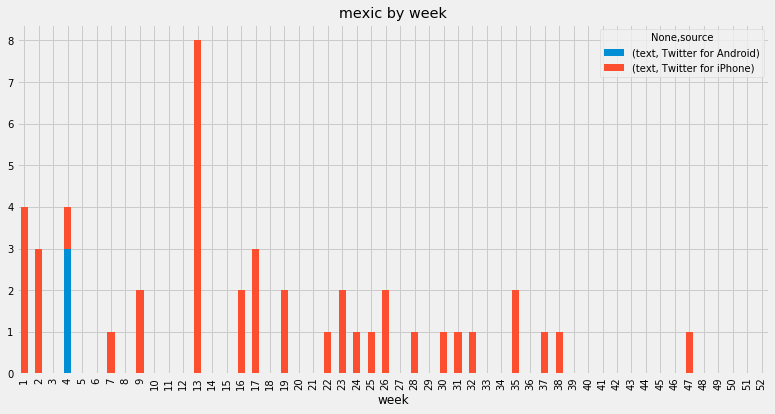

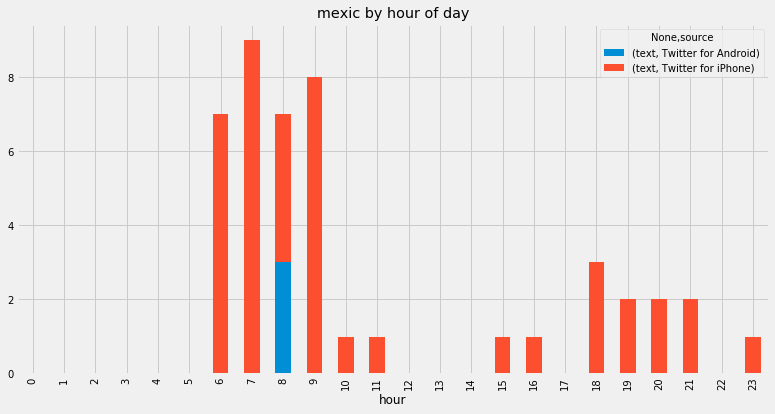

### The Tweets

[Friday, Aug 10, 2018 7:12 PM](https://twitter.com/realDonaldTrump/status/1028056640422068225): Deal with Mexico is coming along nicely. Autoworkers and farmers must be taken care of or there will be no deal. New President of Mexico has been an absolute gentleman. Canada must wait. Their Tariffs and Trade Barriers are far too high. Will tax cars if we can’t make a deal!

[Tuesday, Jul 31, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/1024248479386923009): One of the reasons we need Great Border Security is that Mexico’s murder rate in 2017 increased by 27% to 31,174 people killed, a record! The Democrats want Open Borders. I want Maximum Border Security and respect for ICE and our great Law Enforcement Professionals! @FoxNews

[Sunday, Jul 15, 2018 9:33 AM](https://twitter.com/realDonaldTrump/status/1018488667474616320): RT @Scavino45: “About 1-in-5 illegal alien adults crossing the United States-Mexico border with toddlers under the age of five are either c…

[Sunday, Jul 1, 2018 11:01 PM](https://twitter.com/realDonaldTrump/status/1013618640061595648): Congratulations to Andres Manuel Lopez Obrador on becoming the next President of Mexico. I look very much forward to working with him. There is much to be done that will benefit both the United States and Mexico!

[Friday, Jun 22, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/1010153153084428288): 80% of Mexico’s Exports come to the United States. They totally rely on us, which is fine with me. They do have, though, very strong Immigration Laws. The U.S. has pathetically weak and ineffective Immigration Laws that the Democrats refuse to help us fix. Will speak to Mexico!

[Friday, Jun 15, 2018 7:06 AM](https://twitter.com/realDonaldTrump/status/1007580091692568576): Thank you for all of the compliments on getting the World Cup to come to the U.S.A., Mexico and Canada. I worked hard on this, along with a Great Team of talented people. We never fail, and it will be a great World Cup! A special thanks to Bob Kraft for excellent advice.

[Wednesday, Jun 13, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/1006866089110892545): The U.S., together with Mexico and Canada, just got the World Cup. Congratulations - a great deal of hard work!

[Monday, Jun 4, 2018 9:47 AM](https://twitter.com/realDonaldTrump/status/1003634405036961793): Farmers have not been doing well for 15 years. Mexico, Canada, China and others have treated them unfairly. By the time I finish trade talks, that will change. Big trade barriers against U.S. farmers, and other businesses, will finally be broken. Massive trade deficits no longer!

[Friday, May 4, 2018 6:22 AM](https://twitter.com/realDonaldTrump/status/992348740529815552): Our Southern Border is under siege. Congress must act now to change our weak and ineffective immigration laws. Must build a Wall. Mexico, which has a massive crime problem, is doing little to help!

[Thursday, Apr 26, 2018 7:39 PM](https://twitter.com/realDonaldTrump/status/989650212380692480): The U.S. has put together a STRONG bid w/ Canada &amp; Mexico for the 2026 World Cup. It would be a shame if countries that we always support were to lobby against the U.S. bid. Why should we be supporting these countries when they don’t support us (including at the United Nations)?

[Monday, Apr 23, 2018 9:51 AM](https://twitter.com/realDonaldTrump/status/988415011382091776): Mexico, whose laws on immigration are very tough, must stop people from going through Mexico and into the U.S. We may make this a condition of the new NAFTA Agreement. Our Country cannot accept what is happening! Also, we must get Wall funding fast.

[Thursday, Apr 5, 2018 7:40 AM](https://twitter.com/realDonaldTrump/status/981859214380462081): The Caravan is largely broken up thanks to the strong immigration laws of Mexico and their willingness to use them so as not to cause a giant scene at our Border. Because of the Trump Administrations actions, Border crossings are at a still UNACCEPTABLE 46 year low. Stop drugs!

[Wednesday, Apr 4, 2018 7:19 AM](https://twitter.com/realDonaldTrump/status/981491439233355776): Our Border Laws are very weak while those of Mexico &amp; Canada are very strong. Congress must change these Obama era, and other, laws NOW! The Democrats stand in our way - they want people to pour into our country unchecked....CRIME! We will be taking strong action today.

[Tuesday, Apr 3, 2018 6:49 AM](https://twitter.com/realDonaldTrump/status/981121409807155200): The big Caravan of People from Honduras, now coming across Mexico and heading to our “Weak Laws” Border, had better be stopped before it gets there. Cash cow NAFTA is in play, as is foreign aid to Honduras and the countries that allow this to happen. Congress MUST ACT NOW!

[Monday, Apr 2, 2018 8:12 PM](https://twitter.com/realDonaldTrump/status/980961086546632705): Honduras, Mexico and many other countries that the U.S. is very generous to, sends many of their people to our country through our WEAK IMMIGRATION POLICIES. Caravans are heading here. Must pass tough laws and build the WALL. Democrats allow open borders, drugs and crime!

[Monday, Apr 2, 2018 8:00 PM](https://twitter.com/realDonaldTrump/status/980958298445885446): As ridiculous as it sounds, the laws of our country do not easily allow us to send those crossing our Southern Border back where they came from. A whole big wasted procedure must take place. Mexico &amp; Canada have tough immigration laws, whereas ours are an Obama joke. ACT CONGRESS

[Monday, Apr 2, 2018 9:08 AM](https://twitter.com/realDonaldTrump/status/980794173279342592): Mexico is making a fortune on NAFTA...They have very strong border laws - ours are pathetic. With all of the money they make from the U.S., hopefully they will stop people from coming through their country and into ours, at least until Congress changes our immigration laws!

[Monday, Apr 2, 2018 7:02 AM](https://twitter.com/realDonaldTrump/status/980762392303980544): Mexico has the absolute power not to let these large “Caravans” of people enter their country. They must stop them at their Northern Border, which they can do because their border laws work, not allow them to pass through into our country, which has no effective border laws.....

[Sunday, Apr 1, 2018 10:25 AM](https://twitter.com/realDonaldTrump/status/980451155548491777): Mexico is doing very little, if not NOTHING, at stopping people from flowing into Mexico through their Southern Border, and then into the U.S. They laugh at our dumb immigration laws. They must stop the big drug and people flows, or I will stop their cash cow, NAFTA. NEED WALL!

[Monday, Mar 5, 2018 6:53 AM](https://twitter.com/realDonaldTrump/status/970628441115643904): ...treat our farmers much better. Highly restrictive. Mexico must do much more on stopping drugs from pouring into the U.S. They have not done what needs to be done. Millions of people addicted and dying.

[Monday, Mar 5, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/970626966004162560): We have large trade deficits with Mexico and Canada. NAFTA, which is under renegotiation right now, has been a bad deal for U.S.A. Massive relocation of companies &amp; jobs. Tariffs on Steel and Aluminum will only come off if new &amp; fair NAFTA agreement is signed. Also, Canada must..

[Friday, Feb 23, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/966998215592677376): MS-13 gang members are being removed by our Great ICE and Border Patrol Agents by the thousands, but these killers come back in from El Salvador, and through Mexico, like water. El Salvador just takes our money, and Mexico must help MORE with this problem. We need The Wall!

[Sunday, Jan 28, 2018 8:18 AM](https://twitter.com/realDonaldTrump/status/957603804383465472): Our economy is better than it has been in many decades. Businesses are coming back to America like never before. Chrysler, as an example, is leaving Mexico and coming back to the USA. Unemployment is nearing record lows. We are on the right track!

[Thursday, Jan 18, 2018 8:16 AM](https://twitter.com/realDonaldTrump/status/953979393180950528): We need the Wall for the safety and security of our country. We need the Wall to help stop the massive inflow of drugs from Mexico, now rated the number one most dangerous country in the world. If there is no Wall, there is no Deal!

[Thursday, Jan 18, 2018 6:25 AM](https://twitter.com/realDonaldTrump/status/953951365532876800): ....The Wall will be paid for, directly or indirectly, or through longer term reimbursement, by Mexico, which has a ridiculous $71 billion dollar trade surplus with the U.S. The $20 billion dollar Wall is “peanuts” compared to what Mexico makes from the U.S. NAFTA is a bad joke!

[Wednesday, Jan 17, 2018 6:32 PM](https://twitter.com/realDonaldTrump/status/953772162665590787): During the campaign, I promised to MAKE AMERICA GREAT AGAIN by bringing businesses and jobs back to our country. I am very proud to see companies like Chrysler moving operations from Mexico to Michigan where there are so many great American workers! https://t.co/hz2q9UTfnF

[Saturday, Jan 13, 2018 9:20 AM](https://twitter.com/realDonaldTrump/status/952183452366929920): Yesterday was another big day for jobs and the Stock Market. Chrysler coming back to U.S. (Michigan) from Mexico and many more companies paying out Tax Cut money to employees. If Dems won in November, Market would have TANKED! It was headed for disaster.

[Saturday, Jan 13, 2018 8:13 AM](https://twitter.com/realDonaldTrump/status/952166643202916352): Yesterday was a big day for the stock market. Jobs are coming back to America. Chrysler is coming back to the USA, from Mexico and many others will follow. Tax cut money to employees is pouring into our economy with many more companies announcing. American business is hot again!

[Thursday, Jan 11, 2018 9:53 PM](https://twitter.com/realDonaldTrump/status/951648197440569344): Chrysler is moving a massive plant from Mexico to Michigan, reversing a years long opposite trend. Thank you Chrysler, a very wise decision. The voters in Michigan are very happy they voted for Trump/Pence. Plenty of more to follow!

[Thursday, Jan 11, 2018 9:49 PM](https://twitter.com/realDonaldTrump/status/951647402599026689): More great news as a result of historical Tax Cuts and Reform: Fiat Chrysler announces plan to invest more than $1 BILLION in Michigan plant, relocating their heavy-truck production from Mexico to Michigan, adding 2,500 new jobs and paying $2,000 bonus to U.S. employees! https://t.co/47azKD0l9B

[Monday, Nov 20, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/932570628451954688): Marshawn Lynch of the NFL’s Oakland Raiders stands for the Mexican Anthem and sits down to boos for our National Anthem. Great disrespect! Next time NFL should suspend him for remainder of season. Attendance and ratings way down.

[Tuesday, Sep 19, 2017 4:05 PM](https://twitter.com/realDonaldTrump/status/910233418474098688): God bless the people of Mexico City. We are with you and will be there for you.

[Thursday, Sep 14, 2017 3:18 PM](https://twitter.com/realDonaldTrump/status/908409572943126528): Spoke to President of Mexico to give condolences on terrible earthquake. Unable to reach for 3 days b/c of his cell phone reception at site.

[Sunday, Aug 27, 2017 9:51 AM](https://twitter.com/realDonaldTrump/status/901804388649500672): We are in the NAFTA (worst trade deal ever made) renegotiation process with Mexico &amp; Canada.Both being very difficult,may have to terminate?

[Sunday, Aug 27, 2017 9:44 AM](https://twitter.com/realDonaldTrump/status/901802524981817344): With Mexico being one of the highest crime Nations in the world, we must have THE WALL. Mexico will pay for it through reimbursement/other.

[Wednesday, Aug 9, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/895244004803194880): RT @foxandfriends: Millions of gallons of Mexican waste threaten Border Patrol agents https://t.co/yGAq4IgHOs

[Thursday, Jun 29, 2017 8:27 AM](https://twitter.com/realDonaldTrump/status/880402366373269504): New Sugar deal negotiated with Mexico is a very good one for both Mexico and the U.S. Had no deal for many years which hurt U.S. badly.

[Thursday, Jun 22, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/878013639613186049): Mexico was just ranked the second deadliest country in the world, after only Syria. Drug trade is largely the cause. We will BUILD THE WALL!

[Wednesday, May 10, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/862266225157689349): RT @DRUDGE_REPORT: MEXICO 2ND DEADLIEST COUNTRY; TOPS AFGHAN, IRAQ... https://t.co/i4FtSpLiHV

[Sunday, May 7, 2017 6:58 PM](https://twitter.com/realDonaldTrump/status/861354654856249344): Rexnord of Indiana made a deal during the Obama Administration to move to Mexico. Fired their employees. Tax product big that's sold in U.S.

[Thursday, Apr 27, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/857552956836786177): I received calls from the President of Mexico and the Prime Minister of Canada asking to renegotiate NAFTA rather than terminate. I agreed..

[Sunday, Apr 23, 2017 11:44 AM](https://twitter.com/realDonaldTrump/status/856172056932700164): Eventually, but at a later date so we can get started early, Mexico will be paying, in some form, for the badly needed border wall.

[Friday, Jan 27, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/824970003153842176): Mexico has taken advantage of the U.S. for long enough. Massive trade deficits &amp; little help on the very weak border must change, NOW!

[Thursday, Jan 26, 2017 8:55 AM](https://twitter.com/realDonaldTrump/status/824616644370714627): of jobs and companies lost. If Mexico is unwilling to pay for the badly needed wall, then it would be better to cancel the upcoming meeting.

[Thursday, Jan 26, 2017 8:51 AM](https://twitter.com/realDonaldTrump/status/824615820391305216): The U.S. has a 60 billion dollar trade deficit with Mexico. It has been a one-sided deal from the beginning of NAFTA with massive numbers...

---

## Search: _fox_

Number of Tweets: 251

Percent of all Tweets: 5.77%

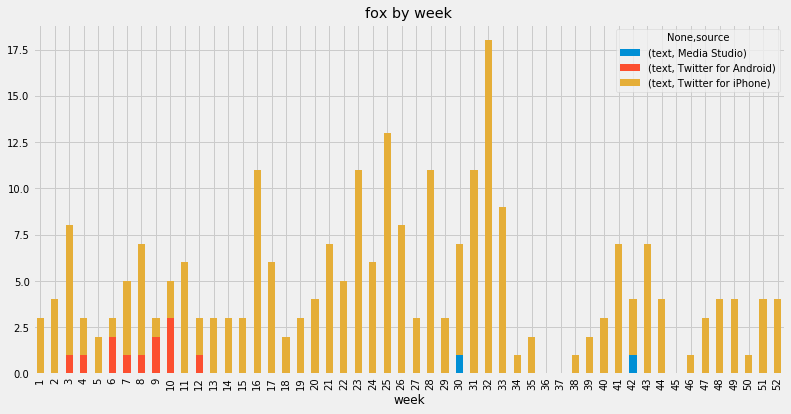

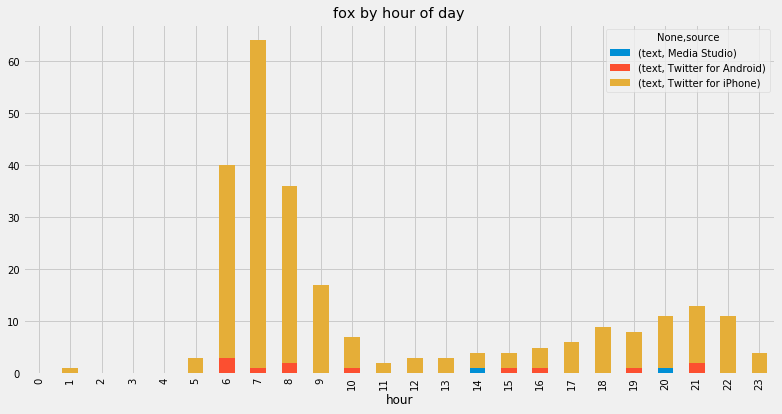

### The Tweets

[Tuesday, Aug 14, 2018 8:06 AM](https://twitter.com/realDonaldTrump/status/1029338578239795200): “They were all in on it, clear Hillary Clinton and FRAME Donald Trump for things he didn’t do.” Gregg Jarrett on @foxandfriends  If we had a real Attorney General, this Witch Hunt would never have been started! Looking at the wrong people.

[Tuesday, Aug 14, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1029335579845115904): Bruce Ohr of the “Justice” Department (can you believe he is still there) is accused of helping disgraced Christopher Steele “find dirt on Trump.” Ohr’s wife, Nelly, was in on the act big time - worked for Fusion GPS on Fake Dossier. @foxandfriends

[Monday, Aug 13, 2018 9:37 PM](https://twitter.com/realDonaldTrump/status/1029180132630687745): Scott Walker of Wisconsin is a tremendous Governor who has done incredible things for that Great State. He has my complete &amp; total Endorsement! He brought the amazing Foxconn to Wisconsin with its 15,000 Jobs-and so much more. Vote for Scott on Tuesday in the Republican Primary!

[Sunday, Aug 12, 2018 9:25 AM](https://twitter.com/realDonaldTrump/status/1028633682918166528): “Seems like the Department of Justice (and FBI) had a program to keep Donald Trump from becoming President”. @DarrellIssa  @foxandfriends  If this had happened to the other side, everybody involved would be in jail. This is a Media coverup of the biggest story of our time.

[Sunday, Aug 12, 2018 8:34 AM](https://twitter.com/realDonaldTrump/status/1028620642529292289): .@GovMikeHuckabee “Your paycheck is bigger, your pension is stronger.” @foxandfriends  Unemployment numbers are better than they have been in 50 years, &amp; perhaps ever. Our country is booming like never before - and it will get even better! Many companies moving back to the U.S.A.

[Monday, Aug 6, 2018 10:25 AM](https://twitter.com/realDonaldTrump/status/1026474458326986752): ....a law firm, eventually Kremlin connected sources, to gather info on Donald Trump. Collusion is very real with Russia, but only with Hillary and the Democrats, and we should demand a full investigation.” Dan Bongino on @foxandfriends  Looking forward to the new IG Report!

[Friday, Aug 3, 2018 6:10 PM](https://twitter.com/realDonaldTrump/status/1025504226204680192): July is just the ninth month since 1970 that unemployment has fallen below 4%. Our economy has added 3.7 million jobs since I won the Election. 4.1 GDP. More than 4 million people have received a pay raise due to tax reform. $400 Billion brought back from “overseas.” @FoxNews

[Thursday, Aug 2, 2018 7:04 AM](https://twitter.com/realDonaldTrump/status/1024974107337781248): Wow, @foxandfriends is blowing away the competition in the morning ratings. Morning Joe is a dead show with very few people watching and sadly, Fake News CNN is also doing poorly. Too much hate and inaccurately reported stories - too predictable!

[Tuesday, Jul 31, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/1024248479386923009): One of the reasons we need Great Border Security is that Mexico’s murder rate in 2017 increased by 27% to 31,174 people killed, a record! The Democrats want Open Borders. I want Maximum Border Security and respect for ICE and our great Law Enforcement Professionals! @FoxNews

[Monday, Jul 23, 2018 6:13 AM](https://twitter.com/realDonaldTrump/status/1021337592904732672): Tom Fitton on @foxandfriends at 6:15 A.M. NOW! Judicial Watch.

[Sunday, Jul 22, 2018 8:56 AM](https://twitter.com/realDonaldTrump/status/1021016070134648833): .@PeteHegseth on @FoxNews  “Source #1 was the (Fake) Dossier. Yes, the Dirty Dossier, paid for by Democrats as a hit piece against Trump, and looking for information that could discredit Candidate #1 Trump. Carter Page was just the foot to surveil the Trump campaign...” ILLEGAL!

[Thursday, Jul 19, 2018 7:13 AM](https://twitter.com/realDonaldTrump/status/1019903123312308224): “Trump recognized Russian Meddling MANY TIMES.” Thank you to @foxandfriends and @FoxNews for actually showing the clips. The Fake News wants no part of that narrative! Too bad they don’t want to focus on all of the ECONOMIC and JOBS records being set.

[Wednesday, Jul 18, 2018 7:03 AM](https://twitter.com/realDonaldTrump/status/1019538038651871233): “A lot of Democrats wished they voted for the Tax Cuts because the economy is booming - we could have 4% growth now and the Fed said yesterday that unemployment could drop again.”  @foxandfriends  @kilmeade

[Thursday, Jul 12, 2018 1:55 AM](https://twitter.com/realDonaldTrump/status/1017286281867481089): As I head out to a very important NATO meeting, I see that FBI Lover/Agent Lisa Page is dodging a Subpoena &amp; is refusing to show up and testify. What can she possibly say about her statements and lies. So much corruption on the other side. Where is the Attorney General? @FoxNews

[Tuesday, Jul 10, 2018 6:44 AM](https://twitter.com/realDonaldTrump/status/1016634257857568769): RT @ShennaFoxxx: @realDonaldTrump #TrumpUKVisit🇬🇧 To the 
45th @POTUS Donald J Trump @FLOTUS @MELANIATRUMP The British people are looking f…

[Sunday, Jul 1, 2018 8:00 AM](https://twitter.com/realDonaldTrump/status/1013391783533989888): I will be interviewed by @MariaBartiromo at 10:00 A.M. on @FoxNews

[Saturday, Jun 30, 2018 3:31 PM](https://twitter.com/realDonaldTrump/status/1013143055417905152): I will be interviewed by @MariaBartiromo on Sunday on @FoxNews at 10:00 A. M. Enjoy!

[Friday, Jun 29, 2018 7:30 PM](https://twitter.com/realDonaldTrump/status/1012840647743737857): The new plant being built by Foxconn in Wisconsin is incredible. Congratulations to the people of Wisconsin and to Governor Scott Walker @GovWalker and his talented representatives for having pulled it off. Great job!

[Friday, Jun 29, 2018 7:21 PM](https://twitter.com/realDonaldTrump/status/1012838511588839424): RT @FoxBusiness: .@IvankaTrump: "I think one of the tremendous opportunities that were seeing because the economy is so strong is that peop…

[Thursday, Jun 28, 2018 2:57 PM](https://twitter.com/realDonaldTrump/status/1012409641911930881): Today, we broke ground on a plant that will provide jobs for up to 15,000 Wisconsin Workers! As Foxconn has discovered, there is no better place to build, hire and grow than right here in the United States! https://t.co/tOFFodZYvK

[Thursday, Jun 28, 2018 9:06 AM](https://twitter.com/realDonaldTrump/status/1012321218056384513): I am in Milwaukee, Wisconsin, for meetings. Soon to leave for a big groundbreaking for Foxconn, which is building a great new electronics plant in Wisconsin. 15,000 Jobs, so great!

[Thursday, Jun 28, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1012299239207198721): Just watched @SharkGregNorman on @foxandfriends. Said “President is doing a great job. All over the world, people want to come back to the U.S.” Thank you Greg, and you’re looking and doing great!

[Thursday, Jun 28, 2018 7:32 AM](https://twitter.com/realDonaldTrump/status/1012297599431401474): Amy Kremer, Women for Trump, was so great on @foxandfriends. Brave and very smart, thank you Amy! @AmyKremer

[Saturday, Jun 23, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/1010485876806348800): .@FoxNews  Poll numbers plummet on the Democrat inspired and paid for Russian Witch Hunt. With all of the bias, lying and hate by the investigators, people want the investigators investigated. Much more will come out. A total scam and excuse for the Dems losing the Election!

[Wednesday, Jun 20, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/1009435777992884227): “FBI texts have revealed anti-Trump Bias.” @FoxNews  Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!

[Friday, Jun 15, 2018 7:56 AM](https://twitter.com/realDonaldTrump/status/1007592799561289729): RT @foxandfriends: IG REPORT BOMBSHELL: Anti-Trump FBI agent Peter Strzok texted his lover Lisa Page "we'll stop" Trump from becoming presi…

[Friday, Jun 15, 2018 7:56 AM](https://twitter.com/realDonaldTrump/status/1007592744544559104): RT @foxandfriends: DOJ IG report finds that an FBI lawyer told a bureau employee “Viva le resistance” after President Trump was elected htt…

[Friday, Jun 15, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1007592537190797313): RT @foxandfriends: “This is one of the most damning rebukes of the FBI that I think we’ve ever seen.” -@jasoninthehouse https://t.co/9DoTim…

[Friday, Jun 15, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1007592482656407553): RT @foxandfriends: .@jasoninthehouse: The DOJ IG report is 562 pages of nothing but bias and animus https://t.co/7IeXfmvo1M

[Friday, Jun 15, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1007592416197607424): RT @foxandfriends: .@jasoninthehouse: Anything Mueller is doing with his investigation is tainted by the anti-Trump FBI agents https://t.co…

[Friday, Jun 15, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1007592393728839686): RT @foxandfriends: .@jasoninthehouse: All of this started because Hillary Clinton set up her private server https://t.co/rLzjDRxxxm

[Friday, Jun 15, 2018 7:50 AM](https://twitter.com/realDonaldTrump/status/1007591075601637376): Wow, the highest rated (by far) morning show, @foxandfriends, is on the Front Lawn of the White House. Maybe I’ll have to take an unannounced trip down to see them?

[Wednesday, Jun 6, 2018 9:37 AM](https://twitter.com/realDonaldTrump/status/1004356576671666179): Gold Star father, Ceejay Metcalf, whose great son Michael was just honored at the White House, was fantastic this morning on @foxandfriends. He is a special man!

[Tuesday, Jun 5, 2018 8:40 PM](https://twitter.com/realDonaldTrump/status/1004161046762926081): RT @robbystarbuck: Fox News has been #1 for 197 months straight. In the latest ratings disaster for CNN they lost another 25% of their view…

[Saturday, Jun 2, 2018 5:09 PM](https://twitter.com/realDonaldTrump/status/1003020764906512385): RT @CLewandowski_: Looking forward to being on @foxandfriends tomorrow around 7:45 AM on @FoxNews. Hope you watch.

[Saturday, Jun 2, 2018 5:04 PM](https://twitter.com/realDonaldTrump/status/1003019564379197446): RT @foxandfriends: 223,000 jobs added in May, even the NYT runs out of words to describe how good the numbers are! https://t.co/K1GB8G0zsf

[Saturday, Jun 2, 2018 12:46 PM](https://twitter.com/realDonaldTrump/status/1002954515941941249): Real @FoxNews is doing great, Fake News CNN is dead! https://t.co/1p37tPiB3v

[Saturday, Jun 2, 2018 8:06 AM](https://twitter.com/realDonaldTrump/status/1002884227753480193): “John Brennan, no single figure in American history has done more to discredit the intelligence community than this liar. Not only is he a liar, he’s a liar about being a liar.”  Dan Bongino on @foxandfriends

[Friday, Jun 1, 2018 2:07 PM](https://twitter.com/realDonaldTrump/status/1002612676634259456): RT @FoxNews: President @realDonaldTrump participates in the U.S. Coast Guard [@USCG] Change-of-Command Ceremony. https://t.co/ekWubVkf1h

[Monday, May 28, 2018 10:32 AM](https://twitter.com/realDonaldTrump/status/1001108964216537089): “We now find out that the Obama Administration put the opposing campaigns presidential candidate, or his campaign, under investigation. That raises legitimate questions. I just find this really odd...this goes to the heart of our electoral system.” Jonathan Turley on @FoxNews

[Monday, May 28, 2018 9:55 AM](https://twitter.com/realDonaldTrump/status/1001099771602456576): “The President deserves some answers.” @FoxNews in discussing “SPYGATE.”

[Thursday, May 24, 2018 12:18 PM](https://twitter.com/realDonaldTrump/status/999686165354737665): RT @FoxNews: WATCH: @POTUS on his decision to cancel the planned North Korea summit. https://t.co/UlzBnkOdzs https://t.co/LTKbqNDfNU

[Wednesday, May 23, 2018 8:58 PM](https://twitter.com/realDonaldTrump/status/999454450854039552): Will be interviewed on @foxandfriends tomorrow morning at 6:00 A.M. Enjoy!

[Wednesday, May 23, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/999249186762772481): Everybody is with Tomi Lahren, a truly outstanding and respected young woman! @foxandfriends

[Wednesday, May 23, 2018 6:45 AM](https://twitter.com/realDonaldTrump/status/999239924401438720): @foxandfriends  “New Bombshell in the Obama Spying Scandal. Did other Agencies SPY on Trump Campaign?” Even Clapper, worlds dumbest former Intelligence Head, who has the problem of lying a lot, used the word SPY when describing the illegal activities!

[Monday, May 14, 2018 6:54 AM](https://twitter.com/realDonaldTrump/status/995980604016611329): U.S. Embassy opening in Jerusalem will be covered live on @FoxNews &amp; @FoxBusiness. Lead up to 9:00 A.M. (eastern) event has already begun. A great day for Israel!

[Friday, May 4, 2018 6:37 AM](https://twitter.com/realDonaldTrump/status/992352585863651329): Andy McCarthy will be on  @LouDobbs tonight. 7:00 P.M. , @FoxBusiness.

[Wednesday, May 2, 2018 9:33 AM](https://twitter.com/realDonaldTrump/status/991672075491438594): NEW BOOK - A MUST READ! “The Russia Hoax - The Illicit Scheme to Clear Hillary Clinton and Frame Donald Trump” by the brilliant Fox News Legal Analyst Gregg Jarrett. A sad chapter for law enforcement. A rigged system!

[Saturday, Apr 28, 2018 6:45 PM](https://twitter.com/realDonaldTrump/status/990361469802905600): Join me LIVE in Washington, Michigan at 7:00pmE on @FoxNews! #MAGA

[Saturday, Apr 28, 2018 8:58 AM](https://twitter.com/realDonaldTrump/status/990213619190202369): “Clapper lied about (fraudulent) Dossier leaks to CNN” @foxandfriends FoxNews  He is a lying machine who now works for Fake News CNN.

[Friday, Apr 27, 2018 7:23 AM](https://twitter.com/realDonaldTrump/status/989827358961086465): So great to have Staff Sgt. Dan Nevins and the incredible WOUNDED WARRIORS with me in the White House yesterday. These are truly brave and special people! @foxandfriends

[Thursday, Apr 26, 2018 6:17 PM](https://twitter.com/realDonaldTrump/status/989629633376194561): Loved being on @foxandfriends this morning. Great show!

[Wednesday, Apr 25, 2018 9:41 PM](https://twitter.com/realDonaldTrump/status/989318406204809216): I will be interviewed on @foxandfriends at 8:00 A.M. Enjoy!

[Sunday, Apr 22, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/988030312088260608): “GOP Lawmakers asking Sessions to Investigate Comey and Hillary Clinton.” @FoxNews   Good luck with that request!

[Tuesday, Apr 17, 2018 5:55 PM](https://twitter.com/realDonaldTrump/status/986362433479610370): RT @FoxBusiness: WATCH LIVE: @IvankaTrump and @stevenmnuchin1 host tax event on Tax Day in New Hampshire. (Courtesy: WBZ) https://t.co/C3zr…

[Wednesday, Apr 11, 2018 8:48 PM](https://twitter.com/realDonaldTrump/status/984231791103012864): Big show tonight on @seanhannity! 9:00 P.M. on @FoxNews

[Saturday, Mar 31, 2018 8:53 AM](https://twitter.com/realDonaldTrump/status/980065427375128576): Governor Jerry “Moonbeam” Brown pardoned 5 criminal illegal aliens whose crimes include (1) Kidnapping and Robbery (2) Badly beating wife and threatening a crime with intent to terrorize (3) Dealing drugs. Is this really what the great people of California want? @FoxNews

[Monday, Mar 19, 2018 8:16 AM](https://twitter.com/realDonaldTrump/status/975707627182219266): .@seanhannity on @foxandfriends now! Great! 8:18 A.M.

[Sunday, Mar 18, 2018 8:02 AM](https://twitter.com/realDonaldTrump/status/975341676297445377): Wow, watch Comey lie under oath to Senator G when asked “have you ever been an anonymous source...or known someone else to be an anonymous source...?” He said strongly “never, no.” He lied as shown clearly on @foxandfriends.

[Tuesday, Mar 6, 2018 8:07 AM](https://twitter.com/realDonaldTrump/status/971009285181276160): RT @EricTrump: Congratulations @FoxNews: Fox has 15 of the top 20 shows with @SeanHannity and @TuckerCarlson leading the pack at 1st and 2n…

[Tuesday, Feb 27, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/968462966864609280): “I’ve been skeptical about the collusion and obstruction claims for the last year. I just don’t see the evidence....in terms of the collusion, it’s all a bit implausible based on the evidence we have.”  Jonathan Turley on @FoxNews

[Saturday, Feb 24, 2018 10:56 PM](https://twitter.com/realDonaldTrump/status/967609114238050304): RT @VollrathTammie: @realDonaldTrump @FoxNews https://t.co/sERi7Vyh5I

[Saturday, Feb 24, 2018 10:11 PM](https://twitter.com/realDonaldTrump/status/967597887545896961): RT @FoxNews: President @realDonaldTrump on Dem FISA memo: "A lot of bad things happened on the other side, not on this side, but the other…

[Saturday, Feb 24, 2018 10:10 PM](https://twitter.com/realDonaldTrump/status/967597639293382657): RT @FoxNews: President @realDonaldTrump on DACA: "I'm the one that's pushing DACA and the Democrats are nowhere to be found." https://t.co/…

[Saturday, Feb 24, 2018 8:00 PM](https://twitter.com/realDonaldTrump/status/967564998238142471): I will be interviewed by @JudgeJeanine on @FoxNews at 9:00 P.M. Enjoy!

[Saturday, Feb 24, 2018 7:56 PM](https://twitter.com/realDonaldTrump/status/967563946063523840): “Congressman Schiff omitted and distorted key facts” @FoxNews  So, what else is new. He is a total phony!

[Saturday, Feb 24, 2018 6:44 PM](https://twitter.com/realDonaldTrump/status/967545724362739712): “Russians had no compromising information on Donald Trump” @FoxNews  Of course not, because there is none, and never was. This whole Witch Hunt is an illegal disgrace...and Obama did nothing about Russia!

[Saturday, Feb 24, 2018 3:16 PM](https://twitter.com/realDonaldTrump/status/967493467046899712): Democrat judges have totally redrawn election lines in the great State of Pennsylvania. @FoxNews. This is very unfair to Republicans and to our country as a whole. Must be appealed to the United States Supreme Court ASAP!

[Tuesday, Feb 20, 2018 10:29 AM](https://twitter.com/realDonaldTrump/status/965971586913374208): ....cameras running. Another False Accusation. Why doesn’t @washingtonpost report the story of the women taking money to make up stories about me? One had her home mortgage paid off. Only @FoxNews so reported...doesn’t fit the Mainstream Media narrative.

[Tuesday, Feb 20, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/965925223949357056): Thank you to @foxandfriends for the great timeline on all of the failures the Obama Administration had against Russia, including Crimea, Syria and so much more. We are now starting to win again!

[Monday, Feb 12, 2018 7:54 AM](https://twitter.com/realDonaldTrump/status/963033580107653120): Thank you to Sue Kruczek, who lost her wonderful and talented son Nick to the Opioid scourge, for your kind words while on @foxandfriends. We are fighting this terrible epidemic hard - Nick will not have died in vain!

[Saturday, Feb 10, 2018 1:34 PM](https://twitter.com/realDonaldTrump/status/962394439846191105): ....agencies, not just the FBI &amp; DOJ, now the State Department to dig up dirt on him in the days leading up to the Election. Comey had conversations with Donald Trump, which I don’t believe were accurate...he leaked information (corrupt).” Tom Fitton of Judicial Watch on @FoxNews

[Monday, Feb 5, 2018 7:17 AM](https://twitter.com/realDonaldTrump/status/960487657691385856): Thank you to @foxandfriends for exposing the truth. Perhaps that’s why your ratings are soooo much better than your untruthful competition!

[Thursday, Feb 1, 2018 7:02 AM](https://twitter.com/realDonaldTrump/status/959034299222843394): Thank you for all of the nice compliments and reviews on the State of the Union speech. 45.6 million people watched, the highest number in history. @FoxNews beat every other Network, for the first time ever, with 11.7 million people tuning in. Delivered from the heart!

[Saturday, Jan 27, 2018 6:55 AM](https://twitter.com/realDonaldTrump/status/957220637705109505): Thank you to Brandon Judd of the National Border Patrol Council for his strong statement on @foxandfriends that we very badly NEED THE WALL. Must also end loophole of “catch &amp; release” and clean up the legal and other procedures at the border NOW for Safety &amp; Security reasons.

[Sunday, Jan 21, 2018 8:21 PM](https://twitter.com/realDonaldTrump/status/955249077645643776): Thank you to Brad Blakeman on @FoxNews for grading year one of my presidency with an “A”-and likewise to Doug Schoen for the very good grade and statements. Working hard!

[Saturday, Jan 20, 2018 9:34 PM](https://twitter.com/realDonaldTrump/status/954905101717655552): RT @FoxNews: .@EricTrump: "My father was elected for one reason, and that's because he actually believes in putting America first, which is…

[Saturday, Jan 20, 2018 9:33 PM](https://twitter.com/realDonaldTrump/status/954904669112995840): RT @FoxNews: .@KellyannePolls: "Since @POTUS took office, 863,000 new jobs were filled by women. Over half a million American women have en…

[Saturday, Jan 20, 2018 9:31 PM](https://twitter.com/realDonaldTrump/status/954904246494916609): RT @FoxNews: .@davidwebbshow: "Let's look at the calendar. It's January 20th. DACA expires on March 5th. That means this was a construct of…

[Saturday, Jan 20, 2018 9:31 PM](https://twitter.com/realDonaldTrump/status/954904160016785413): RT @FoxNews: .@EricTrump: "People have seen a year that's incredible, that's been filled with nothing but the best for our country, America…

[Saturday, Jan 20, 2018 9:18 PM](https://twitter.com/realDonaldTrump/status/954901073587834882): Eric Trump on @JudgeJeanine on @FoxNews now!

[Wednesday, Jan 17, 2018 8:04 AM](https://twitter.com/realDonaldTrump/status/953614071336701952): Eric Trump on @foxandfriends  now!

[Tuesday, Jan 16, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/953273134655987716): Unemployment for Black Americans is the lowest ever recorded. Trump approval ratings with Black Americans has doubled. Thank you, and it will get even (much) better! @FoxNews

[Tuesday, Jan 16, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/953271789790138368): “90% of Trump 2017 news coverage was negative” -and much of it contrived!@foxandfriends

[Sunday, Jan 14, 2018 8:59 AM](https://twitter.com/realDonaldTrump/status/952540700683497472): ...big unnecessary regulation cuts made it all possible” (among many other things). “President Trump reversed the policies of President Obama, and reversed our economic decline.” Thank you Stuart Varney.  @foxandfriends

[Thursday, Jan 11, 2018 9:43 PM](https://twitter.com/realDonaldTrump/status/951645893513613312): Thank you Adam Levine, The Federalist, in interview on @foxandfriends  “Donald Trump is the greatest President our Country has ever seen.”

[Thursday, Jan 11, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/951441504203104256): “45 year low in illegal immigration this year.” @foxandfriends

[Thursday, Jan 11, 2018 6:33 AM](https://twitter.com/realDonaldTrump/status/951416674808467461): Disproven and paid for by Democrats “Dossier used to spy on Trump Campaign. Did FBI use Intel tool to influence the Election?” @foxandfriends  Did Dems or Clinton also pay Russians? Where are hidden and smashed DNC servers? Where are Crooked Hillary Emails?  What a mess!

[Friday, Dec 29, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/946724719956578304): RT @FoxBusiness: .@charliekirk11: "What this president has done is truly historic, and if a Democrat president achieved 1/10th of what @POT…

[Friday, Dec 29, 2017 7:46 AM](https://twitter.com/realDonaldTrump/status/946724075157651457): While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage &amp; Russia hoax!

[Tuesday, Dec 26, 2017 8:24 AM](https://twitter.com/realDonaldTrump/status/945646491955290113): WOW, @foxandfrlends  “Dossier is bogus. Clinton Campaign, DNC funded Dossier. FBI CANNOT (after all of this time) VERIFY CLAIMS IN DOSSIER OF RUSSIA/TRUMP COLLUSION. FBI TAINTED.” And they used this Crooked Hillary pile of garbage as the basis for going after the Trump Campaign!

[Sunday, Dec 24, 2017 7:25 AM](https://twitter.com/realDonaldTrump/status/944906847970119680): .@FoxNews-FBI’s Andrew McCabe, “in addition to his wife getting all of this money from M (Clinton Puppet), he was using, allegedly, his FBI Official Email Account to promote her campaign. You obviously cannot do this. These were the people who were investigating Hillary Clinton.”

[Saturday, Dec 23, 2017 3:32 PM](https://twitter.com/realDonaldTrump/status/944667102312566784): Wow, “FBI lawyer James Baker reassigned,” according to @FoxNews.

[Thursday, Dec 21, 2017 7:45 AM](https://twitter.com/realDonaldTrump/status/943824695144697857): Was @foxandfriends just named the most influential show in news? You deserve it - three great people! The many Fake News Hate Shows should study your formula for success!

[Monday, Dec 18, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/942721681130483712): Ivanka Trump will be interviewed on @foxandfriends.

[Monday, Dec 18, 2017 6:23 AM](https://twitter.com/realDonaldTrump/status/942717030091943936): Remember, Republicans are 5-0 in Congressional Races this year. The media refuses to mention this. I said Gillespie and Moore would lose (for very different reasons), and they did. I also predicted  “I” would win. Republicans will do well in 2018, very well! @foxandfriends

[Wednesday, Dec 13, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/940930017365778432): Wow, more than 90% of Fake News Media coverage of me is negative, with numerous forced retractions of untrue stories. Hence my use of Social Media, the only way to get the truth out. Much of Mainstream Meadia has become a joke! @foxandfriends

[Friday, Dec 8, 2017 8:04 PM](https://twitter.com/realDonaldTrump/status/939299624875118592): Just arrived at the Pensacola Bay Center. Join me LIVE on @FoxNews in 10 minutes! #MAGA https://t.co/RQFqOkcpNV

[Thursday, Dec 7, 2017 8:08 AM](https://twitter.com/realDonaldTrump/status/938756989542457344): Go get the new book on Andrew Jackson by Brian Kilmeade...Really good. @foxandfriends

[Monday, Dec 4, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/937661677700550656): A must watch: Legal Scholar Alan Dershowitz was just on @foxandfriends talking of what is going on with respect to the greatest Witch Hunt in U.S. political history. Enjoy!

[Sunday, Dec 3, 2017 7:42 AM](https://twitter.com/realDonaldTrump/status/937301085156503552): Tainted (no, very dishonest?) FBI “agent’s role in Clinton probe under review.” Led Clinton Email probe. @foxandfriends  Clinton money going to wife of another FBI agent in charge.

[Thursday, Nov 30, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/936206961728786432): The Failing @nytimes has totally gone against the Social Media Guidelines that they installed to preserve some credibility after many of their biased reporters went Rogue!  @foxandfriends

[Wednesday, Nov 29, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/936037938898636800): The House of Representatives seeks contempt citations(?) against the JusticeDepartment and the FBI for withholding key documents and an FBI witness which could shed light on surveillance of associates of Donald Trump. Big stuff. Deep State. Give this information NOW! @FoxNews

[Wednesday, Nov 29, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/935833914761007114): .@foxandfriends, we are in record territory in all things having to do with our economy! https://t.co/VB0Ao3s18d

[Monday, Nov 27, 2017 9:04 AM](https://twitter.com/realDonaldTrump/status/935147410472480769): We should have a contest as to which of the Networks, plus CNN and not including Fox, is the most dishonest, corrupt and/or distorted in its political coverage of your favorite President (me). They are all bad. Winner to receive the FAKE NEWS TROPHY!

[Saturday, Nov 25, 2017 5:37 PM](https://twitter.com/realDonaldTrump/status/934551607596986368): .@FoxNews is MUCH more important in the United States than CNN, but outside of the U.S., CNN International is still a major source of (Fake) news, and they represent our Nation to the WORLD very poorly. The outside world does not see the truth from them!

[Wednesday, Nov 22, 2017 4:25 PM](https://twitter.com/realDonaldTrump/status/933446283632824321): 51 Million American to travel this weekend - highest number in twelve years (AAA). Traffic and airports are running very smoothly!  @FoxNews

[Monday, Nov 20, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/932578255810498560): Under President Trump unemployment rate will drop below 4%.  Analysts predict economic boom for 2018!  @foxandfriends and @Varneyco

[Wednesday, Nov 15, 2017 5:40 AM](https://twitter.com/realDonaldTrump/status/930747213659197441): .@foxandfriends will be showing much of our successful trip to Asia, and the friendships &amp; benefits that will endure for years to come!

[Thursday, Nov 2, 2017 9:29 PM](https://twitter.com/realDonaldTrump/status/926260114146889728): I will be interviewed by @IngrahamAngle on @FoxNews at 10:00. Enjoy!

[Wednesday, Nov 1, 2017 7:40 AM](https://twitter.com/realDonaldTrump/status/925688931823300609): "Senator Chuck Schumer helping to import Europes problems" said Col.Tony Shaffer. We will stop this craziness!  @foxandfriends

[Wednesday, Nov 1, 2017 7:30 AM](https://twitter.com/realDonaldTrump/status/925686558304464897): We are fighting hard for Merit Based immigration, no more Democrat Lottery Systems. We must get MUCH tougher (and smarter).  @foxandfriends

[Monday, Oct 30, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/924966722544848896): Great job by MichaelCaputo on @foxandfriends.

[Friday, Oct 27, 2017 4:33 PM](https://twitter.com/realDonaldTrump/status/924011278804357120): .@FoxNews Chris Wallace: “More evidence of Dem collusion with Russia than GOP” https://t.co/nACQerJSiu

[Friday, Oct 27, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/923866849451888640): Thank you @foxandfriends. Really great job and show!

[Thursday, Oct 26, 2017 9:44 AM](https://twitter.com/realDonaldTrump/status/923545771416449024): RT @PChowka: Fox News With Hannity's Help Regains Its Ratings Dominance By Peter Barry Chowka at The Hagmann report https://t.co/ICDMCZregu…

[Wednesday, Oct 25, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/923320000185847808): Interview with @LouDobbs coming up at 7pmE on @FoxBusiness. Enjoy! https://t.co/9V9z015kVl

[Wednesday, Oct 25, 2017 1:46 PM](https://twitter.com/realDonaldTrump/status/923244308848881665): Just interviewed by @LouDobbs. Will be aired tonight at 7pmE on @FoxBusiness. #Dobbs

[Wednesday, Oct 25, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/923147501418446849): "Clinton campaign &amp; DNC paid for research that led to the anti-Trump Fake News Dossier. The victim here is the President." @FoxNews

[Sunday, Oct 22, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/922067676708638721): Doing interview today with Maria Bartiromo at 10:00 A.M. on @FoxNews - ENJOY!

[Friday, Oct 20, 2017 2:31 PM](https://twitter.com/realDonaldTrump/status/921443729990397952): Thank you @GeraldoRivera @FoxandFriends. Agree! https://t.co/8cZLdAbgzw

[Thursday, Oct 19, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/920988223362469891): .@foxandfriends "Russia sent millions to Clinton Foundation"

[Wednesday, Oct 18, 2017 11:03 PM](https://twitter.com/realDonaldTrump/status/920847844759699456): "46% of Americans think the Media is inventing stories about Trump &amp; his Administration." @FoxNews   It is actually much worse than this!

[Monday, Oct 16, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/919900022409449474): Art Laffer just said that he doesn't know how a Democrat could vote against the big tax cut/reform bill and live with themselves!  @FoxNews

[Saturday, Oct 14, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/919342572526559232): RT @FoxNews: TONIGHT on "Justice," @JudgeJeanine talks to special guests @EricTrump and @LaraLeaTrump - Tune in at 9p ET on Fox News Channe…

[Saturday, Oct 14, 2017 5:29 PM](https://twitter.com/realDonaldTrump/status/919314277177192448): RT @EricTrump: .@LaraLeaTrump and I look forward to being on @JudgeJeanine tonight at 9pm! @FoxNews #MakeAmericaGreatAgain 🇺🇸🇺🇸🇺🇸 https://t…

[Thursday, Oct 12, 2017 6:04 AM](https://twitter.com/realDonaldTrump/status/918417002733154305): Clips from tax speech and @seanhannity on @foxandfriends now. Have a great day!

[Wednesday, Oct 11, 2017 8:55 PM](https://twitter.com/realDonaldTrump/status/918279015928037377): RT @realDonaldTrump: I will be interviewed tonight on @FoxNews by @SeanHannity at 9pmE. Enjoy!

[Wednesday, Oct 11, 2017 8:17 PM](https://twitter.com/realDonaldTrump/status/918269386997321730): RT @realDonaldTrump: I will be interviewed tonight on @FoxNews by @SeanHannity at 9pmE. Enjoy!

[Wednesday, Oct 11, 2017 7:56 PM](https://twitter.com/realDonaldTrump/status/918263984029085697): Joining @SeanHannity tonight at 9pmE on @FoxNews. Enjoy! https://t.co/RCfiJus5Rw

[Wednesday, Oct 11, 2017 5:32 PM](https://twitter.com/realDonaldTrump/status/918227740700102657): I will be interviewed tonight on @FoxNews by @SeanHannity at 9pmE. Enjoy!

[Thursday, Oct 5, 2017 10:16 PM](https://twitter.com/realDonaldTrump/status/916124989736308736): RT @FoxBusiness: #StockAlert: U.S. markets since the election https://t.co/1kwamJuizO

[Thursday, Oct 5, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/915886953194770433): RT @FoxNews: Geraldo Blasts 'Fake News' Reports About Trump's Visit to Puerto Rico https://t.co/9jO0D3BMvE

[Tuesday, Oct 3, 2017 8:27 PM](https://twitter.com/realDonaldTrump/status/915372694060830721): RT @seanhannity: Tonight the truth about how despicable the media and the left are in America today. We will name names. 9 est Hannity Fox…

[Friday, Sep 29, 2017 9:28 PM](https://twitter.com/realDonaldTrump/status/913938593370042368): RT @FoxNews: TUNE IN: @EricTrump joins @seanhannity TONIGHT at 9p ET on @FoxNews Channel! #Hannityat9 https://t.co/foDzkcAKJe

[Tuesday, Sep 26, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/912636538156146688): Great interview on @foxandfriends with the parents of Otto Warmbier: 1994 - 2017. Otto was tortured beyond belief by North Korea.

[Wednesday, Sep 20, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/910458657179086848): Thank you  @foxandfriends - great show!

[Thursday, Aug 31, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/903234878124249090): RT @FoxNews: .@KellyannePolls on Harvey recovery: We hope when it comes to basic Hurricane Harvey funding that we can rely upon a nonpartis…

[Tuesday, Aug 29, 2017 8:26 AM](https://twitter.com/realDonaldTrump/status/902507855584092160): .@foxandfriends   We are not looking to fill all of those positions. Don't need many of them - reduce size of government. @IngrahamAngle

[Monday, Aug 21, 2017 9:27 AM](https://twitter.com/realDonaldTrump/status/899623926082535425): Jerry Falwell of Liberty University was fantastic on @foxandfriends. The Fake News should listen to what he had to say. Thanks Jerry!

[Wednesday, Aug 16, 2017 7:32 AM](https://twitter.com/realDonaldTrump/status/897783159038910466): RT @FoxNews: .@POTUS: "Our infrastructure will again be the best in the world. We used to have the greatest infrastructure anywhere in the…

[Wednesday, Aug 16, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/897780828134141952): RT @CLewandowski_: Please watch @foxandfriends today at 7:30 AM to watch me discuss @realDonaldTrump.

[Tuesday, Aug 15, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/897413442696597505): RT @MikeHolden42: @foxandfriends @realDonaldTrump He's a fascist, so not unusual.

[Tuesday, Aug 15, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/897413405002387456): RT @SLandinSoCal: @foxandfriends @realDonaldTrump Nothing can stop the #TrumpTrain‼️ https://t.co/PprEMbiZQa

[Tuesday, Aug 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/897411536460886016): RT @foxandfriends: FOX NEWS EXCLUSIVE: President Trump 'seriously considering' a pardon for ex-Sheriff Joe Arpaio https://t.co/Rgw8l7i9Xl

[Tuesday, Aug 15, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/897411177583702016): @foxandfriends According to report just out, President Obama knew about Russian interference 3 years ago but he didn't want to anger Russia!

[Tuesday, Aug 15, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/897405235924275200): Senator Luther Strange, who is doing a great job for the people of Alabama, will be on @foxandfriends at 7:15. Tough on crime, borders etc.

[Monday, Aug 14, 2017 10:38 PM](https://twitter.com/realDonaldTrump/status/897286242886463489): RT @foxandfriends: Sec. Mattis: If North Korea fires missile at US, it's 'game on' https://t.co/CfPL9u2I2G

[Sunday, Aug 13, 2017 6:01 PM](https://twitter.com/realDonaldTrump/status/896854197114732544): RT @FoxNews: .@AlanDersh: Trump Has 'More Credibility' Than Obama With North Korea https://t.co/0w1L01EL0q https://t.co/9Q3FYUmNy1

[Friday, Aug 11, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/895966256813268994): RT @foxandfriends: Trump fires new warning shot at McConnell, leaves door open on whether he should step down https://t.co/tJIRc0usWl

[Friday, Aug 11, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/895966080690257920): RT @foxandfriends: Senators learn the hard way about the fallout from turning on Trump https://t.co/wq8Im1cHpy

[Friday, Aug 11, 2017 7:08 AM](https://twitter.com/realDonaldTrump/status/895965025931808768): RT @foxandfriends: FOX NEWS ALERT: 2 US drone strikes in Somalia target Al Qaeda and Al-Shabaab https://t.co/MqrY7zbMy2

[Thursday, Aug 10, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/895604995537678336): RT @foxandfriends: FOX NEWS ALERT: North Korea responds to U.S. with Guam attack plan as Secretary Mattis warns Kim Jung Un “he is grossly…

[Wednesday, Aug 9, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/895244964904542208): RT @foxandfriends: President Trump vows America will respond to North Korean threats with "fire &amp; fury" in a warning to the rogue nation ht…

[Wednesday, Aug 9, 2017 7:24 AM](https://twitter.com/realDonaldTrump/status/895244450053726209): RT @foxandfriends: France vehicle attack leaves at least six soldiers injured

https://t.co/bm7gevcQi2

[Wednesday, Aug 9, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/895244121241255936): RT @foxandfriends: Trump vows U.S. 'power' will meet North Korean threat https://t.co/od7Ohr51XD

[Wednesday, Aug 9, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/895244004803194880): RT @foxandfriends: Millions of gallons of Mexican waste threaten Border Patrol agents https://t.co/yGAq4IgHOs

[Wednesday, Aug 9, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/895243804013416449): RT @foxandfriends: U.S. Air Force jets take off from Guam for training, ensuring they can 'fight tonight' https://t.co/E4EGIyNSHP

[Tuesday, Aug 8, 2017 2:11 PM](https://twitter.com/realDonaldTrump/status/894984483291750401): RT @FoxNews: Jobs added during @POTUS' time in office. https://t.co/zD0FkFvHVx

[Tuesday, Aug 8, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/894875690423726080): RT @foxandfriends: OPIOID CRISIS: Worse than we thought, with a new study showing overdose deaths were under reported https://t.co/27kLJKRX…

[Tuesday, Aug 8, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/894875602045607936): RT @foxandfriends: Anthem announces it will withdraw from ObamaCare Exchange in Nevada https://t.co/d0CxeHQKwz

[Tuesday, Aug 8, 2017 6:41 AM](https://twitter.com/realDonaldTrump/status/894871302250668032): RT @foxandfriends: U.S. spy satellites detect North Korea moving anti-ship cruise missiles to patrol boat https://t.co/BPFXsLffgy

[Saturday, Aug 5, 2017 7:01 PM](https://twitter.com/realDonaldTrump/status/893970139565129730): Thank you Nicole! https://t.co/KlWN05uFOx

[Saturday, Aug 5, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/893791726896381952): RT @FoxNews: More than 1 million jobs added since @POTUS took office. https://t.co/ZVsC9oi9Ds https://t.co/NNL1FwNMLU

[Friday, Aug 4, 2017 9:21 AM](https://twitter.com/realDonaldTrump/status/893461771813564416): RT @paultdove: @FoxBusiness Republican Senators who are opposing the President, look at the great economic news: Americans Are Noticing!

[Friday, Aug 4, 2017 9:20 AM](https://twitter.com/realDonaldTrump/status/893461607275270144): RT @Bet22325450ste: @FoxBusiness @foxandfriends Come on America. Get on the Trump Train. The winners already have boarded! The losers are w…

[Friday, Aug 4, 2017 9:18 AM](https://twitter.com/realDonaldTrump/status/893461264474804224): RT @FoxBusiness: #BreakingNews: U.S. employers added 209,000 jobs in July, unemployment rate down to 4.3% #JobsReport https://t.co/mWaTLMg1…

[Friday, Aug 4, 2017 9:18 AM](https://twitter.com/realDonaldTrump/status/893461175278718976): RT @foxandfriends: .@JudgeJeanine: There will be an uproar in this country if they end up with an indictment against a Trump family member…

[Friday, Aug 4, 2017 6:21 AM](https://twitter.com/realDonaldTrump/status/893416615504748544): ....and don't forget that Foxconn will be spending up to 10 billion dollars on a top of the line plant/plants in Wisconsin.

[Thursday, Aug 3, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/893079018605621248): RT @foxandfriends: Insurers seeking huge premium hikes on ObamaCare plans https://t.co/YrUwvMKlyb

[Tuesday, Aug 1, 2017 9:03 AM](https://twitter.com/realDonaldTrump/status/892370324616089600): "Corporations have NEVER made as much money as they are making now." Thank you Stuart Varney @foxandfriends Jobs are starting to roar,watch!

[Monday, Jul 31, 2017 8:29 AM](https://twitter.com/realDonaldTrump/status/891999166074847232): RT @foxandfriends: .@Suffolk_Sheriff praises President Trump for making gang eradication a priority https://t.co/uNY7jBhleE

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Thursday, Jul 27, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/890524387773997056): Wow, the Failing @nytimes said about @foxandfriends "....the most powerful T.V. show in America."

[Wednesday, Jul 26, 2017 8:01 PM](https://twitter.com/realDonaldTrump/status/890361489126805504): Thank you Foxconn, for investing $10 BILLION DOLLARS with the potential for up to 13K new jobs in Wisconsin! MadeInTheUSA🇺🇸 https://t.co/jJghVeb63s

[Wednesday, Jul 26, 2017 6:44 AM](https://twitter.com/realDonaldTrump/status/890160810294685696): RT @foxandfriends: Sen. John McCain making his return to the Senate ahead of health care vote https://t.co/VuojpRpcLM

[Tuesday, Jul 18, 2017 9:03 PM](https://twitter.com/realDonaldTrump/status/887478019346051075): RT @FoxNews: U.S. Markets since election. https://t.co/rlWSt30GUd

[Wednesday, Jul 12, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/885086466061340674): RT @foxandfriends: Getting the job done! Sen. Mitch McConnell delays August recess to work on health care bill https://t.co/wBjha8ldeK

[Wednesday, Jul 12, 2017 5:55 AM](https://twitter.com/realDonaldTrump/status/885075206905188352): RT @FoxNews: .@jessebwatters on @DonaldJTrumpJr meeting with Russian attorney: "I believe Don Jr. is the victim here." #TheFive https://t.c…

[Tuesday, Jul 11, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/884758617282531329): RT @foxandfriends: FOX NEWS ALERT: U.S. flexes its defense muscles, destroys incoming test missile off coast of Alaska https://t.co/gdpnc6a…

[Tuesday, Jul 11, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/884726279014100992): RT @foxandfriends: SEN. CRUZ: It's crazy to go an August recess without having Obamacare repealed. We should work every day until it is don…

[Tuesday, Jul 11, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/884726129910853634): RT @foxandfriends: White House calls out Senate Democrats for obstructing nominees https://t.co/O6Rsx5i2CZ

[Monday, Jul 10, 2017 7:54 AM](https://twitter.com/realDonaldTrump/status/884380352436985856): RT @foxandfriends: Head of the NYPD union slams Mayor de Blasio for skipping vigil for assassinated cop Miosotis Familia https://t.co/nVWLb…

[Monday, Jul 10, 2017 7:54 AM](https://twitter.com/realDonaldTrump/status/884380242936254464): RT @foxandfriends: .@jasoninthehouse: Comey went silent when I asked him about his memos, which raised a lot of eyebrows. https://t.co/BfSP…

[Monday, Jul 10, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/884360051808448512): RT @foxandfriends: Report accuses material James Comey leaked to a friend contained top secret information https://t.co/Hkg4cAb6o9

[Monday, Jul 10, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/884359576996511745): RT @foxandfriends: .@carriesheffield: The mainstream media is neglecting their duty to represent the public. They've failed to represent ha…

[Monday, Jul 3, 2017 4:44 PM](https://twitter.com/realDonaldTrump/status/881976958556549120): Thank you to Shawn Steel for the nice words on @FoxNews.

[Wednesday, Jun 28, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/880018828603912194): RT @foxandfriends: HAPPENING TODAY: House to vote on immigration bills including 'Kate’s Law' and 'No Sanctuary for Criminals Act' https://…

[Tuesday, Jun 27, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/879661481360588800): RT @foxandfriends: President Trump officially nominates former Assistant Attorney General Christopher Wray to head the FBI https://t.co/ld7…

[Tuesday, Jun 27, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/879660494218547202): RT @foxandfriends: Another Dem 'queasy' over claim of Loretta Lynch meddling in Clinton case https://t.co/wdQ9MduxOO

[Tuesday, Jun 27, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/879655772111679488): RT @foxandfriends: Hannity: Russia allegations 'boomeranging back' on Democrats https://t.co/lvdrpxpcp9

[Tuesday, Jun 27, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/879655576803913728): RT @foxandfriends: Mark Levin: The collusion is among the Democrats https://t.co/Qrca7r01BI

[Monday, Jun 26, 2017 10:24 PM](https://twitter.com/realDonaldTrump/status/879525817361068032): From @FoxNews "Bombshell: In 2016, Obama dismissed idea that anyone could rig an American election."  Check out his statement - Witch Hunt!

[Sunday, Jun 25, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/878947806442119168): I am on @foxandfriends - Enjoy!

[Friday, Jun 23, 2017 6:07 AM](https://twitter.com/realDonaldTrump/status/878192867847675904): Will be on @foxandfriends. Enjoy!

[Thursday, Jun 22, 2017 11:02 PM](https://twitter.com/realDonaldTrump/status/878085811941539849): RT @foxandfriends: POTUS the predictor? President Trump foretold housing upswing in 2012 https://t.co/N3LMDZKTK1

[Thursday, Jun 22, 2017 11:00 PM](https://twitter.com/realDonaldTrump/status/878085201494147076): RT @foxnation: .@SenTedCruz: I want to Get to a 'Yes' Vote: https://t.co/g0vafw4ef2

[Tuesday, Jun 20, 2017 10:33 PM](https://twitter.com/realDonaldTrump/status/877353797760286720): Thank you @FoxNews "Huge win for President Trump and GOP in Georgia Congressional Special Election."

[Monday, Jun 19, 2017 7:56 PM](https://twitter.com/realDonaldTrump/status/876951845880688644): RT @FoxNews: New Poll Shows @POTUS Approval at 50 Percent
https://t.co/FRWlSVvxzQ

[Monday, Jun 19, 2017 7:59 AM](https://twitter.com/realDonaldTrump/status/876771526208626688): Jay Sekulow on @foxandfriends now.

[Monday, Jun 12, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/874218586155479040): Ivanka on @foxandfriends now!

[Sunday, Jun 11, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/874086142425083904): RT @foxandfriends: .@GeraldoRivera: Chances of impeachment went from 3% to 0% with Comey's testimony https://t.co/kfeXKdpJGe

[Sunday, Jun 11, 2017 10:07 PM](https://twitter.com/realDonaldTrump/status/874085723762286592): RT @foxandfriends: "Yesterday's hearings provided zero evidence of collusion between our campaign and the Russians because there wasn't any…

[Sunday, Jun 11, 2017 10:02 PM](https://twitter.com/realDonaldTrump/status/874084433460154368): My daughter, Ivanka, will be on @foxandfriends tomorrow morning. Enjoy!

[Friday, Jun 9, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/873131235614347264): Great reporting by @foxandfriends and so many others. Thank you!

[Tuesday, Jun 6, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/872041195618349056): RT @foxandfriends: FOX NEWS ALERT: ISIS claims responsibility for hostage siege in Melbourne, Australia that killed 1 person and injured 3…

[Tuesday, Jun 6, 2017 6:41 AM](https://twitter.com/realDonaldTrump/status/872040726120550404): RT @foxandfriends: Sen. Ted Cruz: Trump's air traffic control plan is a 'win-win' for Democrats and Republicans https://t.co/TsggUEfOO2

[Monday, Jun 5, 2017 9:35 AM](https://twitter.com/realDonaldTrump/status/871722020278587393): .@foxandfriends  Dems are taking forever to approve my people, including Ambassadors. They are nothing but OBSTRUCTIONISTS! Want approvals.

[Friday, Jun 2, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/870589692294647808): RT @HeyTammyBruce: Coming up at 720a ET on @foxandfriends! See you there! 🇺🇸 #maga

[Friday, Jun 2, 2017 6:08 AM](https://twitter.com/realDonaldTrump/status/870582867084050432): RT @foxandfriends: Wall Street hits record highs after Trump pulls out of Climate pact https://t.co/PDmwj13Lus

[Tuesday, May 30, 2017 10:01 AM](https://twitter.com/realDonaldTrump/status/869554306806157312): RT @foxandfriends: Jared Kushner didn't suggest Russian communications channel in meeting, source says https://t.co/nF6bM1FEt1

[Saturday, May 13, 2017 1:54 PM](https://twitter.com/realDonaldTrump/status/863452412459307009): Will be interviewed by @JudgeJeanine on @FoxNews at 9:00 P.M. (Saturday night). Enjoy!

[Sunday, May 7, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/861178291671244800): RT @FoxNews: .@POTUS: "I'm not against the media. I'm against the FAKE media." #CashinIn https://t.co/F7mBIj7iVL

[Thursday, May 4, 2017 7:09 AM](https://twitter.com/realDonaldTrump/status/860088977277235201): RT @foxandfriends: President Trump to sign an executive order on religious liberty today, the National Day of Prayer | @kevincorke https://…

[Thursday, May 4, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/860088511202029569): Congratulations to @foxandfriends on its unbelievable ratings hike.

[Friday, Apr 28, 2017 10:34 PM](https://twitter.com/realDonaldTrump/status/858147464846729217): RT @foxnation: . @TuckerCarlson : #Dems Don't Really Believe #Trump Is a Pawn of #Russia - That's Just Their Political Tool  https://t.co/K…

[Friday, Apr 28, 2017 6:31 PM](https://twitter.com/realDonaldTrump/status/858086278037950464): I will be interviewed by @MarthaMaccallum on @FoxNews tonight at 7pm. Enjoy!

[Friday, Apr 28, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/857930456767111168): RT @foxandfriends: Former President Obama's $400K Wall Street speech stuns liberal base; Sen. Warren saying she "was troubled by that" http…

[Sunday, Apr 23, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/856147612952612864): Thank you Lake Worth, Florida. @foxandfriends

[Saturday, Apr 22, 2017 11:18 AM](https://twitter.com/realDonaldTrump/status/855803080310390784): RT @foxandfriends: Israeli PM Netanyahu praises U.S. policy changes during meeting with Defense. Sec Mattis https://t.co/v2C9oaq3uY

[Saturday, Apr 22, 2017 11:18 AM](https://twitter.com/realDonaldTrump/status/855802920956243969): RT @foxandfriends: Chicago approves new plan to hide illegal immigrants from the feds, plus give them access to city services https://t.co/…

[Friday, Apr 21, 2017 6:11 AM](https://twitter.com/realDonaldTrump/status/855363343607103489): RT @foxandfriends: NYT editor apologizes for misleading tweet about New England Patriots' visit to the White House (via @FoxFriendsFirst) h…

[Tuesday, Apr 18, 2017 5:48 AM](https://twitter.com/realDonaldTrump/status/854270321620287490): I will be interviewed on @foxandfriends by @ainsleyearhardt starting at 6:00 A.M. Enjoy!

[Monday, Apr 17, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/853942936337350656): "The first 90 days of my presidency has exposed the total failure of the last eight years of foreign policy!" So true. @foxandfriends

[Tuesday, Apr 11, 2017 11:16 PM](https://twitter.com/realDonaldTrump/status/851997299454742528): I will be interviewed by @MariaBartiromo at 6:00 A.M. @FoxBusiness. Enjoy!

[Tuesday, Apr 11, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/851763890786635776): RT @foxnation: Grateful Syrians React To @realDonaldTrump Strike: 'I'll Name My Son Donald' https://t.co/7KexXsXLUx #SyrianStrikes

[Monday, Apr 3, 2017 8:51 AM](https://twitter.com/realDonaldTrump/status/848880519458717698): .@FoxNews from multiple sources: "There was electronic surveillance of Trump, and people close to Trump. This is unprecedented." @FBI

[Monday, Apr 3, 2017 6:15 AM](https://twitter.com/realDonaldTrump/status/848841326183534594): Such amazing reporting on unmasking and the crooked scheme against us by @foxandfriends. "Spied on before nomination." The real story.

[Saturday, Apr 1, 2017 12:50 PM](https://twitter.com/realDonaldTrump/status/848216035153121285): Wow, @FoxNews just reporting big news. Source: "Official behind unmasking is high up. Known Intel official is responsible. Some unmasked....

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Tuesday, Mar 28, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/846682464215076866): Watch @foxandfriends now on Podesta and Russia!

[Saturday, Mar 25, 2017 10:41 AM](https://twitter.com/realDonaldTrump/status/845646761704243200): Watch @JudgeJeanine on @FoxNews tonight at 9:00 P.M.

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Friday, Mar 17, 2017 8:34 AM](https://twitter.com/realDonaldTrump/status/842715710765830147): RT @foxandfriends: FOX NEWS ALERT: Jihadis using religious visa to enter US, experts warn (via @FoxFriendsFirst) https://t.co/pwXeR9OMQC

[Friday, Mar 17, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/842714739365105664): RT @foxandfriends: VIDEO: Rep. Scalise — GOP agrees on over 85 percent of health care bill https://t.co/05dtfjAUbx

[Friday, Mar 17, 2017 8:20 AM](https://twitter.com/realDonaldTrump/status/842712210896052225): RT @FoxNews: Jobs created in February. https://t.co/sOaMDxxTA8

[Wednesday, Mar 15, 2017 4:55 PM](https://twitter.com/realDonaldTrump/status/842117164144431104): I will be interviewed by @TuckerCarlson tonight at 9:00 P.M. on @FoxNews. Enjoy!

[Friday, Mar 10, 2017 8:32 AM](https://twitter.com/realDonaldTrump/status/840193545046773760): RT @foxandfriends: "Never give up....that's the worst thing you could do. There's always a chance." -Kyle Coddington's message to those als…

[Thursday, Mar 9, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839826581354921984): RT @foxnation: .@realDonaldTrump's First Full Month in Office Sees Biggest Jobs Gain 'In Years': Report: https://t.co/rx4bgI1MWK

[Tuesday, Mar 7, 2017 8:41 AM](https://twitter.com/realDonaldTrump/status/839108868584124417): Don't worry, getting rid of state lines, which will promote competition, will be in phase 2 &amp; 3 of healthcare rollout. @foxandfriends

[Tuesday, Mar 7, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839101660886614016): For eight years Russia "ran over" President Obama, got stronger and stronger, picked-off Crimea and added missiles. Weak! @foxandfriends

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Friday, Mar 3, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/837633820417482754): Nick Adams new book, Green Card Warrior, is a must read. The merit-based system is the way to go. Canada, Australia! @foxandfriends

[Monday, Feb 27, 2017 9:43 PM](https://twitter.com/realDonaldTrump/status/836406328369242113): I will be interviewed on @foxandfriends at 6:00 A.M. Enjoy!

[Sunday, Feb 19, 2017 4:57 PM](https://twitter.com/realDonaldTrump/status/833435244451753984): My statement as to what's happening in Sweden was in reference to a story that was broadcast on @FoxNews concerning immigrants &amp; Sweden.

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Sunday, Feb 5, 2017 3:47 PM](https://twitter.com/realDonaldTrump/status/828344301381939200): I will be interviewed by @oreillyfactor at 4:00 P.M. (prior to the #SuperBowl Pre-game Show) on Fox Network. Enjoy!

[Saturday, Feb 4, 2017 7:34 PM](https://twitter.com/realDonaldTrump/status/828039143318024194): Interview with @oreillyfactor on Fox Network - 4:00 P.M. (prior to Super Bowl). Enjoy!

[Thursday, Jan 26, 2017 6:45 PM](https://twitter.com/realDonaldTrump/status/824765229527605248): Will be interviewed by @SeanHannity on @FoxNews at 10:00pm tonight. Enjoy!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

[Saturday, Jan 21, 2017 6:53 AM](https://twitter.com/realDonaldTrump/status/822774162011910144): A fantastic day and evening in Washington D.C.Thank you to @FoxNews and so many other news outlets for the GREAT reviews of the speech!

---

## Search: _terror_

Number of Tweets: 55

Percent of all Tweets: 1.26%

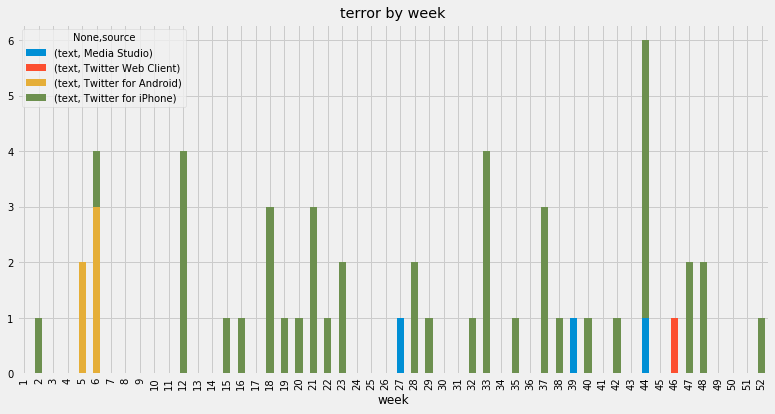

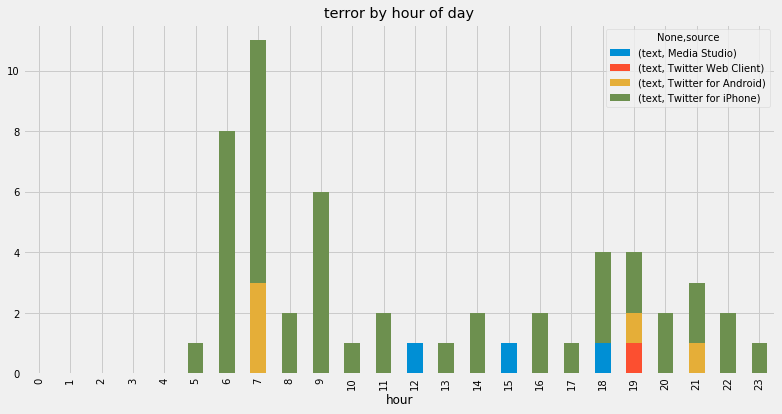

### The Tweets

[Tuesday, Aug 14, 2018 7:42 AM](https://twitter.com/realDonaldTrump/status/1029332350969237504): Another terrorist attack in London...These animals are crazy and must be dealt with through toughness and strength!

[Thursday, Jul 19, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1019936133147516929): The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........

[Sunday, May 13, 2018 8:03 PM](https://twitter.com/realDonaldTrump/status/995816799341088770): So sad to see the Terror Attack in Paris. At some point countries will have to open their eyes &amp; see what is really going on. This kind of sickness &amp; hatred is not compatible with a loving, peaceful, &amp; successful country! Changes to our thought process on terror must be made.

[Tuesday, May 8, 2018 6:11 PM](https://twitter.com/realDonaldTrump/status/993976643898281984): The Iran Deal is defective at its core. If we do nothing, we know what will happen. In just a short time, the world’s leading state sponsor of terror will be on the cusp of acquiring the world’s most dangerous weapons.... https://t.co/58qwBLzxIH

[Tuesday, May 8, 2018 7:09 AM](https://twitter.com/realDonaldTrump/status/993810085540491264): Gina Haspel, my highly respected nominee to lead the CIA, is being praised for the fact that she has been, and alway will be, TOUGH ON TERROR! This is a woman who has been a leader wherever she has gone. The CIA wants her to lead them into America’s  bright and glorious future!

[Monday, May 7, 2018 7:04 AM](https://twitter.com/realDonaldTrump/status/993446539988217857): My highly respected nominee for CIA Director, Gina Haspel, has come under fire because she was too tough on Terrorists. Think of that, in these very dangerous times, we have the most qualified person, a woman, who Democrats want OUT because she is too tough on terror. Win Gina!

[Saturday, Mar 31, 2018 8:53 AM](https://twitter.com/realDonaldTrump/status/980065427375128576): Governor Jerry “Moonbeam” Brown pardoned 5 criminal illegal aliens whose crimes include (1) Kidnapping and Robbery (2) Badly beating wife and threatening a crime with intent to terrorize (3) Dealing drugs. Is this really what the great people of California want? @FoxNews

[Sunday, Mar 25, 2018 6:10 AM](https://twitter.com/realDonaldTrump/status/977850135697911808): France honors a great hero. Officer died after bravely swapping places with hostage in ISIS related terror attack. So much bravery around the world constantly fighting radical Islamic terrorism. Even stronger measures needed, especially at borders!

[Tuesday, Jan 16, 2018 6:19 PM](https://twitter.com/realDonaldTrump/status/953406423177859073): New report from DOJ &amp; DHS shows that nearly 3 in 4 individuals convicted of terrorism-related charges are foreign-born. We have submitted to Congress a list of resources and reforms....

[Sunday, Dec 31, 2017 5:00 PM](https://twitter.com/realDonaldTrump/status/947588263103139841): Iran, the Number One State of Sponsored Terror with numerous violations of Human Rights occurring on an hourly basis, has now closed down the Internet so that peaceful demonstrators cannot communicate. Not good!

[Sunday, Dec 31, 2017 8:03 AM](https://twitter.com/realDonaldTrump/status/947453152806297600): Big protests in Iran. The people are finally getting wise as to how their money and wealth is being stolen and squandered on terrorism. Looks like they will not take it any longer. The USA is watching very closely for human rights violations!

[Friday, Dec 29, 2017 10:42 PM](https://twitter.com/realDonaldTrump/status/946949708915924994): Many reports of peaceful protests by Iranian citizens fed up with regime’s corruption &amp; its squandering of the nation’s wealth to fund terrorism abroad. Iranian govt should respect their people’s rights, including right to express themselves. The world is watching! #IranProtests

[Wednesday, Nov 29, 2017 8:02 PM](https://twitter.com/realDonaldTrump/status/936037588372283392): .@Theresa_May, don’t focus on me, focus on the destructive Radical Islamic Terrorism that is taking place within the United Kingdom. We are doing just fine!

[Wednesday, Nov 29, 2017 7:43 PM](https://twitter.com/realDonaldTrump/status/936032830844555264): Theresa @theresamay, don’t focus on me, focus on the destructive Radical Islamic Terrorism that is taking place within the United Kingdom. We are doing just fine!

[Friday, Nov 24, 2017 1:49 PM](https://twitter.com/realDonaldTrump/status/934131805409697792): Will be calling the President of Egypt in a short while to discuss the tragic terrorist attack, with so much loss of life. We have to get TOUGHER AND SMARTER than ever before, and we will. Need the WALL, need the BAN! God bless the people of Egypt.

[Friday, Nov 24, 2017 10:27 AM](https://twitter.com/realDonaldTrump/status/934080974773776384): Horrible and cowardly terrorist attack on innocent and defenseless worshipers in Egypt. The world cannot tolerate terrorism, we must defeat them militarily and discredit the extremist ideology that forms the basis of their existence!

[Saturday, Nov 11, 2017 7:18 PM](https://twitter.com/realDonaldTrump/status/929503641014112256): When will all the haters and fools out there realize that having a good relationship with Russia is a good thing, not a bad thing. There always playing politics - bad for our country. I want to solve North Korea, Syria, Ukraine, terrorism, and Russia can greatly help!

[Thursday, Nov 2, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/926053970535243777): Would love to send the NYC terrorist to Guantanamo but statistically that process takes much longer than going through the Federal system...

[Wednesday, Nov 1, 2017 11:43 PM](https://twitter.com/realDonaldTrump/status/925931294705545216): NYC terrorist was happy as he asked to hang ISIS flag in his hospital room. He killed 8 people, badly injured 12. SHOULD GET DEATH PENALTY!

[Wednesday, Nov 1, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/925907651350941696): Just spoke to President Macri of Argentina about the five proud and wonderful men killed in the West Side terror attack. God be with them!

[Wednesday, Nov 1, 2017 3:26 PM](https://twitter.com/realDonaldTrump/status/925806343855984647): We mourn the horrifying terrorist attack in NYC. All of America is praying and grieving for the families who lost their precious loved ones. https://t.co/WZFHXoJE3K

[Wednesday, Nov 1, 2017 7:24 AM](https://twitter.com/realDonaldTrump/status/925684982307348480): The terrorist came into our country through what is called the "Diversity Visa Lottery Program," a Chuck Schumer beauty. I want merit based.

[Tuesday, Oct 31, 2017 6:57 PM](https://twitter.com/realDonaldTrump/status/925497025386500096): My thoughts, condolences and prayers to the victims and families of the New York City terrorist attack. God and your country are with you!

[Friday, Oct 20, 2017 6:31 AM](https://twitter.com/realDonaldTrump/status/921323063945453574): Just out report: "United Kingdom crime rises 13% annually amid spread of Radical Islamic terror." Not good, we must keep America safe!

[Thursday, Oct 5, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/915887841896484866): RT @ABC: Pres. Trump: "We cannot be defined by the evil that threatens us or the violence that incites such terror." https://t.co/eduBJDysI…

[Tuesday, Sep 26, 2017 6:32 PM](https://twitter.com/realDonaldTrump/status/912807096885723137): I want to express our support and extend our prayers to all those affected by the vile terror attack in Spain last month. 🇺🇸🇪🇸 https://t.co/5mT0QXFlnL

[Sunday, Sep 17, 2017 9:03 AM](https://twitter.com/realDonaldTrump/status/909402439643750400): RT @realDonaldTrump: Loser terrorists must be dealt with in a much tougher manner.The internet is their main recruitment tool which we must…

[Friday, Sep 15, 2017 4:54 PM](https://twitter.com/realDonaldTrump/status/908796281002307584): Our hearts &amp; prayers go out to the people of London, who suffered a vicious terrorist attack.... https://t.co/Q2hTBV2l5t

[Friday, Sep 15, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/908643633901039617): Loser terrorists must be dealt with in a much tougher manner.The internet is their main recruitment tool which we must cut off &amp; use better!

[Friday, Sep 15, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/908642277987356673): Another attack in London by a loser terrorist.These are sick and demented people who were in the sights of Scotland Yard. Must be proactive!

[Monday, Aug 28, 2017 9:08 AM](https://twitter.com/realDonaldTrump/status/902156034348904450): RT @KatiePavlich: Your boss pardoned a traitor who gave U.S. enemies state secrets, he also pardoned a terrorist who killed Americans. Spar…

[Friday, Aug 18, 2017 9:30 PM](https://twitter.com/realDonaldTrump/status/898718902200418306): Today, I signed the Global War on Terrorism War Memorial Act (#HR873.) The bill authorizes....cont➡️https://t.co/c3zIkdtowc https://t.co/re6n0MS0cj

[Friday, Aug 18, 2017 9:06 AM](https://twitter.com/realDonaldTrump/status/898531481185689600): Radical Islamic Terrorism must be stopped by whatever means necessary! The courts must give us back our protective rights. Have to be tough!

[Thursday, Aug 17, 2017 2:45 PM](https://twitter.com/realDonaldTrump/status/898254409511129088): Study what General Pershing of the United States did to terrorists when caught. There was no more Radical Islamic Terror for 35 years!

[Thursday, Aug 17, 2017 2:00 PM](https://twitter.com/realDonaldTrump/status/898243270169563136): The United States condemns the terror attack in Barcelona, Spain, and will do whatever is necessary to help. Be tough &amp; strong, we love you!

[Saturday, Jul 22, 2017 6:45 AM](https://twitter.com/realDonaldTrump/status/888711488717934592): The Failing New York Times foiled U.S. attempt to kill the single most wanted terrorist,Al-Baghdadi.Their sick agenda over National Security

[Friday, Jul 14, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/885856351557210112): The United States mourns for the victims of Nice, France. We pledge our solidarity with France against terror. 🇺🇸🇫🇷 https://t.co/7irbz08oT3

[Thursday, Jul 6, 2017 12:02 PM](https://twitter.com/realDonaldTrump/status/882993144194838528): America is proud to stand shoulder-to-shoulder with Poland in the fight to eradicate the evils of terrorism and extremism. #POTUSinPoland https://t.co/MHxRmVvtsh

[Tuesday, Jun 6, 2017 9:44 AM](https://twitter.com/realDonaldTrump/status/872086906804240384): ...extremism, and all reference was pointing to Qatar. Perhaps this will be the beginning of the end to the horror of terrorism!

[Sunday, Jun 4, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/871328428963901440): At least 7 dead and 48 wounded in terror attack and Mayor of London says there is "no reason to be alarmed!"

[Saturday, Jun 3, 2017 7:01 PM](https://twitter.com/realDonaldTrump/status/871139911298101248): RT @DRUDGE_REPORT: Fears of new terror attack after van 'mows down 20 people' on London Bridge...

[Saturday, May 27, 2017 5:58 AM](https://twitter.com/realDonaldTrump/status/868406076995235840): Big G7 meetings today. Lots of very important matters under discussion. First on the list, of course, is terrorism. #G7Taormina

[Friday, May 26, 2017 4:26 PM](https://twitter.com/realDonaldTrump/status/868201805934678017): Terrorists are engaged in a war against civilization- it is up to all who value life to confront &amp; defeat this evil➡️https://t.co/haeuvCIF6I

[Friday, May 26, 2017 6:14 AM](https://twitter.com/realDonaldTrump/status/868047612301148160): Getting ready to engage G7 leaders on many issues including economic growth, terrorism, and security.

[Tuesday, May 16, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/864438529472049152): ...to terrorism and airline flight safety. Humanitarian reasons, plus I want Russia to greatly step up their fight against ISIS &amp; terrorism.

[Friday, Apr 21, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/855368516920332289): Another terrorist attack in Paris. The people of France will not take much more of this. Will have a big effect on presidential election!

[Sunday, Apr 9, 2017 11:20 AM](https://twitter.com/realDonaldTrump/status/851092500056072198): So sad to hear of the terrorist attack in Egypt. U.S. strongly condemns. I have great...

[Thursday, Mar 23, 2017 11:16 AM](https://twitter.com/realDonaldTrump/status/844930836663357440): A great American, Kurt Cochran, was killed in the London terror attack. My prayers and condolences are with his family and friends.

[Wednesday, Mar 22, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/844723847094026242): Spoke to U.K. Prime Minister Theresa May today to offer condolences on the terrorist attack in London. She is strong and doing very well.

[Tuesday, Feb 7, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/828939235499638784): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1 in terror, no problem!

[Tuesday, Feb 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/828937357147635713): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1in terror, no problem!

[Monday, Feb 6, 2017 9:49 PM](https://twitter.com/realDonaldTrump/status/828797801630937089): The threat from radical Islamic terrorism is very real, just look at what is happening in Europe and the Middle-East. Courts must act fast!

[Saturday, Feb 4, 2017 7:48 PM](https://twitter.com/realDonaldTrump/status/828042506851934209): The judge opens up our country to potential terrorists and others that do not have our best interests at heart. Bad people are very happy!

[Friday, Feb 3, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/827499871011819520): A new radical Islamic terrorist has just attacked in Louvre Museum in Paris. Tourists were locked down. France on edge again. GET SMART U.S.

[Monday, Jan 30, 2017 7:27 AM](https://twitter.com/realDonaldTrump/status/826044059647107073): There is nothing nice about searching for terrorists before they can enter our country. This was a big part of my campaign. Study the world!

---

## Search: _ivanka_

Number of Tweets: 46

Percent of all Tweets: 1.06%

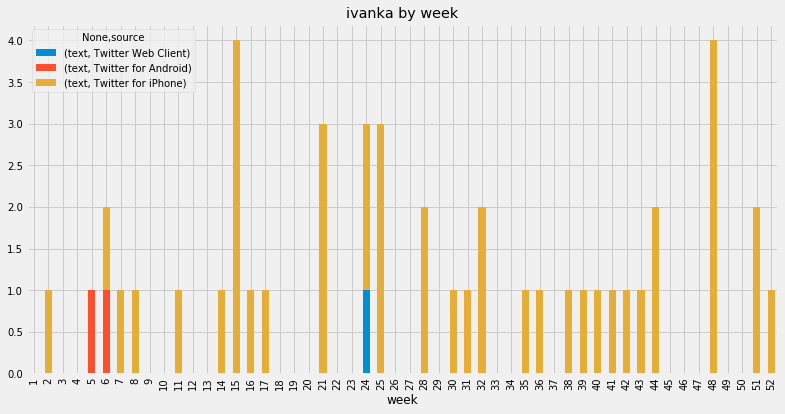

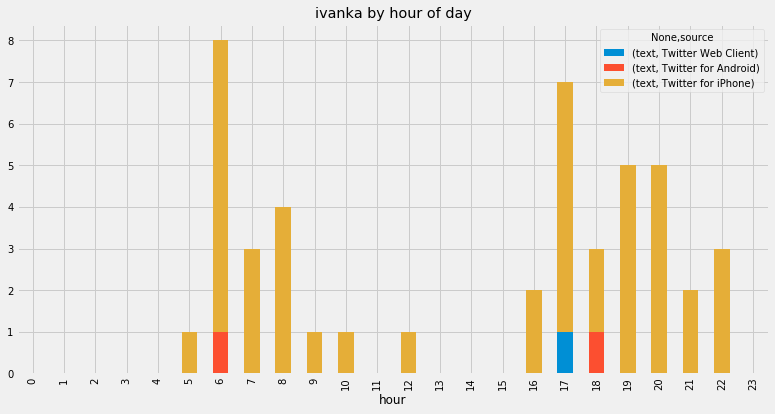

### The Tweets

[Thursday, Aug 2, 2018 4:24 PM](https://twitter.com/realDonaldTrump/status/1025115155632455680): They asked my daughter Ivanka whether or not the media is the enemy of the people. She correctly said no. It is the FAKE NEWS, which is a large percentage of the media, that is the enemy of the people!

[Friday, Jul 20, 2018 5:51 PM](https://twitter.com/realDonaldTrump/status/1020425915279519745): RT @IvankaTrump: .@WhiteHouse National Council for the American Worker together w/ the private sector is working to equip students + worker…

[Saturday, Jun 30, 2018 6:49 AM](https://twitter.com/realDonaldTrump/status/1013011689690845184): RT @IvankaTrump: Thank you @SecPompeo. 
It was an honor to join you and your talented, passionate colleagues at @StateDept to honor the her…

[Saturday, Jun 30, 2018 6:49 AM](https://twitter.com/realDonaldTrump/status/1013011596363395073): RT @IvankaTrump: Thank you Senator Alexander for your leadership on career + technical education. 11+ million students and workers across o…

[Friday, Jun 29, 2018 7:21 PM](https://twitter.com/realDonaldTrump/status/1012838511588839424): RT @FoxBusiness: .@IvankaTrump: "I think one of the tremendous opportunities that were seeing because the economy is so strong is that peop…

[Thursday, May 31, 2018 6:58 AM](https://twitter.com/realDonaldTrump/status/1002142304726061059): RT @dougmillsnyt: Children race as @realDonaldTrump looks on with @IvankaTrump and New York Yankees legend Mariano Rivera they as they part…

[Thursday, May 31, 2018 6:56 AM](https://twitter.com/realDonaldTrump/status/1002141845655351296): RT @IvankaTrump: Today @POTUS hosted #FieldDay at the @WhiteHouse with the announced President’s Council on Sports, Fitness and Nutrition.…

[Thursday, May 31, 2018 6:56 AM](https://twitter.com/realDonaldTrump/status/1002141779406270469): RT @HerschelWalker: What an awesome day in D.C. participating @WhiteHouse Sports &amp; Fitness Day with @IvankaTrump @POTUS @MistyMayTreanor @M…

[Wednesday, Apr 18, 2018 5:43 AM](https://twitter.com/realDonaldTrump/status/986540705538506752): RT @IvankaTrump: This year’s #TaxDay is the last time you’ll have to file your taxes through an outdated, broken system. #BYE-BYE https://t…

[Tuesday, Apr 17, 2018 5:55 PM](https://twitter.com/realDonaldTrump/status/986362521417371648): RT @IvankaTrump: Great to be with Secretary Mnuchin &amp; former Governor Sununu in Derry, NH on #TaxDay to highlight the tremendous benefits o…

[Tuesday, Apr 17, 2018 5:55 PM](https://twitter.com/realDonaldTrump/status/986362433479610370): RT @FoxBusiness: WATCH LIVE: @IvankaTrump and @stevenmnuchin1 host tax event on Tax Day in New Hampshire. (Courtesy: WBZ) https://t.co/C3zr…

[Monday, Apr 16, 2018 8:57 PM](https://twitter.com/realDonaldTrump/status/986046000518303745): RT @IvankaTrump: Looking forward to traveling to Manchester, NH tomorrow with Sec @stevenmnuchin1 to celebrate the last #TaxDay under the o…

[Thursday, Mar 1, 2018 9:59 PM](https://twitter.com/realDonaldTrump/status/969406846602752000): RT @IvankaTrump: My OpEd on the importance of #YouthSports participation and how this Administration is seeking to lift barriers so all our…

[Friday, Feb 23, 2018 8:07 AM](https://twitter.com/realDonaldTrump/status/967023015035797504): My daughter, Ivanka, just arrived in South Korea. We cannot have a better, or smarter, person representing our country.

[Monday, Jan 15, 2018 7:47 PM](https://twitter.com/realDonaldTrump/status/953066265987420160): RT @Heritage: We had a special visitor yesterday. @IvankaTrump, thank you for meeting with @KayColesJames, spending time with our team, and…

[Thursday, Dec 28, 2017 5:16 PM](https://twitter.com/realDonaldTrump/status/946505155809247232): RT @IvankaTrump: “The Trump economy is booming.” One thing @realDonaldTrump “has done that has received little attention despite arguably d…

[Monday, Dec 18, 2017 5:18 PM](https://twitter.com/realDonaldTrump/status/942881716913438720): So true Ivanka! https://t.co/BNGUJG69Ki

[Monday, Dec 18, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/942721681130483712): Ivanka Trump will be interviewed on @foxandfriends.

[Tuesday, Nov 28, 2017 10:30 PM](https://twitter.com/realDonaldTrump/status/935712632409030656): Great work Ivanka! https://t.co/AQL4JLvnDh

[Tuesday, Nov 28, 2017 6:45 PM](https://twitter.com/realDonaldTrump/status/935656027026051072): RT @narendramodi: Had a wonderful meeting with @IvankaTrump, advisor to @POTUS and leader of the US delegation at the @GES2017. https://t.c…

[Tuesday, Nov 28, 2017 9:18 AM](https://twitter.com/realDonaldTrump/status/935513191374819328): RT @IvankaTrump: It was an honor to meet with you Prime Minister Modi. Thank you for co-hosting the 8th annual Global Entrepreneurship Summ…

[Tuesday, Nov 28, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/935495996116742144): RT @IvankaTrump: Thank you for the warm welcome. I’m excited to be in Hyderabad, India for #GES2017. https://t.co/1U08h5L9Rm

[Saturday, Nov 4, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/926783758530781184): RT @IvankaTrump: Touched by the warm hospitality of Prime Minister Abe and the Japanese people. ありがとうございます [Thank you]! Until next time 🇯🇵…

[Tuesday, Oct 31, 2017 12:55 PM](https://twitter.com/realDonaldTrump/status/925405818446663685): RT @IvankaTrump: We're working to make tax cuts &amp; the expanded Child Tax Credit a reality for American families. The time is now! #TaxRefor…

[Wednesday, Oct 25, 2017 9:26 PM](https://twitter.com/realDonaldTrump/status/923360048771936256): RT @IvankaTrump: Working families need #TaxReform &amp; the time is now. This Administration is committed to ensuring all Americans can thrive…

[Sunday, Oct 15, 2017 8:55 PM](https://twitter.com/realDonaldTrump/status/919728356765073408): RT @ABCNewsRadio: Global fund championed by Ivanka Trump to help women entrepreneurs begins operations https://t.co/jUmsY3ON4x https://t.co…

[Monday, Oct 9, 2017 10:31 PM](https://twitter.com/realDonaldTrump/status/917578384800124929): RT @IvankaTrump: .@realDonaldTrump stock market rally is close to becoming the greatest in 85 years https://t.co/5WlZa82Mij

[Tuesday, Oct 3, 2017 8:26 PM](https://twitter.com/realDonaldTrump/status/915372545704173570): RT @IvankaTrump: 3/4: This Administration is deeply committed to those who serve &amp; their families who make it possible through their love a…

[Thursday, Sep 28, 2017 7:47 PM](https://twitter.com/realDonaldTrump/status/913550853239443457): RT @IvankaTrump: Thank you to the amazing men and women working tirelessly to bring relief to those in need. #PuertoRico #HurricaneMaria ht…

[Tuesday, Sep 19, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/910101913923997696): RT @IvankaTrump: I have long respected India's accomplished and charismatic Foreign Minister @SushmaSwaraj, and it was an honor to meet her…

[Thursday, Sep 7, 2017 8:53 AM](https://twitter.com/realDonaldTrump/status/905775939862310912): RT @GOP: .@IvankaTrump: This administration is committed to keeping working families at the forefront of our agenda.
https://t.co/rHqFqUJGWI

[Wednesday, Aug 30, 2017 8:50 PM](https://twitter.com/realDonaldTrump/status/903057301032108032): RT @IvankaTrump: We must reform our tax code so that all Americans can succeed in our modern economy &amp; achieve the American Dream! #TaxRefo…

[Thursday, Aug 10, 2017 4:18 PM](https://twitter.com/realDonaldTrump/status/895741164103639042): .@IvankaTrump will lead the U.S. delegation to India this fall, supporting women’s entrepreneurship globally.
#GES2017 @narendramodi

[Sunday, Aug 6, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/894328101949374465): RT @IvankaTrump: The Administration is committed to supporting military spouses in the workforce. Thanks Kim for sharing your story! https:…

[Friday, Aug 4, 2017 7:30 PM](https://twitter.com/realDonaldTrump/status/893615145053716480): RT @IvankaTrump: Since @realDonaldTrump inauguration, over 1 million net new jobs have been created in the American economy! #MAGA

[Monday, Jul 10, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/884374529660903424): When I left Conference Room for short meetings with Japan and other countries, I asked Ivanka to hold seat. Very standard. Angela M agrees!

[Thursday, Jun 15, 2017 5:43 PM](https://twitter.com/realDonaldTrump/status/875468769212149760): Thank you Wisconsin! Tuesday was a great success for #WorkforceWeek at @WCTC w/ @IvankaTrump &amp; @GovWalker. 
Remarks… https://t.co/L8o396yYKX

[Monday, Jun 12, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/874218586155479040): Ivanka on @foxandfriends now!

[Sunday, Jun 11, 2017 10:02 PM](https://twitter.com/realDonaldTrump/status/874084433460154368): My daughter, Ivanka, will be on @foxandfriends tomorrow morning. Enjoy!

[Tuesday, Apr 25, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/856830933709750272): Proud of @IvankaTrump for her leadership on these important issues. Looking forward to hearing her speak at the W20! https://t.co/e6Uajrm8zp

[Friday, Apr 21, 2017 8:19 PM](https://twitter.com/realDonaldTrump/status/855576880048738304): RT @Scavino45: .@POTUS @realDonaldTrump, @IvankaTrump, Jared Kushner, &amp; Dina Powell in the Oval Office today w/ Aya &amp; her brother Basel.
#W…

[Friday, Apr 7, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/850489084221018113): RT @IvankaTrump: Very proud of Arabella and Joseph for their performance in honor of President Xi Jinping and Madame Peng Liyuan's official…

[Thursday, Mar 16, 2017 5:43 PM](https://twitter.com/realDonaldTrump/status/842491443675611138): RT @USHCC: USHCC was delighted to host @IvankaTrump for a roundtable discussion w/ Hispanic women biz owners today in Washington #USHCCLegi…

[Saturday, Feb 11, 2017 6:00 PM](https://twitter.com/realDonaldTrump/status/830552079240409089): I am so proud of my daughter Ivanka. To be abused and treated so badly by the media, and to still hold her head so high, is truly wonderful!

[Wednesday, Feb 8, 2017 10:51 AM](https://twitter.com/realDonaldTrump/status/829356871848951809): My daughter Ivanka has been treated so unfairly by @Nordstrom. She is a great person -- always pushing me to do the right thing! Terrible!

[Thursday, Feb 2, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/827115768202534913): Attending Chief Ryan Owens' Dignified Transfer yesterday with my daughter Ivanka was my great honor. To a great and brave man - thank you!

---

## Search: _ms 13_

Number of Tweets: 5

Percent of all Tweets: 0.11%

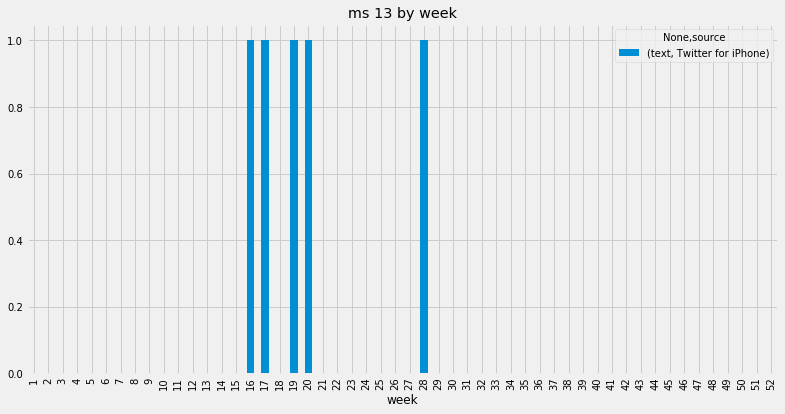

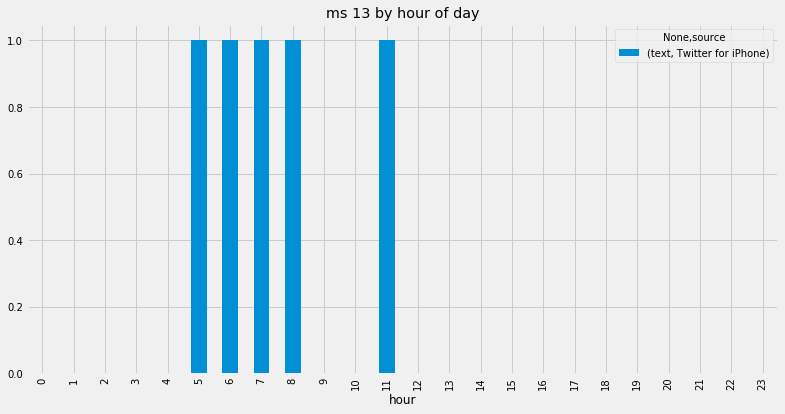

### The Tweets

[Friday, May 25, 2018 8:04 AM](https://twitter.com/realDonaldTrump/status/999984507574018049): Democrats are so obviously rooting against us in our negotiations with North Korea. Just like they are coming to the defense of MS 13 thugs, saying that they are individuals &amp; must be nurtured, or asking to end your big Tax Cuts &amp; raise your taxes instead. Dems have lost touch!

[Friday, May 18, 2018 6:51 AM](https://twitter.com/realDonaldTrump/status/997429518867591170): Fake News Media had me calling Immigrants, or Illegal Immigrants, “Animals.” Wrong! They were begrudgingly forced to withdraw their stories. I referred to MS 13 Gang Members as “Animals,” a big difference - and so true. Fake News got it purposely wrong, as usual!

[Wednesday, Jul 12, 2017 7:05 AM](https://twitter.com/realDonaldTrump/status/885092844511387654): ISIS is on the run &amp; will soon be wiped out of Syria &amp; Iraq, illegal border crossings are way down (75%) &amp; MS 13 gangs are being removed.

[Sunday, Apr 23, 2017 11:42 AM](https://twitter.com/realDonaldTrump/status/856171332521820165): The Democrats don't want money from budget going to border wall despite the fact that it will stop drugs and very bad MS 13 gang members.

[Tuesday, Apr 18, 2017 5:39 AM](https://twitter.com/realDonaldTrump/status/854268119774367745): The weak illegal immigration policies of the Obama Admin. allowed bad MS 13 gangs to form in cities across U.S. We are removing them fast!

---

## Search: _russia_

Number of Tweets: 233

Percent of all Tweets: 5.36%

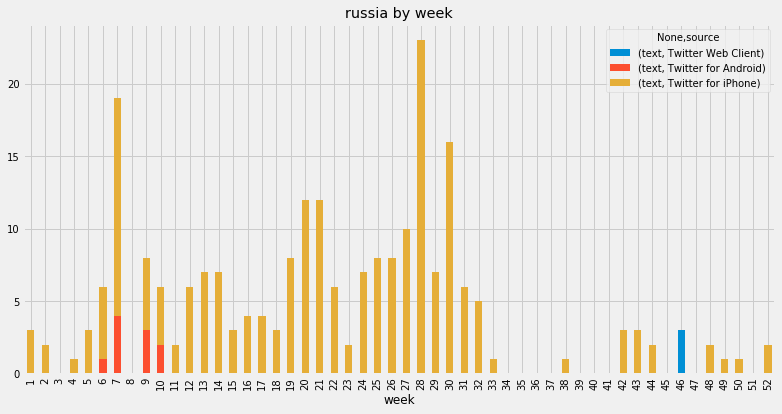

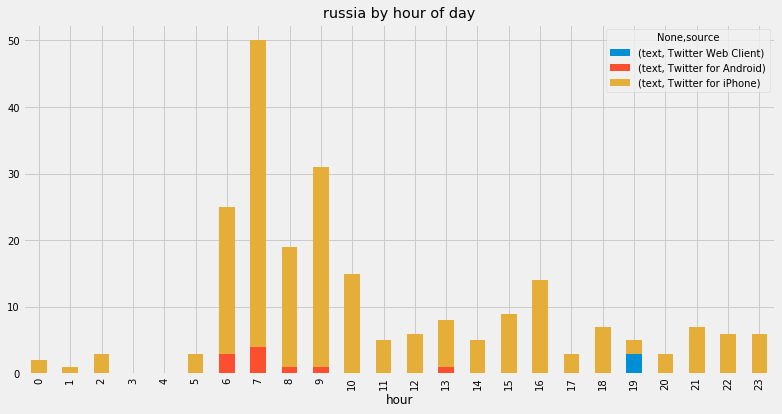

### The Tweets

[Tuesday, Aug 14, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1029355952414371841): Lou Dobbs: “This cannot go forward...this Special Counsel with all of his conflicts, with his 17 Angry Democrats, without any evidence of collusion by the Trump Campaign and Russia. The Dems are the ones who should be investigated.” Thank you Lou, so true!

[Tuesday, Aug 14, 2018 9:01 AM](https://twitter.com/realDonaldTrump/status/1029352395464224769): Fired FBI Agent Peter Strzok is a fraud, as is the rigged investigation he started. There was no Collusion or Obstruction with Russia, and everybody, including the Democrats, know it. The only Collusion and Obstruction was by Crooked Hillary, the Democrats and the DNC!

[Tuesday, Aug 14, 2018 7:21 AM](https://twitter.com/realDonaldTrump/status/1029327223269060609): Lou Dobbs: “This cannot go forward...this Special Councel with all of his conflicts, with his 17 Angry Democrats, without any evidence of collusion by the Trump Campaign and Russia. The Dems are the ones who should be investigated.” Thank you Lou, so true!

[Friday, Aug 10, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/1027884715553050625): .@MariaBartiromo  “No evidence to launch even an investigation into potential collusion between Donald Trump and the Russians - and here we are, a year and a half later.”

[Thursday, Aug 9, 2018 9:22 AM](https://twitter.com/realDonaldTrump/status/1027545694201159680): “There has been no evidence whatsoever that Donald Trump or the campaign was involved in any kind of collusion to fix the 2016 election. In fact the evidence is the opposite, that Hillary Clinton &amp; the Democrats colluded with the Russians to fix the 2016 election.” @GrahamLedger

[Monday, Aug 6, 2018 10:25 AM](https://twitter.com/realDonaldTrump/status/1026474458326986752): ....a law firm, eventually Kremlin connected sources, to gather info on Donald Trump. Collusion is very real with Russia, but only with Hillary and the Democrats, and we should demand a full investigation.” Dan Bongino on @foxandfriends  Looking forward to the new IG Report!

[Monday, Aug 6, 2018 10:13 AM](https://twitter.com/realDonaldTrump/status/1026471244949061632): “Collusion with Russia was very real. Hillary Clinton and her team 100% colluded with the Russians, and so did Adam Schiff who is on tape trying to collude with what he thought was Russians to obtain compromising material on DJT. We also know that Hillary Clinton paid through....

[Friday, Aug 3, 2018 11:28 PM](https://twitter.com/realDonaldTrump/status/1025584134322892800): ...Dianne is the person leading our Nation on “Collusion” with Russia (only done by Dems). Will she now investigate herself? https://t.co/OG6l04bBwg

[Friday, Aug 3, 2018 11:01 PM](https://twitter.com/realDonaldTrump/status/1025577505615503360): Congratulations to Gregg Jarrett on his book, “THE RUSSIA HOAX, THE ILLICIT SCHEME TO CLEAR HILLARY CLINTON AND FRAME DONALD TRUMP,” going to #1 on @nytimes and Amazon. It is indeed a HOAX and WITCH HUNT, illegally started by people who have already been disgraced. Great book!

[Thursday, Aug 2, 2018 12:38 AM](https://twitter.com/realDonaldTrump/status/1024877011775500290): Congratulations to  @GreggJarrett on The TREMENDOUS success of his just out book, “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump.” Already number one on Amazon. Hard work from a brilliant guy. It’s the Real Story of the Rigged Witch Hunt!

[Wednesday, Aug 1, 2018 11:56 AM](https://twitter.com/realDonaldTrump/status/1024685313778741250): “We already have a smoking gun about a campaign getting dirt on their opponent, it was Hillary Clinton. How is it OK for Hillary Clinton to proactively seek dirt from the Russians but the Trump campaign met at the Russians request and that is bad?” Marc Thiessen, Washington Post

[Wednesday, Aug 1, 2018 11:35 AM](https://twitter.com/realDonaldTrump/status/1024680095343108097): Looking back on history, who was treated worse, Alfonse Capone, legendary mob boss, killer and “Public Enemy Number One,” or Paul Manafort, political operative &amp; Reagan/Dole darling, now serving solitary confinement - although convicted of nothing? Where is the Russian Collusion?

[Wednesday, Aug 1, 2018 11:23 AM](https://twitter.com/realDonaldTrump/status/1024676935065120768): “We already have a smocking gun about a campaign getting dirt on their opponent, it was Hillary Clinton. How is it OK for Hillary Clinton to proactively seek dirt from the Russians but the Trump campaign met at the Russians request and that is bad?” Marc Thiessen, Washington Post

[Wednesday, Aug 1, 2018 10:01 AM](https://twitter.com/realDonaldTrump/status/1024656465158721536): Russian Collusion with the Trump Campaign, one of the most successful in history, is a TOTAL HOAX. The Democrats paid for the phony and discredited Dossier which was, along with Comey, McCabe, Strzok and his lover, the lovely Lisa Page, used to begin the Witch Hunt. Disgraceful!

[Sunday, Jul 29, 2018 4:20 PM](https://twitter.com/realDonaldTrump/status/1023664624259014656): ....Also, why is Mueller only appointing Angry Dems, some of whom have worked for Crooked Hillary, others, including himself, have worked for Obama....And why isn’t Mueller looking at all of the criminal activity &amp; real Russian Collusion on the Democrats side-Podesta, Dossier?

[Friday, Jul 27, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1022808452677160960): ....,the only Collusion with Russia was with the Democrats, so now they are looking at my Tweets (along with 53 million other people) - the rigged Witch Hunt continues! How stupid and unfair to our Country....And so the Fake News doesn’t waste my time with dumb questions, NO,....

[Tuesday, Jul 24, 2018 9:05 PM](https://twitter.com/realDonaldTrump/status/1021924262045802496): “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump” is a Hot Seller, already Number One! More importantly, it is a great book that everyone is talking about. It covers the Rigged Witch Hunt brilliantly. Congratulations to Gregg Jarrett!

[Tuesday, Jul 24, 2018 11:50 AM](https://twitter.com/realDonaldTrump/status/1021784726217142273): I’m very concerned that Russia will be fighting very hard to have an impact on the upcoming Election. Based on the fact that no President has been tougher on Russia than me, they will be pushing very hard for the Democrats. They definitely don’t want Trump!

[Monday, Jul 23, 2018 7:09 AM](https://twitter.com/realDonaldTrump/status/1021351630648815616): .....”Carter Page wasn’t a spy, wasn’t an agent of the Russians - he would have cooperated with the FBI. It was a fraud and a hoax designed to target Trump.” Tom Fitton @JudicialWatch A disgrace to America. They should drop the discredited Mueller Witch Hunt now!

[Sunday, Jul 22, 2018 6:23 PM](https://twitter.com/realDonaldTrump/status/1021158915206152193): So President Obama knew about Russia before the Election. Why didn’t he do something about it? Why didn’t he tell our campaign? Because it is all a big hoax, that’s why, and he thought Crooked Hillary was going to win!!!

[Friday, Jul 20, 2018 10:39 AM](https://twitter.com/realDonaldTrump/status/1020317159828992000): RT @realDonaldTrump: The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forw…

[Thursday, Jul 19, 2018 9:35 AM](https://twitter.com/realDonaldTrump/status/1019938748413435910): “Trump recognized Russian Meddling MANY TIMES” https://t.co/T8MERS93wI

[Thursday, Jul 19, 2018 9:27 AM](https://twitter.com/realDonaldTrump/status/1019936658240794625): “Trump recognized Russian Meddling MANY TIMES.” https://t.co/Da8T8SUsCE

[Thursday, Jul 19, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1019936133147516929): The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........

[Thursday, Jul 19, 2018 7:13 AM](https://twitter.com/realDonaldTrump/status/1019903123312308224): “Trump recognized Russian Meddling MANY TIMES.” Thank you to @foxandfriends and @FoxNews for actually showing the clips. The Fake News wants no part of that narrative! Too bad they don’t want to focus on all of the ECONOMIC and JOBS records being set.

[Thursday, Jul 19, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1019899507910283264): The Fake News Media wants so badly to see a major confrontation with Russia, even a confrontation that could lead to war. They are pushing so recklessly hard and hate the fact that I’ll probably have a good relationship with Putin. We are doing MUCH better than any other country!

[Wednesday, Jul 18, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/1019544304853966853): Some people HATE the fact that I got along well with President Putin of Russia. They would rather go to war than see this. It’s called Trump Derangement Syndrome!

[Wednesday, Jul 18, 2018 6:16 AM](https://twitter.com/realDonaldTrump/status/1019526399542091776): ....Russia has agreed to help with North Korea, where relationships with us are very good and the process is moving along. There is no rush, the sanctions remain! Big benefits and exciting future for North Korea at end of process!

[Wednesday, Jul 18, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/1019524328927453184): While the NATO meeting in Brussels was an acknowledged triumph, with billions of dollars more being put up by member countries at a faster pace, the meeting with Russia may prove to be, in the long run, an even greater success. Many positive things will come out of that meeting..

[Tuesday, Jul 17, 2018 10:22 AM](https://twitter.com/realDonaldTrump/status/1019225830298456066): While I had a great meeting with NATO, raising vast amounts of money, I had an even better meeting with Vladimir Putin of Russia. Sadly, it is not being reported that way - the Fake News is going Crazy!

[Tuesday, Jul 17, 2018 9:53 AM](https://twitter.com/realDonaldTrump/status/1019218575691837443): I had a great meeting with NATO. They have paid $33 Billion more and will pay hundreds of Billions of Dollars more in the future, only because of me. NATO was weak, but now it is strong again (bad for Russia). The media only says I was rude to leaders, never mentions the money!

[Monday, Jul 16, 2018 4:34 PM](https://twitter.com/realDonaldTrump/status/1018956970143858688): A productive dialogue is not only good for the United States and good for Russia, but it is good for the world. #HELSINKI2018 https://t.co/Q2Y1PhM9au

[Monday, Jul 16, 2018 2:05 AM](https://twitter.com/realDonaldTrump/status/1018738368753078273): Our relationship with Russia has NEVER been worse thanks to many years of U.S. foolishness and stupidity and now, the Rigged Witch Hunt!

[Monday, Jul 16, 2018 1:37 AM](https://twitter.com/realDonaldTrump/status/1018731223890481153): President Obama thought that Crooked Hillary was going to win the election, so when he was informed by the FBI about Russian Meddling, he said it couldn’t happen, was no big deal, &amp; did NOTHING about it. When I won it became a big deal and the Rigged Witch Hunt headed by Strzok!

[Monday, Jul 16, 2018 12:28 AM](https://twitter.com/realDonaldTrump/status/1018713940522622977): RT @SecPompeo: Landed in #Finland for #helsinki2018 where @POTUS &amp; Prez Putin are set to discuss US/Russian relations. POTUS meeting is in…

[Sunday, Jul 15, 2018 1:03 PM](https://twitter.com/realDonaldTrump/status/1018541464416997376): Congratulations to France, who played extraordinary soccer, on winning the 2018 World Cup. Additionally, congratulations to President Putin and Russia for putting on a truly great World Cup Tournament -- one of the best ever!

[Sunday, Jul 15, 2018 12:18 PM](https://twitter.com/realDonaldTrump/status/1018530167902228480): Heading to Helsinki, Finland – looking forward to meeting with President Putin tomorrow. Unfortunately, no matter how well I do at the Summit, if I was given the great city of Moscow as retribution for all of the sins and evils committed by Russia...

[Sunday, Jul 15, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/1018490597865226245): RT @realDonaldTrump: The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Admini…

[Sunday, Jul 15, 2018 9:33 AM](https://twitter.com/realDonaldTrump/status/1018488667474522112): RT @realDonaldTrump: These Russian individuals did their work during the Obama years. Why didn’t Obama do something about it?  Because he t…

[Saturday, Jul 14, 2018 2:17 PM](https://twitter.com/realDonaldTrump/status/1018197842559725569): These Russian individuals did their work during the Obama years. Why didn’t Obama do something about it?  Because he thought Crooked Hillary Clinton would win, that’s why. Had nothing to do with the Trump Administration, but Fake News doesn’t want to report the truth, as usual!

[Saturday, Jul 14, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/1018074723140427776): The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administration. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?

[Saturday, Jul 14, 2018 5:53 AM](https://twitter.com/realDonaldTrump/status/1018070907741523968): The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administrations. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?

[Saturday, Jul 14, 2018 5:17 AM](https://twitter.com/realDonaldTrump/status/1018061893750149120): RT @realDonaldTrump: ....On top of it all, Germany just started paying Russia, the country they want protection from, Billions of Dollars f…

[Thursday, Jul 12, 2018 2:12 AM](https://twitter.com/realDonaldTrump/status/1017290478839050240): ....On top of it all, Germany just started paying Russia, the country they want protection from, Billions of Dollars for their Energy needs coming out of a new pipeline from Russia. Not acceptable! All NATO Nations must meet their 2% commitment, and that must ultimately go to 4%!

[Thursday, Jul 12, 2018 2:03 AM](https://twitter.com/realDonaldTrump/status/1017288317342224384): Presidents have been trying unsuccessfully for years to get Germany and other rich NATO Nations to pay more toward their protection from Russia. They pay only a fraction of their cost. The U.S. pays tens of Billions of Dollars too much to subsidize Europe, and loses Big on Trade!

[Wednesday, Jul 11, 2018 7:33 PM](https://twitter.com/realDonaldTrump/status/1017190186269184001): Billions of additional dollars are being spent by NATO countries since my visit last year, at my request, but it isn’t nearly enough. U.S. spends too much. Europe’s borders are BAD! Pipeline dollars to Russia are not acceptable!

[Wednesday, Jul 11, 2018 5:11 PM](https://twitter.com/realDonaldTrump/status/1017154540284542981): RT @realDonaldTrump: What good is NATO if Germany is paying Russia billions of dollars for gas and energy? Why are there only 5 out of 29 c…

[Wednesday, Jul 11, 2018 1:07 PM](https://twitter.com/realDonaldTrump/status/1017093020783710209): What good is NATO if Germany is paying Russia billions of dollars for gas and energy? Why are there only 5 out of 29 countries that have met their commitment? The U.S. is paying for Europe’s protection, then loses billions on Trade. Must pay 2% of GDP IMMEDIATELY, not by 2025.

[Wednesday, Jul 11, 2018 12:50 PM](https://twitter.com/realDonaldTrump/status/1017088833890942981): What good is NATO if Germany is paying Russia billions of dollars for gas and energy? Why are their only 5 out of 29 countries that have met their commitment? The U.S. is paying for Europe’s protection, then loses billions on Trade. Must pay 2% of GDP IMMEDIATELY, not by 2025.

[Saturday, Jul 7, 2018 4:42 PM](https://twitter.com/realDonaldTrump/status/1015697664514674689): Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Counsel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!

[Saturday, Jul 7, 2018 4:29 PM](https://twitter.com/realDonaldTrump/status/1015694335151656961): Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Councel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!

[Friday, Jul 6, 2018 12:57 PM](https://twitter.com/realDonaldTrump/status/1015278594795417600): Just won lawsuit filed by the DNC and a bunch of Democrat crazies trying to claim the Trump Campaign (and others), colluded with Russia. They haven’t figured out that this was an excuse for them losing the election!

[Thursday, Jun 28, 2018 7:25 AM](https://twitter.com/realDonaldTrump/status/1012295859072126977): Russia continues to say they had nothing to do with Meddling in our Election! Where is the DNC Server, and why didn’t Shady James Comey and the now disgraced FBI agents take and closely examine it? Why isn’t Hillary/Russia being looked at? So many questions, so much corruption!

[Saturday, Jun 23, 2018 9:43 PM](https://twitter.com/realDonaldTrump/status/1010699954157830144): Major Wall Street Journal opinion piece today talking about the Russian Witch Hunt and the disgrace that it is. So many people hurt, so bad for our country - a total sham!
https://t.co/bcpSGtoX6a

[Saturday, Jun 23, 2018 7:36 AM](https://twitter.com/realDonaldTrump/status/1010486772541816834): The Russian Witch Hunt is Rigged!

[Saturday, Jun 23, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/1010485876806348800): .@FoxNews  Poll numbers plummet on the Democrat inspired and paid for Russian Witch Hunt. With all of the bias, lying and hate by the investigators, people want the investigators investigated. Much more will come out. A total scam and excuse for the Dems losing the Election!

[Sunday, Jun 17, 2018 10:54 AM](https://twitter.com/realDonaldTrump/status/1008362351807037441): WITCH HUNT! There was no Russian Collusion. Oh, I see, there was no Russian Collusion, so now they look for obstruction on the no Russian Collusion. The phony Russian Collusion was a made up Hoax. Too bad they didn’t look at Crooked Hillary like this. Double Standard!

[Friday, Jun 15, 2018 6:35 AM](https://twitter.com/realDonaldTrump/status/1007572229935202304): FBI Agent Peter Strzok, who headed the Clinton &amp; Russia investigations, texted to his lover Lisa Page, in the IG Report, that “we’ll stop” candidate Trump from becoming President. Doesn’t get any lower than that!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278701996802048): So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, illegally leak (Comey) classified information so that a Special Councel will be appointed, and then Collude to make this pile of garbage take on life in Fake News!

[Friday, Jun 8, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/1005047468705439744): I am heading for Canada and the G-7 for talks that will mostly center on the long time unfair trade practiced against the United States. From there I go to Singapore and talks with North Korea on Denuclearization. Won’t be talking about the Russian Witch Hunt Hoax for a while!

[Tuesday, Jun 5, 2018 7:31 AM](https://twitter.com/realDonaldTrump/status/1003962584352030720): The Russian Witch Hunt Hoax continues, all because Jeff Sessions didn’t tell me he was going to recuse himself...I would have quickly picked someone else. So much time and money wasted, so many lives ruined...and Sessions knew better than most that there was No Collusion!

[Monday, Jun 4, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/1003738642903420928): The Fake News Media is desperate to distract from the economy and record setting economic numbers and so they keep talking about the phony Russian Witch Hunt.

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1002892787803676673): ....“$17 million spent, it’s a scam Investigation. Americans are being worked. We now know there was Russian collusion, with Russians and the Democrats. The Mueller team is stacked with anti-Trumpers, who actually represented Clinton people (&amp; gave $’s to Crooked H).” Dan Bongino

[Friday, Jun 1, 2018 7:05 AM](https://twitter.com/realDonaldTrump/status/1002506360351846400): A.P. has just reported that the Russian Hoax Investigation has now cost our government over $17 million, and going up fast. No Collusion, except by the Democrats!

[Thursday, May 31, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/1002160516733853696): Not that it matters but I never fired James Comey because of Russia! The Corrupt Mainstream Media loves to keep pushing that narrative, but they know it is not true!

[Thursday, May 31, 2018 6:55 AM](https://twitter.com/realDonaldTrump/status/1002141448232493056): RUSH LIMBAUGH  “If the FBI was so concerned, and if they weren’t targeting Trump, they should have told Trump. If they were really concerned about the Russians infiltrating a campaign (hoax), then why not try to stop it? Why not tell Trump? Because they were pushing this scam.”

[Wednesday, May 30, 2018 11:06 PM](https://twitter.com/realDonaldTrump/status/1002023477531070464): The soon to be released book, “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton And Frame Donald Trump,” written by Gregg Jarrett, looks like a real deal big hit. The Phony Witch Hunt will be opened up for the world to see! Out in 5 weeks.

[Tuesday, May 29, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/1001424695126880258): Sorry, I’ve got to start focusing my energy on North Korea Nuclear, bad Trade Deals, VA Choice, the Economy, rebuilding the Military, and so much more, and not on the Rigged Russia Witch Hunt that should be investigating Clinton/Russia/FBI/Justice/Obama/Comey/Lynch etc.

[Tuesday, May 29, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/1001417880116891650): The 13 Angry Democrats (plus people who worked 8 years for Obama) working on the rigged Russia Witch Hunt, will be MEDDLING with the mid-term elections, especially now that Republicans (stay tough!) are taking the lead in Polls. There was no Collusion, except by the Democrats!

[Sunday, May 27, 2018 4:32 PM](https://twitter.com/realDonaldTrump/status/1000837182297464832): Why didn’t President Obama do something about the so-called Russian Meddling when he was told about it by the FBI before the Election? Because he thought Crooked Hillary was going to win, and he didn’t want to upset the apple cart! He was in charge, not me, and did nothing.

[Sunday, May 27, 2018 10:13 AM](https://twitter.com/realDonaldTrump/status/1000741764565753856): Why didn’t the 13 Angry Democrats investigate the campaign of Crooked Hillary Clinton, many crimes, much Collusion with Russia? Why didn’t the FBI take the Server from the DNC?  Rigged Investigation!

[Sunday, May 27, 2018 8:41 AM](https://twitter.com/realDonaldTrump/status/1000718611688943616): Who’s going to give back the young and beautiful lives (and others) that have been devastated and destroyed by the phony Russia Collusion Witch Hunt? They journeyed down to Washington, D.C., with stars in their eyes and wanting to help our nation...They went back home in tatters!

[Saturday, May 26, 2018 3:56 PM](https://twitter.com/realDonaldTrump/status/1000465814192099330): When will the 13 Angry Democrats (&amp; those who worked for President O), reveal their disqualifying Conflicts of Interest? It’s been a long time now! Will they be indelibly written into the Report along with the fact that the only Collusion is with the Dems, Justice, FBI &amp; Russia?

[Saturday, May 26, 2018 3:41 PM](https://twitter.com/realDonaldTrump/status/1000462031500099584): This whole Russia Probe is Rigged. Just an excuse as to why the Dems and Crooked Hillary lost the Election and States that haven’t been lost in decades. 13 Angry Democrats, and all Dems if you include the people who worked for Obama for 8 years. #SPYGATE &amp; CONFLICTS OF INTEREST!

[Saturday, May 26, 2018 3:28 PM](https://twitter.com/realDonaldTrump/status/1000458567147839488): With Spies, or “Informants” as the Democrats like to call them because it sounds less sinister (but it’s not), all over my campaign, even from a very early date, why didn’t the crooked highest levels of the FBI or “Justice” contact me to tell me of the  phony Russia problem?

[Friday, May 25, 2018 8:04 AM](https://twitter.com/realDonaldTrump/status/999984492197613568): The Democrats are now alluding to the the concept that having an Informant placed in an opposing party’s campaign is different than having a Spy, as illegal as that may be. But what about an “Informant” who is paid a fortune and who “sets up” way earlier than the Russian Hoax?

[Wednesday, May 23, 2018 6:54 AM](https://twitter.com/realDonaldTrump/status/999242039723163648): Look how things have turned around on the Criminal Deep State. They go after Phony Collusion with Russia, a made up Scam, and end up getting caught in a major SPY scandal the likes of which this country may never have seen before! What goes around, comes around!

[Tuesday, May 22, 2018 9:13 PM](https://twitter.com/realDonaldTrump/status/999096013674680321): ...Follow the money! The spy was there early in the campaign and yet never reported Collusion with Russia, because there was no Collusion. He was only there to spy for political reasons and to help Crooked Hillary win - just like they did to Bernie Sanders, who got duped!

[Sunday, May 20, 2018 1:13 PM](https://twitter.com/realDonaldTrump/status/998250447394820096): The Witch Hunt finds no Collusion with Russia - so now they’re looking at the rest of the World. Oh’ great!

[Sunday, May 20, 2018 9:29 AM](https://twitter.com/realDonaldTrump/status/998194013193822208): Now that the Witch Hunt has given up on Russia and is looking at the rest of the World, they should easily be able to take it into the Mid-Term Elections where they can put some hurt on the Republican Party. Don’t worry about Dems FISA Abuse, missing Emails or Fraudulent Dossier!

[Sunday, May 20, 2018 9:11 AM](https://twitter.com/realDonaldTrump/status/998189366844559360): ....At what point does this soon to be $20,000,000 Witch Hunt, composed of 13 Angry and Heavily Conflicted Democrats and two people who have worked for Obama for 8 years, STOP! They have found no Collussion with Russia, No Obstruction, but they aren’t looking at the corruption...

[Sunday, May 20, 2018 9:04 AM](https://twitter.com/realDonaldTrump/status/998187672979038208): Things are really getting ridiculous. The Failing and Crooked (but not as Crooked as Hillary Clinton) @nytimes has done a long &amp; boring story indicating that the World’s most expensive Witch Hunt has found nothing on Russia &amp; me so now they are looking at the rest of the World!

[Friday, May 18, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/997474432443707393): Reports are there was indeed at least one FBI representative implanted, for political purposes, into my campaign for president. It took place very early on, and long before the phony Russia Hoax became a “hot” Fake News story. If true - all time biggest political scandal!

[Tuesday, May 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/996391840860471296): Can you believe that with all of the made up, unsourced stories I get from the Fake News Media, together with the  $10,000,000 Russian Witch Hunt (there is no Collusion), I now have my best Poll Numbers in a year. Much of the Media may be corrupt, but the People truly get it!

[Monday, May 7, 2018 7:39 AM](https://twitter.com/realDonaldTrump/status/993455375755173892): The 13 Angry Democrats in charge of the Russian Witch Hunt are starting to find out that there is a Court System in place that actually protects people from injustice...and just wait ‘till the Courts get to see your unrevealed Conflicts of Interest!

[Monday, May 7, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/993452275648679938): The Russia Witch Hunt is rapidly losing credibility. House Intelligence Committee found No Collusion, Coordination or anything else with Russia. So now the Probe says OK, what else is there? How about Obstruction for a made up, phony crime.There is no O, it’s called Fighting Back

[Wednesday, May 2, 2018 6:40 PM](https://twitter.com/realDonaldTrump/status/991809653980966913): “This isn’t some game. You are screwing with the work of the president of the United States.”  John Dowd, March 2018.  With North Korea, China, the Middle East and so much more, there is not much time to be thinking about this, especially since there was no Russian “Collusion.”

[Wednesday, May 2, 2018 9:33 AM](https://twitter.com/realDonaldTrump/status/991672075491438594): NEW BOOK - A MUST READ! “The Russia Hoax - The Illicit Scheme to Clear Hillary Clinton and Frame Donald Trump” by the brilliant Fox News Legal Analyst Gregg Jarrett. A sad chapter for law enforcement. A rigged system!

[Tuesday, May 1, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/991267863674675200): So disgraceful that the questions concerning the Russian Witch Hunt were “leaked” to the media. No questions on Collusion. Oh, I see...you have a made up, phony crime, Collusion, that never existed, and an investigation begun with illegally leaked classified information. Nice!

[Saturday, Apr 28, 2018 3:11 PM](https://twitter.com/realDonaldTrump/status/990307626784362496): Secret Service has just informed me that Senator Jon Tester’s statements on Admiral Jackson are not true. There were no such findings. A horrible thing that we in D.C. must live with, just like phony Russian Collusion. Tester should lose race in Montana. Very dishonest and sick!

[Friday, Apr 27, 2018 10:04 PM](https://twitter.com/realDonaldTrump/status/990049088375836672): House Intelligence Committee rules that there was NO COLLUSION between the Trump Campaign and Russia. As I have been saying all along, it is all a big Hoax by the Democrats based on payments and lies. There should never have been a Special Counsel appointed. Witch Hunt!

[Friday, Apr 27, 2018 9:19 PM](https://twitter.com/realDonaldTrump/status/990037854884696064): House Intelligence Committee rules that there was NO COLLUSION between the Trump Campaign and Russia. As I have been saying all along, it is all a big Hoax by the Democrats based on payments and lies. There should never have been a Special Councel appointed. Witch Hunt!

[Friday, Apr 27, 2018 10:14 AM](https://twitter.com/realDonaldTrump/status/989870523042680832): Just Out: House Intelligence Committee Report released. “No evidence” that the Trump Campaign “colluded, coordinated or conspired with Russia.” Clinton Campaign paid for Opposition Research obtained from Russia- Wow! A total Witch Hunt! MUST END NOW!

[Wednesday, Apr 18, 2018 8:05 AM](https://twitter.com/realDonaldTrump/status/986576502358671361): Slippery James Comey, the worst FBI Director in history, was not fired because of the phony Russia investigation where, by the way, there was NO COLLUSION (except by the Dems)!

[Monday, Apr 16, 2018 8:31 AM](https://twitter.com/realDonaldTrump/status/985858100149309441): Russia and China are playing the Currency Devaluation game as the U.S. keeps raising interest rates. Not acceptable!

[Wednesday, Apr 11, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/984053549742067712): Much of the bad blood with Russia is caused by the Fake &amp; Corrupt Russia Investigation, headed up by the all Democrat loyalists, or people that worked for Obama. Mueller is most conflicted of all (except Rosenstein who signed FISA &amp; Comey letter). No Collusion, so they go crazy!

[Wednesday, Apr 11, 2018 7:37 AM](https://twitter.com/realDonaldTrump/status/984032798821568513): Our relationship with Russia is worse now than it has ever been, and that includes the Cold War. There is no reason for this. Russia needs us to help with their economy, something that would be very easy to do, and we need all nations to work together. Stop the arms race?

[Wednesday, Apr 11, 2018 6:57 AM](https://twitter.com/realDonaldTrump/status/984022625440747520): Russia vows to shoot down any and all missiles fired at Syria. Get ready Russia,  because they will be coming, nice and new and “smart!” You shouldn’t be partners with a Gas Killing Animal who kills his people and enjoys it!

[Wednesday, Apr 11, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/984020136255541248): ....doing things that nobody thought possible, despite the never ending and corrupt Russia Investigation, which takes tremendous time and focus. No Collusion or Obstruction (other than I fight back), so now they do the Unthinkable, and RAID a lawyers office for information! BAD!

[Wednesday, Apr 11, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/984015782521835521): The Failing New York Times wrote another phony story. It was political pundit Doug Schoen, not a Ukrainian businessman, who asked me to do a short speech by phone (Skype), hosted by Doug, in Ukraine. I was very positive about Ukraine-another negative to the Fake Russia  C story!

[Sunday, Apr 8, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/982966315467116544): Many dead, including women and children, in mindless CHEMICAL attack in Syria. Area of atrocity is in lockdown and encircled by Syrian Army, making it completely inaccessible to outside world. President Putin, Russia and Iran are responsible for backing Animal Assad. Big price...

[Sunday, Mar 25, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/977875057572745216): ....lawyer or law firm will take months to get up to speed (if for no other reason than they can bill more), which is unfair to our great country - and I am very happy with my existing team. Besides, there was NO COLLUSION with Russia, except by Crooked Hillary and the Dems!

[Sunday, Mar 25, 2018 7:40 AM](https://twitter.com/realDonaldTrump/status/977872899792089088): Many lawyers and top law firms want to represent me in the Russia case...don’t believe the Fake News narrative that it is hard to find a lawyer who wants to take this on. Fame &amp; fortune will NEVER be turned down by a lawyer, though some are conflicted. Problem is that a new......

[Friday, Mar 23, 2018 6:07 AM](https://twitter.com/realDonaldTrump/status/977124622285066240): House Intelligence Committee votes to release final report. FINDINGS: (1) No evidence provided of Collusion between Trump Campaign &amp; Russia. (2)  The Obama Administrations Post election response was insufficient. (3) Clapper provided inconsistent testimony on media contacts.

[Wednesday, Mar 21, 2018 2:56 PM](https://twitter.com/realDonaldTrump/status/976532956557737984): I called President Putin of Russia to congratulate him on his election victory (in past, Obama called him also). The Fake News Media is crazed because they wanted me to excoriate him. They are wrong! Getting along with Russia (and others) is a good thing, not a bad thing.......

[Saturday, Mar 17, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/975057131136274432): As the House Intelligence Committee has concluded, there was no collusion between Russia and the Trump Campaign. As many are now finding out, however, there was tremendous leaking, lying and corruption at the highest levels of the FBI, Justice &amp; State. #DrainTheSwamp

[Monday, Mar 12, 2018 8:49 PM](https://twitter.com/realDonaldTrump/status/973360355790479361): THE HOUSE INTELLIGENCE COMMITTEE HAS, AFTER A 14 MONTH LONG IN-DEPTH INVESTIGATION, FOUND NO EVIDENCE OF COLLUSION OR COORDINATION BETWEEN THE TRUMP CAMPAIGN AND RUSSIA TO INFLUENCE THE 2016 PRESIDENTIAL ELECTION.

[Sunday, Mar 11, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/972832210222043137): ...have shown conclusively that there was no Collusion with Russia..just excuse for losing. The only Collusion was that done by the DNC, the Democrats and Crooked Hillary. The writer of the story, Maggie Haberman, a Hillary flunky, knows nothing about me and is not given access.

[Sunday, Mar 11, 2018 9:41 AM](https://twitter.com/realDonaldTrump/status/972829763067883523): The Failing New York Times purposely wrote a false story stating that I am unhappy with my legal team on the Russia case and am going to add another lawyer to help out. Wrong. I am VERY happy with my lawyers, John Dowd, Ty Cobb and Jay Sekulow. They are doing a great job and.....

[Monday, Mar 5, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/970650759091163137): Why did the Obama Administration start an investigation into the Trump Campaign (with zero proof of wrongdoing) long before the Election in November? Wanted to discredit so Crooked H would win. Unprecedented. Bigger than Watergate! Plus, Obama did NOTHING about Russian meddling.

[Saturday, Feb 24, 2018 6:44 PM](https://twitter.com/realDonaldTrump/status/967545724362739712): “Russians had no compromising information on Donald Trump” @FoxNews  Of course not, because there is none, and never was. This whole Witch Hunt is an illegal disgrace...and Obama did nothing about Russia!

[Wednesday, Feb 21, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/966321700588711936): Question: If all of the Russian meddling took place during the Obama Administration, right up to January 20th, why aren’t they the subject of the investigation? Why didn’t Obama do something about the meddling? Why aren’t Dem crimes under investigation? Ask Jeff Sessions!

[Wednesday, Feb 21, 2018 9:03 AM](https://twitter.com/realDonaldTrump/status/966312434100326400): Question: If all of the Russian meddling took place during the Obama Administration, right up to January 20th, why aren’t they the subject of the investigation? Why didn’t Obama do something about the meddling? Why aren’t Dem crimes under investigation? Ask Jeff Session!

[Tuesday, Feb 20, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/966117265426001920): Bad ratings @CNN &amp; @MSNBC got scammed when they covered the anti-Trump Russia rally wall-to-wall. They probably knew it was Fake News but, because it was a rally against me, they pushed it hard anyway. Two really dishonest newscasters, but the public is wise!

[Tuesday, Feb 20, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/965943827931549696): I have been much tougher on Russia than Obama, just look at the facts. Total Fake News!

[Tuesday, Feb 20, 2018 7:46 AM](https://twitter.com/realDonaldTrump/status/965930611272712192): ....The President Obama quote just before election. That’s because he thought Crooked Hillary was going to win and he didn’t want to “rock the boat.” When I easily won the Electoral College, the whole game changed and the Russian excuse became the narrative of the Dems.

[Tuesday, Feb 20, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/965925223949357056): Thank you to @foxandfriends for the great timeline on all of the failures the Obama Administration had against Russia, including Crimea, Syria and so much more. We are now starting to win again!

[Monday, Feb 19, 2018 2:55 PM](https://twitter.com/realDonaldTrump/status/965676314576543744): Obama was President up to, and beyond, the 2016 Election. So why didn’t he do something about Russian meddling?

[Sunday, Feb 18, 2018 12:10 PM](https://twitter.com/realDonaldTrump/status/965272331978407937): Thank you to KenStarr, former Independent Counsel, Whitewater, for your insight and powerful words on FISA abuse, Russian meddling etc. Really great interview with @MariaBartiromo

[Sunday, Feb 18, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/965212168449941505): If it was the GOAL of Russia to create discord, disruption and chaos within the U.S. then, with all of the Committee Hearings, Investigations and Party hatred, they have succeeded beyond their wildest dreams. They are laughing their asses off in Moscow. Get smart America!

[Sunday, Feb 18, 2018 7:43 AM](https://twitter.com/realDonaldTrump/status/965205208191168512): Now that Adam Schiff is starting to blame President Obama for Russian meddling in the election, he is probably doing so as yet another excuse that the Democrats, lead by their fearless leader, Crooked Hillary Clinton, lost the 2016 election. But wasn’t I a great candidate?

[Sunday, Feb 18, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/965202556204003328): I never said Russia did not meddle in the election, I said “it may be Russia, or China or another country or group, or it may be a 400 pound genius sitting in bed and playing with his computer.” The Russian “hoax” was that the Trump campaign colluded with Russia - it never did!

[Sunday, Feb 18, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/965199840471810049): Finally, Liddle’ Adam Schiff, the leakin’ monster of no control, is now blaming the Obama Administration for Russian meddling in the 2016 Election. He is finally right about something. Obama was President, knew of the threat, and did nothing. Thank you Adam!

[Saturday, Feb 17, 2018 11:22 PM](https://twitter.com/realDonaldTrump/status/965079126829871104): General McMaster forgot to say that the results of the 2016 election were not impacted or changed by the Russians and that the only Collusion was between Russia and Crooked H, the DNC and the Dems. Remember the Dirty Dossier, Uranium, Speeches, Emails and the Podesta Company!

[Saturday, Feb 17, 2018 11:08 PM](https://twitter.com/realDonaldTrump/status/965075589274177536): Very sad that the FBI missed all of the many signals sent out by the Florida school shooter. This is not acceptable. They are spending too much time trying to prove Russian collusion with the Trump campaign - there is no collusion. Get back to the basics and make us all proud!

[Saturday, Feb 17, 2018 3:16 PM](https://twitter.com/realDonaldTrump/status/964956781670694912): “I have seen all of the Russian ads and I can say very definitively that swaying the election was *NOT* the main goal.”
Rob Goldman
Vice President of Facebook Ads https://t.co/A5ft7cGJkE

[Saturday, Feb 17, 2018 2:46 PM](https://twitter.com/realDonaldTrump/status/964949269374529538): Funny how the Fake News Media doesn’t want to say that the Russian group was formed in 2014, long before my run for President. Maybe they knew I was going to run even though I didn’t know!

[Saturday, Feb 17, 2018 2:26 PM](https://twitter.com/realDonaldTrump/status/964944088696049666): “Charges Deal Don A Big Win,” written by Michael Goodwin of the @nypost, succinctly states that “the Russians had no impact on the election results.” There was no Collusion with the Trump Campaign. “She lost the old-fashioned way, by being a terrible candidate. Case closed.”

[Friday, Feb 16, 2018 3:18 PM](https://twitter.com/realDonaldTrump/status/964594780088033282): Russia started their anti-US campaign in 2014, long before I announced that I would run for President. The results of the election were not impacted. The Trump campaign did nothing wrong - no collusion!

[Saturday, Feb 10, 2018 10:20 AM](https://twitter.com/realDonaldTrump/status/962345433170415616): According to the @nytimes, a Russian sold phony secrets on “Trump” to the U.S. Asking price was $10 million, brought down to $1 million to be paid over time. I hope people are now seeing &amp; understanding what is going on here. It is all now starting to come out - DRAIN THE SWAMP!

[Thursday, Feb 8, 2018 10:22 PM](https://twitter.com/realDonaldTrump/status/961802557646569475): Wow! -Senator Mark Warner got caught having extensive contact with a lobbyist for a Russian oligarch. Warner did not want a “paper trail” on a “private” meeting (in London) he requested with Steele of fraudulent Dossier fame. All tied into Crooked Hillary.

[Saturday, Feb 3, 2018 7:26 PM](https://twitter.com/realDonaldTrump/status/959946200488271872): Great jobs numbers and finally, after many years, rising wages- and nobody even talks about them. Only Russia, Russia, Russia, despite the fact that, after a year of looking, there is No Collusion!

[Saturday, Feb 3, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/959798743842349056): This memo totally vindicates “Trump” in probe. But the Russian Witch Hunt goes on and on. Their was no Collusion and there was no Obstruction (the word now used because, after one year of looking endlessly and finding NOTHING, collusion is dead). This is an American disgrace!

[Tuesday, Jan 16, 2018 9:19 AM](https://twitter.com/realDonaldTrump/status/953270558573154305): Do you notice the Fake News Mainstream Media never likes covering the great and record setting economic news, but rather talks about anything negative or that can be turned into the negative. The Russian Collusion Hoax is dead, except as it pertains to the Dems. Public gets it!

[Saturday, Jan 13, 2018 10:49 PM](https://twitter.com/realDonaldTrump/status/952387277610774528): RT @paulsperry_: Fusion GPS, firm behind disputed Russia dossier, retracts its claim of FBI mole in Trump camp
https://t.co/s6CFPXSVqb

[Thursday, Jan 11, 2018 6:33 AM](https://twitter.com/realDonaldTrump/status/951416674808467461): Disproven and paid for by Democrats “Dossier used to spy on Trump Campaign. Did FBI use Intel tool to influence the Election?” @foxandfriends  Did Dems or Clinton also pay Russians? Where are hidden and smashed DNC servers? Where are Crooked Hillary Emails?  What a mess!

[Wednesday, Jan 10, 2018 10:14 AM](https://twitter.com/realDonaldTrump/status/951109942685126656): The single greatest Witch Hunt in American history continues. There was no collusion, everybody including the Dems knows there was no collusion, &amp; yet on and on it goes. Russia &amp; the world is laughing at the stupidity they are witnessing. Republicans should finally take control!

[Wednesday, Jan 10, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/951106475254059008): The fact that Sneaky Dianne Feinstein, who has on numerous occasions stated that collusion between Trump/Russia has not been found, would release testimony in such an underhanded and possibly illegal way, totally without authorization, is a disgrace. Must have tough Primary!

[Friday, Dec 29, 2017 7:46 AM](https://twitter.com/realDonaldTrump/status/946724075157651457): While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage &amp; Russia hoax!

[Tuesday, Dec 26, 2017 8:24 AM](https://twitter.com/realDonaldTrump/status/945646491955290113): WOW, @foxandfrlends  “Dossier is bogus. Clinton Campaign, DNC funded Dossier. FBI CANNOT (after all of this time) VERIFY CLAIMS IN DOSSIER OF RUSSIA/TRUMP COLLUSION. FBI TAINTED.” And they used this Crooked Hillary pile of garbage as the basis for going after the Trump Campaign!

[Tuesday, Dec 12, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/940554567414091776): Despite thousands of hours wasted and many millions of dollars spent, the Democrats have been unable to show any collusion with Russia - so now they are moving on to the false accusations and fabricated stories of women who I don’t know and/or have never met. FAKE NEWS!

[Saturday, Dec 2, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/937145025359761408): Congratulations to @ABC News for suspending Brian Ross for his horrendously inaccurate and dishonest report on the Russia, Russia, Russia Witch Hunt. More Networks and “papers” should do the same with their Fake News!

[Thursday, Nov 30, 2017 7:25 AM](https://twitter.com/realDonaldTrump/status/936209447747190784): The Chinese Envoy, who just returned from North Korea, seems to have had no impact on Little Rocket Man. Hard to believe his people, and the military, put up with living in such horrible conditions. Russia and China condemned the launch.

[Sunday, Nov 26, 2017 4:29 PM](https://twitter.com/realDonaldTrump/status/934896989539586054): Since the first day I took office, all you hear is the phony Democrat excuse for losing the election, Russia, Russia,Russia.  Despite this I have the economy booming and have possibly done more than any 10 month President. MAKE AMERICA GREAT AGAIN!

[Saturday, Nov 11, 2017 7:43 PM](https://twitter.com/realDonaldTrump/status/929509950811881472): Does the Fake News Media remember when Crooked Hillary Clinton, as Secretary of State, was begging Russia to be our friend with the misspelled reset button? Obama tried also, but he had zero chemistry with Putin.

[Saturday, Nov 11, 2017 7:18 PM](https://twitter.com/realDonaldTrump/status/929503641014112256): When will all the haters and fools out there realize that having a good relationship with Russia is a good thing, not a bad thing. There always playing politics - bad for our country. I want to solve North Korea, Syria, Ukraine, terrorism, and Russia can greatly help!

[Saturday, Nov 11, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/929503025512693760): Met with President Putin of Russia who was at #APEC meetings. Good discussions on Syria. Hope for his help to solve, along with China the dangerous North Korea crisis. Progress being made.

[Sunday, Oct 29, 2017 10:48 AM](https://twitter.com/realDonaldTrump/status/924649059520073730): All of this "Russia" talk right when the Republicans are making their big push for historic Tax Cuts &amp; Reform. Is this coincidental? NOT!

[Sunday, Oct 29, 2017 10:02 AM](https://twitter.com/realDonaldTrump/status/924637600094326784): ...the Uranium to Russia deal, the  33,000 plus deleted Emails, the Comey fix and so much more. Instead they look at phony Trump/Russia,....

[Friday, Oct 27, 2017 10:13 PM](https://twitter.com/realDonaldTrump/status/924096747122634752): “WHAT HAPPENED”

“How Team Hillary played the press for fools on Russia”
➡️https://t.co/GqpIidk017

NOW WE KNOW! https://t.co/SgWL1HZmkI

[Friday, Oct 27, 2017 4:33 PM](https://twitter.com/realDonaldTrump/status/924011278804357120): .@FoxNews Chris Wallace: “More evidence of Dem collusion with Russia than GOP” https://t.co/nACQerJSiu

[Friday, Oct 27, 2017 9:33 AM](https://twitter.com/realDonaldTrump/status/923905540291522560): It is now commonly agreed, after many months of COSTLY looking, that there was NO collusion between Russia and Trump. Was collusion with HC!

[Thursday, Oct 19, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/920988223362469891): .@foxandfriends "Russia sent millions to Clinton Foundation"

[Thursday, Oct 19, 2017 7:56 AM](https://twitter.com/realDonaldTrump/status/920981920787386368): Workers of firm involved with the discredited and Fake Dossier take the 5th. Who paid for it, Russia, the FBI or the Dems (or all)?

[Thursday, Oct 19, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/920972261032648705): Uranium deal to Russia, with Clinton help and Obama Administration knowledge, is the biggest story that Fake Media doesn't want to follow!

[Friday, Sep 22, 2017 6:44 AM](https://twitter.com/realDonaldTrump/status/911179462745710593): The Russia hoax continues, now it's ads on Facebook. What about the totally biased and dishonest Media coverage in favor of Crooked Hillary?

[Tuesday, Aug 15, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/897411177583702016): @foxandfriends According to report just out, President Obama knew about Russian interference 3 years ago but he didn't want to anger Russia!

[Monday, Aug 7, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/894525428236464128): Interesting to watch Senator Richard Blumenthal of Connecticut talking about hoax Russian collusion when he was a  phony Vietnam con artist!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Saturday, Aug 5, 2017 6:44 PM](https://twitter.com/realDonaldTrump/status/893965986566733824): The United Nations Security Council just voted 15-0 to sanction North Korea. China and Russia voted with us. Very big financial impact!

[Thursday, Aug 3, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/893083735633129472): Our relationship with Russia is at an all-time &amp; very dangerous  low. You can thank Congress, the same people that can't even give us HCare!

[Saturday, Jul 29, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/891253798500487168): In other words, Russia was against Trump in the 2016 Election - and why not, I want strong military &amp; low oil prices. Witch Hunt! https://t.co/mMSxj4Su5z

[Thursday, Jul 27, 2017 9:35 AM](https://twitter.com/realDonaldTrump/status/890566339462672385): "One of the things that has been lost in the politics of this situation is that the Russians collected and spread negative information.....

[Tuesday, Jul 25, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/889800510106107904): Jared Kushner did very well yesterday in proving he did not collude with the Russians. Witch Hunt. Next up, 11 year old Barron Trump!

[Monday, Jul 24, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/889473486506385409): Sleazy Adam Schiff, the totally biased Congressman looking into "Russia," spends all of his time on television pushing the Dem loss excuse!

[Monday, Jul 24, 2017 8:49 AM](https://twitter.com/realDonaldTrump/status/889467610332528641): So why aren't the Committees and investigators, and of course our beleaguered A.G., looking into Crooked Hillarys crimes &amp; Russia relations?

[Monday, Jul 24, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/889438168721874944): After 1 year of investigation with Zero evidence being found, Chuck Schumer just stated that "Democrats should blame ourselves,not Russia."

[Sunday, Jul 23, 2017 4:11 PM](https://twitter.com/realDonaldTrump/status/889216341013655552): RT @realDonaldTrump: As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Dem…

[Sunday, Jul 23, 2017 4:09 PM](https://twitter.com/realDonaldTrump/status/889215815022727168): As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Democrats and Russians!

[Saturday, Jul 22, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/888727293346156546): ...What about all of the Clinton ties to Russia, including Podesta Company, Uranium deal, Russian Reset, big dollar speeches etc.

[Sunday, Jul 16, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/886541955311816705): Thank you to former campaign adviser Michael Caputo for saying so powerfully that there was no Russian collusion in our winning campaign.

[Saturday, Jul 15, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/886261674029854721): Stock Market hit another all-time high yesterday - despite the Russian hoax story! Also, jobs numbers are starting to look very good!

[Wednesday, Jul 12, 2017 5:55 AM](https://twitter.com/realDonaldTrump/status/885075206905188352): RT @FoxNews: .@jessebwatters on @DonaldJTrumpJr meeting with Russian attorney: "I believe Don Jr. is the victim here." #TheFive https://t.c…

[Sunday, Jul 9, 2017 7:37 AM](https://twitter.com/realDonaldTrump/status/884013689736769536): ...We negotiated a ceasefire in parts of Syria which will save lives. Now it is time to move forward in working constructively with Russia!

[Sunday, Jul 9, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/884012097805406208): I strongly pressed President Putin twice about Russian meddling in our election. He vehemently denied it. I've already given my opinion.....

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/879655772111679488): RT @foxandfriends: Hannity: Russia allegations 'boomeranging back' on Democrats https://t.co/lvdrpxpcp9

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Monday, Jun 26, 2017 8:59 AM](https://twitter.com/realDonaldTrump/status/879323238425395200): The real story is that President Obama did NOTHING after being informed in August about Russian meddling. With 4 months looking at Russia...

[Monday, Jun 26, 2017 8:37 AM](https://twitter.com/realDonaldTrump/status/879317636164841474): The reason that President Obama did NOTHING about Russia after being notified by the CIA of meddling is that he expected Clinton would win..

[Saturday, Jun 24, 2017 4:44 PM](https://twitter.com/realDonaldTrump/status/878715504063643648): Obama Administration official said they "choked" when it came to acting on Russian meddling of election. They didn't want to hurt Hillary?

[Saturday, Jun 24, 2017 4:28 PM](https://twitter.com/realDonaldTrump/status/878711517537083392): Since the Obama Administration was told way before the 2016 Election that the Russians were meddling, why no action? Focus on them, not T!

[Friday, Jun 23, 2017 8:43 PM](https://twitter.com/realDonaldTrump/status/878413313188802560): Just out: The Obama Administration knew far in advance of November 8th about election meddling by Russia. Did nothing about it. WHY?

[Thursday, Jun 22, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/877879361130688512): By the way, if Russia was working so hard on the 2016 Election, it all took place during the Obama Admin. Why didn't they stop them?

[Thursday, Jun 22, 2017 9:18 AM](https://twitter.com/realDonaldTrump/status/877878375045447680): Former Homeland Security Advisor Jeh Johnson is latest top intelligence official to state there was no grand scheme between Trump &amp; Russia.

[Sunday, Jun 18, 2017 5:07 PM](https://twitter.com/realDonaldTrump/status/876546864669237253): RT @DiamondandSilk: The Media Says:  The President Should Stop Tweeting about Russia. 
 Well, Why Don't the Media Take Their Own Advice &amp; S…

[Friday, Jun 16, 2017 7:53 AM](https://twitter.com/realDonaldTrump/status/875682853585129472): After 7 months of investigations &amp; committee hearings about my "collusion with the Russians,"  nobody has been able to show any proof. Sad!

[Thursday, Jun 15, 2017 3:43 PM](https://twitter.com/realDonaldTrump/status/875438639823675392): Why is that Hillary Clintons family and Dems dealings with Russia are not looked at, but my non-dealings are?

[Thursday, Jun 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/875305788708974592): They made up a phony collusion with the Russians story, found zero proof, so now they go for obstruction of justice on the phony story. Nice

[Sunday, Jun 11, 2017 10:07 PM](https://twitter.com/realDonaldTrump/status/874085723762286592): RT @foxandfriends: "Yesterday's hearings provided zero evidence of collusion between our campaign and the Russians because there wasn't any…

[Wednesday, May 31, 2017 6:37 AM](https://twitter.com/realDonaldTrump/status/869865463584620544): So now it is reported that the Democrats, who have excoriated Carter Page about Russia, don't want him to testify. He blows away their....

[Tuesday, May 30, 2017 10:01 AM](https://twitter.com/realDonaldTrump/status/869554306806157312): RT @foxandfriends: Jared Kushner didn't suggest Russian communications channel in meeting, source says https://t.co/nF6bM1FEt1

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Tuesday, May 16, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/864438529472049152): ...to terrorism and airline flight safety. Humanitarian reasons, plus I want Russia to greatly step up their fight against ISIS &amp; terrorism.

[Tuesday, May 16, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/864436162567471104): As President I wanted to share with Russia (at an openly scheduled W.H. meeting) which I have the absolute right to do, facts pertaining....

[Friday, May 12, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/862998775731818496): Again, the story that there was collusion between the Russians &amp; Trump campaign was fabricated by Dems as an excuse for losing the election.

[Thursday, May 11, 2017 5:54 PM](https://twitter.com/realDonaldTrump/status/862788002594127873): Yesterday, on the same day- I had meetings with Russian Foreign Minister Sergei Lavrov and the FM of Ukraine, Pavlo… https://t.co/hm4U54DCQO

[Thursday, May 11, 2017 4:34 PM](https://twitter.com/realDonaldTrump/status/862767872879325185): Russia must be laughing up their sleeves watching as the U.S. tears itself apart over a Democrat EXCUSE for losing the election.

[Monday, May 8, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/861713823505494016): The Russia-Trump collusion story is a total hoax, when will this taxpayer funded charade end?

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

[Sunday, May 7, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/861177649179373569): When will the Fake Media ask about the Dems dealings with Russia &amp; why the DNC wouldn't allow the FBI to check their server or investigate?

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Friday, Apr 28, 2017 10:34 PM](https://twitter.com/realDonaldTrump/status/858147464846729217): RT @foxnation: . @TuckerCarlson : #Dems Don't Really Believe #Trump Is a Pawn of #Russia - That's Just Their Political Tool  https://t.co/K…

[Thursday, Apr 13, 2017 9:16 AM](https://twitter.com/realDonaldTrump/status/852510810287075329): Things will work out fine between the U.S.A. and Russia. At the right time everyone will come to their senses &amp; there will be lasting peace!

[Monday, Apr 3, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/848856822312292354): Was the brother of John Podesta paid big money to get the sanctions on Russia lifted? Did Hillary know?

[Saturday, Apr 1, 2017 1:02 PM](https://twitter.com/realDonaldTrump/status/848219027659010051): ..not associated with Russia. Trump team spied on before he was nominated." If this is true, does not get much bigger. Would be sad for U.S.

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Saturday, Apr 1, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/848153860602507264): When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Tuesday, Mar 28, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/846682464215076866): Watch @foxandfriends now on Podesta and Russia!

[Monday, Mar 27, 2017 9:35 PM](https://twitter.com/realDonaldTrump/status/846536212362018816): ...money to Bill, the Hillary Russian "reset," praise of Russia by Hillary, or Podesta Russian Company. Trump Russia story is a hoax. #MAGA!

[Monday, Mar 27, 2017 9:26 PM](https://twitter.com/realDonaldTrump/status/846533818811080704): Why isn't the House Intelligence Committee looking into the Bill &amp; Hillary deal that allowed big Uranium to go to Russia, Russian speech....

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/843813078076719107): What about all of the contact with the Clinton campaign and the Russians? Also, is it true that the DNC would not let the FBI in to look?

[Monday, Mar 20, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/843776582825267201): The Democrats made up and pushed the Russian story as an excuse for running a terrible campaign. Big advantage in Electoral College &amp; lost!

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Tuesday, Mar 7, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839101660886614016): For eight years Russia "ran over" President Obama, got stronger and stronger, picked-off Crimea and added missiles. Weak! @foxandfriends

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Saturday, Mar 4, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/837991759045079040): Just out: The same Russian Ambassador that met Jeff Sessions visited the Obama White House 22 times, and 4 times last year alone.

[Saturday, Mar 4, 2017 6:26 AM](https://twitter.com/realDonaldTrump/status/837987684660412416): The first meeting Jeff Sessions had with the Russian Amb was set up by the Obama Administration under education program for 100 Ambs......

[Friday, Mar 3, 2017 4:02 PM](https://twitter.com/realDonaldTrump/status/837770149767827456): I hereby demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 3:49 PM](https://twitter.com/realDonaldTrump/status/837767004236955649): I hearby demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 3:47 PM](https://twitter.com/realDonaldTrump/status/837766402937393155): I hear by demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 12:54 PM](https://twitter.com/realDonaldTrump/status/837722869106880517): We should start an immediate investigation into @SenSchumer and his ties to Russia and Putin. A total hypocrite! https://t.co/Ik3yqjHzsA

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Wednesday, Feb 15, 2017 7:42 AM](https://twitter.com/realDonaldTrump/status/831846101179314177): Crimea was TAKEN by Russia during the Obama Administration. Was Obama too soft on Russia?

[Wednesday, Feb 15, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/831840306161123328): Information is being illegally given to the failing @nytimes &amp; @washingtonpost by the intelligence community (NSA and FBI?).Just like Russia

[Wednesday, Feb 15, 2017 7:08 AM](https://twitter.com/realDonaldTrump/status/831837514226921472): This Russian connection non-sense is merely an attempt to cover-up the many mistakes made in Hillary Clinton's losing campaign.

[Tuesday, Feb 7, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/828939235499638784): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1 in terror, no problem!

[Tuesday, Feb 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/828937357147635713): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1in terror, no problem!

---

## Search: _failing_

Number of Tweets: 50

Percent of all Tweets: 1.15%

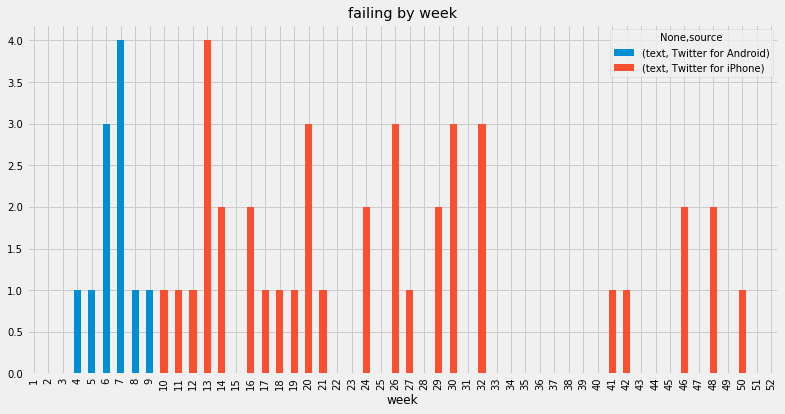

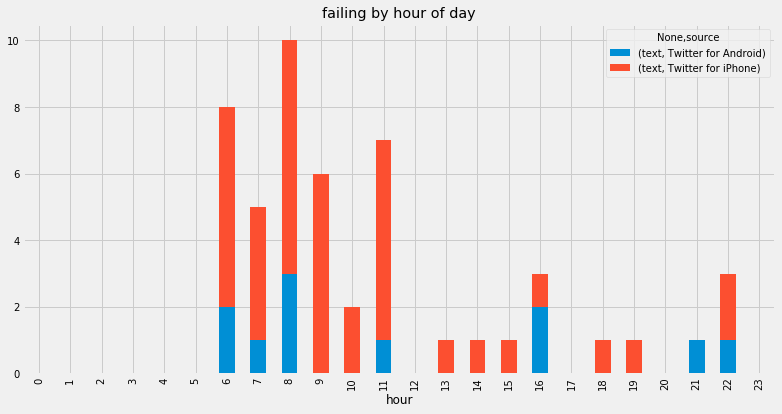

### The Tweets

[Sunday, Jul 29, 2018 3:09 PM](https://twitter.com/realDonaldTrump/status/1023646668179296257): ...dying newspaper industry. No matter how much they try to distract and cover it up, our country is making great progress under my leadership and I will never stop fighting for the American people! As an example, the failing New York Times...

[Monday, Jul 9, 2018 1:04 PM](https://twitter.com/realDonaldTrump/status/1016367395294908421): The failing NY Times Fake News story today about breast feeding must be called out. The U.S. strongly supports breast feeding but we don’t believe women should be denied access to formula. Many women need this option because of malnutrition and poverty.

[Saturday, Jul 7, 2018 9:21 AM](https://twitter.com/realDonaldTrump/status/1015586529484443648): Twitter is getting rid of fake accounts at a record pace. Will that include the Failing New York Times and propaganda machine for Amazon, the Washington Post, who constantly quote anonymous sources that, in my opinion, don’t exist - They will both be out of business in 7 years!

[Saturday, Jun 23, 2018 8:42 AM](https://twitter.com/realDonaldTrump/status/1010503423773507584): “Disability applications plunge as economy strengthens”  Failing New York Times

[Wednesday, May 30, 2018 10:35 AM](https://twitter.com/realDonaldTrump/status/1001834394359877633): The Failing and Corrupt @nytimes estimated the crowd last night at “1000 people,” when in fact it was many times that number - and the arena was rockin’. This is the way they demean and disparage. They are very dishonest people who don’t “get” me, and never did!

[Saturday, May 26, 2018 11:21 AM](https://twitter.com/realDonaldTrump/status/1000396430371106817): The Failing @nytimes quotes “a senior White House official,” who doesn’t exist, as saying “even if the meeting were reinstated, holding it on June 12 would be impossible, given the lack of time and the amount of planning needed.” WRONG AGAIN! Use real people, not phony sources.

[Saturday, May 26, 2018 11:03 AM](https://twitter.com/realDonaldTrump/status/1000391997969092608): Unlike what the Failing and Corrupt New York Times would like people to believe, there is ZERO disagreement within the Trump Administration as to  how to deal with North Korea...and if there was, it wouldn’t matter. The @nytimes has called me wrong right from the beginning!

[Sunday, May 20, 2018 9:04 AM](https://twitter.com/realDonaldTrump/status/998187672979038208): Things are really getting ridiculous. The Failing and Crooked (but not as Crooked as Hillary Clinton) @nytimes has done a long &amp; boring story indicating that the World’s most expensive Witch Hunt has found nothing on Russia &amp; me so now they are looking at the rest of the World!

[Wednesday, May 9, 2018 6:38 PM](https://twitter.com/realDonaldTrump/status/994345813064192012): The Failing New York Times criticized Secretary of State Pompeo for being AWOL (missing), when in fact he was flying to North Korea. Fake News, so bad!

[Sunday, Apr 29, 2018 10:59 PM](https://twitter.com/realDonaldTrump/status/990787671281819648): Headline: “Kim Prepared to Cede Nuclear Weapons if U.S. Pledges Not to Invade” - from the Failing New York Times. Also, will shut down Nuclear Test Site in May.

[Thursday, Apr 12, 2018 6:03 AM](https://twitter.com/realDonaldTrump/status/984371491277099010): If I wanted to fire Robert Mueller in December, as reported by the Failing New York Times, I would have fired him. Just more Fake News from a biased newspaper!

[Wednesday, Apr 11, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/984015782521835521): The Failing New York Times wrote another phony story. It was political pundit Doug Schoen, not a Ukrainian businessman, who asked me to do a short speech by phone (Skype), hosted by Doug, in Ukraine. I was very positive about Ukraine-another negative to the Fake Russia  C story!

[Saturday, Mar 31, 2018 8:45 AM](https://twitter.com/realDonaldTrump/status/980063581592047617): While we are on the subject, it is reported that the U.S. Post Office will lose $1.50 on average for each package it delivers for Amazon. That amounts to Billions of Dollars. The Failing N.Y. Times reports that “the size of the company’s lobbying staff has ballooned,” and that...

[Sunday, Mar 11, 2018 9:41 AM](https://twitter.com/realDonaldTrump/status/972829763067883523): The Failing New York Times purposely wrote a false story stating that I am unhappy with my legal team on the Russia case and am going to add another lawyer to help out. Wrong. I am VERY happy with my lawyers, John Dowd, Ty Cobb and Jay Sekulow. They are doing a great job and.....

[Monday, Dec 11, 2017 9:17 AM](https://twitter.com/realDonaldTrump/status/940223974985871360): Another false story, this time in the Failing @nytimes, that I watch 4-8 hours of television a day - Wrong!  Also, I seldom, if ever, watch CNN or MSNBC, both of which I consider Fake News. I never watch Don Lemon, who I once called the “dumbest man on television!” Bad Reporting.

[Thursday, Nov 30, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/936206961728786432): The Failing @nytimes has totally gone against the Social Media Guidelines that they installed to preserve some credibility after many of their biased reporters went Rogue!  @foxandfriends

[Thursday, Nov 30, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/936203511037136897): The Failing @nytimes, the pipe organ for the Democrat Party, has become a virtual lobbyist for them with regard to our massive Tax Cut Bill. They are wrong so often that now I know we have a winner!

[Wednesday, Nov 15, 2017 11:52 AM](https://twitter.com/realDonaldTrump/status/930840960346611712): It is actually hard to believe how naive (or dumb) the Failing @nytimes is when it comes to foreign policy...weak and ineffective!

[Wednesday, Nov 15, 2017 11:35 AM](https://twitter.com/realDonaldTrump/status/930836707095863296): The failing @nytimes hates the fact that I have developed a great relationship with World leaders like Xi Jinping, President of China.....

[Sunday, Oct 15, 2017 9:25 AM](https://twitter.com/realDonaldTrump/status/919554724512387072): The Failing @nytimes, in a story by Peter Baker, should have mentioned the rapid terminations by me of TPP &amp; The Paris Accord &amp; the fast....

[Tuesday, Oct 10, 2017 8:50 AM](https://twitter.com/realDonaldTrump/status/917734186848579584): The Failing @nytimes set Liddle' Bob Corker up by recording his conversation. Was made to sound a fool, and that's what I am dealing with!

[Tuesday, Aug 8, 2017 2:00 PM](https://twitter.com/realDonaldTrump/status/894981661926068228): E-mails show that the AmazonWashingtonPost and the FailingNewYorkTimes were reluctant to cover the Clinton/Lynch secret meeting in plane.

[Monday, Aug 7, 2017 4:39 PM](https://twitter.com/realDonaldTrump/status/894659355324424192): How much longer will the failing nytimes, with its big losses and massive unfunded liability (and non-existent sources), remain in business?

[Monday, Aug 7, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/894508048844279809): The failing @nytimes, which has made every wrong prediction about me including my big election win (apologized), is totally inept!

[Thursday, Jul 27, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/890524387773997056): Wow, the Failing @nytimes said about @foxandfriends "....the most powerful T.V. show in America."

[Sunday, Jul 23, 2017 7:57 PM](https://twitter.com/realDonaldTrump/status/889273320574783489): It's hard to read the Failing New York Times or the Amazon Washington Post because every story/opinion, even if should be positive, is bad!

[Saturday, Jul 22, 2017 6:45 AM](https://twitter.com/realDonaldTrump/status/888711488717934592): The Failing New York Times foiled U.S. attempt to kill the single most wanted terrorist,Al-Baghdadi.Their sick agenda over National Security

[Monday, Jul 17, 2017 10:17 PM](https://twitter.com/realDonaldTrump/status/887134287350439936): Republicans should just REPEAL failing ObamaCare now &amp; work on a new Healthcare Plan that will start from a clean slate. Dems will join in!

[Wednesday, Jun 28, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/880015261004435456): The failing @nytimes writes false story after false story about me. They don't even call to verify the facts of a story. A Fake News Joke!

[Tuesday, Jun 27, 2017 8:47 AM](https://twitter.com/realDonaldTrump/status/879682547235651584): So they caught Fake News CNN cold, but what about NBC, CBS &amp; ABC? What about the failing @nytimes &amp; @washingtonpost? They are all Fake News!

[Sunday, Jun 11, 2017 8:49 AM](https://twitter.com/realDonaldTrump/status/873884774041079808): The Democrats have no message,  not on economics, not on taxes,  not on jobs, not on failing #Obamacare. They are only OBSTRUCTIONISTS!

[Sunday, May 7, 2017 7:37 AM](https://twitter.com/realDonaldTrump/status/861183225082806272): RT @brunelldonald: I thought about jobs that went overseas failing schools open borders not my skin color when I voted @realDonaldTrump! I…

[Thursday, Apr 20, 2017 9:48 AM](https://twitter.com/realDonaldTrump/status/855055509455593472): Failing @nytimes, which has been calling me wrong for two years, just got caught in a big lie concerning New England Patriots visit to W.H.

[Wednesday, Apr 19, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/854676780527079425): Dems failed in Kansas and are now failing in Georgia. Great job Karen Handel! It is now Hollywood vs. Georgia on June 20th.

[Saturday, Apr 1, 2017 11:59 AM](https://twitter.com/realDonaldTrump/status/848203201094483972): The failing @nytimes finally gets it - "In places where no insurance company offers plans, there will be no way for ObamaCare customers to..

[Thursday, Mar 30, 2017 10:27 AM](https://twitter.com/realDonaldTrump/status/847455180912181249): The failing @nytimes has disgraced the media world. Gotten me wrong for two solid years. Change libel laws? https://t.co/QIqLgvYLLi

[Wednesday, Mar 29, 2017 8:01 AM](https://twitter.com/realDonaldTrump/status/847056211006631936): Remember when the failing @nytimes apologized to its subscribers, right after the election, because their coverage was so wrong. Now worse!

[Tuesday, Mar 28, 2017 11:26 AM](https://twitter.com/realDonaldTrump/status/846745288735887360): The failing @NYTimes would do much better if they were honest! 
https://t.co/ATy8R3knS2

[Wednesday, Mar 15, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/841967881516679168): Can you imagine what the outcry would be if @SnoopDogg, failing career and all, had aimed and fired the gun at President Obama? Jail time!

[Sunday, Feb 26, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/835817351178301440): For first time the failing @nytimes will take an ad (a bad one) to help save its failing reputation. Try reporting accurately &amp; fairly!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Friday, Feb 17, 2017 4:32 PM](https://twitter.com/realDonaldTrump/status/832704292993847296): The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more)    is not my enemy, it is the enemy of the American people. SICK!

[Thursday, Feb 16, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/832197515248275456): Leaking, and even illegal classified leaking, has been a big problem in Washington for years. Failing @nytimes (and others) must apologize!

[Wednesday, Feb 15, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/831840306161123328): Information is being illegally given to the failing @nytimes &amp; @washingtonpost by the intelligence community (NSA and FBI?).Just like Russia

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Monday, Feb 6, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/828793887275761665): The failing @nytimes was forced to apologize to its subscribers for the poor reporting it did on my election win. Now they are worse!

[Monday, Feb 6, 2017 11:32 AM](https://twitter.com/realDonaldTrump/status/828642511698669569): The failing @nytimes writes total fiction concerning me. They have gotten it wrong for two years, and now are making up stories &amp; sources!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

---

## Search: _election_

Number of Tweets: 168

Percent of all Tweets: 3.86%

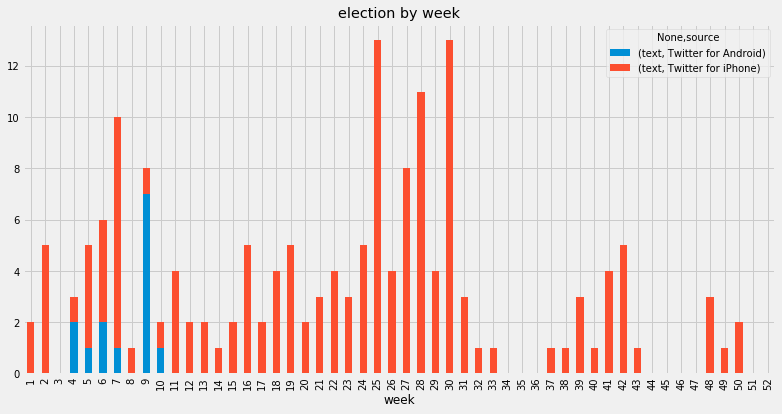

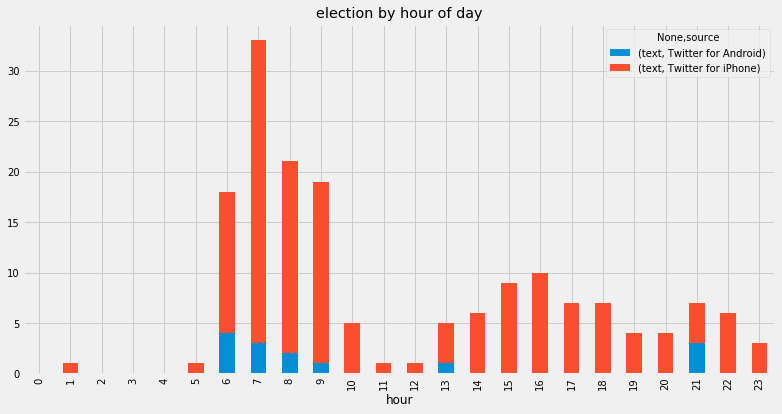

### The Tweets

[Thursday, Aug 9, 2018 9:22 AM](https://twitter.com/realDonaldTrump/status/1027545694201159680): “There has been no evidence whatsoever that Donald Trump or the campaign was involved in any kind of collusion to fix the 2016 election. In fact the evidence is the opposite, that Hillary Clinton &amp; the Democrats colluded with the Russians to fix the 2016 election.” @GrahamLedger

[Monday, Aug 6, 2018 3:13 PM](https://twitter.com/realDonaldTrump/status/1026546879289425920): John James is a potential Republican Star who has a Senate primary election tomorrow in Michigan. If he becomes the Republican candidate, he will beat the Open Borders, weak on Crime, Democrat, Debbie Stabenow. Vote for John James and Make America Great Again!

[Saturday, Aug 4, 2018 4:54 PM](https://twitter.com/realDonaldTrump/status/1025847550367215618): RT @realDonaldTrump: Troy Balderson, running for Congress from Ohio, is in a big Election fight with a candidate who just got caught lying…

[Saturday, Aug 4, 2018 9:02 AM](https://twitter.com/realDonaldTrump/status/1025728712560594946): Troy Balderson, running for Congress from Ohio, is in a big Election fight with a candidate who just got caught lying about his relationship with Nancy Pelosi, who is weak on Crime, Borders &amp; your 2nd Amendment-and wants to raise your Taxes (by a lot). Vote for Troy on Tuesday!

[Saturday, Aug 4, 2018 8:49 AM](https://twitter.com/realDonaldTrump/status/1025725493373558784): Will be going to Ohio tonight to campaign for Troy Balderson for the big Congressional Special Election on Tuesday. Early voting is on. Troy is strong on Crime, the Border &amp; loves our Military, Vets &amp; 2nd Amendment. His opponent is a puppet of Nancy Pelosi/high taxes.

[Friday, Aug 3, 2018 6:59 PM](https://twitter.com/realDonaldTrump/status/1025516607886577666): Almost 500,000 Manufacturing Jobs created since I won the Election. Remember when my opponents were saying that we couldn’t create this type of job anymore. Wrong, in fact these are among our best and most important jobs!

[Friday, Aug 3, 2018 6:10 PM](https://twitter.com/realDonaldTrump/status/1025504226204680192): July is just the ninth month since 1970 that unemployment has fallen below 4%. Our economy has added 3.7 million jobs since I won the Election. 4.1 GDP. More than 4 million people have received a pay raise due to tax reform. $400 Billion brought back from “overseas.” @FoxNews

[Thursday, Aug 2, 2018 2:53 PM](https://twitter.com/realDonaldTrump/status/1025092358126362630): Looking forward to being in the Great State of Pennsylvania where we had a tremendous victory in the Election. Will be campaigning hard for an original supporter, Lou Barletta, to replace a weak an ineffective Senator, Bob Casey. Lou is tough and smart, loves PA and our Country!

[Wednesday, Aug 1, 2018 9:03 AM](https://twitter.com/realDonaldTrump/status/1024641683600879616): “FBI Agent Peter Strzok (on the Mueller team) should have recused himself on day one. He was out to STOP THE ELECTION OF DONALD TRUMP. He needed an insurance policy. Those are illegal, improper goals, trying to influence the Election. He should never, ever been allowed to........

[Monday, Jul 30, 2018 6:28 PM](https://twitter.com/realDonaldTrump/status/1024059145564160000): ...your Social Security and Medicare! Cast your early vote, or vote on August 7th, Election Day. He has my full and total Endorsement!

[Tuesday, Jul 24, 2018 11:50 AM](https://twitter.com/realDonaldTrump/status/1021784726217142273): I’m very concerned that Russia will be fighting very hard to have an impact on the upcoming Election. Based on the fact that no President has been tougher on Russia than me, they will be pushing very hard for the Democrats. They definitely don’t want Trump!

[Sunday, Jul 22, 2018 6:23 PM](https://twitter.com/realDonaldTrump/status/1021158915206152193): So President Obama knew about Russia before the Election. Why didn’t he do something about it? Why didn’t he tell our campaign? Because it is all a big hoax, that’s why, and he thought Crooked Hillary was going to win!!!

[Saturday, Jul 21, 2018 7:23 PM](https://twitter.com/realDonaldTrump/status/1020811550771294211): Troy Balderson of Ohio is running for Congress against a Nancy Pelosi Liberal who is WEAK on Crime &amp; Borders. Troy is the total opposite, and loves our Military, Vets &amp; 2nd Amendment. EARLY VOTING just started with Election Day on August 7th. Troy has my Full &amp; Total Endorsement!

[Saturday, Jul 21, 2018 6:50 PM](https://twitter.com/realDonaldTrump/status/1020803264617615360): No Collusion, No Obstruction - but that doesn’t matter because the 13 Angry Democrats, who are only after Republicans and totally protecting Democrats, want this Witch Hunt to drag out to the November Election. Republicans better get smart fast and expose what they are doing!

[Saturday, Jul 21, 2018 6:40 PM](https://twitter.com/realDonaldTrump/status/1020800615226793986): The Rigged Witch Hunt, headed by the 13 Angry Democrats (and now 4 more have been added, one who worked directly for Obama W.H.), seems intent on damaging the Republican Party’s chances in the November Election. This Democrat excuse for losing the ‘16 Election never ends!

[Friday, Jul 20, 2018 9:04 AM](https://twitter.com/realDonaldTrump/status/1020293430398935040): Farmers have been on a downward trend for 15 years. The price of soybeans has fallen 50% since 5 years before the Election. A big reason is bad (terrible) Trade Deals with other countries. They put on massive Tariffs and Barriers. Canada charges 275% on Dairy. Farmers will WIN!

[Wednesday, Jul 18, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/1019545713435467776): 3.4 million jobs created since our great Election Victory - far greater than ever anticipated, and only getting better as new and greatly improved Trade Deals start coming to fruition!

[Monday, Jul 16, 2018 1:37 AM](https://twitter.com/realDonaldTrump/status/1018731223890481153): President Obama thought that Crooked Hillary was going to win the election, so when he was informed by the FBI about Russian Meddling, he said it couldn’t happen, was no big deal, &amp; did NOTHING about it. When I won it became a big deal and the Rigged Witch Hunt headed by Strzok!

[Saturday, Jul 14, 2018 7:34 AM](https://twitter.com/realDonaldTrump/status/1018096402520518656): ....Remember, it was Little Jeff Z and his people, who are told exactly what to say, who said I could not win the election in that “there was no way to 270” (over &amp; over again) in the Electoral College. I got 306! They were sooooo wrong in their election coverage. Still hurting!

[Saturday, Jul 14, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/1018074723140427776): The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administration. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?

[Saturday, Jul 14, 2018 5:53 AM](https://twitter.com/realDonaldTrump/status/1018070907741523968): The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administrations. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?

[Thursday, Jul 12, 2018 1:52 PM](https://twitter.com/realDonaldTrump/status/1017466758280679425): Great success today at NATO! Billions of additional dollars paid by members since my election. Great spirit!

[Wednesday, Jul 11, 2018 5:10 PM](https://twitter.com/realDonaldTrump/status/1017154189569527809): RT @realDonaldTrump: I am in Brussels, but always thinking about our farmers. Soy beans fell 50% from 2012 to my election. Farmers have don…

[Wednesday, Jul 11, 2018 5:09 PM](https://twitter.com/realDonaldTrump/status/1017153813625626624): If the Democrats want to win Supreme Court and other Court picks, don’t Obstruct and Resist, but rather do it the good ol’ fashioned way, WIN ELECTIONS!

[Wednesday, Jul 11, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1017025845905494016): I am in Brussels, but always thinking about our farmers. Soy beans fell 50% from 2012 to my election. Farmers have done poorly for 15 years. Other countries’ trade barriers and tariffs have been destroying their businesses. I will open...

[Monday, Jul 9, 2018 8:14 AM](https://twitter.com/realDonaldTrump/status/1016294574417956869): I have long heard that the most important decision a U.S. President can make is the selection of a Supreme Court Justice - Will be announced tonight at 9:00 P.M.

[Friday, Jul 6, 2018 12:57 PM](https://twitter.com/realDonaldTrump/status/1015278594795417600): Just won lawsuit filed by the DNC and a bunch of Democrat crazies trying to claim the Trump Campaign (and others), colluded with Russia. They haven’t figured out that this was an excuse for them losing the election!

[Sunday, Jul 1, 2018 3:39 PM](https://twitter.com/realDonaldTrump/status/1013507396558303233): A big week, especially with our numerous victories in the Supreme Court. Heading back to the White House now. Focus will be on the selection of a new Supreme Court Justice. Exciting times for our country. Economy may be stronger than it has ever been!

[Thursday, Jun 28, 2018 7:25 AM](https://twitter.com/realDonaldTrump/status/1012295859072126977): Russia continues to say they had nothing to do with Meddling in our Election! Where is the DNC Server, and why didn’t Shady James Comey and the now disgraced FBI agents take and closely examine it? Why isn’t Hillary/Russia being looked at? So many questions, so much corruption!

[Tuesday, Jun 26, 2018 10:47 PM](https://twitter.com/realDonaldTrump/status/1011803149911384064): The Democrats are in Turmoil! Open Borders and unchecked Crime a certain way to lose elections. Republicans are for Strong Borders, NO Crime! A BIG NIGHT!

[Tuesday, Jun 26, 2018 10:18 PM](https://twitter.com/realDonaldTrump/status/1011795883925663744): Wow! Big Trump Hater Congressman Joe Crowley, who many expected was going to take Nancy Pelosi’s place, just LOST his primary election. In other words, he’s out! That is a big one that nobody saw happening. Perhaps he should have been nicer, and more respectful, to his President!

[Tuesday, Jun 26, 2018 9:52 PM](https://twitter.com/realDonaldTrump/status/1011789419521675264): Congratulations to Governor Henry McMaster on your BIG election win! South Carolina loves you. We are all proud of you and Peggy! @henrymcmaster

[Saturday, Jun 23, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/1010485876806348800): .@FoxNews  Poll numbers plummet on the Democrat inspired and paid for Russian Witch Hunt. With all of the bias, lying and hate by the investigators, people want the investigators investigated. Much more will come out. A total scam and excuse for the Dems losing the Election!

[Friday, Jun 22, 2018 9:43 AM](https://twitter.com/realDonaldTrump/status/1010156224749408258): We must maintain a Strong Southern Border. We cannot allow our Country to be overrun by illegal immigrants as the Democrats tell their phony stories of sadness and grief, hoping it will help them in the elections. Obama and others had the same pictures, and did nothing about it!

[Tuesday, Jun 19, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/1009071326219395073): I can’t think of something more concerning than a law enforcement officer suggesting that their going to use their powers to affect an election!” Inspector General Horowitz on what was going on with numerous people regarding my election. A Rigged Witch Hunt!p

[Sunday, Jun 17, 2018 8:49 PM](https://twitter.com/realDonaldTrump/status/1008511869970255872): The Democrats should get together with their Republican counterparts and work something out on Border Security &amp; Safety. Don’t wait until after the election because you are going to lose!

[Saturday, Jun 16, 2018 9:12 AM](https://twitter.com/realDonaldTrump/status/1007974129474121728): My supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. It is a beautiful thing to watch as we win elections and gather support from all over the country. As we get stronger, so does our country. Best numbers ever!

[Friday, Jun 15, 2018 7:45 AM](https://twitter.com/realDonaldTrump/status/1007589800667435011): U.S.A. Jobs numbers are the BEST in 44 years. If my opponent (the Democrats) had won the election, they would have raised taxes substantially and increased regulations - the economy, and jobs, would have been a disaster!

[Monday, Jun 11, 2018 5:52 PM](https://twitter.com/realDonaldTrump/status/1006293144911085568): Stock Market up almost 40% since the Election, with 7 Trillion Dollars of U.S. value built throughout the economy. Lowest unemployment rate in many decades, with Black &amp; Hispanic unemployment lowest in History, and Female unemployment lowest in 21 years. Highest confidence ever!

[Thursday, Jun 7, 2018 9:07 AM](https://twitter.com/realDonaldTrump/status/1004711557291560960): When and where will all of the many conflicts of interest be listed by the 13 Angry Democrats (plus) working on the Witch Hunt Hoax. There has never been a group of people on a case so biased or conflicted. It is all a Democrat Excuse for LOSING the Election. Where is the server?

[Tuesday, Jun 5, 2018 9:23 PM](https://twitter.com/realDonaldTrump/status/1004171953404628998): Chris Farrell, Judicial Watch. “They were running an operation to undermine a candidate for President of the U.S. These are all violations of law. This is intelligence tradecraft to steer an election. There’s nothing more grave when it comes to abuse of our intelligence system...

[Tuesday, Jun 5, 2018 6:51 AM](https://twitter.com/realDonaldTrump/status/1003952348962619392): The U.S. has an increased economic value of more than 7 Trillion Dollars since the Election. May be the best economy in the history of our country. Record Jobs numbers. Nice!

[Tuesday, May 29, 2018 7:09 AM](https://twitter.com/realDonaldTrump/status/1001420270094168064): Why aren’t the 13 Angry and heavily conflicted Democrats investigating the totally Crooked Campaign of totally Crooked Hillary Clinton. It’s a Rigged Witch Hunt, that’s why! Ask them if they enjoyed her after election celebration!

[Tuesday, May 29, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/1001417880116891650): The 13 Angry Democrats (plus people who worked 8 years for Obama) working on the rigged Russia Witch Hunt, will be MEDDLING with the mid-term elections, especially now that Republicans (stay tough!) are taking the lead in Polls. There was no Collusion, except by the Democrats!

[Sunday, May 27, 2018 4:32 PM](https://twitter.com/realDonaldTrump/status/1000837182297464832): Why didn’t President Obama do something about the so-called Russian Meddling when he was told about it by the FBI before the Election? Because he thought Crooked Hillary was going to win, and he didn’t want to upset the apple cart! He was in charge, not me, and did nothing.

[Saturday, May 26, 2018 3:41 PM](https://twitter.com/realDonaldTrump/status/1000462031500099584): This whole Russia Probe is Rigged. Just an excuse as to why the Dems and Crooked Hillary lost the Election and States that haven’t been lost in decades. 13 Angry Democrats, and all Dems if you include the people who worked for Obama for 8 years. #SPYGATE &amp; CONFLICTS OF INTEREST!

[Sunday, May 20, 2018 9:29 AM](https://twitter.com/realDonaldTrump/status/998194013193822208): Now that the Witch Hunt has given up on Russia and is looking at the rest of the World, they should easily be able to take it into the Mid-Term Elections where they can put some hurt on the Republican Party. Don’t worry about Dems FISA Abuse, missing Emails or Fraudulent Dossier!

[Thursday, May 17, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/997076300476055552): Congratulations America, we are now into the second year of the greatest Witch Hunt in American History...and there is still No Collusion and No Obstruction. The only Collusion was that done by Democrats who were unable to win an Election despite the spending of far more money!

[Wednesday, May 16, 2018 2:40 PM](https://twitter.com/realDonaldTrump/status/996822738101825538): Lou Barletta will be a great Senator for Pennsylvania but his opponent, Bob Casey, has been a do-nothing Senator who only shows up at election time. He votes along the Nancy Pelosi, Elizabeth Warren lines, loves sanctuary cities, bad and expensive healthcare...

[Monday, May 7, 2018 9:35 AM](https://twitter.com/realDonaldTrump/status/993484478633922560): Is this Phony Witch Hunt going to go on even longer so it wrongfully impacts the Mid-Term Elections, which is what the Democrats always intended? Republicans better get tough and smart before it is too late!

[Monday, May 7, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/993475610377932801): “The Great Revolt” by Salena Zito and Brad Todd does much to tell the story of our great Election victory. The Forgotten Men &amp; Women are forgotten no longer!

[Monday, May 7, 2018 6:53 AM](https://twitter.com/realDonaldTrump/status/993443781281271808): To the great people of West Virginia we have, together, a really great chance to keep making a big difference. Problem is, Don Blankenship, currently running for Senate, can’t win the General Election in your State...No way! Remember Alabama. Vote Rep. Jenkins or A.G. Morrisey!

[Wednesday, Apr 25, 2018 7:53 AM](https://twitter.com/realDonaldTrump/status/989110172495810560): Congratulations to Republican Debbie Lesko on her big win in the Special Election for Arizona House seat. Debbie will do a Great Job! Press is so silent.

[Friday, Apr 20, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/987426984195174405): Can you believe that despite 93% bad stories from the Fake News Media (should be getting good stories), today we had just about our highest Poll Numbers, including those on Election Day? The American public is wise to the phony an dishonest press. Make America Great Again!

[Tuesday, Apr 17, 2018 1:59 PM](https://twitter.com/realDonaldTrump/status/986303188587425794): Rasmussen just came out at 51% Approval despite the Fake News Media. They were one of the three most accurate on Election Day. Just about the most inaccurate were CNN and ABC News/Washington Post, and they haven’t changed (get new pollsters). Much of the media is a Scam!

[Wednesday, Apr 11, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/984066131303583746): Speaker Paul Ryan is a truly good man, and while he will not be seeking re-election, he will leave a legacy of achievement that nobody can question. We are with you Paul!

[Thursday, Mar 29, 2018 7:57 AM](https://twitter.com/realDonaldTrump/status/979326715272065024): I have stated my concerns with Amazon long before the Election. Unlike others, they pay little or no taxes to state &amp; local governments, use our Postal System as their Delivery Boy (causing tremendous loss to the U.S.), and are putting many thousands of retailers out of business!

[Friday, Mar 23, 2018 6:07 AM](https://twitter.com/realDonaldTrump/status/977124622285066240): House Intelligence Committee votes to release final report. FINDINGS: (1) No evidence provided of Collusion between Trump Campaign &amp; Russia. (2)  The Obama Administrations Post election response was insufficient. (3) Clapper provided inconsistent testimony on media contacts.

[Wednesday, Mar 21, 2018 2:56 PM](https://twitter.com/realDonaldTrump/status/976532956557737984): I called President Putin of Russia to congratulate him on his election victory (in past, Obama called him also). The Fake News Media is crazed because they wanted me to excoriate him. They are wrong! Getting along with Russia (and others) is a good thing, not a bad thing.......

[Wednesday, Mar 21, 2018 7:29 AM](https://twitter.com/realDonaldTrump/status/976420417090015232): “Special Council is told to find crimes, whether a crime exists or not. I was opposed to the selection of Mueller to be Special Council. I am still opposed to it. I think President Trump was right when he said there never should have been a Special Council appointed because.....

[Wednesday, Mar 21, 2018 7:03 AM](https://twitter.com/realDonaldTrump/status/976413956293226496): “Special Council is told to find crimes, wether crimes exist or not. I was opposed the the selection of Mueller to be Special Council, I still am opposed to it. I think President Trump was right when he said there never should have been a Special Council appointed because.....

[Monday, Mar 12, 2018 8:49 PM](https://twitter.com/realDonaldTrump/status/973360355790479361): THE HOUSE INTELLIGENCE COMMITTEE HAS, AFTER A 14 MONTH LONG IN-DEPTH INVESTIGATION, FOUND NO EVIDENCE OF COLLUSION OR COORDINATION BETWEEN THE TRUMP CAMPAIGN AND RUSSIA TO INFLUENCE THE 2016 PRESIDENTIAL ELECTION.

[Monday, Mar 5, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/970650759091163137): Why did the Obama Administration start an investigation into the Trump Campaign (with zero proof of wrongdoing) long before the Election in November? Wanted to discredit so Crooked H would win. Unprecedented. Bigger than Watergate! Plus, Obama did NOTHING about Russian meddling.

[Tuesday, Feb 27, 2018 5:58 PM](https://twitter.com/realDonaldTrump/status/968621347294318592): .@SenatorWicker of Mississippi has been a great supporter and incredible help in getting our massive Tax Cut Bill done and approved. Also big help on cutting regs. I am with him in his re-election all the way!

[Saturday, Feb 24, 2018 3:16 PM](https://twitter.com/realDonaldTrump/status/967493467046899712): Democrat judges have totally redrawn election lines in the great State of Pennsylvania. @FoxNews. This is very unfair to Republicans and to our country as a whole. Must be appealed to the United States Supreme Court ASAP!

[Tuesday, Feb 20, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/965937068907073536): Hope Republicans in the Great State of Pennsylvania challenge the new “pushed” Congressional Map, all the way to the Supreme Court, if necessary. Your Original was correct! Don’t let the Dems take elections away from you so that they can raise taxes &amp; waste money!

[Tuesday, Feb 20, 2018 7:46 AM](https://twitter.com/realDonaldTrump/status/965930611272712192): ....The President Obama quote just before election. That’s because he thought Crooked Hillary was going to win and he didn’t want to “rock the boat.” When I easily won the Electoral College, the whole game changed and the Russian excuse became the narrative of the Dems.

[Tuesday, Feb 20, 2018 7:37 AM](https://twitter.com/realDonaldTrump/status/965928352614965248): “There is no serious person out there who would suggest somehow that you could even rig America’s elections, there’s no evidence that that has happened in the past or that it will happen this time, and so I’d invite Mr. Trump to stop whining and make his case to get votes.” .....

[Monday, Feb 19, 2018 2:55 PM](https://twitter.com/realDonaldTrump/status/965676314576543744): Obama was President up to, and beyond, the 2016 Election. So why didn’t he do something about Russian meddling?

[Sunday, Feb 18, 2018 7:43 AM](https://twitter.com/realDonaldTrump/status/965205208191168512): Now that Adam Schiff is starting to blame President Obama for Russian meddling in the election, he is probably doing so as yet another excuse that the Democrats, lead by their fearless leader, Crooked Hillary Clinton, lost the 2016 election. But wasn’t I a great candidate?

[Sunday, Feb 18, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/965202556204003328): I never said Russia did not meddle in the election, I said “it may be Russia, or China or another country or group, or it may be a 400 pound genius sitting in bed and playing with his computer.” The Russian “hoax” was that the Trump campaign colluded with Russia - it never did!

[Sunday, Feb 18, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/965199840471810049): Finally, Liddle’ Adam Schiff, the leakin’ monster of no control, is now blaming the Obama Administration for Russian meddling in the 2016 Election. He is finally right about something. Obama was President, knew of the threat, and did nothing. Thank you Adam!

[Saturday, Feb 17, 2018 11:22 PM](https://twitter.com/realDonaldTrump/status/965079126829871104): General McMaster forgot to say that the results of the 2016 election were not impacted or changed by the Russians and that the only Collusion was between Russia and Crooked H, the DNC and the Dems. Remember the Dirty Dossier, Uranium, Speeches, Emails and the Podesta Company!

[Saturday, Feb 17, 2018 3:16 PM](https://twitter.com/realDonaldTrump/status/964956781670694912): “I have seen all of the Russian ads and I can say very definitively that swaying the election was *NOT* the main goal.”
Rob Goldman
Vice President of Facebook Ads https://t.co/A5ft7cGJkE

[Saturday, Feb 17, 2018 2:36 PM](https://twitter.com/realDonaldTrump/status/964946611502747649): Deputy A.G. Rod Rosenstein stated at the News Conference: “There is no allegation in the indictment that any American was a knowing participant in this illegal activity. There is no allegation in the indictment that the charged conduct altered the outcome of the 2016 election.

[Saturday, Feb 17, 2018 2:26 PM](https://twitter.com/realDonaldTrump/status/964944088696049666): “Charges Deal Don A Big Win,” written by Michael Goodwin of the @nypost, succinctly states that “the Russians had no impact on the election results.” There was no Collusion with the Trump Campaign. “She lost the old-fashioned way, by being a terrible candidate. Case closed.”

[Friday, Feb 16, 2018 3:18 PM](https://twitter.com/realDonaldTrump/status/964594780088033282): Russia started their anti-US campaign in 2014, long before I announced that I would run for President. The results of the election were not impacted. The Trump campaign did nothing wrong - no collusion!

[Saturday, Feb 10, 2018 1:34 PM](https://twitter.com/realDonaldTrump/status/962394439846191105): ....agencies, not just the FBI &amp; DOJ, now the State Department to dig up dirt on him in the days leading up to the Election. Comey had conversations with Donald Trump, which I don’t believe were accurate...he leaked information (corrupt).” Tom Fitton of Judicial Watch on @FoxNews

[Friday, Feb 9, 2018 8:59 AM](https://twitter.com/realDonaldTrump/status/961962694650757121): Costs on non-military lines will never come down if we do not elect more Republicans in the 2018 Election, and beyond. This Bill is a BIG VICTORY for our Military, but much waste in order to get Dem votes. Fortunately, DACA not included in this Bill, negotiations to start now!

[Friday, Feb 9, 2018 8:47 AM](https://twitter.com/realDonaldTrump/status/961959738853548033): Without more Republicans in Congress, we were forced to increase spending on things we do not like or want in order to finally, after many years of depletion, take care of our Military. Sadly, we needed some Dem votes for passage. Must elect more Republicans in 2018 Election!

[Saturday, Feb 3, 2018 7:40 PM](https://twitter.com/realDonaldTrump/status/959949725028974592): “The four page memo released Friday reports the disturbing fact about how the FBI and FISA appear to have been used to influence the 2016 election and its aftermath....The FBI failed to inform the FISA court that the Clinton campaign had funded the dossier....the FBI became....

[Saturday, Feb 3, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/959798726381457409): Rasmussen just announced that my approval rating jumped to 49%, a far better number than I had in winning the Election, and higher than certain “sacred cows.” Other Trump polls are way up also. So why does the media refuse to write this? Oh well, someday!

[Saturday, Jan 20, 2018 5:31 PM](https://twitter.com/realDonaldTrump/status/954843844402647040): Unprecedented success for our Country, in so many ways, since the Election. Record Stock Market, Strong on Military, Crime, Borders, &amp; ISIS, Judicial Strength &amp; Numbers, Lowest Unemployment for Women &amp; ALL, Massive Tax Cuts, end of Individual Mandate - and so much more. Big 2018!

[Saturday, Jan 20, 2018 6:44 AM](https://twitter.com/realDonaldTrump/status/954680914998648833): For those asking, the Republicans only have 51 votes in the Senate, and they need 60. That is why we need to win more Republicans in 2018 Election! We can then be even tougher on  Crime (and Border), and even better to our Military &amp; Veterans!

[Friday, Jan 19, 2018 3:53 PM](https://twitter.com/realDonaldTrump/status/954456754137501697): Just signed 702 Bill to reauthorize foreign intelligence collection. This is NOT the same FISA law that was so wrongly abused during the election. I will always do the right thing for our country and put the safety of the American people first!

[Thursday, Jan 18, 2018 7:53 AM](https://twitter.com/realDonaldTrump/status/953973568035086336): Will be going to Pennsylvania today in order to give my total support to RICK SACCONE, running for Congress in a Special Election (March 13). Rick is a great guy. We need more Republicans to continue our already successful agenda!

[Sunday, Jan 14, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/952538350333939713): “President Trump is not getting the credit he deserves for the economy. Tax Cut bonuses to more than 2,000,000 workers. Most explosive Stock Market rally that we’ve seen in modern times. 18,000 to 26,000 from Election, and grounded in profitability and growth. All Trump, not 0...

[Saturday, Jan 13, 2018 5:08 PM](https://twitter.com/realDonaldTrump/status/952301373479104512): So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They promote the Fake Book of a mentally deranged author, who knowingly writes false information. The Mainstream Media is crazed that WE won the election!

[Thursday, Jan 11, 2018 6:33 AM](https://twitter.com/realDonaldTrump/status/951416674808467461): Disproven and paid for by Democrats “Dossier used to spy on Trump Campaign. Did FBI use Intel tool to influence the Election?” @foxandfriends  Did Dems or Clinton also pay Russians? Where are hidden and smashed DNC servers? Where are Crooked Hillary Emails?  What a mess!

[Sunday, Dec 31, 2017 8:36 AM](https://twitter.com/realDonaldTrump/status/947461470924820480): Why would smart voters want to put Democrats in Congress in 2018 Election when their policies will totally kill the great wealth created during the months since the Election. People are much better off now not to mention ISIS, VA, Judges, Strong Border, 2nd A, Tax Cuts &amp; more?

[Sunday, Dec 31, 2017 8:26 AM](https://twitter.com/realDonaldTrump/status/947458942719979520): If the Dems (Crooked Hillary) got elected, your stocks would be down 50% from values on Election Day. Now they have a great future - and just beginning! https://t.co/9TzSC8F8vY

[Wednesday, Dec 13, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/940955920967880704): If last night’s election proved anything, it proved that we need to put up GREAT Republican candidates to increase the razor thin margins in both the House and Senate.

[Wednesday, Dec 13, 2017 6:22 AM](https://twitter.com/realDonaldTrump/status/940904649728708609): The reason I originally endorsed Luther Strange (and his numbers went up mightily), is that I said Roy Moore will not be able to win the General Election.  I was right! Roy worked hard but the deck was stacked against him!

[Monday, Dec 4, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/937652739001212928): Putting Pelosi/Schumer Liberal Puppet Jones into office in Alabama would hurt our great Republican Agenda of low on taxes, tough on crime, strong on military and borders...&amp; so much more. Look at your 401-k’s since Election. Highest Stock Market EVER! Jobs are roaring back!

[Friday, Dec 1, 2017 6:13 AM](https://twitter.com/realDonaldTrump/status/936553863255031809): The jury was not told the killer of Kate was a 7 time felon. The Schumer/Pelosi Democrats are so weak on Crime that they will pay a big price in the 2018 and 2020 Elections.

[Thursday, Nov 30, 2017 10:46 AM](https://twitter.com/realDonaldTrump/status/936260193536573440): The Dow just broke 24,000 for the first time (another all-time Record). If the Dems had won the Presidential Election, the Market would be down 50% from these levels and Consumer Confidence, which is also at an all-time high, would be “low and glum!”

[Sunday, Nov 26, 2017 4:29 PM](https://twitter.com/realDonaldTrump/status/934896989539586054): Since the first day I took office, all you hear is the phony Democrat excuse for losing the election, Russia, Russia,Russia.  Despite this I have the economy booming and have possibly done more than any 10 month President. MAKE AMERICA GREAT AGAIN!

[Friday, Oct 27, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/923866515358789633): Wacky &amp; totally unhinged Tom Steyer, who has been fighting me and my Make America Great Again agenda from beginning, never wins elections!

[Saturday, Oct 21, 2017 5:21 PM](https://twitter.com/realDonaldTrump/status/921848853090983938): Crooked Hillary Clinton spent hundreds of millions of dollars more on Presidential Election than I did. Facebook was on her side, not mine!

[Saturday, Oct 21, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/921726400922619904): Stock Market hits another all time high on Friday. 5.3 trillion dollars up since Election. Fake News doesn't spent much time on this!

[Tuesday, Oct 17, 2017 7:05 AM](https://twitter.com/realDonaldTrump/status/920244350268903424): RT @Scavino45: U.S. MARKETS FROM ELECTION DAY {Since 11/8/2016} 📈 https://t.co/HtjHrznQKJ

[Monday, Oct 16, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/919910256624447493): The U.S. has gained more than 5.2 trillion dollars in Stock Market Value since Election Day! Also, record business enthusiasm.

[Monday, Oct 16, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/919909494200528897): Since Election Day on November 8, the Stock Market is up more than 25%, unemployment is at a 17 year low &amp; companies are coming back to U.S.

[Saturday, Oct 14, 2017 7:08 AM](https://twitter.com/realDonaldTrump/status/919157838106300416): RT @RightlyNews: @realDonaldTrump @LouDobbs It is NOT a coincidence that the economy boomed immediately after the 2016 election.

[Wednesday, Oct 11, 2017 6:31 AM](https://twitter.com/realDonaldTrump/status/918061437750267904): It would be really nice if the Fake News Media would report the virtually unprecedented Stock Market growth since the election.Need tax cuts

[Wednesday, Oct 11, 2017 6:21 AM](https://twitter.com/realDonaldTrump/status/918058910673760258): Stock Market has increased by 5.2 Trillion dollars since the election on November 8th, a 25% increase. Lowest unemployment in 16 years and..

[Sunday, Oct 8, 2017 9:59 AM](https://twitter.com/realDonaldTrump/status/917026789188399105): Senator Bob Corker "begged" me to endorse him for re-election in Tennessee. I said "NO" and he dropped out (said he could not win without...

[Thursday, Oct 5, 2017 10:16 PM](https://twitter.com/realDonaldTrump/status/916124989736308736): RT @FoxBusiness: #StockAlert: U.S. markets since the election https://t.co/1kwamJuizO

[Saturday, Sep 30, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/914267744345972737): In analyzing the Alabama Primary race, Fake News always fails to mention that the candidate I endorsed went up MANY points after Election!

[Thursday, Sep 28, 2017 7:55 AM](https://twitter.com/realDonaldTrump/status/913371663789625344): Democrats don't want massive tax cuts - how does that win elections? Great reviews for Tax Cut and Reform Bill.

[Monday, Sep 25, 2017 9:50 PM](https://twitter.com/realDonaldTrump/status/912494675206053888): Big election tomorrow in the Great State of Alabama. Vote for Senator Luther Strange, tough on crime &amp; border - will never let you down!

[Friday, Sep 22, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/911189860769255424): The greatest influence over our election was the Fake News Media "screaming" for Crooked Hillary Clinton. Next, she was a bad candidate!

[Wednesday, Sep 13, 2017 10:47 PM](https://twitter.com/realDonaldTrump/status/908160218995068928): Crooked Hillary Clinton blames everybody (and every thing) but herself for her election loss. She lost the debates and lost her direction!

[Thursday, Aug 17, 2017 6:24 AM](https://twitter.com/realDonaldTrump/status/898128290698989568): ...and people like Ms. Heyer. Such a disgusting lie. He just can't forget his election trouncing.The people of South Carolina will remember!

[Monday, Aug 7, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/894508048844279809): The failing @nytimes, which has made every wrong prediction about me including my big election win (apologized), is totally inept!

[Tuesday, Aug 1, 2017 8:49 AM](https://twitter.com/realDonaldTrump/status/892366646542782464): Stock Market could hit all-time high (again) 22,000 today. Was 18,000 only 6 months ago on Election Day. Mainstream media seldom mentions!

[Saturday, Jul 29, 2017 7:15 PM](https://twitter.com/realDonaldTrump/status/891437168798965761): I love reading about all of the "geniuses" who were so instrumental in my election success. Problem is, most don't exist. #Fake News! MAGA

[Saturday, Jul 29, 2017 1:04 PM](https://twitter.com/realDonaldTrump/status/891343645529567232): U.S. Stock Market up almost 20% since Election!

[Saturday, Jul 29, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/891253798500487168): In other words, Russia was against Trump in the 2016 Election - and why not, I want strong military &amp; low oil prices. Witch Hunt! https://t.co/mMSxj4Su5z

[Sunday, Jul 23, 2017 4:11 PM](https://twitter.com/realDonaldTrump/status/889216341013655552): RT @realDonaldTrump: As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Dem…

[Sunday, Jul 23, 2017 4:09 PM](https://twitter.com/realDonaldTrump/status/889215815022727168): As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Democrats and Russians!

[Tuesday, Jul 18, 2017 9:03 PM](https://twitter.com/realDonaldTrump/status/887478019346051075): RT @FoxNews: U.S. Markets since election. https://t.co/rlWSt30GUd

[Sunday, Jul 16, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/886588838902206464): The ABC/Washington Post Poll, even though almost 40% is not bad at this time, was just about the most inaccurate poll around election time!

[Saturday, Jul 15, 2017 4:29 PM](https://twitter.com/realDonaldTrump/status/886321948275429381): Just got to the #USWomensOpen in Bedminster, New Jersey. People are really happy with record high stock market - up over 17% since election!

[Wednesday, Jul 12, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/885109663217352704): .@WashTimes states "Democrats have willfully used Moscow disinformation to influence the presidential election against Donald Trump."

[Sunday, Jul 9, 2017 8:06 AM](https://twitter.com/realDonaldTrump/status/884020939264073728): ...have it. Fake News said 17 intel agencies when actually 4 (had to apologize). Why did Obama do NOTHING when he had info before election?

[Sunday, Jul 9, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/884016887692234753): Putin &amp; I discussed forming an impenetrable Cyber Security unit    so that election hacking, &amp; many other negative things, will be guarded..

[Sunday, Jul 9, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/884012097805406208): I strongly pressed President Putin twice about Russian meddling in our election. He vehemently denied it. I've already given my opinion.....

[Saturday, Jul 1, 2017 6:02 PM](https://twitter.com/realDonaldTrump/status/881271809433374721): ....the 2016 election with interviews, speeches and social media. I had to beat #FakeNews, and did. We will continue to WIN!

[Monday, Jun 26, 2017 10:24 PM](https://twitter.com/realDonaldTrump/status/879525817361068032): From @FoxNews "Bombshell: In 2016, Obama dismissed idea that anyone could rig an American election."  Check out his statement - Witch Hunt!

[Saturday, Jun 24, 2017 4:44 PM](https://twitter.com/realDonaldTrump/status/878715504063643648): Obama Administration official said they "choked" when it came to acting on Russian meddling of election. They didn't want to hurt Hillary?

[Saturday, Jun 24, 2017 4:28 PM](https://twitter.com/realDonaldTrump/status/878711517537083392): Since the Obama Administration was told way before the 2016 Election that the Russians were meddling, why no action? Focus on them, not T!

[Friday, Jun 23, 2017 8:43 PM](https://twitter.com/realDonaldTrump/status/878413313188802560): Just out: The Obama Administration knew far in advance of November 8th about election meddling by Russia. Did nothing about it. WHY?

[Thursday, Jun 22, 2017 10:08 AM](https://twitter.com/realDonaldTrump/status/877891129194102785): ...Why did the DNC REFUSE to turn over its Server to the FBI, and still hasn't? It's all a big Dem scam and excuse for losing the election!

[Thursday, Jun 22, 2017 10:01 AM](https://twitter.com/realDonaldTrump/status/877889199353077760): ...Why did Democratic National Committee turn down the DHS offer to protect against hacks (long prior to election). It's all a big Dem HOAX!

[Thursday, Jun 22, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/877879361130688512): By the way, if Russia was working so hard on the 2016 Election, it all took place during the Obama Admin. Why didn't they stop them?

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Tuesday, Jun 20, 2017 10:33 PM](https://twitter.com/realDonaldTrump/status/877353797760286720): Thank you @FoxNews "Huge win for President Trump and GOP in Georgia Congressional Special Election."

[Sunday, Jun 18, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/876394578777174021): The new Rasmussen Poll, one of the most accurate in the 2016 Election, just out with a Trump 50% Approval Rating.That's higher than O's #'s!

[Sunday, Jun 11, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/873878061778907137): The #FakeNews MSM doesn't report the great economic news since Election Day. #DOW up 16%. #NASDAQ up 19.5%. Drilling &amp; energy sector...

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Friday, May 12, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/862998775731818496): Again, the story that there was collusion between the Russians &amp; Trump campaign was fabricated by Dems as an excuse for losing the election.

[Thursday, May 11, 2017 4:34 PM](https://twitter.com/realDonaldTrump/status/862767872879325185): Russia must be laughing up their sleeves watching as the U.S. tears itself apart over a Democrat EXCUSE for losing the election.

[Thursday, May 11, 2017 3:35 PM](https://twitter.com/realDonaldTrump/status/862753016193089536): 'Presidential Executive Order on the Establishment of Presidential Advisory Commission on Election Integrity'
➡️… https://t.co/kVG8r7qZS5

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Sunday, Apr 23, 2017 3:55 PM](https://twitter.com/realDonaldTrump/status/856234989591121922): ...popular vote. ABC News/Washington Post Poll (wrong big on election) said almost all stand by their vote on me &amp; 53% said strong leader.

[Sunday, Apr 23, 2017 10:05 AM](https://twitter.com/realDonaldTrump/status/856146924705120256): Very interesting election currently taking place in France.

[Friday, Apr 21, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/855368516920332289): Another terrorist attack in Paris. The people of France will not take much more of this. Will have a big effect on presidential election!

[Monday, Apr 17, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/853945633903923200): The Fake Media (not Real Media) has gotten even worse since the election. Every story is badly slanted. We have to hold them to the truth!

[Sunday, Apr 16, 2017 8:45 PM](https://twitter.com/realDonaldTrump/status/853771244579282944): The recent Kansas election (Congress) was a really big media event, until the Republicans won. Now they play the same game with Georgia-BAD!

[Sunday, Apr 16, 2017 9:13 AM](https://twitter.com/realDonaldTrump/status/853597199619543041): Someone should look into who paid for the small organized rallies yesterday. The election is over!

[Friday, Mar 31, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/847766558520856578): Mike Flynn should ask for immunity in that this is a witch hunt (excuse for big election loss), by media &amp; Dems, of historic proportion!

[Wednesday, Mar 29, 2017 8:01 AM](https://twitter.com/realDonaldTrump/status/847056211006631936): Remember when the failing @nytimes apologized to its subscribers, right after the election, because their coverage was so wrong. Now worse!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Saturday, Mar 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/837996746236182529): How low has President Obama gone to tapp my phones during the very sacred election process. This is Nixon/Watergate. Bad (or sick) guy!

[Saturday, Mar 4, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/837994257566863360): I'd bet a good lawyer could make a great case out of the fact that President Obama was tapping my phones in October, just prior to Election!

[Saturday, Mar 4, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/837993273679560704): Is it legal for a sitting President to be "wire tapping" a race for president prior to an election? Turned down by court earlier. A NEW LOW!

[Thursday, Mar 2, 2017 9:35 PM](https://twitter.com/realDonaldTrump/status/837491607171629057): ...to win. The Democrats are overplaying their hand. They lost the election, and now they have lost their grip on reality. The real story...

[Thursday, Mar 2, 2017 9:27 PM](https://twitter.com/realDonaldTrump/status/837489578193846278): ...intentional. This whole narrative is a way of saving face for Democrats losing an election that everyone thought they were supposed.....

[Thursday, Mar 2, 2017 6:00 AM](https://twitter.com/realDonaldTrump/status/837256338203881472): Since November 8th, Election Day, the Stock Market has posted $3.2 trillion in GAINS and consumer confidence is at a 15 year high. Jobs!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Monday, Feb 6, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/828793887275761665): The failing @nytimes was forced to apologize to its subscribers for the poor reporting it did on my election win. Now they are worse!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Sunday, Jan 22, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/823150055418920960): Watched protests yesterday but was under the impression that we just had an election! Why didn't these people vote? Celebs hurt cause badly.

---

In [43]:
searches = ['great', 'fake', 'mexic', 'fox', 'terror', 'ivanka', 'ms 13', 'russia', 'failing', 'election']
for search in searches:
    analyzeText(search)